In [55]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
%matplotlib inline

In [4]:
original_df = pd.read_excel('/home/quark/Documents/projects/TFM/Databases/data.xlsx')
original_df.sort_values(['Timestamp'], ascending=True, inplace=True)
original_df['Timestamp'] = pd.to_datetime(original_df['Timestamp'], unit='s')

marag_df = original_df[original_df['SiteId'] == 2][['Timestamp', 'TotalEntries']]
marag_df.set_index('Timestamp', inplace=True)
marag_df.sort_index(inplace=True)
marag_df = marag_df['2017-01-09 00:00:00':]
#Since from this date the time series is constinuous, we slice our dataframe consequently

In [5]:
def create_lags(dataframe, N):
    temp_df = dataframe.copy()
    for i in range(1,N+1):
        temp_df['t-' + str(i)] = temp_df['TotalEntries'].shift(i)
    
    return temp_df.iloc[N:]
df_with_lags = create_lags(marag_df, 48)

In [9]:
#Initial data preparation:
def train_dev_test_split(X_data, y_data):
    
##CODE IMPROVEMENT: raise error if X and y of different size!    
    cut1 = int(0.6*len(X_data))
    cut2 = ((len(X_data)-cut1)//2) + cut1
    X_train = X_data[:cut1]
    X_dev = X_data[cut1:cut2]
    X_test = X_data[cut2:]
    y_train = y_data[:cut1]
    y_dev = y_data[cut1:cut2]
    y_test = y_data[cut2:]
    
    return X_train, X_dev, X_test, y_train, y_dev, y_test
    
#X_train, X_temp, y_train, y_temp = train_test_split(men_df.drop('TotalEntriesMen', axis = 1), men_df['TotalEntriesMen'], test_size = 0.4, random_state = 42, shuffle=False)
X_train, X_dev, X_test, y_train, y_dev, y_test = train_dev_test_split(df_with_lags.drop(['TotalEntries'], axis=1), df_with_lags['TotalEntries'])

X_train_raw = marag_df[:X_train[-1:].index.astype(str)[0]]

In [10]:
def walk_forward_validation(X_train, y_train, X_test, L, model):

    '''This function integrates a walk-forward validation method for multiple models.
    Parameters: model, #lags, train data, test data, length of test_data'''

    X_grow = X_train_raw.astype('float64').sort_index()
    y_grow_hat = []
    #RMSE_record = []
    for i in tqdm(range(len(X_test))):
        y_hat = model.predict(X_test[i:i+1])
        #RMSE_record.append(y_hat)
        y_grow_hat.append(y_hat)
        y_hat = pd.DataFrame(y_hat, index=X_test[i:(i+1)].index, columns=['TotalEntries'])
        #y_hat = pd.DataFrame(y_hat, columns=['TotalEntries'])
        #y_hat.set_index(X_dev[i:(i+1)].index, inplace=True)
        X_grow = pd.concat([X_grow, y_hat])
        X_data = create_lags(X_grow, L)
        model.fit(X_data.drop(['TotalEntries'], axis=1), X_data['TotalEntries'])
        #y_hat_trans = create_lags(pd.DataFrame(y_hat), 49)
        #X_grow = pd.concat(X_grow, y_hat_trans)
        #model.fit(X_grow)
    
    
    return y_grow_hat


## Autoregression (linear regression)

In [ ]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression().fit(X_train, y_train)
y_dev_hat = walk_forward_validation(X_train, y_train, X_dev, 48, lr_model)

In [ ]:
RMSE = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
r2 = r2_score(y_dev, y_dev_hat)
r2_adjusted_test = 1 - (1-r2_score(y_dev, y_dev_hat))*(len(y_dev)-1)/(len(y_dev)-X_test.shape[1]-1)
RMSE, r2, r2_adjusted_test

## K-nearest neighbourhood

In [11]:
from sklearn.neighbors import KNeighborsRegressor

reg_kn = KNeighborsRegressor(n_neighbors=2)#WRITE YOUR CODE
reg_kn.fit(X_train, y_train)
y_dev_hat = walk_forward_validation(X_train, y_train, X_dev, 48, reg_kn)

100%|██████████| 7450/7450 [09:23<00:00, 12.18it/s]


In [56]:
RMSE = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
r2 = r2_score(y_dev, y_dev_hat)
r2_adjusted_test = 1 - (1-r2_score(y_dev, y_dev_hat))*(len(y_dev)-1)/(len(y_dev)-X_test.shape[1]-1)
RMSE, r2, r2_adjusted_test

In [58]:
RMSE, r2, r2_adjusted_test

(34.18503240999034, 0.9395933670263057, 0.939201593160242)

In [111]:
# Tuning KNN
best_KNN_RMSE = []
for n_n in tqdm(range(1, 10)):
    tuned_knn = KNeighborsRegressor(n_neighbors=n_n)
    tuned_knn.fit(X_train, y_train)
    y_dev_hat = walk_forward_validation(X_train, y_train, X_dev, 48, tuned_knn)
    RMSE = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
    if pd.DataFrame(best_KNN_RMSE).empty:
            best_KNN_RMSE = [n_n, RMSE]
    else:
        if RMSE < np.array(best_KNN_RMSE)[1]:
            best_RMSE = [n_n, RMSE]

best_KNN_RMSE



  0%|          | 0/9 [00:00<?, ?it/s]


  0%|          | 0/7450 [00:00<?, ?it/s]


  0%|          | 2/7450 [00:00<08:47, 14.11it/s]


  0%|          | 4/7450 [00:00<08:41, 14.28it/s]


  0%|          | 6/7450 [00:00<08:35, 14.44it/s]


  0%|          | 8/7450 [00:00<08:34, 14.47it/s]


  0%|          | 10/7450 [00:00<08:30, 14.56it/s]


  0%|          | 12/7450 [00:00<08:26, 14.69it/s]


  0%|          | 14/7450 [00:00<08:26, 14.69it/s]


  0%|          | 16/7450 [00:01<08:28, 14.62it/s]


  0%|          | 18/7450 [00:01<08:50, 14.01it/s]


  0%|          | 20/7450 [00:01<09:08, 13.54it/s]


  0%|          | 22/7450 [00:01<09:02, 13.69it/s]


  0%|          | 24/7450 [00:01<08:56, 13.85it/s]


  0%|          | 26/7450 [00:01<09:20, 13.24it/s]


  0%|          | 28/7450 [00:02<09:23, 13.18it/s]


  0%|          | 30/7450 [00:02<09:11, 13.46it/s]


  0%|          | 32/7450 [00:02<09:03, 13.66it/s]


  0%|          | 34/7450 [00:02<08:53, 13.90it/s]


  0%|          | 36/7450 [00:02<08:

  4%|▎         | 264/7450 [00:18<08:01, 14.92it/s]


  4%|▎         | 266/7450 [00:18<08:01, 14.92it/s]


  4%|▎         | 268/7450 [00:18<07:59, 14.97it/s]


  4%|▎         | 270/7450 [00:18<08:01, 14.91it/s]


  4%|▎         | 272/7450 [00:19<08:05, 14.78it/s]


  4%|▎         | 274/7450 [00:19<08:02, 14.87it/s]


  4%|▎         | 276/7450 [00:19<08:00, 14.92it/s]


  4%|▎         | 278/7450 [00:19<08:01, 14.88it/s]


  4%|▍         | 280/7450 [00:19<08:02, 14.85it/s]


  4%|▍         | 282/7450 [00:19<08:06, 14.72it/s]


  4%|▍         | 284/7450 [00:19<08:06, 14.73it/s]


  4%|▍         | 286/7450 [00:20<08:05, 14.76it/s]


  4%|▍         | 288/7450 [00:20<08:06, 14.72it/s]


  4%|▍         | 290/7450 [00:20<08:11, 14.58it/s]


  4%|▍         | 292/7450 [00:20<08:09, 14.61it/s]


  4%|▍         | 294/7450 [00:20<08:08, 14.65it/s]


  4%|▍         | 296/7450 [00:20<08:09, 14.61it/s]


  4%|▍         | 298/7450 [00:20<08:12, 14.53it/s]


  4%|▍         | 300/7450 [00:21<08:13, 14.48i

  7%|▋         | 528/7450 [00:36<07:39, 15.05it/s]


  7%|▋         | 530/7450 [00:36<07:42, 14.98it/s]


  7%|▋         | 532/7450 [00:36<07:41, 15.00it/s]


  7%|▋         | 534/7450 [00:36<07:44, 14.89it/s]


  7%|▋         | 536/7450 [00:37<07:45, 14.87it/s]


  7%|▋         | 538/7450 [00:37<07:44, 14.89it/s]


  7%|▋         | 540/7450 [00:37<07:42, 14.93it/s]


  7%|▋         | 542/7450 [00:37<07:42, 14.94it/s]


  7%|▋         | 544/7450 [00:37<07:42, 14.93it/s]


  7%|▋         | 546/7450 [00:37<07:46, 14.79it/s]


  7%|▋         | 548/7450 [00:37<07:43, 14.90it/s]


  7%|▋         | 550/7450 [00:37<07:43, 14.90it/s]


  7%|▋         | 552/7450 [00:38<07:42, 14.92it/s]


  7%|▋         | 554/7450 [00:38<07:42, 14.91it/s]


  7%|▋         | 556/7450 [00:38<07:45, 14.83it/s]


  7%|▋         | 558/7450 [00:38<07:46, 14.78it/s]


  8%|▊         | 560/7450 [00:38<07:45, 14.81it/s]


  8%|▊         | 562/7450 [00:38<07:42, 14.88it/s]


  8%|▊         | 564/7450 [00:38<07:41, 14.92i

 11%|█         | 792/7450 [00:54<07:32, 14.73it/s]


 11%|█         | 794/7450 [00:54<07:32, 14.72it/s]


 11%|█         | 796/7450 [00:54<07:43, 14.36it/s]


 11%|█         | 798/7450 [00:54<07:56, 13.96it/s]


 11%|█         | 800/7450 [00:55<08:21, 13.27it/s]


 11%|█         | 802/7450 [00:55<08:27, 13.09it/s]


 11%|█         | 804/7450 [00:55<08:34, 12.92it/s]


 11%|█         | 806/7450 [00:55<08:40, 12.77it/s]


 11%|█         | 808/7450 [00:55<08:44, 12.67it/s]


 11%|█         | 810/7450 [00:55<08:52, 12.47it/s]


 11%|█         | 812/7450 [00:56<08:44, 12.66it/s]


 11%|█         | 814/7450 [00:56<08:44, 12.65it/s]


 11%|█         | 816/7450 [00:56<08:42, 12.70it/s]


 11%|█         | 818/7450 [00:56<08:31, 12.96it/s]


 11%|█         | 820/7450 [00:56<08:25, 13.11it/s]


 11%|█         | 822/7450 [00:56<08:12, 13.45it/s]


 11%|█         | 824/7450 [00:56<08:07, 13.60it/s]


 11%|█         | 826/7450 [00:57<08:03, 13.70it/s]


 11%|█         | 828/7450 [00:57<08:00, 13.78i

 14%|█▍        | 1054/7450 [01:13<08:09, 13.08it/s]


 14%|█▍        | 1056/7450 [01:13<08:30, 12.53it/s]


 14%|█▍        | 1058/7450 [01:13<08:17, 12.86it/s]


 14%|█▍        | 1060/7450 [01:13<08:03, 13.21it/s]


 14%|█▍        | 1062/7450 [01:14<08:33, 12.43it/s]


 14%|█▍        | 1064/7450 [01:14<08:32, 12.45it/s]


 14%|█▍        | 1066/7450 [01:14<08:22, 12.70it/s]


 14%|█▍        | 1068/7450 [01:14<08:12, 12.95it/s]


 14%|█▍        | 1070/7450 [01:14<08:03, 13.21it/s]


 14%|█▍        | 1072/7450 [01:14<08:00, 13.28it/s]


 14%|█▍        | 1074/7450 [01:15<07:56, 13.38it/s]


 14%|█▍        | 1076/7450 [01:15<08:13, 12.92it/s]


 14%|█▍        | 1078/7450 [01:15<08:19, 12.75it/s]


 14%|█▍        | 1080/7450 [01:15<08:01, 13.24it/s]


 15%|█▍        | 1082/7450 [01:15<07:46, 13.64it/s]


 15%|█▍        | 1084/7450 [01:15<07:41, 13.80it/s]


 15%|█▍        | 1086/7450 [01:15<07:34, 14.00it/s]


 15%|█▍        | 1088/7450 [01:16<07:45, 13.67it/s]


 15%|█▍        | 1090/7450 [

 18%|█▊        | 1314/7450 [01:32<07:19, 13.95it/s]


 18%|█▊        | 1316/7450 [01:33<07:21, 13.91it/s]


 18%|█▊        | 1318/7450 [01:33<07:14, 14.11it/s]


 18%|█▊        | 1320/7450 [01:33<07:11, 14.19it/s]


 18%|█▊        | 1322/7450 [01:33<07:10, 14.23it/s]


 18%|█▊        | 1324/7450 [01:33<07:06, 14.35it/s]


 18%|█▊        | 1326/7450 [01:33<07:12, 14.15it/s]


 18%|█▊        | 1328/7450 [01:33<07:11, 14.17it/s]


 18%|█▊        | 1330/7450 [01:34<07:10, 14.21it/s]


 18%|█▊        | 1332/7450 [01:34<07:08, 14.29it/s]


 18%|█▊        | 1334/7450 [01:34<07:07, 14.30it/s]


 18%|█▊        | 1336/7450 [01:34<07:27, 13.66it/s]


 18%|█▊        | 1338/7450 [01:34<07:45, 13.13it/s]


 18%|█▊        | 1340/7450 [01:34<07:38, 13.33it/s]


 18%|█▊        | 1342/7450 [01:34<07:29, 13.60it/s]


 18%|█▊        | 1344/7450 [01:35<07:23, 13.78it/s]


 18%|█▊        | 1346/7450 [01:35<07:17, 13.94it/s]


 18%|█▊        | 1348/7450 [01:35<07:27, 13.64it/s]


 18%|█▊        | 1350/7450 [

 21%|██        | 1574/7450 [01:51<06:47, 14.42it/s]


 21%|██        | 1576/7450 [01:51<06:46, 14.43it/s]


 21%|██        | 1578/7450 [01:52<06:43, 14.54it/s]


 21%|██        | 1580/7450 [01:52<06:44, 14.51it/s]


 21%|██        | 1582/7450 [01:52<06:45, 14.49it/s]


 21%|██▏       | 1584/7450 [01:52<06:52, 14.23it/s]


 21%|██▏       | 1586/7450 [01:52<06:50, 14.28it/s]


 21%|██▏       | 1588/7450 [01:52<06:46, 14.42it/s]


 21%|██▏       | 1590/7450 [01:52<06:47, 14.37it/s]


 21%|██▏       | 1592/7450 [01:53<06:53, 14.16it/s]


 21%|██▏       | 1594/7450 [01:53<06:56, 14.06it/s]


 21%|██▏       | 1596/7450 [01:53<06:55, 14.08it/s]


 21%|██▏       | 1598/7450 [01:53<06:55, 14.07it/s]


 21%|██▏       | 1600/7450 [01:53<06:55, 14.08it/s]


 22%|██▏       | 1602/7450 [01:53<06:57, 13.99it/s]


 22%|██▏       | 1604/7450 [01:53<06:51, 14.22it/s]


 22%|██▏       | 1606/7450 [01:54<06:47, 14.33it/s]


 22%|██▏       | 1608/7450 [01:54<06:44, 14.44it/s]


 22%|██▏       | 1610/7450 [

 25%|██▍       | 1834/7450 [02:10<06:32, 14.30it/s]


 25%|██▍       | 1836/7450 [02:10<06:30, 14.36it/s]


 25%|██▍       | 1838/7450 [02:10<06:30, 14.38it/s]


 25%|██▍       | 1840/7450 [02:10<06:30, 14.35it/s]


 25%|██▍       | 1842/7450 [02:10<06:30, 14.36it/s]


 25%|██▍       | 1844/7450 [02:10<06:33, 14.25it/s]


 25%|██▍       | 1846/7450 [02:10<06:31, 14.31it/s]


 25%|██▍       | 1848/7450 [02:11<06:29, 14.37it/s]


 25%|██▍       | 1850/7450 [02:11<06:27, 14.44it/s]


 25%|██▍       | 1852/7450 [02:11<06:26, 14.49it/s]


 25%|██▍       | 1854/7450 [02:11<06:29, 14.37it/s]


 25%|██▍       | 1856/7450 [02:11<06:28, 14.41it/s]


 25%|██▍       | 1858/7450 [02:11<06:26, 14.46it/s]


 25%|██▍       | 1860/7450 [02:11<06:25, 14.51it/s]


 25%|██▍       | 1862/7450 [02:12<06:23, 14.56it/s]


 25%|██▌       | 1864/7450 [02:12<06:23, 14.57it/s]


 25%|██▌       | 1866/7450 [02:12<06:26, 14.45it/s]


 25%|██▌       | 1868/7450 [02:12<06:26, 14.45it/s]


 25%|██▌       | 1870/7450 [

 28%|██▊       | 2094/7450 [02:29<06:31, 13.67it/s]


 28%|██▊       | 2096/7450 [02:29<06:30, 13.72it/s]


 28%|██▊       | 2098/7450 [02:29<06:27, 13.81it/s]


 28%|██▊       | 2100/7450 [02:29<06:28, 13.76it/s]


 28%|██▊       | 2102/7450 [02:29<06:29, 13.73it/s]


 28%|██▊       | 2104/7450 [02:30<06:28, 13.76it/s]


 28%|██▊       | 2106/7450 [02:30<06:28, 13.77it/s]


 28%|██▊       | 2108/7450 [02:30<06:56, 12.84it/s]


 28%|██▊       | 2110/7450 [02:30<06:50, 13.01it/s]


 28%|██▊       | 2112/7450 [02:30<06:45, 13.15it/s]


 28%|██▊       | 2114/7450 [02:30<06:39, 13.36it/s]


 28%|██▊       | 2116/7450 [02:31<06:38, 13.38it/s]


 28%|██▊       | 2118/7450 [02:31<06:41, 13.27it/s]


 28%|██▊       | 2120/7450 [02:31<07:02, 12.63it/s]


 28%|██▊       | 2122/7450 [02:31<06:50, 12.98it/s]


 29%|██▊       | 2124/7450 [02:31<06:40, 13.31it/s]


 29%|██▊       | 2126/7450 [02:31<06:35, 13.48it/s]


 29%|██▊       | 2128/7450 [02:31<06:30, 13.64it/s]


 29%|██▊       | 2130/7450 [

 32%|███▏      | 2354/7450 [02:47<06:01, 14.09it/s]


 32%|███▏      | 2356/7450 [02:48<06:00, 14.14it/s]


 32%|███▏      | 2358/7450 [02:48<06:00, 14.12it/s]


 32%|███▏      | 2360/7450 [02:48<06:01, 14.09it/s]


 32%|███▏      | 2362/7450 [02:48<06:01, 14.07it/s]


 32%|███▏      | 2364/7450 [02:48<06:02, 14.02it/s]


 32%|███▏      | 2366/7450 [02:48<06:03, 13.98it/s]


 32%|███▏      | 2368/7450 [02:48<06:03, 13.98it/s]


 32%|███▏      | 2370/7450 [02:49<06:06, 13.88it/s]


 32%|███▏      | 2372/7450 [02:49<06:05, 13.91it/s]


 32%|███▏      | 2374/7450 [02:49<06:02, 13.99it/s]


 32%|███▏      | 2376/7450 [02:49<06:01, 14.04it/s]


 32%|███▏      | 2378/7450 [02:49<06:00, 14.07it/s]


 32%|███▏      | 2380/7450 [02:49<05:59, 14.09it/s]


 32%|███▏      | 2382/7450 [02:49<05:59, 14.11it/s]


 32%|███▏      | 2384/7450 [02:50<05:57, 14.16it/s]


 32%|███▏      | 2386/7450 [02:50<05:56, 14.19it/s]


 32%|███▏      | 2388/7450 [02:50<05:56, 14.19it/s]


 32%|███▏      | 2390/7450 [

 35%|███▌      | 2614/7450 [03:06<05:43, 14.07it/s]


 35%|███▌      | 2616/7450 [03:06<05:42, 14.10it/s]


 35%|███▌      | 2618/7450 [03:06<05:45, 14.00it/s]


 35%|███▌      | 2620/7450 [03:06<05:46, 13.94it/s]


 35%|███▌      | 2622/7450 [03:07<05:47, 13.91it/s]


 35%|███▌      | 2624/7450 [03:07<05:46, 13.93it/s]


 35%|███▌      | 2626/7450 [03:07<05:45, 13.98it/s]


 35%|███▌      | 2628/7450 [03:07<05:44, 14.01it/s]


 35%|███▌      | 2630/7450 [03:07<05:45, 13.97it/s]


 35%|███▌      | 2632/7450 [03:07<05:45, 13.96it/s]


 35%|███▌      | 2634/7450 [03:07<05:44, 13.98it/s]


 35%|███▌      | 2636/7450 [03:08<05:44, 13.97it/s]


 35%|███▌      | 2638/7450 [03:08<05:44, 13.95it/s]


 35%|███▌      | 2640/7450 [03:08<05:44, 13.96it/s]


 35%|███▌      | 2642/7450 [03:08<05:44, 13.98it/s]


 35%|███▌      | 2644/7450 [03:08<05:43, 13.98it/s]


 36%|███▌      | 2646/7450 [03:08<05:44, 13.95it/s]


 36%|███▌      | 2648/7450 [03:08<05:44, 13.95it/s]


 36%|███▌      | 2650/7450 [

 39%|███▊      | 2874/7450 [03:25<05:25, 14.05it/s]


 39%|███▊      | 2876/7450 [03:25<05:24, 14.09it/s]


 39%|███▊      | 2878/7450 [03:25<05:25, 14.06it/s]


 39%|███▊      | 2880/7450 [03:25<05:25, 14.03it/s]


 39%|███▊      | 2882/7450 [03:25<05:29, 13.86it/s]


 39%|███▊      | 2884/7450 [03:25<05:30, 13.82it/s]


 39%|███▊      | 2886/7450 [03:25<05:31, 13.78it/s]


 39%|███▉      | 2888/7450 [03:26<05:32, 13.72it/s]


 39%|███▉      | 2890/7450 [03:26<05:32, 13.70it/s]


 39%|███▉      | 2892/7450 [03:26<05:34, 13.64it/s]


 39%|███▉      | 2894/7450 [03:26<05:34, 13.62it/s]


 39%|███▉      | 2896/7450 [03:26<05:34, 13.63it/s]


 39%|███▉      | 2898/7450 [03:26<05:32, 13.68it/s]


 39%|███▉      | 2900/7450 [03:26<05:32, 13.67it/s]


 39%|███▉      | 2902/7450 [03:27<05:32, 13.66it/s]


 39%|███▉      | 2904/7450 [03:27<05:33, 13.63it/s]


 39%|███▉      | 2906/7450 [03:27<05:32, 13.67it/s]


 39%|███▉      | 2908/7450 [03:27<05:32, 13.66it/s]


 39%|███▉      | 2910/7450 [

 42%|████▏     | 3134/7450 [03:43<05:15, 13.66it/s]


 42%|████▏     | 3136/7450 [03:44<05:14, 13.71it/s]


 42%|████▏     | 3138/7450 [03:44<05:15, 13.67it/s]


 42%|████▏     | 3140/7450 [03:44<05:14, 13.71it/s]


 42%|████▏     | 3142/7450 [03:44<05:13, 13.73it/s]


 42%|████▏     | 3144/7450 [03:44<05:13, 13.73it/s]


 42%|████▏     | 3146/7450 [03:44<05:14, 13.70it/s]


 42%|████▏     | 3148/7450 [03:44<05:14, 13.69it/s]


 42%|████▏     | 3150/7450 [03:45<05:14, 13.67it/s]


 42%|████▏     | 3152/7450 [03:45<05:14, 13.68it/s]


 42%|████▏     | 3154/7450 [03:45<05:14, 13.67it/s]


 42%|████▏     | 3156/7450 [03:45<05:15, 13.63it/s]


 42%|████▏     | 3158/7450 [03:45<05:15, 13.62it/s]


 42%|████▏     | 3160/7450 [03:45<05:14, 13.65it/s]


 42%|████▏     | 3162/7450 [03:45<05:14, 13.63it/s]


 42%|████▏     | 3164/7450 [03:46<05:14, 13.62it/s]


 42%|████▏     | 3166/7450 [03:46<05:13, 13.65it/s]


 43%|████▎     | 3168/7450 [03:46<05:12, 13.68it/s]


 43%|████▎     | 3170/7450 [

 46%|████▌     | 3394/7450 [04:03<04:59, 13.52it/s]


 46%|████▌     | 3396/7450 [04:03<04:59, 13.53it/s]


 46%|████▌     | 3398/7450 [04:03<05:00, 13.51it/s]


 46%|████▌     | 3400/7450 [04:03<04:59, 13.51it/s]


 46%|████▌     | 3402/7450 [04:03<05:02, 13.39it/s]


 46%|████▌     | 3404/7450 [04:03<05:04, 13.29it/s]


 46%|████▌     | 3406/7450 [04:03<05:02, 13.38it/s]


 46%|████▌     | 3408/7450 [04:04<05:00, 13.47it/s]


 46%|████▌     | 3410/7450 [04:04<04:58, 13.53it/s]


 46%|████▌     | 3412/7450 [04:04<04:57, 13.59it/s]


 46%|████▌     | 3414/7450 [04:04<04:57, 13.55it/s]


 46%|████▌     | 3416/7450 [04:04<04:56, 13.60it/s]


 46%|████▌     | 3418/7450 [04:04<04:55, 13.63it/s]


 46%|████▌     | 3420/7450 [04:04<04:54, 13.70it/s]


 46%|████▌     | 3422/7450 [04:05<04:53, 13.71it/s]


 46%|████▌     | 3424/7450 [04:05<04:53, 13.73it/s]


 46%|████▌     | 3426/7450 [04:05<04:51, 13.78it/s]


 46%|████▌     | 3428/7450 [04:05<04:52, 13.77it/s]


 46%|████▌     | 3430/7450 [

 49%|████▉     | 3654/7450 [04:22<04:45, 13.31it/s]


 49%|████▉     | 3656/7450 [04:22<04:45, 13.31it/s]


 49%|████▉     | 3658/7450 [04:22<04:45, 13.29it/s]


 49%|████▉     | 3660/7450 [04:22<04:45, 13.28it/s]


 49%|████▉     | 3662/7450 [04:22<04:45, 13.25it/s]


 49%|████▉     | 3664/7450 [04:23<04:45, 13.25it/s]


 49%|████▉     | 3666/7450 [04:23<04:45, 13.24it/s]


 49%|████▉     | 3668/7450 [04:23<04:45, 13.26it/s]


 49%|████▉     | 3670/7450 [04:23<04:45, 13.25it/s]


 49%|████▉     | 3672/7450 [04:23<04:45, 13.24it/s]


 49%|████▉     | 3674/7450 [04:23<04:46, 13.20it/s]


 49%|████▉     | 3676/7450 [04:23<04:45, 13.23it/s]


 49%|████▉     | 3678/7450 [04:24<04:45, 13.19it/s]


 49%|████▉     | 3680/7450 [04:24<04:43, 13.30it/s]


 49%|████▉     | 3682/7450 [04:24<04:41, 13.39it/s]


 49%|████▉     | 3684/7450 [04:24<04:39, 13.49it/s]


 49%|████▉     | 3686/7450 [04:24<04:38, 13.51it/s]


 50%|████▉     | 3688/7450 [04:24<04:37, 13.56it/s]


 50%|████▉     | 3690/7450 [

 53%|█████▎    | 3914/7450 [04:41<04:26, 13.29it/s]


 53%|█████▎    | 3916/7450 [04:41<04:26, 13.28it/s]


 53%|█████▎    | 3918/7450 [04:41<04:28, 13.17it/s]


 53%|█████▎    | 3920/7450 [04:42<04:26, 13.25it/s]


 53%|█████▎    | 3922/7450 [04:42<04:23, 13.39it/s]


 53%|█████▎    | 3924/7450 [04:42<04:21, 13.46it/s]


 53%|█████▎    | 3926/7450 [04:42<04:28, 13.13it/s]


 53%|█████▎    | 3928/7450 [04:42<04:28, 13.14it/s]


 53%|█████▎    | 3930/7450 [04:42<04:27, 13.18it/s]


 53%|█████▎    | 3932/7450 [04:42<04:27, 13.14it/s]


 53%|█████▎    | 3934/7450 [04:43<04:26, 13.17it/s]


 53%|█████▎    | 3936/7450 [04:43<04:26, 13.17it/s]


 53%|█████▎    | 3938/7450 [04:43<04:26, 13.17it/s]


 53%|█████▎    | 3940/7450 [04:43<04:26, 13.18it/s]


 53%|█████▎    | 3942/7450 [04:43<04:26, 13.16it/s]


 53%|█████▎    | 3944/7450 [04:43<04:26, 13.16it/s]


 53%|█████▎    | 3946/7450 [04:43<04:24, 13.23it/s]


 53%|█████▎    | 3948/7450 [04:44<04:25, 13.19it/s]


 53%|█████▎    | 3950/7450 [

 56%|█████▌    | 4174/7450 [05:01<04:04, 13.38it/s]


 56%|█████▌    | 4176/7450 [05:01<04:05, 13.33it/s]


 56%|█████▌    | 4178/7450 [05:01<04:04, 13.36it/s]


 56%|█████▌    | 4180/7450 [05:01<04:04, 13.38it/s]


 56%|█████▌    | 4182/7450 [05:01<04:03, 13.40it/s]


 56%|█████▌    | 4184/7450 [05:01<04:03, 13.41it/s]


 56%|█████▌    | 4186/7450 [05:02<04:03, 13.40it/s]


 56%|█████▌    | 4188/7450 [05:02<04:03, 13.40it/s]


 56%|█████▌    | 4190/7450 [05:02<04:04, 13.35it/s]


 56%|█████▋    | 4192/7450 [05:02<04:03, 13.35it/s]


 56%|█████▋    | 4194/7450 [05:02<04:03, 13.37it/s]


 56%|█████▋    | 4196/7450 [05:02<04:03, 13.35it/s]


 56%|█████▋    | 4198/7450 [05:02<04:03, 13.37it/s]


 56%|█████▋    | 4200/7450 [05:03<04:03, 13.32it/s]


 56%|█████▋    | 4202/7450 [05:03<04:04, 13.31it/s]


 56%|█████▋    | 4204/7450 [05:03<04:03, 13.31it/s]


 56%|█████▋    | 4206/7450 [05:03<04:04, 13.28it/s]


 56%|█████▋    | 4208/7450 [05:03<04:03, 13.29it/s]


 57%|█████▋    | 4210/7450 [

 60%|█████▉    | 4434/7450 [05:20<03:45, 13.35it/s]


 60%|█████▉    | 4436/7450 [05:20<03:45, 13.35it/s]


 60%|█████▉    | 4438/7450 [05:21<03:45, 13.35it/s]


 60%|█████▉    | 4440/7450 [05:21<03:45, 13.35it/s]


 60%|█████▉    | 4442/7450 [05:21<03:46, 13.30it/s]


 60%|█████▉    | 4444/7450 [05:21<03:46, 13.30it/s]


 60%|█████▉    | 4446/7450 [05:21<03:46, 13.28it/s]


 60%|█████▉    | 4448/7450 [05:21<03:45, 13.31it/s]


 60%|█████▉    | 4450/7450 [05:21<03:45, 13.32it/s]


 60%|█████▉    | 4452/7450 [05:22<03:44, 13.36it/s]


 60%|█████▉    | 4454/7450 [05:22<03:45, 13.31it/s]


 60%|█████▉    | 4456/7450 [05:22<03:44, 13.36it/s]


 60%|█████▉    | 4458/7450 [05:22<03:44, 13.33it/s]


 60%|█████▉    | 4460/7450 [05:22<03:45, 13.29it/s]


 60%|█████▉    | 4462/7450 [05:22<03:45, 13.27it/s]


 60%|█████▉    | 4464/7450 [05:22<03:45, 13.25it/s]


 60%|█████▉    | 4466/7450 [05:23<03:44, 13.26it/s]


 60%|█████▉    | 4468/7450 [05:23<03:44, 13.30it/s]


 60%|██████    | 4470/7450 [

 63%|██████▎   | 4694/7450 [05:40<03:30, 13.07it/s]


 63%|██████▎   | 4696/7450 [05:40<03:30, 13.07it/s]


 63%|██████▎   | 4698/7450 [05:40<03:30, 13.05it/s]


 63%|██████▎   | 4700/7450 [05:40<03:30, 13.06it/s]


 63%|██████▎   | 4702/7450 [05:40<03:29, 13.09it/s]


 63%|██████▎   | 4704/7450 [05:41<03:29, 13.08it/s]


 63%|██████▎   | 4706/7450 [05:41<03:30, 13.05it/s]


 63%|██████▎   | 4708/7450 [05:41<03:29, 13.06it/s]


 63%|██████▎   | 4710/7450 [05:41<03:30, 13.00it/s]


 63%|██████▎   | 4712/7450 [05:41<03:30, 13.00it/s]


 63%|██████▎   | 4714/7450 [05:41<03:30, 13.00it/s]


 63%|██████▎   | 4716/7450 [05:42<03:29, 13.03it/s]


 63%|██████▎   | 4718/7450 [05:42<03:29, 13.02it/s]


 63%|██████▎   | 4720/7450 [05:42<03:29, 13.05it/s]


 63%|██████▎   | 4722/7450 [05:42<03:29, 13.04it/s]


 63%|██████▎   | 4724/7450 [05:42<03:28, 13.06it/s]


 63%|██████▎   | 4726/7450 [05:42<03:28, 13.07it/s]


 63%|██████▎   | 4728/7450 [05:42<03:28, 13.06it/s]


 63%|██████▎   | 4730/7450 [

 66%|██████▋   | 4954/7450 [06:00<03:13, 12.89it/s]


 67%|██████▋   | 4956/7450 [06:00<03:13, 12.90it/s]


 67%|██████▋   | 4958/7450 [06:00<03:12, 12.97it/s]


 67%|██████▋   | 4960/7450 [06:00<03:11, 12.99it/s]


 67%|██████▋   | 4962/7450 [06:00<03:11, 12.98it/s]


 67%|██████▋   | 4964/7450 [06:01<03:11, 12.95it/s]


 67%|██████▋   | 4966/7450 [06:01<03:12, 12.88it/s]


 67%|██████▋   | 4968/7450 [06:01<03:13, 12.83it/s]


 67%|██████▋   | 4970/7450 [06:01<03:13, 12.79it/s]


 67%|██████▋   | 4972/7450 [06:01<03:14, 12.76it/s]


 67%|██████▋   | 4974/7450 [06:01<03:14, 12.75it/s]


 67%|██████▋   | 4976/7450 [06:02<03:13, 12.76it/s]


 67%|██████▋   | 4978/7450 [06:02<03:13, 12.80it/s]


 67%|██████▋   | 4980/7450 [06:02<03:13, 12.79it/s]


 67%|██████▋   | 4982/7450 [06:02<03:12, 12.79it/s]


 67%|██████▋   | 4984/7450 [06:02<03:12, 12.79it/s]


 67%|██████▋   | 4986/7450 [06:02<03:12, 12.77it/s]


 67%|██████▋   | 4988/7450 [06:02<03:12, 12.82it/s]


 67%|██████▋   | 4990/7450 [

 70%|██████▉   | 5214/7450 [06:20<02:58, 12.53it/s]


 70%|███████   | 5216/7450 [06:20<02:57, 12.57it/s]


 70%|███████   | 5218/7450 [06:20<02:57, 12.60it/s]


 70%|███████   | 5220/7450 [06:20<02:55, 12.67it/s]


 70%|███████   | 5222/7450 [06:21<02:55, 12.70it/s]


 70%|███████   | 5224/7450 [06:21<02:54, 12.75it/s]


 70%|███████   | 5226/7450 [06:21<02:54, 12.75it/s]


 70%|███████   | 5228/7450 [06:21<02:53, 12.77it/s]


 70%|███████   | 5230/7450 [06:21<02:54, 12.75it/s]


 70%|███████   | 5232/7450 [06:21<02:54, 12.74it/s]


 70%|███████   | 5234/7450 [06:21<02:53, 12.76it/s]


 70%|███████   | 5236/7450 [06:22<02:53, 12.74it/s]


 70%|███████   | 5238/7450 [06:22<02:53, 12.75it/s]


 70%|███████   | 5240/7450 [06:22<02:53, 12.73it/s]


 70%|███████   | 5242/7450 [06:22<02:52, 12.76it/s]


 70%|███████   | 5244/7450 [06:22<02:53, 12.73it/s]


 70%|███████   | 5246/7450 [06:22<02:52, 12.79it/s]


 70%|███████   | 5248/7450 [06:23<02:52, 12.78it/s]


 70%|███████   | 5250/7450 [

 73%|███████▎  | 5474/7450 [06:40<02:33, 12.85it/s]


 74%|███████▎  | 5476/7450 [06:40<02:34, 12.82it/s]


 74%|███████▎  | 5478/7450 [06:41<02:34, 12.81it/s]


 74%|███████▎  | 5480/7450 [06:41<02:33, 12.80it/s]


 74%|███████▎  | 5482/7450 [06:41<02:33, 12.84it/s]


 74%|███████▎  | 5484/7450 [06:41<02:32, 12.88it/s]


 74%|███████▎  | 5486/7450 [06:41<02:33, 12.83it/s]


 74%|███████▎  | 5488/7450 [06:41<02:32, 12.85it/s]


 74%|███████▎  | 5490/7450 [06:41<02:33, 12.81it/s]


 74%|███████▎  | 5492/7450 [06:42<02:35, 12.62it/s]


 74%|███████▎  | 5494/7450 [06:42<02:33, 12.70it/s]


 74%|███████▍  | 5496/7450 [06:42<02:34, 12.69it/s]


 74%|███████▍  | 5498/7450 [06:42<02:34, 12.62it/s]


 74%|███████▍  | 5500/7450 [06:42<02:33, 12.67it/s]


 74%|███████▍  | 5502/7450 [06:42<02:33, 12.68it/s]


 74%|███████▍  | 5504/7450 [06:43<02:32, 12.74it/s]


 74%|███████▍  | 5506/7450 [06:43<02:32, 12.75it/s]


 74%|███████▍  | 5508/7450 [06:43<02:31, 12.82it/s]


 74%|███████▍  | 5510/7450 [

 77%|███████▋  | 5734/7450 [07:01<02:14, 12.79it/s]


 77%|███████▋  | 5736/7450 [07:01<02:14, 12.73it/s]


 77%|███████▋  | 5738/7450 [07:01<02:14, 12.72it/s]


 77%|███████▋  | 5740/7450 [07:01<02:14, 12.70it/s]


 77%|███████▋  | 5742/7450 [07:01<02:15, 12.58it/s]


 77%|███████▋  | 5744/7450 [07:02<02:15, 12.63it/s]


 77%|███████▋  | 5746/7450 [07:02<02:14, 12.69it/s]


 77%|███████▋  | 5748/7450 [07:02<02:13, 12.71it/s]


 77%|███████▋  | 5750/7450 [07:02<02:14, 12.68it/s]


 77%|███████▋  | 5752/7450 [07:02<02:13, 12.69it/s]


 77%|███████▋  | 5754/7450 [07:02<02:14, 12.64it/s]


 77%|███████▋  | 5756/7450 [07:03<02:13, 12.64it/s]


 77%|███████▋  | 5758/7450 [07:03<02:13, 12.66it/s]


 77%|███████▋  | 5760/7450 [07:03<02:13, 12.62it/s]


 77%|███████▋  | 5762/7450 [07:03<02:13, 12.67it/s]


 77%|███████▋  | 5764/7450 [07:03<02:12, 12.69it/s]


 77%|███████▋  | 5766/7450 [07:03<02:12, 12.69it/s]


 77%|███████▋  | 5768/7450 [07:03<02:12, 12.67it/s]


 77%|███████▋  | 5770/7450 [

 80%|████████  | 5994/7450 [07:21<01:52, 12.95it/s]


 80%|████████  | 5996/7450 [07:21<01:52, 12.96it/s]


 81%|████████  | 5998/7450 [07:21<01:52, 12.89it/s]


 81%|████████  | 6000/7450 [07:22<01:52, 12.89it/s]


 81%|████████  | 6002/7450 [07:22<01:52, 12.85it/s]


 81%|████████  | 6004/7450 [07:22<01:52, 12.82it/s]


 81%|████████  | 6006/7450 [07:22<01:52, 12.81it/s]


 81%|████████  | 6008/7450 [07:22<01:52, 12.79it/s]


 81%|████████  | 6010/7450 [07:22<01:52, 12.79it/s]


 81%|████████  | 6012/7450 [07:23<01:52, 12.79it/s]


 81%|████████  | 6014/7450 [07:23<01:52, 12.81it/s]


 81%|████████  | 6016/7450 [07:23<01:51, 12.81it/s]


 81%|████████  | 6018/7450 [07:23<01:51, 12.83it/s]


 81%|████████  | 6020/7450 [07:23<01:51, 12.80it/s]


 81%|████████  | 6022/7450 [07:23<01:51, 12.78it/s]


 81%|████████  | 6024/7450 [07:23<01:52, 12.73it/s]


 81%|████████  | 6026/7450 [07:24<01:52, 12.68it/s]


 81%|████████  | 6028/7450 [07:24<01:52, 12.68it/s]


 81%|████████  | 6030/7450 [

 84%|████████▍ | 6254/7450 [07:42<01:36, 12.35it/s]


 84%|████████▍ | 6256/7450 [07:42<01:36, 12.42it/s]


 84%|████████▍ | 6258/7450 [07:42<01:35, 12.45it/s]


 84%|████████▍ | 6260/7450 [07:42<01:35, 12.44it/s]


 84%|████████▍ | 6262/7450 [07:42<01:35, 12.44it/s]


 84%|████████▍ | 6264/7450 [07:43<01:35, 12.38it/s]


 84%|████████▍ | 6266/7450 [07:43<01:35, 12.36it/s]


 84%|████████▍ | 6268/7450 [07:43<01:35, 12.35it/s]


 84%|████████▍ | 6270/7450 [07:43<01:35, 12.31it/s]


 84%|████████▍ | 6272/7450 [07:43<01:35, 12.35it/s]


 84%|████████▍ | 6274/7450 [07:43<01:35, 12.34it/s]


 84%|████████▍ | 6276/7450 [07:44<01:34, 12.37it/s]


 84%|████████▍ | 6278/7450 [07:44<01:34, 12.42it/s]


 84%|████████▍ | 6280/7450 [07:44<01:34, 12.41it/s]


 84%|████████▍ | 6282/7450 [07:44<01:33, 12.43it/s]


 84%|████████▍ | 6284/7450 [07:44<01:34, 12.39it/s]


 84%|████████▍ | 6286/7450 [07:44<01:34, 12.38it/s]


 84%|████████▍ | 6288/7450 [07:45<01:33, 12.39it/s]


 84%|████████▍ | 6290/7450 [

 87%|████████▋ | 6514/7450 [08:03<01:14, 12.50it/s]


 87%|████████▋ | 6516/7450 [08:03<01:14, 12.53it/s]


 87%|████████▋ | 6518/7450 [08:03<01:14, 12.53it/s]


 88%|████████▊ | 6520/7450 [08:03<01:14, 12.53it/s]


 88%|████████▊ | 6522/7450 [08:03<01:13, 12.56it/s]


 88%|████████▊ | 6524/7450 [08:04<01:13, 12.57it/s]


 88%|████████▊ | 6526/7450 [08:04<01:13, 12.59it/s]


 88%|████████▊ | 6528/7450 [08:04<01:13, 12.57it/s]


 88%|████████▊ | 6530/7450 [08:04<01:13, 12.56it/s]


 88%|████████▊ | 6532/7450 [08:04<01:13, 12.57it/s]


 88%|████████▊ | 6534/7450 [08:04<01:12, 12.56it/s]


 88%|████████▊ | 6536/7450 [08:05<01:12, 12.56it/s]


 88%|████████▊ | 6538/7450 [08:05<01:12, 12.51it/s]


 88%|████████▊ | 6540/7450 [08:05<01:12, 12.49it/s]


 88%|████████▊ | 6542/7450 [08:05<01:12, 12.49it/s]


 88%|████████▊ | 6544/7450 [08:05<01:12, 12.49it/s]


 88%|████████▊ | 6546/7450 [08:05<01:12, 12.53it/s]


 88%|████████▊ | 6548/7450 [08:06<01:12, 12.50it/s]


 88%|████████▊ | 6550/7450 [

 91%|█████████ | 6774/7450 [08:24<00:54, 12.40it/s]


 91%|█████████ | 6776/7450 [08:24<00:54, 12.44it/s]


 91%|█████████ | 6778/7450 [08:24<00:53, 12.45it/s]


 91%|█████████ | 6780/7450 [08:24<00:53, 12.48it/s]


 91%|█████████ | 6782/7450 [08:24<00:53, 12.50it/s]


 91%|█████████ | 6784/7450 [08:25<00:53, 12.49it/s]


 91%|█████████ | 6786/7450 [08:25<00:53, 12.49it/s]


 91%|█████████ | 6788/7450 [08:25<00:53, 12.48it/s]


 91%|█████████ | 6790/7450 [08:25<00:52, 12.46it/s]


 91%|█████████ | 6792/7450 [08:25<00:52, 12.44it/s]


 91%|█████████ | 6794/7450 [08:25<00:52, 12.39it/s]


 91%|█████████ | 6796/7450 [08:26<00:52, 12.38it/s]


 91%|█████████ | 6798/7450 [08:26<00:53, 12.29it/s]


 91%|█████████▏| 6800/7450 [08:26<00:52, 12.33it/s]


 91%|█████████▏| 6802/7450 [08:26<00:52, 12.37it/s]


 91%|█████████▏| 6804/7450 [08:26<00:52, 12.37it/s]


 91%|█████████▏| 6806/7450 [08:26<00:52, 12.36it/s]


 91%|█████████▏| 6808/7450 [08:26<00:51, 12.39it/s]


 91%|█████████▏| 6810/7450 [

 94%|█████████▍| 7034/7450 [08:45<00:33, 12.46it/s]


 94%|█████████▍| 7036/7450 [08:45<00:33, 12.45it/s]


 94%|█████████▍| 7038/7450 [08:45<00:33, 12.48it/s]


 94%|█████████▍| 7040/7450 [08:45<00:32, 12.52it/s]


 95%|█████████▍| 7042/7450 [08:45<00:32, 12.53it/s]


 95%|█████████▍| 7044/7450 [08:46<00:32, 12.56it/s]


 95%|█████████▍| 7046/7450 [08:46<00:32, 12.50it/s]


 95%|█████████▍| 7048/7450 [08:46<00:32, 12.49it/s]


 95%|█████████▍| 7050/7450 [08:46<00:31, 12.53it/s]


 95%|█████████▍| 7052/7450 [08:46<00:31, 12.53it/s]


 95%|█████████▍| 7054/7450 [08:46<00:31, 12.58it/s]


 95%|█████████▍| 7056/7450 [08:47<00:31, 12.59it/s]


 95%|█████████▍| 7058/7450 [08:47<00:31, 12.58it/s]


 95%|█████████▍| 7060/7450 [08:47<00:30, 12.59it/s]


 95%|█████████▍| 7062/7450 [08:47<00:30, 12.56it/s]


 95%|█████████▍| 7064/7450 [08:47<00:30, 12.55it/s]


 95%|█████████▍| 7066/7450 [08:47<00:30, 12.48it/s]


 95%|█████████▍| 7068/7450 [08:48<00:30, 12.48it/s]


 95%|█████████▍| 7070/7450 [

 98%|█████████▊| 7294/7450 [09:06<00:12, 12.42it/s]


 98%|█████████▊| 7296/7450 [09:06<00:12, 12.38it/s]


 98%|█████████▊| 7298/7450 [09:06<00:12, 12.41it/s]


 98%|█████████▊| 7300/7450 [09:06<00:12, 12.40it/s]


 98%|█████████▊| 7302/7450 [09:06<00:11, 12.37it/s]


 98%|█████████▊| 7304/7450 [09:06<00:11, 12.36it/s]


 98%|█████████▊| 7306/7450 [09:07<00:11, 12.35it/s]


 98%|█████████▊| 7308/7450 [09:07<00:11, 12.35it/s]


 98%|█████████▊| 7310/7450 [09:07<00:11, 12.33it/s]


 98%|█████████▊| 7312/7450 [09:07<00:11, 12.29it/s]


 98%|█████████▊| 7314/7450 [09:07<00:11, 12.25it/s]


 98%|█████████▊| 7316/7450 [09:07<00:10, 12.29it/s]


 98%|█████████▊| 7318/7450 [09:08<00:10, 12.26it/s]


 98%|█████████▊| 7320/7450 [09:08<00:10, 12.26it/s]


 98%|█████████▊| 7322/7450 [09:08<00:10, 12.21it/s]


 98%|█████████▊| 7324/7450 [09:08<00:10, 12.18it/s]


 98%|█████████▊| 7326/7450 [09:08<00:10, 12.20it/s]


 98%|█████████▊| 7328/7450 [09:08<00:10, 12.20it/s]


 98%|█████████▊| 7330/7450 [

  1%|▏         | 102/7450 [00:06<08:10, 14.99it/s]


  1%|▏         | 104/7450 [00:06<08:09, 14.99it/s]


  1%|▏         | 106/7450 [00:07<08:08, 15.03it/s]


  1%|▏         | 108/7450 [00:07<08:08, 15.04it/s]


  1%|▏         | 110/7450 [00:07<08:07, 15.07it/s]


  2%|▏         | 112/7450 [00:07<08:07, 15.06it/s]


  2%|▏         | 114/7450 [00:07<08:07, 15.05it/s]


  2%|▏         | 116/7450 [00:07<08:07, 15.05it/s]


  2%|▏         | 118/7450 [00:07<08:08, 15.01it/s]


  2%|▏         | 120/7450 [00:07<08:08, 15.02it/s]


  2%|▏         | 122/7450 [00:08<08:09, 14.98it/s]


  2%|▏         | 124/7450 [00:08<08:08, 14.99it/s]


  2%|▏         | 126/7450 [00:08<08:09, 14.96it/s]


  2%|▏         | 128/7450 [00:08<08:07, 15.01it/s]


  2%|▏         | 130/7450 [00:08<08:06, 15.05it/s]


  2%|▏         | 132/7450 [00:08<08:05, 15.07it/s]


  2%|▏         | 134/7450 [00:08<08:06, 15.03it/s]


  2%|▏         | 136/7450 [00:09<08:06, 15.03it/s]


  2%|▏         | 138/7450 [00:09<08:18, 14.68i

  5%|▍         | 366/7450 [00:24<07:51, 15.03it/s]


  5%|▍         | 368/7450 [00:24<07:47, 15.14it/s]


  5%|▍         | 370/7450 [00:24<07:46, 15.16it/s]


  5%|▍         | 372/7450 [00:24<07:46, 15.19it/s]


  5%|▌         | 374/7450 [00:24<07:46, 15.18it/s]


  5%|▌         | 376/7450 [00:24<07:46, 15.16it/s]


  5%|▌         | 378/7450 [00:25<07:46, 15.14it/s]


  5%|▌         | 380/7450 [00:25<07:47, 15.14it/s]


  5%|▌         | 382/7450 [00:25<07:47, 15.12it/s]


  5%|▌         | 384/7450 [00:25<07:47, 15.12it/s]


  5%|▌         | 386/7450 [00:25<07:46, 15.15it/s]


  5%|▌         | 388/7450 [00:25<07:46, 15.14it/s]


  5%|▌         | 390/7450 [00:25<07:46, 15.14it/s]


  5%|▌         | 392/7450 [00:26<07:47, 15.11it/s]


  5%|▌         | 394/7450 [00:26<07:47, 15.11it/s]


  5%|▌         | 396/7450 [00:26<07:45, 15.14it/s]


  5%|▌         | 398/7450 [00:26<07:45, 15.15it/s]


  5%|▌         | 400/7450 [00:26<07:44, 15.18it/s]


  5%|▌         | 402/7450 [00:26<07:44, 15.18i

  8%|▊         | 630/7450 [00:42<07:47, 14.60it/s]


  8%|▊         | 632/7450 [00:42<07:46, 14.63it/s]


  9%|▊         | 634/7450 [00:42<07:50, 14.48it/s]


  9%|▊         | 636/7450 [00:42<07:50, 14.48it/s]


  9%|▊         | 638/7450 [00:42<07:48, 14.53it/s]


  9%|▊         | 640/7450 [00:42<07:47, 14.57it/s]


  9%|▊         | 642/7450 [00:43<07:47, 14.57it/s]


  9%|▊         | 644/7450 [00:43<07:46, 14.59it/s]


  9%|▊         | 646/7450 [00:43<07:46, 14.58it/s]


  9%|▊         | 648/7450 [00:43<07:47, 14.56it/s]


  9%|▊         | 650/7450 [00:43<07:48, 14.50it/s]


  9%|▉         | 652/7450 [00:43<07:49, 14.47it/s]


  9%|▉         | 654/7450 [00:43<07:48, 14.50it/s]


  9%|▉         | 656/7450 [00:43<07:44, 14.61it/s]


  9%|▉         | 658/7450 [00:44<07:42, 14.67it/s]


  9%|▉         | 660/7450 [00:44<07:42, 14.69it/s]


  9%|▉         | 662/7450 [00:44<07:41, 14.70it/s]


  9%|▉         | 664/7450 [00:44<07:40, 14.73it/s]


  9%|▉         | 666/7450 [00:44<07:40, 14.74i

 12%|█▏        | 894/7450 [01:00<07:24, 14.76it/s]


 12%|█▏        | 896/7450 [01:00<07:23, 14.77it/s]


 12%|█▏        | 898/7450 [01:00<07:23, 14.78it/s]


 12%|█▏        | 900/7450 [01:00<07:23, 14.77it/s]


 12%|█▏        | 902/7450 [01:00<07:24, 14.74it/s]


 12%|█▏        | 904/7450 [01:00<07:24, 14.72it/s]


 12%|█▏        | 906/7450 [01:00<07:23, 14.75it/s]


 12%|█▏        | 908/7450 [01:01<07:23, 14.74it/s]


 12%|█▏        | 910/7450 [01:01<07:23, 14.74it/s]


 12%|█▏        | 912/7450 [01:01<07:23, 14.74it/s]


 12%|█▏        | 914/7450 [01:01<07:23, 14.74it/s]


 12%|█▏        | 916/7450 [01:01<07:23, 14.74it/s]


 12%|█▏        | 918/7450 [01:01<07:23, 14.71it/s]


 12%|█▏        | 920/7450 [01:01<07:23, 14.71it/s]


 12%|█▏        | 922/7450 [01:02<07:23, 14.73it/s]


 12%|█▏        | 924/7450 [01:02<07:23, 14.72it/s]


 12%|█▏        | 926/7450 [01:02<07:23, 14.71it/s]


 12%|█▏        | 928/7450 [01:02<07:23, 14.72it/s]


 12%|█▏        | 930/7450 [01:02<07:22, 14.73i

 15%|█▌        | 1154/7450 [01:18<07:29, 14.01it/s]


 16%|█▌        | 1156/7450 [01:18<07:46, 13.50it/s]


 16%|█▌        | 1158/7450 [01:18<07:52, 13.30it/s]


 16%|█▌        | 1160/7450 [01:18<07:44, 13.55it/s]


 16%|█▌        | 1162/7450 [01:18<07:38, 13.72it/s]


 16%|█▌        | 1164/7450 [01:18<07:38, 13.71it/s]


 16%|█▌        | 1166/7450 [01:18<07:37, 13.74it/s]


 16%|█▌        | 1168/7450 [01:19<07:33, 13.84it/s]


 16%|█▌        | 1170/7450 [01:19<07:30, 13.93it/s]


 16%|█▌        | 1172/7450 [01:19<07:27, 14.02it/s]


 16%|█▌        | 1174/7450 [01:19<07:28, 13.99it/s]


 16%|█▌        | 1176/7450 [01:19<07:26, 14.04it/s]


 16%|█▌        | 1178/7450 [01:19<07:26, 14.06it/s]


 16%|█▌        | 1180/7450 [01:19<07:30, 13.93it/s]


 16%|█▌        | 1182/7450 [01:20<07:27, 14.00it/s]


 16%|█▌        | 1184/7450 [01:20<07:24, 14.10it/s]


 16%|█▌        | 1186/7450 [01:20<07:22, 14.17it/s]


 16%|█▌        | 1188/7450 [01:20<07:21, 14.19it/s]


 16%|█▌        | 1190/7450 [

 19%|█▉        | 1414/7450 [01:37<07:07, 14.13it/s]


 19%|█▉        | 1416/7450 [01:37<07:08, 14.09it/s]


 19%|█▉        | 1418/7450 [01:37<07:07, 14.10it/s]


 19%|█▉        | 1420/7450 [01:37<07:07, 14.12it/s]


 19%|█▉        | 1422/7450 [01:37<07:06, 14.14it/s]


 19%|█▉        | 1424/7450 [01:37<07:05, 14.17it/s]


 19%|█▉        | 1426/7450 [01:38<07:04, 14.20it/s]


 19%|█▉        | 1428/7450 [01:38<07:03, 14.22it/s]


 19%|█▉        | 1430/7450 [01:38<07:03, 14.22it/s]


 19%|█▉        | 1432/7450 [01:38<07:03, 14.22it/s]


 19%|█▉        | 1434/7450 [01:38<07:03, 14.20it/s]


 19%|█▉        | 1436/7450 [01:38<07:02, 14.23it/s]


 19%|█▉        | 1438/7450 [01:38<07:03, 14.19it/s]


 19%|█▉        | 1440/7450 [01:39<07:02, 14.22it/s]


 19%|█▉        | 1442/7450 [01:39<07:01, 14.25it/s]


 19%|█▉        | 1444/7450 [01:39<07:00, 14.28it/s]


 19%|█▉        | 1446/7450 [01:39<06:59, 14.30it/s]


 19%|█▉        | 1448/7450 [01:39<07:01, 14.24it/s]


 19%|█▉        | 1450/7450 [

 22%|██▏       | 1674/7450 [01:55<06:33, 14.67it/s]


 22%|██▏       | 1676/7450 [01:55<06:32, 14.71it/s]


 23%|██▎       | 1678/7450 [01:55<06:33, 14.66it/s]


 23%|██▎       | 1680/7450 [01:55<06:34, 14.62it/s]


 23%|██▎       | 1682/7450 [01:55<06:34, 14.61it/s]


 23%|██▎       | 1684/7450 [01:55<06:35, 14.59it/s]


 23%|██▎       | 1686/7450 [01:56<06:34, 14.60it/s]


 23%|██▎       | 1688/7450 [01:56<06:35, 14.58it/s]


 23%|██▎       | 1690/7450 [01:56<06:35, 14.58it/s]


 23%|██▎       | 1692/7450 [01:56<06:35, 14.57it/s]


 23%|██▎       | 1694/7450 [01:56<06:35, 14.56it/s]


 23%|██▎       | 1696/7450 [01:56<06:35, 14.53it/s]


 23%|██▎       | 1698/7450 [01:56<06:35, 14.55it/s]


 23%|██▎       | 1700/7450 [01:57<06:34, 14.56it/s]


 23%|██▎       | 1702/7450 [01:57<06:35, 14.55it/s]


 23%|██▎       | 1704/7450 [01:57<06:35, 14.52it/s]


 23%|██▎       | 1706/7450 [01:57<06:37, 14.45it/s]


 23%|██▎       | 1708/7450 [01:57<06:38, 14.42it/s]


 23%|██▎       | 1710/7450 [

 26%|██▌       | 1934/7450 [02:13<06:36, 13.90it/s]


 26%|██▌       | 1936/7450 [02:13<06:36, 13.90it/s]


 26%|██▌       | 1938/7450 [02:13<06:36, 13.91it/s]


 26%|██▌       | 1940/7450 [02:13<06:36, 13.91it/s]


 26%|██▌       | 1942/7450 [02:14<06:35, 13.94it/s]


 26%|██▌       | 1944/7450 [02:14<06:34, 13.94it/s]


 26%|██▌       | 1946/7450 [02:14<06:36, 13.89it/s]


 26%|██▌       | 1948/7450 [02:14<06:34, 13.93it/s]


 26%|██▌       | 1950/7450 [02:14<06:33, 13.98it/s]


 26%|██▌       | 1952/7450 [02:14<06:32, 14.02it/s]


 26%|██▌       | 1954/7450 [02:14<06:31, 14.05it/s]


 26%|██▋       | 1956/7450 [02:15<06:29, 14.10it/s]


 26%|██▋       | 1958/7450 [02:15<06:29, 14.10it/s]


 26%|██▋       | 1960/7450 [02:15<06:28, 14.14it/s]


 26%|██▋       | 1962/7450 [02:15<06:29, 14.09it/s]


 26%|██▋       | 1964/7450 [02:15<06:26, 14.20it/s]


 26%|██▋       | 1966/7450 [02:15<06:27, 14.15it/s]


 26%|██▋       | 1968/7450 [02:15<06:28, 14.10it/s]


 26%|██▋       | 1970/7450 [

 29%|██▉       | 2194/7450 [02:32<06:14, 14.05it/s]


 29%|██▉       | 2196/7450 [02:32<06:14, 14.03it/s]


 30%|██▉       | 2198/7450 [02:32<06:15, 14.00it/s]


 30%|██▉       | 2200/7450 [02:32<06:15, 13.99it/s]


 30%|██▉       | 2202/7450 [02:32<06:15, 13.99it/s]


 30%|██▉       | 2204/7450 [02:32<06:13, 14.04it/s]


 30%|██▉       | 2206/7450 [02:32<06:13, 14.03it/s]


 30%|██▉       | 2208/7450 [02:33<06:14, 14.01it/s]


 30%|██▉       | 2210/7450 [02:33<06:14, 14.00it/s]


 30%|██▉       | 2212/7450 [02:33<06:13, 14.01it/s]


 30%|██▉       | 2214/7450 [02:33<06:12, 14.07it/s]


 30%|██▉       | 2216/7450 [02:33<06:13, 14.01it/s]


 30%|██▉       | 2218/7450 [02:33<06:13, 14.01it/s]


 30%|██▉       | 2220/7450 [02:33<06:13, 13.98it/s]


 30%|██▉       | 2222/7450 [02:34<06:14, 13.98it/s]


 30%|██▉       | 2224/7450 [02:34<06:14, 13.96it/s]


 30%|██▉       | 2226/7450 [02:34<06:13, 13.97it/s]


 30%|██▉       | 2228/7450 [02:34<06:14, 13.96it/s]


 30%|██▉       | 2230/7450 [

 33%|███▎      | 2454/7450 [02:50<05:57, 13.98it/s]


 33%|███▎      | 2456/7450 [02:50<05:57, 13.98it/s]


 33%|███▎      | 2458/7450 [02:51<05:57, 13.95it/s]


 33%|███▎      | 2460/7450 [02:51<05:55, 14.03it/s]


 33%|███▎      | 2462/7450 [02:51<05:57, 13.96it/s]


 33%|███▎      | 2464/7450 [02:51<05:56, 14.00it/s]


 33%|███▎      | 2466/7450 [02:51<05:55, 14.00it/s]


 33%|███▎      | 2468/7450 [02:51<05:58, 13.91it/s]


 33%|███▎      | 2470/7450 [02:51<05:57, 13.94it/s]


 33%|███▎      | 2472/7450 [02:52<05:57, 13.94it/s]


 33%|███▎      | 2474/7450 [02:52<05:56, 13.95it/s]


 33%|███▎      | 2476/7450 [02:52<05:56, 13.95it/s]


 33%|███▎      | 2478/7450 [02:52<05:56, 13.96it/s]


 33%|███▎      | 2480/7450 [02:52<05:55, 13.97it/s]


 33%|███▎      | 2482/7450 [02:52<05:55, 13.99it/s]


 33%|███▎      | 2484/7450 [02:52<05:53, 14.05it/s]


 33%|███▎      | 2486/7450 [02:53<05:53, 14.06it/s]


 33%|███▎      | 2488/7450 [02:53<05:52, 14.09it/s]


 33%|███▎      | 2490/7450 [

 36%|███▋      | 2714/7450 [03:09<05:37, 14.02it/s]


 36%|███▋      | 2716/7450 [03:09<05:37, 14.01it/s]


 36%|███▋      | 2718/7450 [03:09<05:37, 14.03it/s]


 37%|███▋      | 2720/7450 [03:09<05:36, 14.07it/s]


 37%|███▋      | 2722/7450 [03:09<05:35, 14.10it/s]


 37%|███▋      | 2724/7450 [03:09<05:34, 14.12it/s]


 37%|███▋      | 2726/7450 [03:10<05:33, 14.18it/s]


 37%|███▋      | 2728/7450 [03:10<05:33, 14.15it/s]


 37%|███▋      | 2730/7450 [03:10<05:35, 14.08it/s]


 37%|███▋      | 2732/7450 [03:10<05:35, 14.06it/s]


 37%|███▋      | 2734/7450 [03:10<05:36, 14.00it/s]


 37%|███▋      | 2736/7450 [03:10<05:36, 14.00it/s]


 37%|███▋      | 2738/7450 [03:10<05:39, 13.88it/s]


 37%|███▋      | 2740/7450 [03:11<05:39, 13.88it/s]


 37%|███▋      | 2742/7450 [03:11<05:41, 13.80it/s]


 37%|███▋      | 2744/7450 [03:11<05:40, 13.81it/s]


 37%|███▋      | 2746/7450 [03:11<05:41, 13.78it/s]


 37%|███▋      | 2748/7450 [03:11<05:40, 13.80it/s]


 37%|███▋      | 2750/7450 [

 40%|███▉      | 2974/7450 [03:28<05:22, 13.86it/s]


 40%|███▉      | 2976/7450 [03:28<05:23, 13.85it/s]


 40%|███▉      | 2978/7450 [03:28<05:23, 13.83it/s]


 40%|████      | 2980/7450 [03:28<05:24, 13.79it/s]


 40%|████      | 2982/7450 [03:28<05:24, 13.79it/s]


 40%|████      | 2984/7450 [03:28<05:23, 13.79it/s]


 40%|████      | 2986/7450 [03:28<05:24, 13.78it/s]


 40%|████      | 2988/7450 [03:29<05:23, 13.81it/s]


 40%|████      | 2990/7450 [03:29<05:23, 13.78it/s]


 40%|████      | 2992/7450 [03:29<05:22, 13.84it/s]


 40%|████      | 2994/7450 [03:29<05:21, 13.86it/s]


 40%|████      | 2996/7450 [03:29<05:21, 13.86it/s]


 40%|████      | 2998/7450 [03:29<05:22, 13.82it/s]


 40%|████      | 3000/7450 [03:29<05:22, 13.80it/s]


 40%|████      | 3002/7450 [03:30<05:23, 13.76it/s]


 40%|████      | 3004/7450 [03:30<05:23, 13.76it/s]


 40%|████      | 3006/7450 [03:30<05:23, 13.75it/s]


 40%|████      | 3008/7450 [03:30<05:22, 13.78it/s]


 40%|████      | 3010/7450 [

 43%|████▎     | 3234/7450 [03:47<05:04, 13.85it/s]


 43%|████▎     | 3236/7450 [03:47<05:03, 13.88it/s]


 43%|████▎     | 3238/7450 [03:47<05:03, 13.90it/s]


 43%|████▎     | 3240/7450 [03:47<05:04, 13.81it/s]


 44%|████▎     | 3242/7450 [03:47<05:04, 13.81it/s]


 44%|████▎     | 3244/7450 [03:47<05:04, 13.81it/s]


 44%|████▎     | 3246/7450 [03:47<05:04, 13.83it/s]


 44%|████▎     | 3248/7450 [03:48<05:04, 13.82it/s]


 44%|████▎     | 3250/7450 [03:48<05:05, 13.73it/s]


 44%|████▎     | 3252/7450 [03:48<05:06, 13.69it/s]


 44%|████▎     | 3254/7450 [03:48<05:06, 13.67it/s]


 44%|████▎     | 3256/7450 [03:48<05:07, 13.64it/s]


 44%|████▎     | 3258/7450 [03:48<05:07, 13.65it/s]


 44%|████▍     | 3260/7450 [03:48<05:06, 13.67it/s]


 44%|████▍     | 3262/7450 [03:49<05:06, 13.67it/s]


 44%|████▍     | 3264/7450 [03:49<05:06, 13.66it/s]


 44%|████▍     | 3266/7450 [03:49<05:06, 13.64it/s]


 44%|████▍     | 3268/7450 [03:49<05:05, 13.67it/s]


 44%|████▍     | 3270/7450 [

 47%|████▋     | 3494/7450 [04:05<04:48, 13.69it/s]


 47%|████▋     | 3496/7450 [04:06<04:47, 13.73it/s]


 47%|████▋     | 3498/7450 [04:06<04:48, 13.71it/s]


 47%|████▋     | 3500/7450 [04:06<04:47, 13.73it/s]


 47%|████▋     | 3502/7450 [04:06<04:47, 13.72it/s]


 47%|████▋     | 3504/7450 [04:06<04:47, 13.70it/s]


 47%|████▋     | 3506/7450 [04:06<04:48, 13.68it/s]


 47%|████▋     | 3508/7450 [04:07<04:47, 13.70it/s]


 47%|████▋     | 3510/7450 [04:07<04:48, 13.67it/s]


 47%|████▋     | 3512/7450 [04:07<04:47, 13.70it/s]


 47%|████▋     | 3514/7450 [04:07<04:48, 13.64it/s]


 47%|████▋     | 3516/7450 [04:07<04:48, 13.63it/s]


 47%|████▋     | 3518/7450 [04:07<04:49, 13.60it/s]


 47%|████▋     | 3520/7450 [04:07<04:48, 13.64it/s]


 47%|████▋     | 3522/7450 [04:08<04:51, 13.50it/s]


 47%|████▋     | 3524/7450 [04:08<04:49, 13.56it/s]


 47%|████▋     | 3526/7450 [04:08<04:49, 13.57it/s]


 47%|████▋     | 3528/7450 [04:08<04:48, 13.58it/s]


 47%|████▋     | 3530/7450 [

 50%|█████     | 3754/7450 [04:25<04:36, 13.38it/s]


 50%|█████     | 3756/7450 [04:25<04:36, 13.36it/s]


 50%|█████     | 3758/7450 [04:25<04:37, 13.30it/s]


 50%|█████     | 3760/7450 [04:25<04:38, 13.24it/s]


 50%|█████     | 3762/7450 [04:25<04:37, 13.29it/s]


 51%|█████     | 3764/7450 [04:26<04:37, 13.26it/s]


 51%|█████     | 3766/7450 [04:26<04:37, 13.30it/s]


 51%|█████     | 3768/7450 [04:26<04:37, 13.29it/s]


 51%|█████     | 3770/7450 [04:26<04:38, 13.24it/s]


 51%|█████     | 3772/7450 [04:26<04:37, 13.24it/s]


 51%|█████     | 3774/7450 [04:26<04:37, 13.25it/s]


 51%|█████     | 3776/7450 [04:26<04:37, 13.26it/s]


 51%|█████     | 3778/7450 [04:27<04:36, 13.28it/s]


 51%|█████     | 3780/7450 [04:27<04:36, 13.26it/s]


 51%|█████     | 3782/7450 [04:27<04:35, 13.30it/s]


 51%|█████     | 3784/7450 [04:27<04:36, 13.28it/s]


 51%|█████     | 3786/7450 [04:27<04:35, 13.28it/s]


 51%|█████     | 3788/7450 [04:27<04:35, 13.29it/s]


 51%|█████     | 3790/7450 [

 54%|█████▍    | 4014/7450 [04:44<04:18, 13.31it/s]


 54%|█████▍    | 4016/7450 [04:44<04:17, 13.31it/s]


 54%|█████▍    | 4018/7450 [04:45<04:17, 13.34it/s]


 54%|█████▍    | 4020/7450 [04:45<04:17, 13.34it/s]


 54%|█████▍    | 4022/7450 [04:45<04:16, 13.36it/s]


 54%|█████▍    | 4024/7450 [04:45<04:16, 13.38it/s]


 54%|█████▍    | 4026/7450 [04:45<04:15, 13.38it/s]


 54%|█████▍    | 4028/7450 [04:45<04:14, 13.42it/s]


 54%|█████▍    | 4030/7450 [04:45<04:14, 13.42it/s]


 54%|█████▍    | 4032/7450 [04:46<04:14, 13.42it/s]


 54%|█████▍    | 4034/7450 [04:46<04:14, 13.41it/s]


 54%|█████▍    | 4036/7450 [04:46<04:14, 13.40it/s]


 54%|█████▍    | 4038/7450 [04:46<04:14, 13.40it/s]


 54%|█████▍    | 4040/7450 [04:46<04:14, 13.41it/s]


 54%|█████▍    | 4042/7450 [04:46<04:14, 13.39it/s]


 54%|█████▍    | 4044/7450 [04:47<04:14, 13.40it/s]


 54%|█████▍    | 4046/7450 [04:47<04:14, 13.38it/s]


 54%|█████▍    | 4048/7450 [04:47<04:14, 13.39it/s]


 54%|█████▍    | 4050/7450 [

 57%|█████▋    | 4274/7450 [05:04<03:55, 13.51it/s]


 57%|█████▋    | 4276/7450 [05:04<03:55, 13.45it/s]


 57%|█████▋    | 4278/7450 [05:04<03:55, 13.46it/s]


 57%|█████▋    | 4280/7450 [05:04<03:56, 13.41it/s]


 57%|█████▋    | 4282/7450 [05:04<03:56, 13.41it/s]


 58%|█████▊    | 4284/7450 [05:05<03:57, 13.34it/s]


 58%|█████▊    | 4286/7450 [05:05<03:57, 13.34it/s]


 58%|█████▊    | 4288/7450 [05:05<03:56, 13.36it/s]


 58%|█████▊    | 4290/7450 [05:05<03:56, 13.39it/s]


 58%|█████▊    | 4292/7450 [05:05<03:55, 13.41it/s]


 58%|█████▊    | 4294/7450 [05:05<03:55, 13.39it/s]


 58%|█████▊    | 4296/7450 [05:06<03:55, 13.39it/s]


 58%|█████▊    | 4298/7450 [05:06<03:55, 13.37it/s]


 58%|█████▊    | 4300/7450 [05:06<03:55, 13.36it/s]


 58%|█████▊    | 4302/7450 [05:06<03:55, 13.38it/s]


 58%|█████▊    | 4304/7450 [05:06<03:54, 13.39it/s]


 58%|█████▊    | 4306/7450 [05:06<03:54, 13.43it/s]


 58%|█████▊    | 4308/7450 [05:06<03:54, 13.41it/s]


 58%|█████▊    | 4310/7450 [

 61%|██████    | 4534/7450 [05:23<03:41, 13.18it/s]


 61%|██████    | 4536/7450 [05:24<03:41, 13.16it/s]


 61%|██████    | 4538/7450 [05:24<03:42, 13.08it/s]


 61%|██████    | 4540/7450 [05:24<03:43, 13.05it/s]


 61%|██████    | 4542/7450 [05:24<03:43, 13.01it/s]


 61%|██████    | 4544/7450 [05:24<03:43, 13.00it/s]


 61%|██████    | 4546/7450 [05:24<03:43, 13.02it/s]


 61%|██████    | 4548/7450 [05:25<03:42, 13.05it/s]


 61%|██████    | 4550/7450 [05:25<03:46, 12.79it/s]


 61%|██████    | 4552/7450 [05:25<03:44, 12.90it/s]


 61%|██████    | 4554/7450 [05:25<03:43, 12.98it/s]


 61%|██████    | 4556/7450 [05:25<03:41, 13.05it/s]


 61%|██████    | 4558/7450 [05:25<03:41, 13.08it/s]


 61%|██████    | 4560/7450 [05:25<03:40, 13.10it/s]


 61%|██████    | 4562/7450 [05:26<03:40, 13.07it/s]


 61%|██████▏   | 4564/7450 [05:26<03:40, 13.09it/s]


 61%|██████▏   | 4566/7450 [05:26<03:40, 13.07it/s]


 61%|██████▏   | 4568/7450 [05:26<03:40, 13.10it/s]


 61%|██████▏   | 4570/7450 [

 64%|██████▍   | 4794/7450 [05:43<03:21, 13.20it/s]


 64%|██████▍   | 4796/7450 [05:43<03:20, 13.27it/s]


 64%|██████▍   | 4798/7450 [05:44<03:20, 13.22it/s]


 64%|██████▍   | 4800/7450 [05:44<03:20, 13.22it/s]


 64%|██████▍   | 4802/7450 [05:44<03:20, 13.23it/s]


 64%|██████▍   | 4804/7450 [05:44<03:19, 13.23it/s]


 65%|██████▍   | 4806/7450 [05:44<03:20, 13.21it/s]


 65%|██████▍   | 4808/7450 [05:44<03:20, 13.17it/s]


 65%|██████▍   | 4810/7450 [05:44<03:20, 13.19it/s]


 65%|██████▍   | 4812/7450 [05:45<03:19, 13.21it/s]


 65%|██████▍   | 4814/7450 [05:45<03:19, 13.20it/s]


 65%|██████▍   | 4816/7450 [05:45<03:19, 13.19it/s]


 65%|██████▍   | 4818/7450 [05:45<03:19, 13.19it/s]


 65%|██████▍   | 4820/7450 [05:45<03:19, 13.19it/s]


 65%|██████▍   | 4822/7450 [05:45<03:19, 13.17it/s]


 65%|██████▍   | 4824/7450 [05:46<03:20, 13.13it/s]


 65%|██████▍   | 4826/7450 [05:46<03:20, 13.10it/s]


 65%|██████▍   | 4828/7450 [05:46<03:20, 13.07it/s]


 65%|██████▍   | 4830/7450 [

 68%|██████▊   | 5054/7450 [06:03<03:03, 13.07it/s]


 68%|██████▊   | 5056/7450 [06:03<03:02, 13.12it/s]


 68%|██████▊   | 5058/7450 [06:03<03:02, 13.14it/s]


 68%|██████▊   | 5060/7450 [06:04<03:01, 13.16it/s]


 68%|██████▊   | 5062/7450 [06:04<03:01, 13.14it/s]


 68%|██████▊   | 5064/7450 [06:04<03:02, 13.11it/s]


 68%|██████▊   | 5066/7450 [06:04<03:03, 13.03it/s]


 68%|██████▊   | 5068/7450 [06:04<03:03, 13.00it/s]


 68%|██████▊   | 5070/7450 [06:04<03:02, 13.03it/s]


 68%|██████▊   | 5072/7450 [06:04<03:02, 13.01it/s]


 68%|██████▊   | 5074/7450 [06:05<03:02, 13.04it/s]


 68%|██████▊   | 5076/7450 [06:05<03:01, 13.08it/s]


 68%|██████▊   | 5078/7450 [06:05<03:01, 13.05it/s]


 68%|██████▊   | 5080/7450 [06:05<03:01, 13.07it/s]


 68%|██████▊   | 5082/7450 [06:05<03:01, 13.02it/s]


 68%|██████▊   | 5084/7450 [06:05<03:02, 13.00it/s]


 68%|██████▊   | 5086/7450 [06:06<03:02, 12.95it/s]


 68%|██████▊   | 5088/7450 [06:06<03:02, 12.94it/s]


 68%|██████▊   | 5090/7450 [

 71%|███████▏  | 5314/7450 [06:23<02:48, 12.69it/s]


 71%|███████▏  | 5316/7450 [06:24<02:47, 12.76it/s]


 71%|███████▏  | 5318/7450 [06:24<02:47, 12.74it/s]


 71%|███████▏  | 5320/7450 [06:24<02:47, 12.75it/s]


 71%|███████▏  | 5322/7450 [06:24<02:47, 12.73it/s]


 71%|███████▏  | 5324/7450 [06:24<02:46, 12.77it/s]


 71%|███████▏  | 5326/7450 [06:24<02:46, 12.75it/s]


 72%|███████▏  | 5328/7450 [06:24<02:46, 12.76it/s]


 72%|███████▏  | 5330/7450 [06:25<02:46, 12.71it/s]


 72%|███████▏  | 5332/7450 [06:25<02:46, 12.70it/s]


 72%|███████▏  | 5334/7450 [06:25<02:46, 12.69it/s]


 72%|███████▏  | 5336/7450 [06:25<02:46, 12.66it/s]


 72%|███████▏  | 5338/7450 [06:25<02:46, 12.67it/s]


 72%|███████▏  | 5340/7450 [06:25<02:46, 12.66it/s]


 72%|███████▏  | 5342/7450 [06:26<02:46, 12.66it/s]


 72%|███████▏  | 5344/7450 [06:26<02:45, 12.74it/s]


 72%|███████▏  | 5346/7450 [06:26<02:43, 12.85it/s]


 72%|███████▏  | 5348/7450 [06:26<02:42, 12.96it/s]


 72%|███████▏  | 5350/7450 [

 75%|███████▍  | 5574/7450 [06:44<02:28, 12.60it/s]


 75%|███████▍  | 5576/7450 [06:44<02:28, 12.60it/s]


 75%|███████▍  | 5578/7450 [06:44<02:28, 12.61it/s]


 75%|███████▍  | 5580/7450 [06:44<02:27, 12.64it/s]


 75%|███████▍  | 5582/7450 [06:44<02:28, 12.62it/s]


 75%|███████▍  | 5584/7450 [06:45<02:27, 12.67it/s]


 75%|███████▍  | 5586/7450 [06:45<02:27, 12.64it/s]


 75%|███████▌  | 5588/7450 [06:45<02:27, 12.61it/s]


 75%|███████▌  | 5590/7450 [06:45<02:27, 12.62it/s]


 75%|███████▌  | 5592/7450 [06:45<02:28, 12.54it/s]


 75%|███████▌  | 5594/7450 [06:45<02:28, 12.53it/s]


 75%|███████▌  | 5596/7450 [06:46<02:28, 12.49it/s]


 75%|███████▌  | 5598/7450 [06:46<02:28, 12.47it/s]


 75%|███████▌  | 5600/7450 [06:46<02:27, 12.52it/s]


 75%|███████▌  | 5602/7450 [06:46<02:27, 12.52it/s]


 75%|███████▌  | 5604/7450 [06:46<02:26, 12.58it/s]


 75%|███████▌  | 5606/7450 [06:46<02:27, 12.53it/s]


 75%|███████▌  | 5608/7450 [06:46<02:26, 12.57it/s]


 75%|███████▌  | 5610/7450 [

 78%|███████▊  | 5834/7450 [07:05<02:06, 12.80it/s]


 78%|███████▊  | 5836/7450 [07:05<02:06, 12.81it/s]


 78%|███████▊  | 5838/7450 [07:05<02:06, 12.79it/s]


 78%|███████▊  | 5840/7450 [07:05<02:05, 12.81it/s]


 78%|███████▊  | 5842/7450 [07:05<02:05, 12.83it/s]


 78%|███████▊  | 5844/7450 [07:06<02:04, 12.88it/s]


 78%|███████▊  | 5846/7450 [07:06<02:05, 12.81it/s]


 78%|███████▊  | 5848/7450 [07:06<02:05, 12.76it/s]


 79%|███████▊  | 5850/7450 [07:06<02:05, 12.73it/s]


 79%|███████▊  | 5852/7450 [07:06<02:05, 12.70it/s]


 79%|███████▊  | 5854/7450 [07:06<02:06, 12.66it/s]


 79%|███████▊  | 5856/7450 [07:07<02:05, 12.71it/s]


 79%|███████▊  | 5858/7450 [07:07<02:05, 12.73it/s]


 79%|███████▊  | 5860/7450 [07:07<02:04, 12.74it/s]


 79%|███████▊  | 5862/7450 [07:07<02:04, 12.72it/s]


 79%|███████▊  | 5864/7450 [07:07<02:05, 12.67it/s]


 79%|███████▊  | 5866/7450 [07:07<02:05, 12.62it/s]


 79%|███████▉  | 5868/7450 [07:07<02:05, 12.65it/s]


 79%|███████▉  | 5870/7450 [

 82%|████████▏ | 6094/7450 [07:25<01:48, 12.46it/s]


 82%|████████▏ | 6096/7450 [07:26<01:48, 12.53it/s]


 82%|████████▏ | 6098/7450 [07:26<01:47, 12.61it/s]


 82%|████████▏ | 6100/7450 [07:26<01:47, 12.58it/s]


 82%|████████▏ | 6102/7450 [07:26<01:47, 12.56it/s]


 82%|████████▏ | 6104/7450 [07:26<01:46, 12.61it/s]


 82%|████████▏ | 6106/7450 [07:26<01:46, 12.62it/s]


 82%|████████▏ | 6108/7450 [07:26<01:46, 12.62it/s]


 82%|████████▏ | 6110/7450 [07:27<01:46, 12.63it/s]


 82%|████████▏ | 6112/7450 [07:27<01:45, 12.64it/s]


 82%|████████▏ | 6114/7450 [07:27<01:46, 12.59it/s]


 82%|████████▏ | 6116/7450 [07:27<01:45, 12.64it/s]


 82%|████████▏ | 6118/7450 [07:27<01:45, 12.65it/s]


 82%|████████▏ | 6120/7450 [07:27<01:45, 12.63it/s]


 82%|████████▏ | 6122/7450 [07:28<01:45, 12.61it/s]


 82%|████████▏ | 6124/7450 [07:28<01:45, 12.58it/s]


 82%|████████▏ | 6126/7450 [07:28<01:45, 12.55it/s]


 82%|████████▏ | 6128/7450 [07:28<01:45, 12.57it/s]


 82%|████████▏ | 6130/7450 [

 85%|████████▌ | 6354/7450 [07:46<01:27, 12.55it/s]


 85%|████████▌ | 6356/7450 [07:46<01:27, 12.56it/s]


 85%|████████▌ | 6358/7450 [07:46<01:27, 12.52it/s]


 85%|████████▌ | 6360/7450 [07:47<01:26, 12.54it/s]


 85%|████████▌ | 6362/7450 [07:47<01:27, 12.48it/s]


 85%|████████▌ | 6364/7450 [07:47<01:27, 12.46it/s]


 85%|████████▌ | 6366/7450 [07:47<01:27, 12.44it/s]


 85%|████████▌ | 6368/7450 [07:47<01:27, 12.43it/s]


 86%|████████▌ | 6370/7450 [07:47<01:26, 12.51it/s]


 86%|████████▌ | 6372/7450 [07:47<01:25, 12.55it/s]


 86%|████████▌ | 6374/7450 [07:48<01:25, 12.55it/s]


 86%|████████▌ | 6376/7450 [07:48<01:25, 12.60it/s]


 86%|████████▌ | 6378/7450 [07:48<01:24, 12.63it/s]


 86%|████████▌ | 6380/7450 [07:48<01:24, 12.64it/s]


 86%|████████▌ | 6382/7450 [07:48<01:24, 12.57it/s]


 86%|████████▌ | 6384/7450 [07:48<01:24, 12.61it/s]


 86%|████████▌ | 6386/7450 [07:49<01:24, 12.66it/s]


 86%|████████▌ | 6388/7450 [07:49<01:24, 12.60it/s]


 86%|████████▌ | 6390/7450 [

 89%|████████▉ | 6614/7450 [08:07<01:06, 12.60it/s]


 89%|████████▉ | 6616/7450 [08:07<01:06, 12.51it/s]


 89%|████████▉ | 6618/7450 [08:08<01:06, 12.52it/s]


 89%|████████▉ | 6620/7450 [08:08<01:06, 12.57it/s]


 89%|████████▉ | 6622/7450 [08:08<01:05, 12.55it/s]


 89%|████████▉ | 6624/7450 [08:08<01:05, 12.61it/s]


 89%|████████▉ | 6626/7450 [08:08<01:05, 12.62it/s]


 89%|████████▉ | 6628/7450 [08:08<01:05, 12.60it/s]


 89%|████████▉ | 6630/7450 [08:09<01:05, 12.59it/s]


 89%|████████▉ | 6632/7450 [08:09<01:05, 12.58it/s]


 89%|████████▉ | 6634/7450 [08:09<01:04, 12.59it/s]


 89%|████████▉ | 6636/7450 [08:09<01:04, 12.59it/s]


 89%|████████▉ | 6638/7450 [08:09<01:04, 12.58it/s]


 89%|████████▉ | 6640/7450 [08:09<01:04, 12.60it/s]


 89%|████████▉ | 6642/7450 [08:10<01:04, 12.61it/s]


 89%|████████▉ | 6644/7450 [08:10<01:03, 12.64it/s]


 89%|████████▉ | 6646/7450 [08:10<01:03, 12.63it/s]


 89%|████████▉ | 6648/7450 [08:10<01:03, 12.54it/s]


 89%|████████▉ | 6650/7450 [

 92%|█████████▏| 6874/7450 [08:28<00:46, 12.49it/s]


 92%|█████████▏| 6876/7450 [08:28<00:45, 12.50it/s]


 92%|█████████▏| 6878/7450 [08:29<00:45, 12.54it/s]


 92%|█████████▏| 6880/7450 [08:29<00:45, 12.54it/s]


 92%|█████████▏| 6882/7450 [08:29<00:45, 12.56it/s]


 92%|█████████▏| 6884/7450 [08:29<00:45, 12.55it/s]


 92%|█████████▏| 6886/7450 [08:29<00:44, 12.57it/s]


 92%|█████████▏| 6888/7450 [08:29<00:44, 12.54it/s]


 92%|█████████▏| 6890/7450 [08:30<00:44, 12.49it/s]


 93%|█████████▎| 6892/7450 [08:30<00:44, 12.46it/s]


 93%|█████████▎| 6894/7450 [08:30<00:44, 12.44it/s]


 93%|█████████▎| 6896/7450 [08:30<00:44, 12.49it/s]


 93%|█████████▎| 6898/7450 [08:30<00:44, 12.51it/s]


 93%|█████████▎| 6900/7450 [08:30<00:43, 12.52it/s]


 93%|█████████▎| 6902/7450 [08:31<00:43, 12.56it/s]


 93%|█████████▎| 6904/7450 [08:31<00:43, 12.55it/s]


 93%|█████████▎| 6906/7450 [08:31<00:43, 12.55it/s]


 93%|█████████▎| 6908/7450 [08:31<00:43, 12.52it/s]


 93%|█████████▎| 6910/7450 [

 96%|█████████▌| 7134/7450 [08:49<00:26, 12.02it/s]


 96%|█████████▌| 7136/7450 [08:50<00:26, 12.03it/s]


 96%|█████████▌| 7138/7450 [08:50<00:25, 12.15it/s]


 96%|█████████▌| 7140/7450 [08:50<00:25, 12.23it/s]


 96%|█████████▌| 7142/7450 [08:50<00:25, 12.30it/s]


 96%|█████████▌| 7144/7450 [08:50<00:24, 12.34it/s]


 96%|█████████▌| 7146/7450 [08:50<00:24, 12.36it/s]


 96%|█████████▌| 7148/7450 [08:51<00:24, 12.37it/s]


 96%|█████████▌| 7150/7450 [08:51<00:24, 12.39it/s]


 96%|█████████▌| 7152/7450 [08:51<00:23, 12.42it/s]


 96%|█████████▌| 7154/7450 [08:51<00:23, 12.40it/s]


 96%|█████████▌| 7156/7450 [08:51<00:23, 12.41it/s]


 96%|█████████▌| 7158/7450 [08:51<00:23, 12.43it/s]


 96%|█████████▌| 7160/7450 [08:52<00:23, 12.42it/s]


 96%|█████████▌| 7162/7450 [08:52<00:23, 12.39it/s]


 96%|█████████▌| 7164/7450 [08:52<00:23, 12.36it/s]


 96%|█████████▌| 7166/7450 [08:52<00:22, 12.38it/s]


 96%|█████████▌| 7168/7450 [08:52<00:22, 12.30it/s]


 96%|█████████▌| 7170/7450 [

 99%|█████████▉| 7394/7450 [09:11<00:04, 12.21it/s]


 99%|█████████▉| 7396/7450 [09:11<00:04, 12.17it/s]


 99%|█████████▉| 7398/7450 [09:11<00:04, 12.10it/s]


 99%|█████████▉| 7400/7450 [09:12<00:04, 12.10it/s]


 99%|█████████▉| 7402/7450 [09:12<00:03, 12.08it/s]


 99%|█████████▉| 7404/7450 [09:12<00:03, 12.09it/s]


 99%|█████████▉| 7406/7450 [09:12<00:03, 12.07it/s]


 99%|█████████▉| 7408/7450 [09:12<00:03, 12.03it/s]


 99%|█████████▉| 7410/7450 [09:12<00:03, 12.04it/s]


 99%|█████████▉| 7412/7450 [09:13<00:03, 12.08it/s]


100%|█████████▉| 7414/7450 [09:13<00:02, 12.08it/s]


100%|█████████▉| 7416/7450 [09:13<00:02, 12.04it/s]


100%|█████████▉| 7418/7450 [09:13<00:02, 12.01it/s]


100%|█████████▉| 7420/7450 [09:13<00:02, 11.97it/s]


100%|█████████▉| 7422/7450 [09:13<00:02, 11.94it/s]


100%|█████████▉| 7424/7450 [09:14<00:02, 11.99it/s]


100%|█████████▉| 7426/7450 [09:14<00:01, 12.02it/s]


100%|█████████▉| 7428/7450 [09:14<00:01, 12.06it/s]


100%|█████████▉| 7430/7450 [

  3%|▎         | 204/7450 [00:13<08:13, 14.69it/s]


  3%|▎         | 206/7450 [00:13<08:14, 14.64it/s]


  3%|▎         | 208/7450 [00:14<08:13, 14.68it/s]


  3%|▎         | 210/7450 [00:14<08:11, 14.73it/s]


  3%|▎         | 212/7450 [00:14<08:12, 14.71it/s]


  3%|▎         | 214/7450 [00:14<08:11, 14.73it/s]


  3%|▎         | 216/7450 [00:14<08:10, 14.74it/s]


  3%|▎         | 218/7450 [00:14<08:12, 14.69it/s]


  3%|▎         | 220/7450 [00:14<08:09, 14.77it/s]


  3%|▎         | 222/7450 [00:14<08:07, 14.84it/s]


  3%|▎         | 224/7450 [00:15<08:05, 14.89it/s]


  3%|▎         | 226/7450 [00:15<08:03, 14.94it/s]


  3%|▎         | 228/7450 [00:15<08:01, 14.99it/s]


  3%|▎         | 230/7450 [00:15<08:01, 14.99it/s]


  3%|▎         | 232/7450 [00:15<08:01, 15.00it/s]


  3%|▎         | 234/7450 [00:15<08:03, 14.93it/s]


  3%|▎         | 236/7450 [00:15<08:04, 14.90it/s]


  3%|▎         | 238/7450 [00:16<08:05, 14.86it/s]


  3%|▎         | 240/7450 [00:16<08:04, 14.88i

  6%|▋         | 468/7450 [00:31<07:51, 14.81it/s]


  6%|▋         | 470/7450 [00:31<07:53, 14.74it/s]


  6%|▋         | 472/7450 [00:31<07:52, 14.76it/s]


  6%|▋         | 474/7450 [00:32<07:53, 14.75it/s]


  6%|▋         | 476/7450 [00:32<07:53, 14.74it/s]


  6%|▋         | 478/7450 [00:32<07:52, 14.75it/s]


  6%|▋         | 480/7450 [00:32<07:52, 14.74it/s]


  6%|▋         | 482/7450 [00:32<07:52, 14.73it/s]


  6%|▋         | 484/7450 [00:32<07:53, 14.71it/s]


  7%|▋         | 486/7450 [00:32<07:55, 14.64it/s]


  7%|▋         | 488/7450 [00:33<07:55, 14.63it/s]


  7%|▋         | 490/7450 [00:33<07:54, 14.66it/s]


  7%|▋         | 492/7450 [00:33<07:53, 14.69it/s]


  7%|▋         | 494/7450 [00:33<07:53, 14.70it/s]


  7%|▋         | 496/7450 [00:33<07:52, 14.72it/s]


  7%|▋         | 498/7450 [00:33<07:53, 14.69it/s]


  7%|▋         | 500/7450 [00:33<07:52, 14.70it/s]


  7%|▋         | 502/7450 [00:33<07:52, 14.72it/s]


  7%|▋         | 504/7450 [00:34<07:52, 14.70i

 10%|▉         | 732/7450 [00:49<07:35, 14.73it/s]


 10%|▉         | 734/7450 [00:49<07:36, 14.70it/s]


 10%|▉         | 736/7450 [00:49<07:39, 14.63it/s]


 10%|▉         | 738/7450 [00:50<07:39, 14.60it/s]


 10%|▉         | 740/7450 [00:50<07:39, 14.62it/s]


 10%|▉         | 742/7450 [00:50<07:40, 14.58it/s]


 10%|▉         | 744/7450 [00:50<07:40, 14.55it/s]


 10%|█         | 746/7450 [00:50<07:42, 14.50it/s]


 10%|█         | 748/7450 [00:50<07:42, 14.48it/s]


 10%|█         | 750/7450 [00:50<07:43, 14.45it/s]


 10%|█         | 752/7450 [00:51<07:42, 14.47it/s]


 10%|█         | 754/7450 [00:51<07:41, 14.51it/s]


 10%|█         | 756/7450 [00:51<07:41, 14.51it/s]


 10%|█         | 758/7450 [00:51<07:40, 14.53it/s]


 10%|█         | 760/7450 [00:51<07:39, 14.54it/s]


 10%|█         | 762/7450 [00:51<07:40, 14.51it/s]


 10%|█         | 764/7450 [00:51<07:39, 14.55it/s]


 10%|█         | 766/7450 [00:52<07:40, 14.53it/s]


 10%|█         | 768/7450 [00:52<07:39, 14.54i

 13%|█▎        | 996/7450 [01:07<07:24, 14.51it/s]


 13%|█▎        | 998/7450 [01:07<07:23, 14.54it/s]


 13%|█▎        | 1000/7450 [01:08<07:24, 14.50it/s]


 13%|█▎        | 1002/7450 [01:08<07:25, 14.47it/s]


 13%|█▎        | 1004/7450 [01:08<07:26, 14.45it/s]


 14%|█▎        | 1006/7450 [01:08<07:27, 14.40it/s]


 14%|█▎        | 1008/7450 [01:08<07:27, 14.40it/s]


 14%|█▎        | 1010/7450 [01:08<07:27, 14.39it/s]


 14%|█▎        | 1012/7450 [01:08<07:28, 14.36it/s]


 14%|█▎        | 1014/7450 [01:09<07:26, 14.40it/s]


 14%|█▎        | 1016/7450 [01:09<07:26, 14.43it/s]


 14%|█▎        | 1018/7450 [01:09<07:25, 14.45it/s]


 14%|█▎        | 1020/7450 [01:09<07:23, 14.49it/s]


 14%|█▎        | 1022/7450 [01:09<07:24, 14.46it/s]


 14%|█▎        | 1024/7450 [01:09<07:22, 14.52it/s]


 14%|█▍        | 1026/7450 [01:09<07:22, 14.53it/s]


 14%|█▍        | 1028/7450 [01:10<07:21, 14.55it/s]


 14%|█▍        | 1030/7450 [01:10<07:20, 14.57it/s]


 14%|█▍        | 1032/7450 [01

 17%|█▋        | 1256/7450 [01:25<07:02, 14.65it/s]


 17%|█▋        | 1258/7450 [01:25<07:04, 14.60it/s]


 17%|█▋        | 1260/7450 [01:26<07:04, 14.58it/s]


 17%|█▋        | 1262/7450 [01:26<07:05, 14.55it/s]


 17%|█▋        | 1264/7450 [01:26<07:05, 14.53it/s]


 17%|█▋        | 1266/7450 [01:26<07:05, 14.52it/s]


 17%|█▋        | 1268/7450 [01:26<07:05, 14.52it/s]


 17%|█▋        | 1270/7450 [01:26<07:06, 14.50it/s]


 17%|█▋        | 1272/7450 [01:26<07:07, 14.46it/s]


 17%|█▋        | 1274/7450 [01:26<07:08, 14.42it/s]


 17%|█▋        | 1276/7450 [01:27<07:09, 14.36it/s]


 17%|█▋        | 1278/7450 [01:27<07:10, 14.35it/s]


 17%|█▋        | 1280/7450 [01:27<07:08, 14.39it/s]


 17%|█▋        | 1282/7450 [01:27<07:08, 14.38it/s]


 17%|█▋        | 1284/7450 [01:27<07:07, 14.44it/s]


 17%|█▋        | 1286/7450 [01:27<07:07, 14.43it/s]


 17%|█▋        | 1288/7450 [01:27<07:06, 14.45it/s]


 17%|█▋        | 1290/7450 [01:28<07:05, 14.49it/s]


 17%|█▋        | 1292/7450 [

 20%|██        | 1516/7450 [01:43<07:01, 14.08it/s]


 20%|██        | 1518/7450 [01:43<07:00, 14.10it/s]


 20%|██        | 1520/7450 [01:44<06:58, 14.15it/s]


 20%|██        | 1522/7450 [01:44<06:57, 14.18it/s]


 20%|██        | 1524/7450 [01:44<06:57, 14.18it/s]


 20%|██        | 1526/7450 [01:44<06:58, 14.14it/s]


 21%|██        | 1528/7450 [01:44<06:58, 14.15it/s]


 21%|██        | 1530/7450 [01:44<06:57, 14.19it/s]


 21%|██        | 1532/7450 [01:44<06:55, 14.24it/s]


 21%|██        | 1534/7450 [01:45<06:55, 14.25it/s]


 21%|██        | 1536/7450 [01:45<06:55, 14.22it/s]


 21%|██        | 1538/7450 [01:45<06:55, 14.24it/s]


 21%|██        | 1540/7450 [01:45<06:54, 14.25it/s]


 21%|██        | 1542/7450 [01:45<06:54, 14.24it/s]


 21%|██        | 1544/7450 [01:45<06:54, 14.24it/s]


 21%|██        | 1546/7450 [01:45<06:55, 14.21it/s]


 21%|██        | 1548/7450 [01:46<06:55, 14.22it/s]


 21%|██        | 1550/7450 [01:46<06:55, 14.20it/s]


 21%|██        | 1552/7450 [

 24%|██▍       | 1776/7450 [02:02<06:34, 14.40it/s]


 24%|██▍       | 1778/7450 [02:02<06:32, 14.46it/s]


 24%|██▍       | 1780/7450 [02:02<06:31, 14.49it/s]


 24%|██▍       | 1782/7450 [02:02<06:33, 14.42it/s]


 24%|██▍       | 1784/7450 [02:03<06:32, 14.43it/s]


 24%|██▍       | 1786/7450 [02:03<06:32, 14.41it/s]


 24%|██▍       | 1788/7450 [02:03<06:32, 14.44it/s]


 24%|██▍       | 1790/7450 [02:03<06:35, 14.32it/s]


 24%|██▍       | 1792/7450 [02:03<06:33, 14.38it/s]


 24%|██▍       | 1794/7450 [02:03<06:40, 14.14it/s]


 24%|██▍       | 1796/7450 [02:03<06:39, 14.17it/s]


 24%|██▍       | 1798/7450 [02:04<06:45, 13.95it/s]


 24%|██▍       | 1800/7450 [02:04<06:41, 14.06it/s]


 24%|██▍       | 1802/7450 [02:04<06:41, 14.06it/s]


 24%|██▍       | 1804/7450 [02:04<06:40, 14.08it/s]


 24%|██▍       | 1806/7450 [02:04<06:39, 14.14it/s]


 24%|██▍       | 1808/7450 [02:04<06:36, 14.23it/s]


 24%|██▍       | 1810/7450 [02:04<06:36, 14.24it/s]


 24%|██▍       | 1812/7450 [

 27%|██▋       | 2036/7450 [02:20<06:21, 14.19it/s]


 27%|██▋       | 2038/7450 [02:21<06:19, 14.25it/s]


 27%|██▋       | 2040/7450 [02:21<06:23, 14.10it/s]


 27%|██▋       | 2042/7450 [02:21<06:24, 14.08it/s]


 27%|██▋       | 2044/7450 [02:21<06:26, 13.98it/s]


 27%|██▋       | 2046/7450 [02:21<06:26, 13.99it/s]


 27%|██▋       | 2048/7450 [02:21<06:23, 14.08it/s]


 28%|██▊       | 2050/7450 [02:21<06:22, 14.11it/s]


 28%|██▊       | 2052/7450 [02:22<06:21, 14.14it/s]


 28%|██▊       | 2054/7450 [02:22<06:21, 14.14it/s]


 28%|██▊       | 2056/7450 [02:22<06:20, 14.19it/s]


 28%|██▊       | 2058/7450 [02:22<06:19, 14.22it/s]


 28%|██▊       | 2060/7450 [02:22<06:18, 14.23it/s]


 28%|██▊       | 2062/7450 [02:22<06:18, 14.23it/s]


 28%|██▊       | 2064/7450 [02:22<06:21, 14.13it/s]


 28%|██▊       | 2066/7450 [02:23<06:19, 14.18it/s]


 28%|██▊       | 2068/7450 [02:23<06:19, 14.20it/s]


 28%|██▊       | 2070/7450 [02:23<06:17, 14.27it/s]


 28%|██▊       | 2072/7450 [

 31%|███       | 2296/7450 [02:39<06:11, 13.87it/s]


 31%|███       | 2298/7450 [02:39<06:11, 13.87it/s]


 31%|███       | 2300/7450 [02:39<06:10, 13.90it/s]


 31%|███       | 2302/7450 [02:39<06:10, 13.91it/s]


 31%|███       | 2304/7450 [02:40<06:08, 13.95it/s]


 31%|███       | 2306/7450 [02:40<06:09, 13.92it/s]


 31%|███       | 2308/7450 [02:40<06:09, 13.91it/s]


 31%|███       | 2310/7450 [02:40<06:11, 13.83it/s]


 31%|███       | 2312/7450 [02:40<06:11, 13.82it/s]


 31%|███       | 2314/7450 [02:40<06:13, 13.77it/s]


 31%|███       | 2316/7450 [02:40<06:09, 13.89it/s]


 31%|███       | 2318/7450 [02:41<06:08, 13.94it/s]


 31%|███       | 2320/7450 [02:41<06:16, 13.62it/s]


 31%|███       | 2322/7450 [02:41<06:15, 13.64it/s]


 31%|███       | 2324/7450 [02:41<06:11, 13.79it/s]


 31%|███       | 2326/7450 [02:41<06:10, 13.84it/s]


 31%|███       | 2328/7450 [02:41<06:09, 13.85it/s]


 31%|███▏      | 2330/7450 [02:41<06:10, 13.83it/s]


 31%|███▏      | 2332/7450 [

 34%|███▍      | 2556/7450 [02:58<05:52, 13.89it/s]


 34%|███▍      | 2558/7450 [02:58<05:51, 13.91it/s]


 34%|███▍      | 2560/7450 [02:58<05:52, 13.89it/s]


 34%|███▍      | 2562/7450 [02:58<05:52, 13.87it/s]


 34%|███▍      | 2564/7450 [02:58<05:52, 13.86it/s]


 34%|███▍      | 2566/7450 [02:58<05:52, 13.86it/s]


 34%|███▍      | 2568/7450 [02:59<05:53, 13.79it/s]


 34%|███▍      | 2570/7450 [02:59<05:55, 13.72it/s]


 35%|███▍      | 2572/7450 [02:59<05:56, 13.67it/s]


 35%|███▍      | 2574/7450 [02:59<05:57, 13.64it/s]


 35%|███▍      | 2576/7450 [02:59<05:56, 13.67it/s]


 35%|███▍      | 2578/7450 [02:59<05:56, 13.65it/s]


 35%|███▍      | 2580/7450 [02:59<05:56, 13.67it/s]


 35%|███▍      | 2582/7450 [03:00<05:55, 13.69it/s]


 35%|███▍      | 2584/7450 [03:00<05:54, 13.74it/s]


 35%|███▍      | 2586/7450 [03:00<05:57, 13.60it/s]


 35%|███▍      | 2588/7450 [03:00<05:54, 13.73it/s]


 35%|███▍      | 2590/7450 [03:00<05:52, 13.80it/s]


 35%|███▍      | 2592/7450 [

 38%|███▊      | 2816/7450 [03:17<05:44, 13.46it/s]


 38%|███▊      | 2818/7450 [03:17<05:44, 13.44it/s]


 38%|███▊      | 2820/7450 [03:17<05:42, 13.53it/s]


 38%|███▊      | 2822/7450 [03:17<05:42, 13.50it/s]


 38%|███▊      | 2824/7450 [03:17<05:42, 13.53it/s]


 38%|███▊      | 2826/7450 [03:17<05:40, 13.58it/s]


 38%|███▊      | 2828/7450 [03:18<05:38, 13.65it/s]


 38%|███▊      | 2830/7450 [03:18<05:38, 13.64it/s]


 38%|███▊      | 2832/7450 [03:18<05:38, 13.65it/s]


 38%|███▊      | 2834/7450 [03:18<05:37, 13.66it/s]


 38%|███▊      | 2836/7450 [03:18<05:37, 13.69it/s]


 38%|███▊      | 2838/7450 [03:18<05:37, 13.68it/s]


 38%|███▊      | 2840/7450 [03:18<05:36, 13.70it/s]


 38%|███▊      | 2842/7450 [03:19<05:36, 13.68it/s]


 38%|███▊      | 2844/7450 [03:19<05:36, 13.70it/s]


 38%|███▊      | 2846/7450 [03:19<05:35, 13.70it/s]


 38%|███▊      | 2848/7450 [03:19<05:35, 13.72it/s]


 38%|███▊      | 2850/7450 [03:19<05:35, 13.72it/s]


 38%|███▊      | 2852/7450 [

 41%|████▏     | 3076/7450 [03:36<05:23, 13.53it/s]


 41%|████▏     | 3078/7450 [03:36<05:23, 13.49it/s]


 41%|████▏     | 3080/7450 [03:36<05:24, 13.46it/s]


 41%|████▏     | 3082/7450 [03:36<05:24, 13.47it/s]


 41%|████▏     | 3084/7450 [03:36<05:24, 13.45it/s]


 41%|████▏     | 3086/7450 [03:36<05:24, 13.43it/s]


 41%|████▏     | 3088/7450 [03:37<05:24, 13.45it/s]


 41%|████▏     | 3090/7450 [03:37<05:24, 13.44it/s]


 42%|████▏     | 3092/7450 [03:37<05:23, 13.47it/s]


 42%|████▏     | 3094/7450 [03:37<05:23, 13.48it/s]


 42%|████▏     | 3096/7450 [03:37<05:21, 13.53it/s]


 42%|████▏     | 3098/7450 [03:37<05:23, 13.47it/s]


 42%|████▏     | 3100/7450 [03:37<05:23, 13.46it/s]


 42%|████▏     | 3102/7450 [03:38<05:22, 13.48it/s]


 42%|████▏     | 3104/7450 [03:38<05:22, 13.47it/s]


 42%|████▏     | 3106/7450 [03:38<05:21, 13.51it/s]


 42%|████▏     | 3108/7450 [03:38<05:21, 13.50it/s]


 42%|████▏     | 3110/7450 [03:38<05:22, 13.47it/s]


 42%|████▏     | 3112/7450 [

 45%|████▍     | 3336/7450 [03:55<05:08, 13.32it/s]


 45%|████▍     | 3338/7450 [03:55<05:09, 13.30it/s]


 45%|████▍     | 3340/7450 [03:55<05:08, 13.32it/s]


 45%|████▍     | 3342/7450 [03:56<05:08, 13.31it/s]


 45%|████▍     | 3344/7450 [03:56<05:07, 13.34it/s]


 45%|████▍     | 3346/7450 [03:56<05:06, 13.38it/s]


 45%|████▍     | 3348/7450 [03:56<05:04, 13.45it/s]


 45%|████▍     | 3350/7450 [03:56<05:03, 13.51it/s]


 45%|████▍     | 3352/7450 [03:56<05:01, 13.59it/s]


 45%|████▌     | 3354/7450 [03:56<05:00, 13.65it/s]


 45%|████▌     | 3356/7450 [03:57<04:59, 13.67it/s]


 45%|████▌     | 3358/7450 [03:57<04:59, 13.68it/s]


 45%|████▌     | 3360/7450 [03:57<04:59, 13.67it/s]


 45%|████▌     | 3362/7450 [03:57<05:01, 13.55it/s]


 45%|████▌     | 3364/7450 [03:57<05:00, 13.59it/s]


 45%|████▌     | 3366/7450 [03:57<05:02, 13.50it/s]


 45%|████▌     | 3368/7450 [03:57<05:04, 13.43it/s]


 45%|████▌     | 3370/7450 [03:58<05:03, 13.46it/s]


 45%|████▌     | 3372/7450 [

 48%|████▊     | 3596/7450 [04:14<04:43, 13.58it/s]


 48%|████▊     | 3598/7450 [04:14<04:44, 13.55it/s]


 48%|████▊     | 3600/7450 [04:15<04:43, 13.56it/s]


 48%|████▊     | 3602/7450 [04:15<04:43, 13.59it/s]


 48%|████▊     | 3604/7450 [04:15<04:43, 13.57it/s]


 48%|████▊     | 3606/7450 [04:15<04:43, 13.58it/s]


 48%|████▊     | 3608/7450 [04:15<04:43, 13.57it/s]


 48%|████▊     | 3610/7450 [04:15<04:42, 13.61it/s]


 48%|████▊     | 3612/7450 [04:15<04:40, 13.66it/s]


 49%|████▊     | 3614/7450 [04:16<04:39, 13.71it/s]


 49%|████▊     | 3616/7450 [04:16<04:39, 13.73it/s]


 49%|████▊     | 3618/7450 [04:16<04:38, 13.76it/s]


 49%|████▊     | 3620/7450 [04:16<04:37, 13.78it/s]


 49%|████▊     | 3622/7450 [04:16<04:38, 13.72it/s]


 49%|████▊     | 3624/7450 [04:16<04:38, 13.74it/s]


 49%|████▊     | 3626/7450 [04:16<04:39, 13.68it/s]


 49%|████▊     | 3628/7450 [04:17<04:39, 13.69it/s]


 49%|████▊     | 3630/7450 [04:17<04:38, 13.70it/s]


 49%|████▉     | 3632/7450 [

 52%|█████▏    | 3856/7450 [04:33<04:22, 13.67it/s]


 52%|█████▏    | 3858/7450 [04:33<04:21, 13.73it/s]


 52%|█████▏    | 3860/7450 [04:34<04:21, 13.72it/s]


 52%|█████▏    | 3862/7450 [04:34<04:22, 13.66it/s]


 52%|█████▏    | 3864/7450 [04:34<04:24, 13.57it/s]


 52%|█████▏    | 3866/7450 [04:34<04:25, 13.51it/s]


 52%|█████▏    | 3868/7450 [04:34<04:26, 13.45it/s]


 52%|█████▏    | 3870/7450 [04:34<04:26, 13.43it/s]


 52%|█████▏    | 3872/7450 [04:35<04:26, 13.44it/s]


 52%|█████▏    | 3874/7450 [04:35<04:25, 13.46it/s]


 52%|█████▏    | 3876/7450 [04:35<04:24, 13.51it/s]


 52%|█████▏    | 3878/7450 [04:35<04:24, 13.50it/s]


 52%|█████▏    | 3880/7450 [04:35<04:24, 13.50it/s]


 52%|█████▏    | 3882/7450 [04:35<04:24, 13.50it/s]


 52%|█████▏    | 3884/7450 [04:35<04:23, 13.53it/s]


 52%|█████▏    | 3886/7450 [04:36<04:24, 13.49it/s]


 52%|█████▏    | 3888/7450 [04:36<04:23, 13.50it/s]


 52%|█████▏    | 3890/7450 [04:36<04:24, 13.48it/s]


 52%|█████▏    | 3892/7450 [

 55%|█████▌    | 4116/7450 [04:53<04:10, 13.33it/s]


 55%|█████▌    | 4118/7450 [04:53<04:10, 13.28it/s]


 55%|█████▌    | 4120/7450 [04:53<04:10, 13.32it/s]


 55%|█████▌    | 4122/7450 [04:53<04:10, 13.31it/s]


 55%|█████▌    | 4124/7450 [04:54<04:09, 13.35it/s]


 55%|█████▌    | 4126/7450 [04:54<04:09, 13.35it/s]


 55%|█████▌    | 4128/7450 [04:54<04:09, 13.34it/s]


 55%|█████▌    | 4130/7450 [04:54<04:09, 13.32it/s]


 55%|█████▌    | 4132/7450 [04:54<04:08, 13.33it/s]


 55%|█████▌    | 4134/7450 [04:54<04:09, 13.29it/s]


 56%|█████▌    | 4136/7450 [04:54<04:07, 13.36it/s]


 56%|█████▌    | 4138/7450 [04:55<04:07, 13.41it/s]


 56%|█████▌    | 4140/7450 [04:55<04:05, 13.46it/s]


 56%|█████▌    | 4142/7450 [04:55<04:05, 13.45it/s]


 56%|█████▌    | 4144/7450 [04:55<04:05, 13.44it/s]


 56%|█████▌    | 4146/7450 [04:55<04:07, 13.34it/s]


 56%|█████▌    | 4148/7450 [04:55<04:07, 13.34it/s]


 56%|█████▌    | 4150/7450 [04:56<04:07, 13.35it/s]


 56%|█████▌    | 4152/7450 [

 59%|█████▊    | 4376/7450 [05:13<03:55, 13.07it/s]


 59%|█████▉    | 4378/7450 [05:13<03:54, 13.07it/s]


 59%|█████▉    | 4380/7450 [05:13<03:54, 13.07it/s]


 59%|█████▉    | 4382/7450 [05:13<03:55, 13.02it/s]


 59%|█████▉    | 4384/7450 [05:13<03:55, 13.00it/s]


 59%|█████▉    | 4386/7450 [05:13<03:56, 12.97it/s]


 59%|█████▉    | 4388/7450 [05:14<03:56, 12.97it/s]


 59%|█████▉    | 4390/7450 [05:14<03:54, 13.04it/s]


 59%|█████▉    | 4392/7450 [05:14<03:53, 13.08it/s]


 59%|█████▉    | 4394/7450 [05:14<03:58, 12.84it/s]


 59%|█████▉    | 4396/7450 [05:14<04:06, 12.40it/s]


 59%|█████▉    | 4398/7450 [05:14<04:05, 12.43it/s]


 59%|█████▉    | 4400/7450 [05:14<04:07, 12.34it/s]


 59%|█████▉    | 4402/7450 [05:15<04:09, 12.21it/s]


 59%|█████▉    | 4404/7450 [05:15<04:08, 12.27it/s]


 59%|█████▉    | 4406/7450 [05:15<04:04, 12.47it/s]


 59%|█████▉    | 4408/7450 [05:15<04:04, 12.46it/s]


 59%|█████▉    | 4410/7450 [05:15<04:02, 12.54it/s]


 59%|█████▉    | 4412/7450 [

 62%|██████▏   | 4636/7450 [05:34<03:40, 12.74it/s]


 62%|██████▏   | 4638/7450 [05:34<03:39, 12.79it/s]


 62%|██████▏   | 4640/7450 [05:34<03:38, 12.84it/s]


 62%|██████▏   | 4642/7450 [05:34<03:37, 12.89it/s]


 62%|██████▏   | 4644/7450 [05:34<03:37, 12.91it/s]


 62%|██████▏   | 4646/7450 [05:34<03:36, 12.93it/s]


 62%|██████▏   | 4648/7450 [05:35<03:37, 12.91it/s]


 62%|██████▏   | 4650/7450 [05:35<03:36, 12.95it/s]


 62%|██████▏   | 4652/7450 [05:35<03:35, 12.97it/s]


 62%|██████▏   | 4654/7450 [05:35<03:35, 12.99it/s]


 62%|██████▏   | 4656/7450 [05:35<03:34, 13.01it/s]


 63%|██████▎   | 4658/7450 [05:35<03:34, 13.00it/s]


 63%|██████▎   | 4660/7450 [05:35<03:35, 12.97it/s]


 63%|██████▎   | 4662/7450 [05:36<03:35, 12.96it/s]


 63%|██████▎   | 4664/7450 [05:36<03:39, 12.70it/s]


 63%|██████▎   | 4666/7450 [05:36<03:36, 12.83it/s]


 63%|██████▎   | 4668/7450 [05:36<03:40, 12.64it/s]


 63%|██████▎   | 4670/7450 [05:36<03:42, 12.50it/s]


 63%|██████▎   | 4672/7450 [

 66%|██████▌   | 4896/7450 [05:54<03:18, 12.88it/s]


 66%|██████▌   | 4898/7450 [05:55<03:17, 12.95it/s]


 66%|██████▌   | 4900/7450 [05:55<03:16, 12.97it/s]


 66%|██████▌   | 4902/7450 [05:55<03:16, 12.95it/s]


 66%|██████▌   | 4904/7450 [05:55<03:17, 12.91it/s]


 66%|██████▌   | 4906/7450 [05:55<03:19, 12.78it/s]


 66%|██████▌   | 4908/7450 [05:55<03:17, 12.89it/s]


 66%|██████▌   | 4910/7450 [05:55<03:16, 12.92it/s]


 66%|██████▌   | 4912/7450 [05:56<03:15, 12.96it/s]


 66%|██████▌   | 4914/7450 [05:56<03:15, 12.97it/s]


 66%|██████▌   | 4916/7450 [05:56<03:15, 12.97it/s]


 66%|██████▌   | 4918/7450 [05:56<03:15, 12.98it/s]


 66%|██████▌   | 4920/7450 [05:56<03:14, 12.99it/s]


 66%|██████▌   | 4922/7450 [05:56<03:15, 12.96it/s]


 66%|██████▌   | 4924/7450 [05:57<03:15, 12.94it/s]


 66%|██████▌   | 4926/7450 [05:57<03:15, 12.92it/s]


 66%|██████▌   | 4928/7450 [05:57<03:14, 12.96it/s]


 66%|██████▌   | 4930/7450 [05:57<03:14, 12.97it/s]


 66%|██████▌   | 4932/7450 [

 69%|██████▉   | 5156/7450 [06:15<02:56, 13.03it/s]


 69%|██████▉   | 5158/7450 [06:15<02:56, 13.02it/s]


 69%|██████▉   | 5160/7450 [06:15<02:55, 13.02it/s]


 69%|██████▉   | 5162/7450 [06:15<02:56, 12.96it/s]


 69%|██████▉   | 5164/7450 [06:15<02:56, 12.96it/s]


 69%|██████▉   | 5166/7450 [06:15<02:56, 12.93it/s]


 69%|██████▉   | 5168/7450 [06:16<02:56, 12.95it/s]


 69%|██████▉   | 5170/7450 [06:16<02:55, 12.96it/s]


 69%|██████▉   | 5172/7450 [06:16<02:55, 12.99it/s]


 69%|██████▉   | 5174/7450 [06:16<02:55, 12.99it/s]


 69%|██████▉   | 5176/7450 [06:16<02:55, 12.98it/s]


 70%|██████▉   | 5178/7450 [06:16<02:55, 12.97it/s]


 70%|██████▉   | 5180/7450 [06:16<02:54, 13.01it/s]


 70%|██████▉   | 5182/7450 [06:17<02:54, 13.01it/s]


 70%|██████▉   | 5184/7450 [06:17<02:54, 12.97it/s]


 70%|██████▉   | 5186/7450 [06:17<02:54, 12.97it/s]


 70%|██████▉   | 5188/7450 [06:17<02:55, 12.91it/s]


 70%|██████▉   | 5190/7450 [06:17<02:55, 12.89it/s]


 70%|██████▉   | 5192/7450 [

 73%|███████▎  | 5416/7450 [06:35<02:35, 13.07it/s]


 73%|███████▎  | 5418/7450 [06:35<02:36, 13.01it/s]


 73%|███████▎  | 5420/7450 [06:35<02:37, 12.86it/s]


 73%|███████▎  | 5422/7450 [06:35<02:38, 12.80it/s]


 73%|███████▎  | 5424/7450 [06:35<02:39, 12.73it/s]


 73%|███████▎  | 5426/7450 [06:35<02:39, 12.72it/s]


 73%|███████▎  | 5428/7450 [06:36<02:39, 12.71it/s]


 73%|███████▎  | 5430/7450 [06:36<02:38, 12.71it/s]


 73%|███████▎  | 5432/7450 [06:36<02:38, 12.71it/s]


 73%|███████▎  | 5434/7450 [06:36<02:39, 12.65it/s]


 73%|███████▎  | 5436/7450 [06:36<02:39, 12.67it/s]


 73%|███████▎  | 5438/7450 [06:36<02:38, 12.67it/s]


 73%|███████▎  | 5440/7450 [06:37<02:38, 12.68it/s]


 73%|███████▎  | 5442/7450 [06:37<02:38, 12.70it/s]


 73%|███████▎  | 5444/7450 [06:37<02:37, 12.72it/s]


 73%|███████▎  | 5446/7450 [06:37<02:37, 12.70it/s]


 73%|███████▎  | 5448/7450 [06:37<02:37, 12.74it/s]


 73%|███████▎  | 5450/7450 [06:37<02:37, 12.66it/s]


 73%|███████▎  | 5452/7450 [

 76%|███████▌  | 5676/7450 [06:55<02:21, 12.55it/s]


 76%|███████▌  | 5678/7450 [06:55<02:21, 12.53it/s]


 76%|███████▌  | 5680/7450 [06:56<02:21, 12.53it/s]


 76%|███████▋  | 5682/7450 [06:56<02:21, 12.54it/s]


 76%|███████▋  | 5684/7450 [06:56<02:20, 12.54it/s]


 76%|███████▋  | 5686/7450 [06:56<02:20, 12.57it/s]


 76%|███████▋  | 5688/7450 [06:56<02:20, 12.56it/s]


 76%|███████▋  | 5690/7450 [06:56<02:20, 12.52it/s]


 76%|███████▋  | 5692/7450 [06:57<02:20, 12.51it/s]


 76%|███████▋  | 5694/7450 [06:57<02:20, 12.50it/s]


 76%|███████▋  | 5696/7450 [06:57<02:20, 12.51it/s]


 76%|███████▋  | 5698/7450 [06:57<02:19, 12.55it/s]


 77%|███████▋  | 5700/7450 [06:57<02:19, 12.57it/s]


 77%|███████▋  | 5702/7450 [06:57<02:18, 12.59it/s]


 77%|███████▋  | 5704/7450 [06:57<02:18, 12.58it/s]


 77%|███████▋  | 5706/7450 [06:58<02:18, 12.61it/s]


 77%|███████▋  | 5708/7450 [06:58<02:17, 12.64it/s]


 77%|███████▋  | 5710/7450 [06:58<02:18, 12.61it/s]


 77%|███████▋  | 5712/7450 [

 80%|███████▉  | 5936/7450 [07:16<01:58, 12.82it/s]


 80%|███████▉  | 5938/7450 [07:16<01:57, 12.85it/s]


 80%|███████▉  | 5940/7450 [07:16<01:58, 12.78it/s]


 80%|███████▉  | 5942/7450 [07:16<01:58, 12.74it/s]


 80%|███████▉  | 5944/7450 [07:16<01:58, 12.69it/s]


 80%|███████▉  | 5946/7450 [07:17<01:58, 12.70it/s]


 80%|███████▉  | 5948/7450 [07:17<01:58, 12.67it/s]


 80%|███████▉  | 5950/7450 [07:17<01:58, 12.67it/s]


 80%|███████▉  | 5952/7450 [07:17<01:58, 12.69it/s]


 80%|███████▉  | 5954/7450 [07:17<01:58, 12.67it/s]


 80%|███████▉  | 5956/7450 [07:17<01:57, 12.68it/s]


 80%|███████▉  | 5958/7450 [07:18<01:58, 12.63it/s]


 80%|████████  | 5960/7450 [07:18<01:58, 12.58it/s]


 80%|████████  | 5962/7450 [07:18<01:59, 12.41it/s]


 80%|████████  | 5964/7450 [07:18<01:59, 12.49it/s]


 80%|████████  | 5966/7450 [07:18<01:58, 12.57it/s]


 80%|████████  | 5968/7450 [07:18<01:57, 12.58it/s]


 80%|████████  | 5970/7450 [07:19<01:57, 12.65it/s]


 80%|████████  | 5972/7450 [

 83%|████████▎ | 6196/7450 [07:36<01:38, 12.78it/s]


 83%|████████▎ | 6198/7450 [07:36<01:38, 12.77it/s]


 83%|████████▎ | 6200/7450 [07:37<01:37, 12.76it/s]


 83%|████████▎ | 6202/7450 [07:37<01:37, 12.74it/s]


 83%|████████▎ | 6204/7450 [07:37<01:37, 12.76it/s]


 83%|████████▎ | 6206/7450 [07:37<01:37, 12.75it/s]


 83%|████████▎ | 6208/7450 [07:37<01:37, 12.76it/s]


 83%|████████▎ | 6210/7450 [07:37<01:37, 12.75it/s]


 83%|████████▎ | 6212/7450 [07:38<01:37, 12.75it/s]


 83%|████████▎ | 6214/7450 [07:38<01:37, 12.70it/s]


 83%|████████▎ | 6216/7450 [07:38<01:37, 12.67it/s]


 83%|████████▎ | 6218/7450 [07:38<01:37, 12.67it/s]


 83%|████████▎ | 6220/7450 [07:38<01:37, 12.66it/s]


 84%|████████▎ | 6222/7450 [07:38<01:37, 12.63it/s]


 84%|████████▎ | 6224/7450 [07:38<01:37, 12.61it/s]


 84%|████████▎ | 6226/7450 [07:39<01:36, 12.64it/s]


 84%|████████▎ | 6228/7450 [07:39<01:36, 12.64it/s]


 84%|████████▎ | 6230/7450 [07:39<01:36, 12.61it/s]


 84%|████████▎ | 6232/7450 [

 87%|████████▋ | 6456/7450 [07:57<01:19, 12.50it/s]


 87%|████████▋ | 6458/7450 [07:57<01:19, 12.52it/s]


 87%|████████▋ | 6460/7450 [07:57<01:18, 12.55it/s]


 87%|████████▋ | 6462/7450 [07:58<01:18, 12.53it/s]


 87%|████████▋ | 6464/7450 [07:58<01:18, 12.61it/s]


 87%|████████▋ | 6466/7450 [07:58<01:18, 12.61it/s]


 87%|████████▋ | 6468/7450 [07:58<01:17, 12.61it/s]


 87%|████████▋ | 6470/7450 [07:58<01:17, 12.61it/s]


 87%|████████▋ | 6472/7450 [07:58<01:17, 12.63it/s]


 87%|████████▋ | 6474/7450 [07:59<01:17, 12.67it/s]


 87%|████████▋ | 6476/7450 [07:59<01:16, 12.69it/s]


 87%|████████▋ | 6478/7450 [07:59<01:16, 12.67it/s]


 87%|████████▋ | 6480/7450 [07:59<01:16, 12.65it/s]


 87%|████████▋ | 6482/7450 [07:59<01:16, 12.65it/s]


 87%|████████▋ | 6484/7450 [07:59<01:16, 12.69it/s]


 87%|████████▋ | 6486/7450 [07:59<01:15, 12.69it/s]


 87%|████████▋ | 6488/7450 [08:00<01:15, 12.69it/s]


 87%|████████▋ | 6490/7450 [08:00<01:15, 12.65it/s]


 87%|████████▋ | 6492/7450 [

 90%|█████████ | 6716/7450 [08:18<00:59, 12.29it/s]


 90%|█████████ | 6718/7450 [08:18<00:59, 12.32it/s]


 90%|█████████ | 6720/7450 [08:18<00:59, 12.30it/s]


 90%|█████████ | 6722/7450 [08:18<00:59, 12.29it/s]


 90%|█████████ | 6724/7450 [08:18<00:59, 12.24it/s]


 90%|█████████ | 6726/7450 [08:19<00:59, 12.22it/s]


 90%|█████████ | 6728/7450 [08:19<00:59, 12.20it/s]


 90%|█████████ | 6730/7450 [08:19<00:59, 12.19it/s]


 90%|█████████ | 6732/7450 [08:19<00:58, 12.22it/s]


 90%|█████████ | 6734/7450 [08:19<00:58, 12.24it/s]


 90%|█████████ | 6736/7450 [08:19<00:58, 12.21it/s]


 90%|█████████ | 6738/7450 [08:20<00:58, 12.24it/s]


 90%|█████████ | 6740/7450 [08:20<00:58, 12.24it/s]


 90%|█████████ | 6742/7450 [08:20<00:57, 12.26it/s]


 91%|█████████ | 6744/7450 [08:20<00:57, 12.25it/s]


 91%|█████████ | 6746/7450 [08:20<00:57, 12.21it/s]


 91%|█████████ | 6748/7450 [08:20<00:57, 12.18it/s]


 91%|█████████ | 6750/7450 [08:21<00:57, 12.16it/s]


 91%|█████████ | 6752/7450 [

 94%|█████████▎| 6976/7450 [08:39<00:38, 12.43it/s]


 94%|█████████▎| 6978/7450 [08:39<00:37, 12.46it/s]


 94%|█████████▎| 6980/7450 [08:39<00:37, 12.47it/s]


 94%|█████████▎| 6982/7450 [08:39<00:37, 12.40it/s]


 94%|█████████▎| 6984/7450 [08:40<00:37, 12.38it/s]


 94%|█████████▍| 6986/7450 [08:40<00:37, 12.35it/s]


 94%|█████████▍| 6988/7450 [08:40<00:37, 12.32it/s]


 94%|█████████▍| 6990/7450 [08:40<00:37, 12.34it/s]


 94%|█████████▍| 6992/7450 [08:40<00:36, 12.38it/s]


 94%|█████████▍| 6994/7450 [08:40<00:36, 12.41it/s]


 94%|█████████▍| 6996/7450 [08:41<00:36, 12.43it/s]


 94%|█████████▍| 6998/7450 [08:41<00:36, 12.37it/s]


 94%|█████████▍| 7000/7450 [08:41<00:36, 12.39it/s]


 94%|█████████▍| 7002/7450 [08:41<00:36, 12.41it/s]


 94%|█████████▍| 7004/7450 [08:41<00:35, 12.44it/s]


 94%|█████████▍| 7006/7450 [08:41<00:35, 12.48it/s]


 94%|█████████▍| 7008/7450 [08:42<00:35, 12.47it/s]


 94%|█████████▍| 7010/7450 [08:42<00:35, 12.46it/s]


 94%|█████████▍| 7012/7450 [

 97%|█████████▋| 7236/7450 [09:00<00:17, 12.21it/s]


 97%|█████████▋| 7238/7450 [09:00<00:17, 12.27it/s]


 97%|█████████▋| 7240/7450 [09:00<00:17, 12.27it/s]


 97%|█████████▋| 7242/7450 [09:01<00:16, 12.25it/s]


 97%|█████████▋| 7244/7450 [09:01<00:16, 12.27it/s]


 97%|█████████▋| 7246/7450 [09:01<00:16, 12.27it/s]


 97%|█████████▋| 7248/7450 [09:01<00:16, 12.29it/s]


 97%|█████████▋| 7250/7450 [09:01<00:16, 12.29it/s]


 97%|█████████▋| 7252/7450 [09:01<00:16, 12.25it/s]


 97%|█████████▋| 7254/7450 [09:02<00:16, 12.21it/s]


 97%|█████████▋| 7256/7450 [09:02<00:15, 12.20it/s]


 97%|█████████▋| 7258/7450 [09:02<00:15, 12.17it/s]


 97%|█████████▋| 7260/7450 [09:02<00:15, 12.13it/s]


 97%|█████████▋| 7262/7450 [09:02<00:15, 12.13it/s]


 98%|█████████▊| 7264/7450 [09:02<00:15, 12.11it/s]


 98%|█████████▊| 7266/7450 [09:03<00:15, 12.17it/s]


 98%|█████████▊| 7268/7450 [09:03<00:14, 12.23it/s]


 98%|█████████▊| 7270/7450 [09:03<00:14, 12.21it/s]


 98%|█████████▊| 7272/7450 [

  1%|          | 42/7450 [00:02<08:16, 14.93it/s]


  1%|          | 44/7450 [00:02<08:11, 15.05it/s]


  1%|          | 46/7450 [00:03<08:13, 15.00it/s]


  1%|          | 48/7450 [00:03<08:14, 14.96it/s]


  1%|          | 50/7450 [00:03<08:12, 15.02it/s]


  1%|          | 52/7450 [00:03<08:10, 15.08it/s]


  1%|          | 54/7450 [00:03<08:09, 15.11it/s]


  1%|          | 56/7450 [00:03<08:08, 15.14it/s]


  1%|          | 58/7450 [00:03<08:07, 15.16it/s]


  1%|          | 60/7450 [00:04<08:05, 15.21it/s]


  1%|          | 62/7450 [00:04<08:05, 15.21it/s]


  1%|          | 64/7450 [00:04<08:04, 15.25it/s]


  1%|          | 66/7450 [00:04<08:04, 15.25it/s]


  1%|          | 68/7450 [00:04<08:03, 15.25it/s]


  1%|          | 70/7450 [00:04<08:04, 15.24it/s]


  1%|          | 72/7450 [00:04<08:05, 15.21it/s]


  1%|          | 74/7450 [00:04<08:06, 15.17it/s]


  1%|          | 76/7450 [00:05<08:06, 15.14it/s]


  1%|          | 78/7450 [00:05<08:09, 15.06it/s]


  1%|       

  4%|▍         | 306/7450 [00:20<08:06, 14.67it/s]


  4%|▍         | 308/7450 [00:20<08:06, 14.69it/s]


  4%|▍         | 310/7450 [00:20<08:05, 14.70it/s]


  4%|▍         | 312/7450 [00:20<08:07, 14.66it/s]


  4%|▍         | 314/7450 [00:21<08:08, 14.61it/s]


  4%|▍         | 316/7450 [00:21<08:09, 14.58it/s]


  4%|▍         | 318/7450 [00:21<08:09, 14.58it/s]


  4%|▍         | 320/7450 [00:21<08:09, 14.57it/s]


  4%|▍         | 322/7450 [00:21<08:07, 14.61it/s]


  4%|▍         | 324/7450 [00:21<08:06, 14.65it/s]


  4%|▍         | 326/7450 [00:21<08:06, 14.65it/s]


  4%|▍         | 328/7450 [00:22<08:03, 14.73it/s]


  4%|▍         | 330/7450 [00:22<07:59, 14.86it/s]


  4%|▍         | 332/7450 [00:22<07:55, 14.97it/s]


  4%|▍         | 334/7450 [00:22<07:54, 15.00it/s]


  5%|▍         | 336/7450 [00:22<07:56, 14.93it/s]


  5%|▍         | 338/7450 [00:22<07:58, 14.87it/s]


  5%|▍         | 340/7450 [00:22<07:58, 14.85it/s]


  5%|▍         | 342/7450 [00:22<08:01, 14.77i

  8%|▊         | 570/7450 [00:38<07:46, 14.75it/s]


  8%|▊         | 572/7450 [00:38<07:46, 14.76it/s]


  8%|▊         | 574/7450 [00:38<07:48, 14.69it/s]


  8%|▊         | 576/7450 [00:38<07:48, 14.67it/s]


  8%|▊         | 578/7450 [00:39<07:48, 14.68it/s]


  8%|▊         | 580/7450 [00:39<07:49, 14.62it/s]


  8%|▊         | 582/7450 [00:39<07:47, 14.71it/s]


  8%|▊         | 584/7450 [00:39<07:45, 14.75it/s]


  8%|▊         | 586/7450 [00:39<07:45, 14.75it/s]


  8%|▊         | 588/7450 [00:39<07:44, 14.78it/s]


  8%|▊         | 590/7450 [00:39<07:44, 14.78it/s]


  8%|▊         | 592/7450 [00:39<07:43, 14.79it/s]


  8%|▊         | 594/7450 [00:40<07:43, 14.80it/s]


  8%|▊         | 596/7450 [00:40<07:42, 14.81it/s]


  8%|▊         | 598/7450 [00:40<07:42, 14.81it/s]


  8%|▊         | 600/7450 [00:40<07:47, 14.64it/s]


  8%|▊         | 602/7450 [00:40<07:46, 14.68it/s]


  8%|▊         | 604/7450 [00:40<07:46, 14.69it/s]


  8%|▊         | 606/7450 [00:40<07:44, 14.73i

 11%|█         | 834/7450 [00:56<07:30, 14.69it/s]


 11%|█         | 836/7450 [00:56<07:29, 14.72it/s]


 11%|█         | 838/7450 [00:56<07:32, 14.62it/s]


 11%|█▏        | 840/7450 [00:56<07:31, 14.64it/s]


 11%|█▏        | 842/7450 [00:56<07:31, 14.63it/s]


 11%|█▏        | 844/7450 [00:57<07:31, 14.62it/s]


 11%|█▏        | 846/7450 [00:57<07:30, 14.65it/s]


 11%|█▏        | 848/7450 [00:57<07:29, 14.69it/s]


 11%|█▏        | 850/7450 [00:57<07:28, 14.70it/s]


 11%|█▏        | 852/7450 [00:57<07:26, 14.77it/s]


 11%|█▏        | 854/7450 [00:57<07:26, 14.78it/s]


 11%|█▏        | 856/7450 [00:57<07:26, 14.76it/s]


 12%|█▏        | 858/7450 [00:57<07:25, 14.79it/s]


 12%|█▏        | 860/7450 [00:58<07:25, 14.80it/s]


 12%|█▏        | 862/7450 [00:58<07:26, 14.75it/s]


 12%|█▏        | 864/7450 [00:58<07:26, 14.75it/s]


 12%|█▏        | 866/7450 [00:58<07:28, 14.68it/s]


 12%|█▏        | 868/7450 [00:58<07:27, 14.71it/s]


 12%|█▏        | 870/7450 [00:58<07:27, 14.71i

 15%|█▍        | 1096/7450 [01:14<07:20, 14.42it/s]


 15%|█▍        | 1098/7450 [01:14<07:19, 14.46it/s]


 15%|█▍        | 1100/7450 [01:14<07:19, 14.43it/s]


 15%|█▍        | 1102/7450 [01:14<07:20, 14.41it/s]


 15%|█▍        | 1104/7450 [01:14<07:20, 14.42it/s]


 15%|█▍        | 1106/7450 [01:15<07:18, 14.47it/s]


 15%|█▍        | 1108/7450 [01:15<07:15, 14.55it/s]


 15%|█▍        | 1110/7450 [01:15<07:14, 14.59it/s]


 15%|█▍        | 1112/7450 [01:15<07:12, 14.65it/s]


 15%|█▍        | 1114/7450 [01:15<07:11, 14.68it/s]


 15%|█▍        | 1116/7450 [01:15<07:12, 14.65it/s]


 15%|█▌        | 1118/7450 [01:15<07:11, 14.69it/s]


 15%|█▌        | 1120/7450 [01:15<07:12, 14.65it/s]


 15%|█▌        | 1122/7450 [01:16<07:11, 14.68it/s]


 15%|█▌        | 1124/7450 [01:16<07:10, 14.69it/s]


 15%|█▌        | 1126/7450 [01:16<07:08, 14.76it/s]


 15%|█▌        | 1128/7450 [01:16<07:09, 14.72it/s]


 15%|█▌        | 1130/7450 [01:16<07:09, 14.70it/s]


 15%|█▌        | 1132/7450 [

 18%|█▊        | 1356/7450 [01:32<07:02, 14.44it/s]


 18%|█▊        | 1358/7450 [01:32<07:07, 14.26it/s]


 18%|█▊        | 1360/7450 [01:32<07:07, 14.26it/s]


 18%|█▊        | 1362/7450 [01:32<07:09, 14.18it/s]


 18%|█▊        | 1364/7450 [01:32<07:10, 14.12it/s]


 18%|█▊        | 1366/7450 [01:32<07:11, 14.10it/s]


 18%|█▊        | 1368/7450 [01:33<07:12, 14.05it/s]


 18%|█▊        | 1370/7450 [01:33<07:14, 14.00it/s]


 18%|█▊        | 1372/7450 [01:33<07:13, 14.03it/s]


 18%|█▊        | 1374/7450 [01:33<07:12, 14.04it/s]


 18%|█▊        | 1376/7450 [01:33<07:09, 14.13it/s]


 18%|█▊        | 1378/7450 [01:33<07:07, 14.20it/s]


 19%|█▊        | 1380/7450 [01:33<07:05, 14.27it/s]


 19%|█▊        | 1382/7450 [01:34<07:05, 14.26it/s]


 19%|█▊        | 1384/7450 [01:34<07:04, 14.29it/s]


 19%|█▊        | 1386/7450 [01:34<07:04, 14.30it/s]


 19%|█▊        | 1388/7450 [01:34<07:04, 14.29it/s]


 19%|█▊        | 1390/7450 [01:34<07:04, 14.29it/s]


 19%|█▊        | 1392/7450 [

 22%|██▏       | 1616/7450 [01:50<06:41, 14.53it/s]


 22%|██▏       | 1618/7450 [01:50<06:39, 14.60it/s]


 22%|██▏       | 1620/7450 [01:50<06:40, 14.57it/s]


 22%|██▏       | 1622/7450 [01:50<06:40, 14.54it/s]


 22%|██▏       | 1624/7450 [01:50<06:40, 14.55it/s]


 22%|██▏       | 1626/7450 [01:51<06:40, 14.55it/s]


 22%|██▏       | 1628/7450 [01:51<06:40, 14.54it/s]


 22%|██▏       | 1630/7450 [01:51<06:39, 14.56it/s]


 22%|██▏       | 1632/7450 [01:51<06:39, 14.56it/s]


 22%|██▏       | 1634/7450 [01:51<06:39, 14.56it/s]


 22%|██▏       | 1636/7450 [01:51<06:40, 14.53it/s]


 22%|██▏       | 1638/7450 [01:51<06:40, 14.52it/s]


 22%|██▏       | 1640/7450 [01:52<06:40, 14.52it/s]


 22%|██▏       | 1642/7450 [01:52<06:40, 14.51it/s]


 22%|██▏       | 1644/7450 [01:52<06:40, 14.49it/s]


 22%|██▏       | 1646/7450 [01:52<06:41, 14.45it/s]


 22%|██▏       | 1648/7450 [01:52<06:40, 14.47it/s]


 22%|██▏       | 1650/7450 [01:52<06:40, 14.50it/s]


 22%|██▏       | 1652/7450 [

 25%|██▌       | 1876/7450 [02:08<06:26, 14.41it/s]


 25%|██▌       | 1878/7450 [02:08<06:26, 14.42it/s]


 25%|██▌       | 1880/7450 [02:08<06:30, 14.25it/s]


 25%|██▌       | 1882/7450 [02:08<06:31, 14.24it/s]


 25%|██▌       | 1884/7450 [02:09<06:31, 14.22it/s]


 25%|██▌       | 1886/7450 [02:09<06:31, 14.20it/s]


 25%|██▌       | 1888/7450 [02:09<06:31, 14.23it/s]


 25%|██▌       | 1890/7450 [02:09<06:30, 14.22it/s]


 25%|██▌       | 1892/7450 [02:09<06:30, 14.24it/s]


 25%|██▌       | 1894/7450 [02:09<06:31, 14.20it/s]


 25%|██▌       | 1896/7450 [02:09<06:33, 14.13it/s]


 25%|██▌       | 1898/7450 [02:10<06:34, 14.08it/s]


 26%|██▌       | 1900/7450 [02:10<06:35, 14.04it/s]


 26%|██▌       | 1902/7450 [02:10<06:33, 14.08it/s]


 26%|██▌       | 1904/7450 [02:10<06:33, 14.10it/s]


 26%|██▌       | 1906/7450 [02:10<06:32, 14.13it/s]


 26%|██▌       | 1908/7450 [02:10<06:31, 14.17it/s]


 26%|██▌       | 1910/7450 [02:10<06:31, 14.14it/s]


 26%|██▌       | 1912/7450 [

 29%|██▊       | 2136/7450 [02:26<06:10, 14.34it/s]


 29%|██▊       | 2138/7450 [02:26<06:11, 14.31it/s]


 29%|██▊       | 2140/7450 [02:27<06:12, 14.25it/s]


 29%|██▉       | 2142/7450 [02:27<06:13, 14.20it/s]


 29%|██▉       | 2144/7450 [02:27<06:12, 14.23it/s]


 29%|██▉       | 2146/7450 [02:27<06:13, 14.21it/s]


 29%|██▉       | 2148/7450 [02:27<06:12, 14.23it/s]


 29%|██▉       | 2150/7450 [02:27<06:11, 14.26it/s]


 29%|██▉       | 2152/7450 [02:27<06:11, 14.26it/s]


 29%|██▉       | 2154/7450 [02:28<06:11, 14.24it/s]


 29%|██▉       | 2156/7450 [02:28<06:11, 14.24it/s]


 29%|██▉       | 2158/7450 [02:28<06:11, 14.24it/s]


 29%|██▉       | 2160/7450 [02:28<06:12, 14.21it/s]


 29%|██▉       | 2162/7450 [02:28<06:12, 14.21it/s]


 29%|██▉       | 2164/7450 [02:28<06:11, 14.22it/s]


 29%|██▉       | 2166/7450 [02:28<06:12, 14.18it/s]


 29%|██▉       | 2168/7450 [02:29<06:12, 14.17it/s]


 29%|██▉       | 2170/7450 [02:29<06:13, 14.14it/s]


 29%|██▉       | 2172/7450 [

 32%|███▏      | 2396/7450 [02:45<06:00, 14.03it/s]


 32%|███▏      | 2398/7450 [02:45<06:00, 14.01it/s]


 32%|███▏      | 2400/7450 [02:45<06:01, 13.99it/s]


 32%|███▏      | 2402/7450 [02:45<06:02, 13.92it/s]


 32%|███▏      | 2404/7450 [02:45<06:02, 13.91it/s]


 32%|███▏      | 2406/7450 [02:46<06:03, 13.88it/s]


 32%|███▏      | 2408/7450 [02:46<06:03, 13.87it/s]


 32%|███▏      | 2410/7450 [02:46<06:03, 13.85it/s]


 32%|███▏      | 2412/7450 [02:46<06:04, 13.84it/s]


 32%|███▏      | 2414/7450 [02:46<06:05, 13.79it/s]


 32%|███▏      | 2416/7450 [02:46<06:04, 13.80it/s]


 32%|███▏      | 2418/7450 [02:46<06:04, 13.80it/s]


 32%|███▏      | 2420/7450 [02:47<06:03, 13.84it/s]


 33%|███▎      | 2422/7450 [02:47<06:02, 13.87it/s]


 33%|███▎      | 2424/7450 [02:47<06:03, 13.83it/s]


 33%|███▎      | 2426/7450 [02:47<06:04, 13.78it/s]


 33%|███▎      | 2428/7450 [02:47<06:05, 13.73it/s]


 33%|███▎      | 2430/7450 [02:47<06:05, 13.72it/s]


 33%|███▎      | 2432/7450 [

 36%|███▌      | 2656/7450 [03:04<05:37, 14.22it/s]


 36%|███▌      | 2658/7450 [03:04<05:36, 14.24it/s]


 36%|███▌      | 2660/7450 [03:04<05:37, 14.19it/s]


 36%|███▌      | 2662/7450 [03:04<05:38, 14.13it/s]


 36%|███▌      | 2664/7450 [03:04<05:39, 14.09it/s]


 36%|███▌      | 2666/7450 [03:04<05:40, 14.03it/s]


 36%|███▌      | 2668/7450 [03:04<05:41, 14.01it/s]


 36%|███▌      | 2670/7450 [03:05<05:41, 13.99it/s]


 36%|███▌      | 2672/7450 [03:05<05:42, 13.97it/s]


 36%|███▌      | 2674/7450 [03:05<05:40, 14.02it/s]


 36%|███▌      | 2676/7450 [03:05<05:39, 14.07it/s]


 36%|███▌      | 2678/7450 [03:05<05:39, 14.05it/s]


 36%|███▌      | 2680/7450 [03:05<05:39, 14.06it/s]


 36%|███▌      | 2682/7450 [03:05<05:38, 14.07it/s]


 36%|███▌      | 2684/7450 [03:06<05:39, 14.05it/s]


 36%|███▌      | 2686/7450 [03:06<05:38, 14.06it/s]


 36%|███▌      | 2688/7450 [03:06<05:38, 14.05it/s]


 36%|███▌      | 2690/7450 [03:06<05:39, 14.03it/s]


 36%|███▌      | 2692/7450 [

 39%|███▉      | 2916/7450 [03:22<05:24, 13.99it/s]


 39%|███▉      | 2918/7450 [03:22<05:24, 13.98it/s]


 39%|███▉      | 2920/7450 [03:23<05:25, 13.92it/s]


 39%|███▉      | 2922/7450 [03:23<05:25, 13.92it/s]


 39%|███▉      | 2924/7450 [03:23<05:24, 13.94it/s]


 39%|███▉      | 2926/7450 [03:23<05:24, 13.92it/s]


 39%|███▉      | 2928/7450 [03:23<05:24, 13.92it/s]


 39%|███▉      | 2930/7450 [03:23<05:24, 13.91it/s]


 39%|███▉      | 2932/7450 [03:23<05:25, 13.88it/s]


 39%|███▉      | 2934/7450 [03:24<05:25, 13.86it/s]


 39%|███▉      | 2936/7450 [03:24<05:25, 13.85it/s]


 39%|███▉      | 2938/7450 [03:24<05:25, 13.87it/s]


 39%|███▉      | 2940/7450 [03:24<05:26, 13.82it/s]


 39%|███▉      | 2942/7450 [03:24<05:26, 13.80it/s]


 40%|███▉      | 2944/7450 [03:24<05:25, 13.84it/s]


 40%|███▉      | 2946/7450 [03:24<05:25, 13.85it/s]


 40%|███▉      | 2948/7450 [03:25<05:27, 13.75it/s]


 40%|███▉      | 2950/7450 [03:25<05:26, 13.76it/s]


 40%|███▉      | 2952/7450 [

 43%|████▎     | 3176/7450 [03:41<05:12, 13.69it/s]


 43%|████▎     | 3178/7450 [03:41<05:14, 13.60it/s]


 43%|████▎     | 3180/7450 [03:41<05:14, 13.60it/s]


 43%|████▎     | 3182/7450 [03:42<05:13, 13.63it/s]


 43%|████▎     | 3184/7450 [03:42<05:13, 13.63it/s]


 43%|████▎     | 3186/7450 [03:42<05:12, 13.65it/s]


 43%|████▎     | 3188/7450 [03:42<05:12, 13.65it/s]


 43%|████▎     | 3190/7450 [03:42<05:11, 13.68it/s]


 43%|████▎     | 3192/7450 [03:42<05:11, 13.66it/s]


 43%|████▎     | 3194/7450 [03:42<05:11, 13.65it/s]


 43%|████▎     | 3196/7450 [03:43<05:12, 13.62it/s]


 43%|████▎     | 3198/7450 [03:43<05:12, 13.61it/s]


 43%|████▎     | 3200/7450 [03:43<05:11, 13.65it/s]


 43%|████▎     | 3202/7450 [03:43<05:10, 13.69it/s]


 43%|████▎     | 3204/7450 [03:43<05:10, 13.69it/s]


 43%|████▎     | 3206/7450 [03:43<05:09, 13.70it/s]


 43%|████▎     | 3208/7450 [03:43<05:08, 13.74it/s]


 43%|████▎     | 3210/7450 [03:44<05:09, 13.71it/s]


 43%|████▎     | 3212/7450 [

 46%|████▌     | 3436/7450 [04:00<04:57, 13.50it/s]


 46%|████▌     | 3438/7450 [04:00<04:58, 13.45it/s]


 46%|████▌     | 3440/7450 [04:00<04:58, 13.46it/s]


 46%|████▌     | 3442/7450 [04:01<05:01, 13.31it/s]


 46%|████▌     | 3444/7450 [04:01<05:01, 13.30it/s]


 46%|████▋     | 3446/7450 [04:01<05:00, 13.32it/s]


 46%|████▋     | 3448/7450 [04:01<04:59, 13.37it/s]


 46%|████▋     | 3450/7450 [04:01<04:58, 13.39it/s]


 46%|████▋     | 3452/7450 [04:01<04:58, 13.40it/s]


 46%|████▋     | 3454/7450 [04:02<05:00, 13.31it/s]


 46%|████▋     | 3456/7450 [04:02<05:00, 13.29it/s]


 46%|████▋     | 3458/7450 [04:02<04:59, 13.32it/s]


 46%|████▋     | 3460/7450 [04:02<04:57, 13.42it/s]


 46%|████▋     | 3462/7450 [04:02<04:56, 13.46it/s]


 46%|████▋     | 3464/7450 [04:02<04:54, 13.52it/s]


 47%|████▋     | 3466/7450 [04:02<04:53, 13.57it/s]


 47%|████▋     | 3468/7450 [04:03<04:51, 13.67it/s]


 47%|████▋     | 3470/7450 [04:03<04:50, 13.70it/s]


 47%|████▋     | 3472/7450 [

 50%|████▉     | 3696/7450 [04:19<04:34, 13.65it/s]


 50%|████▉     | 3698/7450 [04:19<04:34, 13.66it/s]


 50%|████▉     | 3700/7450 [04:20<04:35, 13.62it/s]


 50%|████▉     | 3702/7450 [04:20<04:35, 13.61it/s]


 50%|████▉     | 3704/7450 [04:20<04:35, 13.58it/s]


 50%|████▉     | 3706/7450 [04:20<04:36, 13.55it/s]


 50%|████▉     | 3708/7450 [04:20<04:40, 13.35it/s]


 50%|████▉     | 3710/7450 [04:20<04:40, 13.35it/s]


 50%|████▉     | 3712/7450 [04:20<04:40, 13.34it/s]


 50%|████▉     | 3714/7450 [04:21<04:39, 13.36it/s]


 50%|████▉     | 3716/7450 [04:21<04:39, 13.36it/s]


 50%|████▉     | 3718/7450 [04:21<04:39, 13.34it/s]


 50%|████▉     | 3720/7450 [04:21<04:39, 13.34it/s]


 50%|████▉     | 3722/7450 [04:21<04:40, 13.29it/s]


 50%|████▉     | 3724/7450 [04:21<04:41, 13.25it/s]


 50%|█████     | 3726/7450 [04:22<04:41, 13.22it/s]


 50%|█████     | 3728/7450 [04:22<04:41, 13.24it/s]


 50%|█████     | 3730/7450 [04:22<04:40, 13.28it/s]


 50%|█████     | 3732/7450 [

 53%|█████▎    | 3956/7450 [04:39<04:20, 13.43it/s]


 53%|█████▎    | 3958/7450 [04:39<04:21, 13.37it/s]


 53%|█████▎    | 3960/7450 [04:39<04:20, 13.38it/s]


 53%|█████▎    | 3962/7450 [04:39<04:22, 13.31it/s]


 53%|█████▎    | 3964/7450 [04:39<04:22, 13.29it/s]


 53%|█████▎    | 3966/7450 [04:40<04:22, 13.28it/s]


 53%|█████▎    | 3968/7450 [04:40<04:21, 13.30it/s]


 53%|█████▎    | 3970/7450 [04:40<04:21, 13.30it/s]


 53%|█████▎    | 3972/7450 [04:40<04:21, 13.30it/s]


 53%|█████▎    | 3974/7450 [04:40<04:21, 13.30it/s]


 53%|█████▎    | 3976/7450 [04:40<04:20, 13.31it/s]


 53%|█████▎    | 3978/7450 [04:40<04:20, 13.32it/s]


 53%|█████▎    | 3980/7450 [04:41<04:19, 13.35it/s]


 53%|█████▎    | 3982/7450 [04:41<04:19, 13.37it/s]


 53%|█████▎    | 3984/7450 [04:41<04:19, 13.36it/s]


 54%|█████▎    | 3986/7450 [04:41<04:19, 13.36it/s]


 54%|█████▎    | 3988/7450 [04:41<04:18, 13.37it/s]


 54%|█████▎    | 3990/7450 [04:41<04:18, 13.37it/s]


 54%|█████▎    | 3992/7450 [

 57%|█████▋    | 4216/7450 [04:58<04:00, 13.47it/s]


 57%|█████▋    | 4218/7450 [04:58<03:59, 13.51it/s]


 57%|█████▋    | 4220/7450 [04:59<03:59, 13.47it/s]


 57%|█████▋    | 4222/7450 [04:59<04:00, 13.44it/s]


 57%|█████▋    | 4224/7450 [04:59<04:00, 13.42it/s]


 57%|█████▋    | 4226/7450 [04:59<04:00, 13.39it/s]


 57%|█████▋    | 4228/7450 [04:59<04:01, 13.34it/s]


 57%|█████▋    | 4230/7450 [04:59<04:01, 13.32it/s]


 57%|█████▋    | 4232/7450 [05:00<04:01, 13.33it/s]


 57%|█████▋    | 4234/7450 [05:00<04:01, 13.33it/s]


 57%|█████▋    | 4236/7450 [05:00<04:01, 13.32it/s]


 57%|█████▋    | 4238/7450 [05:00<04:00, 13.33it/s]


 57%|█████▋    | 4240/7450 [05:00<04:00, 13.34it/s]


 57%|█████▋    | 4242/7450 [05:00<03:59, 13.37it/s]


 57%|█████▋    | 4244/7450 [05:00<04:00, 13.35it/s]


 57%|█████▋    | 4246/7450 [05:01<04:00, 13.35it/s]


 57%|█████▋    | 4248/7450 [05:01<04:00, 13.31it/s]


 57%|█████▋    | 4250/7450 [05:01<04:00, 13.30it/s]


 57%|█████▋    | 4252/7450 [

 60%|██████    | 4476/7450 [05:18<03:50, 12.89it/s]


 60%|██████    | 4478/7450 [05:18<03:51, 12.86it/s]


 60%|██████    | 4480/7450 [05:19<03:49, 12.92it/s]


 60%|██████    | 4482/7450 [05:19<03:49, 12.95it/s]


 60%|██████    | 4484/7450 [05:19<03:48, 12.98it/s]


 60%|██████    | 4486/7450 [05:19<03:47, 13.01it/s]


 60%|██████    | 4488/7450 [05:19<03:47, 13.02it/s]


 60%|██████    | 4490/7450 [05:19<03:49, 12.91it/s]


 60%|██████    | 4492/7450 [05:19<03:48, 12.92it/s]


 60%|██████    | 4494/7450 [05:20<03:48, 12.91it/s]


 60%|██████    | 4496/7450 [05:20<03:48, 12.94it/s]


 60%|██████    | 4498/7450 [05:20<03:49, 12.87it/s]


 60%|██████    | 4500/7450 [05:20<03:47, 12.94it/s]


 60%|██████    | 4502/7450 [05:20<03:48, 12.91it/s]


 60%|██████    | 4504/7450 [05:20<03:47, 12.93it/s]


 60%|██████    | 4506/7450 [05:21<03:47, 12.96it/s]


 61%|██████    | 4508/7450 [05:21<03:46, 12.98it/s]


 61%|██████    | 4510/7450 [05:21<03:47, 12.95it/s]


 61%|██████    | 4512/7450 [

 64%|██████▎   | 4736/7450 [05:38<03:24, 13.26it/s]


 64%|██████▎   | 4738/7450 [05:38<03:24, 13.29it/s]


 64%|██████▎   | 4740/7450 [05:39<03:24, 13.27it/s]


 64%|██████▎   | 4742/7450 [05:39<03:24, 13.25it/s]


 64%|██████▎   | 4744/7450 [05:39<03:25, 13.19it/s]


 64%|██████▎   | 4746/7450 [05:39<03:25, 13.18it/s]


 64%|██████▎   | 4748/7450 [05:39<03:25, 13.17it/s]


 64%|██████▍   | 4750/7450 [05:39<03:25, 13.13it/s]


 64%|██████▍   | 4752/7450 [05:39<03:25, 13.13it/s]


 64%|██████▍   | 4754/7450 [05:40<03:25, 13.13it/s]


 64%|██████▍   | 4756/7450 [05:40<03:25, 13.13it/s]


 64%|██████▍   | 4758/7450 [05:40<03:25, 13.10it/s]


 64%|██████▍   | 4760/7450 [05:40<03:24, 13.14it/s]


 64%|██████▍   | 4762/7450 [05:40<03:25, 13.07it/s]


 64%|██████▍   | 4764/7450 [05:40<03:24, 13.12it/s]


 64%|██████▍   | 4766/7450 [05:41<03:24, 13.12it/s]


 64%|██████▍   | 4768/7450 [05:41<03:24, 13.14it/s]


 64%|██████▍   | 4770/7450 [05:41<03:23, 13.14it/s]


 64%|██████▍   | 4772/7450 [

 67%|██████▋   | 4996/7450 [05:58<03:10, 12.91it/s]


 67%|██████▋   | 4998/7450 [05:58<03:10, 12.86it/s]


 67%|██████▋   | 5000/7450 [05:58<03:10, 12.87it/s]


 67%|██████▋   | 5002/7450 [05:59<03:10, 12.87it/s]


 67%|██████▋   | 5004/7450 [05:59<03:10, 12.86it/s]


 67%|██████▋   | 5006/7450 [05:59<03:10, 12.85it/s]


 67%|██████▋   | 5008/7450 [05:59<03:10, 12.83it/s]


 67%|██████▋   | 5010/7450 [05:59<03:10, 12.81it/s]


 67%|██████▋   | 5012/7450 [05:59<03:10, 12.78it/s]


 67%|██████▋   | 5014/7450 [06:00<03:10, 12.79it/s]


 67%|██████▋   | 5016/7450 [06:00<03:10, 12.80it/s]


 67%|██████▋   | 5018/7450 [06:00<03:11, 12.70it/s]


 67%|██████▋   | 5020/7450 [06:00<03:10, 12.73it/s]


 67%|██████▋   | 5022/7450 [06:00<03:11, 12.71it/s]


 67%|██████▋   | 5024/7450 [06:00<03:09, 12.78it/s]


 67%|██████▋   | 5026/7450 [06:01<03:09, 12.78it/s]


 67%|██████▋   | 5028/7450 [06:01<03:10, 12.75it/s]


 68%|██████▊   | 5030/7450 [06:01<03:09, 12.77it/s]


 68%|██████▊   | 5032/7450 [

 71%|███████   | 5256/7450 [06:18<02:47, 13.08it/s]


 71%|███████   | 5258/7450 [06:18<02:47, 13.06it/s]


 71%|███████   | 5260/7450 [06:19<02:48, 13.01it/s]


 71%|███████   | 5262/7450 [06:19<02:48, 12.96it/s]


 71%|███████   | 5264/7450 [06:19<02:48, 12.99it/s]


 71%|███████   | 5266/7450 [06:19<02:48, 12.96it/s]


 71%|███████   | 5268/7450 [06:19<02:47, 13.00it/s]


 71%|███████   | 5270/7450 [06:19<02:47, 12.99it/s]


 71%|███████   | 5272/7450 [06:19<02:47, 12.98it/s]


 71%|███████   | 5274/7450 [06:20<02:47, 12.98it/s]


 71%|███████   | 5276/7450 [06:20<02:47, 12.95it/s]


 71%|███████   | 5278/7450 [06:20<02:49, 12.80it/s]


 71%|███████   | 5280/7450 [06:20<02:51, 12.69it/s]


 71%|███████   | 5282/7450 [06:20<02:51, 12.66it/s]


 71%|███████   | 5284/7450 [06:20<02:52, 12.58it/s]


 71%|███████   | 5286/7450 [06:21<02:52, 12.56it/s]


 71%|███████   | 5288/7450 [06:21<02:52, 12.54it/s]


 71%|███████   | 5290/7450 [06:21<02:52, 12.49it/s]


 71%|███████   | 5292/7450 [

 74%|███████▍  | 5516/7450 [06:39<02:29, 12.96it/s]


 74%|███████▍  | 5518/7450 [06:39<02:29, 12.91it/s]


 74%|███████▍  | 5520/7450 [06:39<02:29, 12.90it/s]


 74%|███████▍  | 5522/7450 [06:39<02:29, 12.87it/s]


 74%|███████▍  | 5524/7450 [06:39<02:30, 12.80it/s]


 74%|███████▍  | 5526/7450 [06:39<02:30, 12.77it/s]


 74%|███████▍  | 5528/7450 [06:40<02:30, 12.75it/s]


 74%|███████▍  | 5530/7450 [06:40<02:30, 12.72it/s]


 74%|███████▍  | 5532/7450 [06:40<02:30, 12.74it/s]


 74%|███████▍  | 5534/7450 [06:40<02:29, 12.81it/s]


 74%|███████▍  | 5536/7450 [06:40<02:28, 12.86it/s]


 74%|███████▍  | 5538/7450 [06:40<02:28, 12.86it/s]


 74%|███████▍  | 5540/7450 [06:40<02:28, 12.88it/s]


 74%|███████▍  | 5542/7450 [06:41<02:28, 12.85it/s]


 74%|███████▍  | 5544/7450 [06:41<02:28, 12.85it/s]


 74%|███████▍  | 5546/7450 [06:41<02:29, 12.75it/s]


 74%|███████▍  | 5548/7450 [06:41<02:28, 12.79it/s]


 74%|███████▍  | 5550/7450 [06:41<02:29, 12.68it/s]


 75%|███████▍  | 5552/7450 [

 78%|███████▊  | 5776/7450 [06:59<02:12, 12.65it/s]


 78%|███████▊  | 5778/7450 [06:59<02:11, 12.67it/s]


 78%|███████▊  | 5780/7450 [06:59<02:11, 12.67it/s]


 78%|███████▊  | 5782/7450 [06:59<02:12, 12.62it/s]


 78%|███████▊  | 5784/7450 [06:59<02:12, 12.58it/s]


 78%|███████▊  | 5786/7450 [07:00<02:12, 12.57it/s]


 78%|███████▊  | 5788/7450 [07:00<02:12, 12.53it/s]


 78%|███████▊  | 5790/7450 [07:00<02:12, 12.53it/s]


 78%|███████▊  | 5792/7450 [07:00<02:12, 12.53it/s]


 78%|███████▊  | 5794/7450 [07:00<02:11, 12.55it/s]


 78%|███████▊  | 5796/7450 [07:00<02:11, 12.58it/s]


 78%|███████▊  | 5798/7450 [07:01<02:11, 12.57it/s]


 78%|███████▊  | 5800/7450 [07:01<02:11, 12.55it/s]


 78%|███████▊  | 5802/7450 [07:01<02:13, 12.38it/s]


 78%|███████▊  | 5804/7450 [07:01<02:12, 12.43it/s]


 78%|███████▊  | 5806/7450 [07:01<02:12, 12.41it/s]


 78%|███████▊  | 5808/7450 [07:01<02:11, 12.46it/s]


 78%|███████▊  | 5810/7450 [07:02<02:11, 12.52it/s]


 78%|███████▊  | 5812/7450 [

 81%|████████  | 6036/7450 [07:20<01:50, 12.74it/s]


 81%|████████  | 6038/7450 [07:20<01:50, 12.78it/s]


 81%|████████  | 6040/7450 [07:20<01:50, 12.73it/s]


 81%|████████  | 6042/7450 [07:20<01:50, 12.73it/s]


 81%|████████  | 6044/7450 [07:20<01:50, 12.72it/s]


 81%|████████  | 6046/7450 [07:20<01:50, 12.69it/s]


 81%|████████  | 6048/7450 [07:20<01:50, 12.71it/s]


 81%|████████  | 6050/7450 [07:21<01:50, 12.71it/s]


 81%|████████  | 6052/7450 [07:21<01:49, 12.74it/s]


 81%|████████▏ | 6054/7450 [07:21<01:49, 12.70it/s]


 81%|████████▏ | 6056/7450 [07:21<01:50, 12.67it/s]


 81%|████████▏ | 6058/7450 [07:21<01:50, 12.64it/s]


 81%|████████▏ | 6060/7450 [07:21<01:49, 12.65it/s]


 81%|████████▏ | 6062/7450 [07:22<01:49, 12.68it/s]


 81%|████████▏ | 6064/7450 [07:22<01:49, 12.68it/s]


 81%|████████▏ | 6066/7450 [07:22<01:49, 12.69it/s]


 81%|████████▏ | 6068/7450 [07:22<01:48, 12.68it/s]


 81%|████████▏ | 6070/7450 [07:22<01:49, 12.65it/s]


 82%|████████▏ | 6072/7450 [

 85%|████████▍ | 6296/7450 [07:40<01:32, 12.48it/s]


 85%|████████▍ | 6298/7450 [07:40<01:32, 12.49it/s]


 85%|████████▍ | 6300/7450 [07:40<01:32, 12.43it/s]


 85%|████████▍ | 6302/7450 [07:41<01:32, 12.41it/s]


 85%|████████▍ | 6304/7450 [07:41<01:32, 12.43it/s]


 85%|████████▍ | 6306/7450 [07:41<01:32, 12.41it/s]


 85%|████████▍ | 6308/7450 [07:41<01:31, 12.44it/s]


 85%|████████▍ | 6310/7450 [07:41<01:31, 12.43it/s]


 85%|████████▍ | 6312/7450 [07:41<01:32, 12.34it/s]


 85%|████████▍ | 6314/7450 [07:42<01:32, 12.35it/s]


 85%|████████▍ | 6316/7450 [07:42<01:32, 12.32it/s]


 85%|████████▍ | 6318/7450 [07:42<01:32, 12.29it/s]


 85%|████████▍ | 6320/7450 [07:42<01:31, 12.32it/s]


 85%|████████▍ | 6322/7450 [07:42<01:31, 12.30it/s]


 85%|████████▍ | 6324/7450 [07:42<01:31, 12.32it/s]


 85%|████████▍ | 6326/7450 [07:43<01:31, 12.34it/s]


 85%|████████▍ | 6328/7450 [07:43<01:30, 12.35it/s]


 85%|████████▍ | 6330/7450 [07:43<01:30, 12.39it/s]


 85%|████████▍ | 6332/7450 [

 88%|████████▊ | 6556/7450 [08:02<01:13, 12.24it/s]


 88%|████████▊ | 6558/7450 [08:02<01:13, 12.18it/s]


 88%|████████▊ | 6560/7450 [08:02<01:12, 12.25it/s]


 88%|████████▊ | 6562/7450 [08:02<01:12, 12.31it/s]


 88%|████████▊ | 6564/7450 [08:02<01:11, 12.32it/s]


 88%|████████▊ | 6566/7450 [08:03<01:11, 12.32it/s]


 88%|████████▊ | 6568/7450 [08:03<01:11, 12.34it/s]


 88%|████████▊ | 6570/7450 [08:03<01:11, 12.33it/s]


 88%|████████▊ | 6572/7450 [08:03<01:11, 12.35it/s]


 88%|████████▊ | 6574/7450 [08:03<01:10, 12.36it/s]


 88%|████████▊ | 6576/7450 [08:03<01:10, 12.35it/s]


 88%|████████▊ | 6578/7450 [08:04<01:10, 12.34it/s]


 88%|████████▊ | 6580/7450 [08:04<01:10, 12.34it/s]


 88%|████████▊ | 6582/7450 [08:04<01:10, 12.32it/s]


 88%|████████▊ | 6584/7450 [08:04<01:10, 12.33it/s]


 88%|████████▊ | 6586/7450 [08:04<01:10, 12.28it/s]


 88%|████████▊ | 6588/7450 [08:04<01:10, 12.29it/s]


 88%|████████▊ | 6590/7450 [08:05<01:09, 12.30it/s]


 88%|████████▊ | 6592/7450 [

 91%|█████████▏| 6816/7450 [08:23<00:51, 12.37it/s]


 92%|█████████▏| 6818/7450 [08:23<00:51, 12.37it/s]


 92%|█████████▏| 6820/7450 [08:23<00:51, 12.34it/s]


 92%|█████████▏| 6822/7450 [08:23<00:50, 12.35it/s]


 92%|█████████▏| 6824/7450 [08:23<00:50, 12.29it/s]


 92%|█████████▏| 6826/7450 [08:24<00:50, 12.30it/s]


 92%|█████████▏| 6828/7450 [08:24<00:50, 12.33it/s]


 92%|█████████▏| 6830/7450 [08:24<00:50, 12.32it/s]


 92%|█████████▏| 6832/7450 [08:24<00:50, 12.33it/s]


 92%|█████████▏| 6834/7450 [08:24<00:50, 12.27it/s]


 92%|█████████▏| 6836/7450 [08:24<00:49, 12.29it/s]


 92%|█████████▏| 6838/7450 [08:25<00:49, 12.27it/s]


 92%|█████████▏| 6840/7450 [08:25<00:49, 12.23it/s]


 92%|█████████▏| 6842/7450 [08:25<00:49, 12.19it/s]


 92%|█████████▏| 6844/7450 [08:25<00:49, 12.21it/s]


 92%|█████████▏| 6846/7450 [08:25<00:49, 12.20it/s]


 92%|█████████▏| 6848/7450 [08:25<00:49, 12.23it/s]


 92%|█████████▏| 6850/7450 [08:26<00:49, 12.20it/s]


 92%|█████████▏| 6852/7450 [

 95%|█████████▍| 7076/7450 [08:44<00:30, 12.27it/s]


 95%|█████████▌| 7078/7450 [08:44<00:30, 12.27it/s]


 95%|█████████▌| 7080/7450 [08:44<00:30, 12.20it/s]


 95%|█████████▌| 7082/7450 [08:45<00:30, 12.17it/s]


 95%|█████████▌| 7084/7450 [08:45<00:30, 12.11it/s]


 95%|█████████▌| 7086/7450 [08:45<00:30, 12.08it/s]


 95%|█████████▌| 7088/7450 [08:45<00:29, 12.10it/s]


 95%|█████████▌| 7090/7450 [08:45<00:29, 12.10it/s]


 95%|█████████▌| 7092/7450 [08:45<00:29, 12.12it/s]


 95%|█████████▌| 7094/7450 [08:46<00:29, 12.16it/s]


 95%|█████████▌| 7096/7450 [08:46<00:29, 12.15it/s]


 95%|█████████▌| 7098/7450 [08:46<00:28, 12.15it/s]


 95%|█████████▌| 7100/7450 [08:46<00:28, 12.17it/s]


 95%|█████████▌| 7102/7450 [08:46<00:28, 12.14it/s]


 95%|█████████▌| 7104/7450 [08:46<00:28, 12.15it/s]


 95%|█████████▌| 7106/7450 [08:47<00:28, 12.13it/s]


 95%|█████████▌| 7108/7450 [08:47<00:28, 12.14it/s]


 95%|█████████▌| 7110/7450 [08:47<00:27, 12.16it/s]


 95%|█████████▌| 7112/7450 [

 98%|█████████▊| 7336/7450 [09:05<00:09, 12.49it/s]


 98%|█████████▊| 7338/7450 [09:05<00:08, 12.50it/s]


 99%|█████████▊| 7340/7450 [09:06<00:08, 12.44it/s]


 99%|█████████▊| 7342/7450 [09:06<00:08, 12.37it/s]


 99%|█████████▊| 7344/7450 [09:06<00:08, 12.39it/s]


 99%|█████████▊| 7346/7450 [09:06<00:08, 12.33it/s]


 99%|█████████▊| 7348/7450 [09:06<00:08, 12.30it/s]


 99%|█████████▊| 7350/7450 [09:06<00:08, 12.24it/s]


 99%|█████████▊| 7352/7450 [09:07<00:08, 12.19it/s]


 99%|█████████▊| 7354/7450 [09:07<00:07, 12.08it/s]


 99%|█████████▊| 7356/7450 [09:07<00:07, 12.10it/s]


 99%|█████████▉| 7358/7450 [09:07<00:07, 12.07it/s]


 99%|█████████▉| 7360/7450 [09:07<00:07, 12.09it/s]


 99%|█████████▉| 7362/7450 [09:07<00:07, 12.13it/s]


 99%|█████████▉| 7364/7450 [09:08<00:07, 12.13it/s]


 99%|█████████▉| 7366/7450 [09:08<00:06, 12.11it/s]


 99%|█████████▉| 7368/7450 [09:08<00:06, 12.10it/s]


 99%|█████████▉| 7370/7450 [09:08<00:06, 12.03it/s]


 99%|█████████▉| 7372/7450 [

  2%|▏         | 146/7450 [00:09<07:57, 15.31it/s]


  2%|▏         | 148/7450 [00:09<07:57, 15.30it/s]


  2%|▏         | 150/7450 [00:09<07:59, 15.23it/s]


  2%|▏         | 152/7450 [00:09<08:00, 15.20it/s]


  2%|▏         | 154/7450 [00:10<08:00, 15.17it/s]


  2%|▏         | 156/7450 [00:10<08:01, 15.15it/s]


  2%|▏         | 158/7450 [00:10<08:02, 15.12it/s]


  2%|▏         | 160/7450 [00:10<08:03, 15.08it/s]


  2%|▏         | 162/7450 [00:10<08:04, 15.05it/s]


  2%|▏         | 164/7450 [00:10<08:03, 15.06it/s]


  2%|▏         | 166/7450 [00:10<08:04, 15.05it/s]


  2%|▏         | 168/7450 [00:11<08:08, 14.90it/s]


  2%|▏         | 170/7450 [00:11<08:08, 14.90it/s]


  2%|▏         | 172/7450 [00:11<08:07, 14.92it/s]


  2%|▏         | 174/7450 [00:11<08:07, 14.93it/s]


  2%|▏         | 176/7450 [00:11<08:05, 14.97it/s]


  2%|▏         | 178/7450 [00:11<08:04, 15.02it/s]


  2%|▏         | 180/7450 [00:11<08:02, 15.05it/s]


  2%|▏         | 182/7450 [00:11<08:03, 15.04i

  6%|▌         | 410/7450 [00:27<07:48, 15.04it/s]


  6%|▌         | 412/7450 [00:27<07:48, 15.02it/s]


  6%|▌         | 414/7450 [00:27<07:50, 14.94it/s]


  6%|▌         | 416/7450 [00:27<07:51, 14.93it/s]


  6%|▌         | 418/7450 [00:27<07:50, 14.93it/s]


  6%|▌         | 420/7450 [00:27<07:51, 14.90it/s]


  6%|▌         | 422/7450 [00:27<07:50, 14.93it/s]


  6%|▌         | 424/7450 [00:28<07:51, 14.91it/s]


  6%|▌         | 426/7450 [00:28<07:49, 14.95it/s]


  6%|▌         | 428/7450 [00:28<07:49, 14.97it/s]


  6%|▌         | 430/7450 [00:28<07:49, 14.97it/s]


  6%|▌         | 432/7450 [00:28<07:48, 14.99it/s]


  6%|▌         | 434/7450 [00:28<07:47, 15.02it/s]


  6%|▌         | 436/7450 [00:28<07:47, 15.01it/s]


  6%|▌         | 438/7450 [00:29<07:47, 14.99it/s]


  6%|▌         | 440/7450 [00:29<07:47, 14.99it/s]


  6%|▌         | 442/7450 [00:29<07:48, 14.96it/s]


  6%|▌         | 444/7450 [00:29<07:48, 14.96it/s]


  6%|▌         | 446/7450 [00:29<07:48, 14.94i

  9%|▉         | 674/7450 [00:44<07:35, 14.86it/s]


  9%|▉         | 676/7450 [00:45<07:39, 14.75it/s]


  9%|▉         | 678/7450 [00:45<07:41, 14.66it/s]


  9%|▉         | 680/7450 [00:45<07:41, 14.67it/s]


  9%|▉         | 682/7450 [00:45<07:43, 14.59it/s]


  9%|▉         | 684/7450 [00:45<07:44, 14.57it/s]


  9%|▉         | 686/7450 [00:45<07:43, 14.59it/s]


  9%|▉         | 688/7450 [00:45<07:43, 14.59it/s]


  9%|▉         | 690/7450 [00:46<07:44, 14.56it/s]


  9%|▉         | 692/7450 [00:46<07:46, 14.50it/s]


  9%|▉         | 694/7450 [00:46<07:46, 14.48it/s]


  9%|▉         | 696/7450 [00:46<07:45, 14.51it/s]


  9%|▉         | 698/7450 [00:46<07:43, 14.56it/s]


  9%|▉         | 700/7450 [00:46<07:46, 14.48it/s]


  9%|▉         | 702/7450 [00:46<07:44, 14.53it/s]


  9%|▉         | 704/7450 [00:47<07:42, 14.59it/s]


  9%|▉         | 706/7450 [00:47<07:40, 14.64it/s]


 10%|▉         | 708/7450 [00:47<07:38, 14.70it/s]


 10%|▉         | 710/7450 [00:47<07:36, 14.77i

 13%|█▎        | 938/7450 [01:02<07:16, 14.91it/s]


 13%|█▎        | 940/7450 [01:02<07:16, 14.92it/s]


 13%|█▎        | 942/7450 [01:03<07:19, 14.80it/s]


 13%|█▎        | 944/7450 [01:03<07:20, 14.78it/s]


 13%|█▎        | 946/7450 [01:03<07:19, 14.79it/s]


 13%|█▎        | 948/7450 [01:03<07:20, 14.75it/s]


 13%|█▎        | 950/7450 [01:03<07:21, 14.72it/s]


 13%|█▎        | 952/7450 [01:03<07:21, 14.73it/s]


 13%|█▎        | 954/7450 [01:03<07:19, 14.77it/s]


 13%|█▎        | 956/7450 [01:04<07:19, 14.78it/s]


 13%|█▎        | 958/7450 [01:04<07:19, 14.79it/s]


 13%|█▎        | 960/7450 [01:04<07:19, 14.76it/s]


 13%|█▎        | 962/7450 [01:04<07:19, 14.76it/s]


 13%|█▎        | 964/7450 [01:04<07:19, 14.76it/s]


 13%|█▎        | 966/7450 [01:04<07:20, 14.71it/s]


 13%|█▎        | 968/7450 [01:04<07:20, 14.71it/s]


 13%|█▎        | 970/7450 [01:05<07:21, 14.69it/s]


 13%|█▎        | 972/7450 [01:05<07:20, 14.70it/s]


 13%|█▎        | 974/7450 [01:05<07:20, 14.71i

 16%|█▌        | 1198/7450 [01:20<06:59, 14.89it/s]


 16%|█▌        | 1200/7450 [01:20<07:01, 14.84it/s]


 16%|█▌        | 1202/7450 [01:20<07:02, 14.77it/s]


 16%|█▌        | 1204/7450 [01:21<07:03, 14.74it/s]


 16%|█▌        | 1206/7450 [01:21<07:04, 14.72it/s]


 16%|█▌        | 1208/7450 [01:21<07:04, 14.72it/s]


 16%|█▌        | 1210/7450 [01:21<07:07, 14.59it/s]


 16%|█▋        | 1212/7450 [01:21<07:09, 14.53it/s]


 16%|█▋        | 1214/7450 [01:21<07:10, 14.48it/s]


 16%|█▋        | 1216/7450 [01:21<07:10, 14.49it/s]


 16%|█▋        | 1218/7450 [01:22<07:12, 14.42it/s]


 16%|█▋        | 1220/7450 [01:22<07:09, 14.50it/s]


 16%|█▋        | 1222/7450 [01:22<07:08, 14.55it/s]


 16%|█▋        | 1224/7450 [01:22<07:07, 14.57it/s]


 16%|█▋        | 1226/7450 [01:22<07:06, 14.58it/s]


 16%|█▋        | 1228/7450 [01:22<07:05, 14.61it/s]


 17%|█▋        | 1230/7450 [01:22<07:05, 14.63it/s]


 17%|█▋        | 1232/7450 [01:22<07:05, 14.63it/s]


 17%|█▋        | 1234/7450 [

 20%|█▉        | 1458/7450 [01:38<06:57, 14.35it/s]


 20%|█▉        | 1460/7450 [01:38<06:57, 14.35it/s]


 20%|█▉        | 1462/7450 [01:38<06:56, 14.38it/s]


 20%|█▉        | 1464/7450 [01:38<06:55, 14.41it/s]


 20%|█▉        | 1466/7450 [01:38<07:19, 13.61it/s]


 20%|█▉        | 1468/7450 [01:39<07:12, 13.82it/s]


 20%|█▉        | 1470/7450 [01:39<07:10, 13.89it/s]


 20%|█▉        | 1472/7450 [01:39<07:08, 13.95it/s]


 20%|█▉        | 1474/7450 [01:39<07:05, 14.03it/s]


 20%|█▉        | 1476/7450 [01:39<07:04, 14.08it/s]


 20%|█▉        | 1478/7450 [01:39<07:04, 14.06it/s]


 20%|█▉        | 1480/7450 [01:39<07:04, 14.05it/s]


 20%|█▉        | 1482/7450 [01:40<07:03, 14.08it/s]


 20%|█▉        | 1484/7450 [01:40<07:02, 14.12it/s]


 20%|█▉        | 1486/7450 [01:40<07:03, 14.08it/s]


 20%|█▉        | 1488/7450 [01:40<07:04, 14.05it/s]


 20%|██        | 1490/7450 [01:40<07:04, 14.05it/s]


 20%|██        | 1492/7450 [01:40<07:03, 14.06it/s]


 20%|██        | 1494/7450 [

 23%|██▎       | 1718/7450 [01:56<06:40, 14.31it/s]


 23%|██▎       | 1720/7450 [01:56<06:40, 14.29it/s]


 23%|██▎       | 1722/7450 [01:57<06:42, 14.22it/s]


 23%|██▎       | 1724/7450 [01:57<06:44, 14.16it/s]


 23%|██▎       | 1726/7450 [01:57<06:45, 14.10it/s]


 23%|██▎       | 1728/7450 [01:57<06:46, 14.09it/s]


 23%|██▎       | 1730/7450 [01:57<06:46, 14.06it/s]


 23%|██▎       | 1732/7450 [01:57<06:45, 14.09it/s]


 23%|██▎       | 1734/7450 [01:57<06:44, 14.13it/s]


 23%|██▎       | 1736/7450 [01:58<06:44, 14.13it/s]


 23%|██▎       | 1738/7450 [01:58<06:44, 14.14it/s]


 23%|██▎       | 1740/7450 [01:58<06:43, 14.15it/s]


 23%|██▎       | 1742/7450 [01:58<06:43, 14.15it/s]


 23%|██▎       | 1744/7450 [01:58<06:42, 14.19it/s]


 23%|██▎       | 1746/7450 [01:58<06:44, 14.10it/s]


 23%|██▎       | 1748/7450 [01:58<06:44, 14.11it/s]


 23%|██▎       | 1750/7450 [01:59<06:44, 14.11it/s]


 24%|██▎       | 1752/7450 [01:59<06:43, 14.10it/s]


 24%|██▎       | 1754/7450 [

 27%|██▋       | 1978/7450 [02:15<06:30, 14.00it/s]


 27%|██▋       | 1980/7450 [02:15<06:30, 13.99it/s]


 27%|██▋       | 1982/7450 [02:15<06:31, 13.98it/s]


 27%|██▋       | 1984/7450 [02:15<06:30, 14.00it/s]


 27%|██▋       | 1986/7450 [02:15<06:29, 14.03it/s]


 27%|██▋       | 1988/7450 [02:15<06:30, 13.99it/s]


 27%|██▋       | 1990/7450 [02:16<06:30, 13.98it/s]


 27%|██▋       | 1992/7450 [02:16<06:30, 13.97it/s]


 27%|██▋       | 1994/7450 [02:16<06:31, 13.92it/s]


 27%|██▋       | 1996/7450 [02:16<06:32, 13.90it/s]


 27%|██▋       | 1998/7450 [02:16<06:32, 13.89it/s]


 27%|██▋       | 2000/7450 [02:16<06:31, 13.92it/s]


 27%|██▋       | 2002/7450 [02:16<06:31, 13.92it/s]


 27%|██▋       | 2004/7450 [02:17<06:30, 13.94it/s]


 27%|██▋       | 2006/7450 [02:17<06:29, 13.96it/s]


 27%|██▋       | 2008/7450 [02:17<06:30, 13.95it/s]


 27%|██▋       | 2010/7450 [02:17<06:30, 13.94it/s]


 27%|██▋       | 2012/7450 [02:17<06:29, 13.96it/s]


 27%|██▋       | 2014/7450 [

 30%|███       | 2238/7450 [02:33<06:08, 14.14it/s]


 30%|███       | 2240/7450 [02:33<06:08, 14.13it/s]


 30%|███       | 2242/7450 [02:33<06:08, 14.13it/s]


 30%|███       | 2244/7450 [02:34<06:07, 14.15it/s]


 30%|███       | 2246/7450 [02:34<06:08, 14.12it/s]


 30%|███       | 2248/7450 [02:34<06:09, 14.08it/s]


 30%|███       | 2250/7450 [02:34<06:08, 14.10it/s]


 30%|███       | 2252/7450 [02:34<06:08, 14.12it/s]


 30%|███       | 2254/7450 [02:34<06:07, 14.13it/s]


 30%|███       | 2256/7450 [02:34<06:07, 14.12it/s]


 30%|███       | 2258/7450 [02:35<06:07, 14.11it/s]


 30%|███       | 2260/7450 [02:35<06:07, 14.12it/s]


 30%|███       | 2262/7450 [02:35<06:07, 14.10it/s]


 30%|███       | 2264/7450 [02:35<06:10, 13.99it/s]


 30%|███       | 2266/7450 [02:35<06:09, 14.02it/s]


 30%|███       | 2268/7450 [02:35<06:08, 14.07it/s]


 30%|███       | 2270/7450 [02:35<06:07, 14.11it/s]


 30%|███       | 2272/7450 [02:36<06:07, 14.11it/s]


 31%|███       | 2274/7450 [

 34%|███▎      | 2498/7450 [02:52<06:01, 13.70it/s]


 34%|███▎      | 2500/7450 [02:52<06:01, 13.70it/s]


 34%|███▎      | 2502/7450 [02:52<06:01, 13.68it/s]


 34%|███▎      | 2504/7450 [02:52<06:01, 13.69it/s]


 34%|███▎      | 2506/7450 [02:53<06:01, 13.69it/s]


 34%|███▎      | 2508/7450 [02:53<06:01, 13.68it/s]


 34%|███▎      | 2510/7450 [02:53<06:00, 13.69it/s]


 34%|███▎      | 2512/7450 [02:53<06:01, 13.68it/s]


 34%|███▎      | 2514/7450 [02:53<06:02, 13.63it/s]


 34%|███▍      | 2516/7450 [02:53<06:00, 13.69it/s]


 34%|███▍      | 2518/7450 [02:53<05:59, 13.70it/s]


 34%|███▍      | 2520/7450 [02:54<05:59, 13.71it/s]


 34%|███▍      | 2522/7450 [02:54<05:59, 13.70it/s]


 34%|███▍      | 2524/7450 [02:54<06:00, 13.67it/s]


 34%|███▍      | 2526/7450 [02:54<06:00, 13.65it/s]


 34%|███▍      | 2528/7450 [02:54<05:59, 13.69it/s]


 34%|███▍      | 2530/7450 [02:54<05:58, 13.71it/s]


 34%|███▍      | 2532/7450 [02:54<05:58, 13.72it/s]


 34%|███▍      | 2534/7450 [

 37%|███▋      | 2758/7450 [03:11<05:31, 14.15it/s]


 37%|███▋      | 2760/7450 [03:11<05:31, 14.14it/s]


 37%|███▋      | 2762/7450 [03:11<05:33, 14.06it/s]


 37%|███▋      | 2764/7450 [03:11<05:34, 13.99it/s]


 37%|███▋      | 2766/7450 [03:11<05:35, 13.94it/s]


 37%|███▋      | 2768/7450 [03:11<05:36, 13.93it/s]


 37%|███▋      | 2770/7450 [03:11<05:37, 13.88it/s]


 37%|███▋      | 2772/7450 [03:12<05:36, 13.90it/s]


 37%|███▋      | 2774/7450 [03:12<05:37, 13.87it/s]


 37%|███▋      | 2776/7450 [03:12<05:36, 13.89it/s]


 37%|███▋      | 2778/7450 [03:12<05:36, 13.88it/s]


 37%|███▋      | 2780/7450 [03:12<05:36, 13.90it/s]


 37%|███▋      | 2782/7450 [03:12<05:37, 13.84it/s]


 37%|███▋      | 2784/7450 [03:12<05:37, 13.84it/s]


 37%|███▋      | 2786/7450 [03:13<05:38, 13.78it/s]


 37%|███▋      | 2788/7450 [03:13<05:38, 13.79it/s]


 37%|███▋      | 2790/7450 [03:13<05:38, 13.77it/s]


 37%|███▋      | 2792/7450 [03:13<05:37, 13.82it/s]


 38%|███▊      | 2794/7450 [

 41%|████      | 3018/7450 [03:29<05:18, 13.93it/s]


 41%|████      | 3020/7450 [03:30<05:16, 13.99it/s]


 41%|████      | 3022/7450 [03:30<05:18, 13.90it/s]


 41%|████      | 3024/7450 [03:30<05:19, 13.86it/s]


 41%|████      | 3026/7450 [03:30<05:21, 13.74it/s]


 41%|████      | 3028/7450 [03:30<05:22, 13.72it/s]


 41%|████      | 3030/7450 [03:30<05:23, 13.64it/s]


 41%|████      | 3032/7450 [03:30<05:24, 13.63it/s]


 41%|████      | 3034/7450 [03:31<05:25, 13.56it/s]


 41%|████      | 3036/7450 [03:31<05:25, 13.55it/s]


 41%|████      | 3038/7450 [03:31<05:26, 13.52it/s]


 41%|████      | 3040/7450 [03:31<05:25, 13.55it/s]


 41%|████      | 3042/7450 [03:31<05:24, 13.59it/s]


 41%|████      | 3044/7450 [03:31<05:23, 13.63it/s]


 41%|████      | 3046/7450 [03:32<05:22, 13.65it/s]


 41%|████      | 3048/7450 [03:32<05:22, 13.64it/s]


 41%|████      | 3050/7450 [03:32<05:22, 13.62it/s]


 41%|████      | 3052/7450 [03:32<05:24, 13.57it/s]


 41%|████      | 3054/7450 [

 44%|████▍     | 3278/7450 [03:49<05:02, 13.80it/s]


 44%|████▍     | 3280/7450 [03:49<05:00, 13.88it/s]


 44%|████▍     | 3282/7450 [03:49<05:00, 13.87it/s]


 44%|████▍     | 3284/7450 [03:49<04:59, 13.91it/s]


 44%|████▍     | 3286/7450 [03:49<04:58, 13.94it/s]


 44%|████▍     | 3288/7450 [03:49<04:59, 13.90it/s]


 44%|████▍     | 3290/7450 [03:49<05:00, 13.85it/s]


 44%|████▍     | 3292/7450 [03:50<05:00, 13.82it/s]


 44%|████▍     | 3294/7450 [03:50<05:00, 13.82it/s]


 44%|████▍     | 3296/7450 [03:50<05:00, 13.82it/s]


 44%|████▍     | 3298/7450 [03:50<04:59, 13.87it/s]


 44%|████▍     | 3300/7450 [03:50<04:58, 13.89it/s]


 44%|████▍     | 3302/7450 [03:50<04:59, 13.86it/s]


 44%|████▍     | 3304/7450 [03:50<04:58, 13.89it/s]


 44%|████▍     | 3306/7450 [03:51<04:58, 13.87it/s]


 44%|████▍     | 3308/7450 [03:51<04:58, 13.87it/s]


 44%|████▍     | 3310/7450 [03:51<04:59, 13.84it/s]


 44%|████▍     | 3312/7450 [03:51<04:59, 13.83it/s]


 44%|████▍     | 3314/7450 [

 47%|████▋     | 3538/7450 [04:08<04:47, 13.61it/s]


 48%|████▊     | 3540/7450 [04:08<04:46, 13.67it/s]


 48%|████▊     | 3542/7450 [04:08<04:47, 13.61it/s]


 48%|████▊     | 3544/7450 [04:08<04:47, 13.60it/s]


 48%|████▊     | 3546/7450 [04:08<04:48, 13.52it/s]


 48%|████▊     | 3548/7450 [04:08<04:47, 13.55it/s]


 48%|████▊     | 3550/7450 [04:08<04:46, 13.61it/s]


 48%|████▊     | 3552/7450 [04:09<04:47, 13.54it/s]


 48%|████▊     | 3554/7450 [04:09<04:47, 13.53it/s]


 48%|████▊     | 3556/7450 [04:09<04:47, 13.54it/s]


 48%|████▊     | 3558/7450 [04:09<04:47, 13.54it/s]


 48%|████▊     | 3560/7450 [04:09<04:47, 13.51it/s]


 48%|████▊     | 3562/7450 [04:09<04:47, 13.50it/s]


 48%|████▊     | 3564/7450 [04:09<04:47, 13.50it/s]


 48%|████▊     | 3566/7450 [04:10<04:46, 13.53it/s]


 48%|████▊     | 3568/7450 [04:10<04:47, 13.51it/s]


 48%|████▊     | 3570/7450 [04:10<04:46, 13.53it/s]


 48%|████▊     | 3572/7450 [04:10<04:46, 13.54it/s]


 48%|████▊     | 3574/7450 [

 51%|█████     | 3798/7450 [04:27<04:26, 13.70it/s]


 51%|█████     | 3800/7450 [04:27<04:26, 13.71it/s]


 51%|█████     | 3802/7450 [04:27<04:26, 13.67it/s]


 51%|█████     | 3804/7450 [04:27<04:27, 13.63it/s]


 51%|█████     | 3806/7450 [04:27<04:27, 13.62it/s]


 51%|█████     | 3808/7450 [04:27<04:28, 13.58it/s]


 51%|█████     | 3810/7450 [04:28<04:28, 13.54it/s]


 51%|█████     | 3812/7450 [04:28<04:28, 13.55it/s]


 51%|█████     | 3814/7450 [04:28<04:29, 13.51it/s]


 51%|█████     | 3816/7450 [04:28<04:29, 13.50it/s]


 51%|█████     | 3818/7450 [04:28<04:29, 13.45it/s]


 51%|█████▏    | 3820/7450 [04:28<04:30, 13.42it/s]


 51%|█████▏    | 3822/7450 [04:28<04:30, 13.42it/s]


 51%|█████▏    | 3824/7450 [04:29<04:29, 13.43it/s]


 51%|█████▏    | 3826/7450 [04:29<04:28, 13.50it/s]


 51%|█████▏    | 3828/7450 [04:29<04:28, 13.48it/s]


 51%|█████▏    | 3830/7450 [04:29<04:29, 13.46it/s]


 51%|█████▏    | 3832/7450 [04:29<04:29, 13.43it/s]


 51%|█████▏    | 3834/7450 [

 54%|█████▍    | 4058/7450 [04:46<04:15, 13.28it/s]


 54%|█████▍    | 4060/7450 [04:46<04:15, 13.26it/s]


 55%|█████▍    | 4062/7450 [04:46<04:16, 13.19it/s]


 55%|█████▍    | 4064/7450 [04:47<04:16, 13.19it/s]


 55%|█████▍    | 4066/7450 [04:47<04:16, 13.19it/s]


 55%|█████▍    | 4068/7450 [04:47<04:16, 13.19it/s]


 55%|█████▍    | 4070/7450 [04:47<04:15, 13.23it/s]


 55%|█████▍    | 4072/7450 [04:47<04:16, 13.18it/s]


 55%|█████▍    | 4074/7450 [04:47<04:15, 13.21it/s]


 55%|█████▍    | 4076/7450 [04:47<04:17, 13.12it/s]


 55%|█████▍    | 4078/7450 [04:48<04:17, 13.12it/s]


 55%|█████▍    | 4080/7450 [04:48<04:17, 13.06it/s]


 55%|█████▍    | 4082/7450 [04:48<04:17, 13.10it/s]


 55%|█████▍    | 4084/7450 [04:48<04:16, 13.13it/s]


 55%|█████▍    | 4086/7450 [04:48<04:16, 13.14it/s]


 55%|█████▍    | 4088/7450 [04:48<04:15, 13.16it/s]


 55%|█████▍    | 4090/7450 [04:49<04:14, 13.19it/s]


 55%|█████▍    | 4092/7450 [04:49<04:14, 13.21it/s]


 55%|█████▍    | 4094/7450 [

 58%|█████▊    | 4318/7450 [05:06<03:52, 13.48it/s]


 58%|█████▊    | 4320/7450 [05:06<03:51, 13.50it/s]


 58%|█████▊    | 4322/7450 [05:06<03:53, 13.42it/s]


 58%|█████▊    | 4324/7450 [05:06<03:54, 13.33it/s]


 58%|█████▊    | 4326/7450 [05:06<03:55, 13.25it/s]


 58%|█████▊    | 4328/7450 [05:07<03:56, 13.20it/s]


 58%|█████▊    | 4330/7450 [05:07<03:56, 13.18it/s]


 58%|█████▊    | 4332/7450 [05:07<03:57, 13.15it/s]


 58%|█████▊    | 4334/7450 [05:07<03:55, 13.21it/s]


 58%|█████▊    | 4336/7450 [05:07<03:55, 13.21it/s]


 58%|█████▊    | 4338/7450 [05:07<03:54, 13.27it/s]


 58%|█████▊    | 4340/7450 [05:07<03:56, 13.17it/s]


 58%|█████▊    | 4342/7450 [05:08<03:54, 13.23it/s]


 58%|█████▊    | 4344/7450 [05:08<03:54, 13.22it/s]


 58%|█████▊    | 4346/7450 [05:08<03:55, 13.19it/s]


 58%|█████▊    | 4348/7450 [05:08<03:54, 13.20it/s]


 58%|█████▊    | 4350/7450 [05:08<03:55, 13.19it/s]


 58%|█████▊    | 4352/7450 [05:08<03:53, 13.29it/s]


 58%|█████▊    | 4354/7450 [

 61%|██████▏   | 4578/7450 [05:25<03:33, 13.43it/s]


 61%|██████▏   | 4580/7450 [05:26<03:33, 13.43it/s]


 62%|██████▏   | 4582/7450 [05:26<03:34, 13.36it/s]


 62%|██████▏   | 4584/7450 [05:26<03:36, 13.24it/s]


 62%|██████▏   | 4586/7450 [05:26<03:37, 13.19it/s]


 62%|██████▏   | 4588/7450 [05:26<03:38, 13.10it/s]


 62%|██████▏   | 4590/7450 [05:26<03:38, 13.08it/s]


 62%|██████▏   | 4592/7450 [05:27<03:38, 13.08it/s]


 62%|██████▏   | 4594/7450 [05:27<03:38, 13.09it/s]


 62%|██████▏   | 4596/7450 [05:27<03:37, 13.11it/s]


 62%|██████▏   | 4598/7450 [05:27<03:36, 13.18it/s]


 62%|██████▏   | 4600/7450 [05:27<03:35, 13.22it/s]


 62%|██████▏   | 4602/7450 [05:27<03:34, 13.27it/s]


 62%|██████▏   | 4604/7450 [05:27<03:33, 13.31it/s]


 62%|██████▏   | 4606/7450 [05:28<03:33, 13.33it/s]


 62%|██████▏   | 4608/7450 [05:28<03:33, 13.32it/s]


 62%|██████▏   | 4610/7450 [05:28<03:32, 13.34it/s]


 62%|██████▏   | 4612/7450 [05:28<03:32, 13.33it/s]


 62%|██████▏   | 4614/7450 [

 65%|██████▍   | 4838/7450 [05:45<03:19, 13.08it/s]


 65%|██████▍   | 4840/7450 [05:46<03:19, 13.07it/s]


 65%|██████▍   | 4842/7450 [05:46<03:19, 13.07it/s]


 65%|██████▌   | 4844/7450 [05:46<03:19, 13.05it/s]


 65%|██████▌   | 4846/7450 [05:46<03:19, 13.04it/s]


 65%|██████▌   | 4848/7450 [05:46<03:20, 12.96it/s]


 65%|██████▌   | 4850/7450 [05:46<03:21, 12.92it/s]


 65%|██████▌   | 4852/7450 [05:46<03:21, 12.91it/s]


 65%|██████▌   | 4854/7450 [05:47<03:21, 12.91it/s]


 65%|██████▌   | 4856/7450 [05:47<03:21, 12.89it/s]


 65%|██████▌   | 4858/7450 [05:47<03:21, 12.89it/s]


 65%|██████▌   | 4860/7450 [05:47<03:20, 12.89it/s]


 65%|██████▌   | 4862/7450 [05:47<03:21, 12.87it/s]


 65%|██████▌   | 4864/7450 [05:47<03:19, 12.94it/s]


 65%|██████▌   | 4866/7450 [05:48<03:18, 13.04it/s]


 65%|██████▌   | 4868/7450 [05:48<03:16, 13.13it/s]


 65%|██████▌   | 4870/7450 [05:48<03:16, 13.14it/s]


 65%|██████▌   | 4872/7450 [05:48<03:15, 13.16it/s]


 65%|██████▌   | 4874/7450 [

 68%|██████▊   | 5098/7450 [06:05<02:59, 13.07it/s]


 68%|██████▊   | 5100/7450 [06:05<02:59, 13.12it/s]


 68%|██████▊   | 5102/7450 [06:06<02:59, 13.08it/s]


 69%|██████▊   | 5104/7450 [06:06<03:00, 13.02it/s]


 69%|██████▊   | 5106/7450 [06:06<03:00, 12.98it/s]


 69%|██████▊   | 5108/7450 [06:06<03:00, 12.96it/s]


 69%|██████▊   | 5110/7450 [06:06<03:01, 12.91it/s]


 69%|██████▊   | 5112/7450 [06:06<03:01, 12.90it/s]


 69%|██████▊   | 5114/7450 [06:07<03:01, 12.88it/s]


 69%|██████▊   | 5116/7450 [06:07<03:01, 12.87it/s]


 69%|██████▊   | 5118/7450 [06:07<03:01, 12.84it/s]


 69%|██████▊   | 5120/7450 [06:07<03:01, 12.85it/s]


 69%|██████▉   | 5122/7450 [06:07<03:01, 12.85it/s]


 69%|██████▉   | 5124/7450 [06:07<03:01, 12.84it/s]


 69%|██████▉   | 5126/7450 [06:07<03:00, 12.85it/s]


 69%|██████▉   | 5128/7450 [06:08<03:00, 12.85it/s]


 69%|██████▉   | 5130/7450 [06:08<03:00, 12.87it/s]


 69%|██████▉   | 5132/7450 [06:08<03:00, 12.84it/s]


 69%|██████▉   | 5134/7450 [

 72%|███████▏  | 5358/7450 [06:26<02:44, 12.75it/s]


 72%|███████▏  | 5360/7450 [06:26<02:43, 12.80it/s]


 72%|███████▏  | 5362/7450 [06:26<02:43, 12.77it/s]


 72%|███████▏  | 5364/7450 [06:26<02:43, 12.75it/s]


 72%|███████▏  | 5366/7450 [06:26<02:43, 12.73it/s]


 72%|███████▏  | 5368/7450 [06:26<02:44, 12.69it/s]


 72%|███████▏  | 5370/7450 [06:27<02:43, 12.74it/s]


 72%|███████▏  | 5372/7450 [06:27<02:43, 12.73it/s]


 72%|███████▏  | 5374/7450 [06:27<02:42, 12.75it/s]


 72%|███████▏  | 5376/7450 [06:27<02:42, 12.76it/s]


 72%|███████▏  | 5378/7450 [06:27<02:42, 12.76it/s]


 72%|███████▏  | 5380/7450 [06:27<02:42, 12.75it/s]


 72%|███████▏  | 5382/7450 [06:28<02:42, 12.74it/s]


 72%|███████▏  | 5384/7450 [06:28<02:42, 12.74it/s]


 72%|███████▏  | 5386/7450 [06:28<02:42, 12.70it/s]


 72%|███████▏  | 5388/7450 [06:28<02:41, 12.74it/s]


 72%|███████▏  | 5390/7450 [06:28<02:41, 12.79it/s]


 72%|███████▏  | 5392/7450 [06:28<02:40, 12.82it/s]


 72%|███████▏  | 5394/7450 [

 75%|███████▌  | 5618/7450 [06:46<02:24, 12.66it/s]


 75%|███████▌  | 5620/7450 [06:46<02:24, 12.65it/s]


 75%|███████▌  | 5622/7450 [06:46<02:24, 12.61it/s]


 75%|███████▌  | 5624/7450 [06:46<02:25, 12.58it/s]


 76%|███████▌  | 5626/7450 [06:47<02:25, 12.56it/s]


 76%|███████▌  | 5628/7450 [06:47<02:25, 12.55it/s]


 76%|███████▌  | 5630/7450 [06:47<02:25, 12.54it/s]


 76%|███████▌  | 5632/7450 [06:47<02:25, 12.48it/s]


 76%|███████▌  | 5634/7450 [06:47<02:25, 12.52it/s]


 76%|███████▌  | 5636/7450 [06:47<02:24, 12.52it/s]


 76%|███████▌  | 5638/7450 [06:48<02:25, 12.48it/s]


 76%|███████▌  | 5640/7450 [06:48<02:24, 12.56it/s]


 76%|███████▌  | 5642/7450 [06:48<02:24, 12.49it/s]


 76%|███████▌  | 5644/7450 [06:48<02:24, 12.52it/s]


 76%|███████▌  | 5646/7450 [06:48<02:24, 12.50it/s]


 76%|███████▌  | 5648/7450 [06:48<02:24, 12.47it/s]


 76%|███████▌  | 5650/7450 [06:49<02:23, 12.56it/s]


 76%|███████▌  | 5652/7450 [06:49<02:23, 12.52it/s]


 76%|███████▌  | 5654/7450 [

 79%|███████▉  | 5878/7450 [07:07<02:06, 12.42it/s]


 79%|███████▉  | 5880/7450 [07:07<02:06, 12.41it/s]


 79%|███████▉  | 5882/7450 [07:08<02:07, 12.32it/s]


 79%|███████▉  | 5884/7450 [07:08<02:07, 12.25it/s]


 79%|███████▉  | 5886/7450 [07:08<02:07, 12.23it/s]


 79%|███████▉  | 5888/7450 [07:08<02:08, 12.19it/s]


 79%|███████▉  | 5890/7450 [07:08<02:07, 12.19it/s]


 79%|███████▉  | 5892/7450 [07:08<02:08, 12.16it/s]


 79%|███████▉  | 5894/7450 [07:09<02:07, 12.16it/s]


 79%|███████▉  | 5896/7450 [07:09<02:07, 12.16it/s]


 79%|███████▉  | 5898/7450 [07:09<02:07, 12.19it/s]


 79%|███████▉  | 5900/7450 [07:09<02:07, 12.20it/s]


 79%|███████▉  | 5902/7450 [07:09<02:06, 12.19it/s]


 79%|███████▉  | 5904/7450 [07:09<02:07, 12.16it/s]


 79%|███████▉  | 5906/7450 [07:10<02:07, 12.11it/s]


 79%|███████▉  | 5908/7450 [07:10<02:07, 12.13it/s]


 79%|███████▉  | 5910/7450 [07:10<02:07, 12.11it/s]


 79%|███████▉  | 5912/7450 [07:10<02:07, 12.08it/s]


 79%|███████▉  | 5914/7450 [

 82%|████████▏ | 6138/7450 [07:28<01:42, 12.75it/s]


 82%|████████▏ | 6140/7450 [07:28<01:42, 12.80it/s]


 82%|████████▏ | 6142/7450 [07:28<01:42, 12.80it/s]


 82%|████████▏ | 6144/7450 [07:29<01:42, 12.79it/s]


 82%|████████▏ | 6146/7450 [07:29<01:42, 12.75it/s]


 83%|████████▎ | 6148/7450 [07:29<01:42, 12.69it/s]


 83%|████████▎ | 6150/7450 [07:29<01:42, 12.72it/s]


 83%|████████▎ | 6152/7450 [07:29<01:41, 12.75it/s]


 83%|████████▎ | 6154/7450 [07:29<01:41, 12.72it/s]


 83%|████████▎ | 6156/7450 [07:30<01:41, 12.70it/s]


 83%|████████▎ | 6158/7450 [07:30<01:41, 12.70it/s]


 83%|████████▎ | 6160/7450 [07:30<01:41, 12.69it/s]


 83%|████████▎ | 6162/7450 [07:30<01:41, 12.65it/s]


 83%|████████▎ | 6164/7450 [07:30<01:41, 12.67it/s]


 83%|████████▎ | 6166/7450 [07:30<01:41, 12.66it/s]


 83%|████████▎ | 6168/7450 [07:31<01:41, 12.65it/s]


 83%|████████▎ | 6170/7450 [07:31<01:41, 12.62it/s]


 83%|████████▎ | 6172/7450 [07:31<01:41, 12.59it/s]


 83%|████████▎ | 6174/7450 [

 86%|████████▌ | 6398/7450 [07:49<01:22, 12.68it/s]


 86%|████████▌ | 6400/7450 [07:49<01:22, 12.69it/s]


 86%|████████▌ | 6402/7450 [07:49<01:22, 12.67it/s]


 86%|████████▌ | 6404/7450 [07:49<01:22, 12.63it/s]


 86%|████████▌ | 6406/7450 [07:49<01:22, 12.63it/s]


 86%|████████▌ | 6408/7450 [07:50<01:22, 12.61it/s]


 86%|████████▌ | 6410/7450 [07:50<01:22, 12.53it/s]


 86%|████████▌ | 6412/7450 [07:50<01:23, 12.49it/s]


 86%|████████▌ | 6414/7450 [07:50<01:23, 12.47it/s]


 86%|████████▌ | 6416/7450 [07:50<01:22, 12.47it/s]


 86%|████████▌ | 6418/7450 [07:50<01:22, 12.50it/s]


 86%|████████▌ | 6420/7450 [07:51<01:22, 12.51it/s]


 86%|████████▌ | 6422/7450 [07:51<01:22, 12.52it/s]


 86%|████████▌ | 6424/7450 [07:51<01:21, 12.53it/s]


 86%|████████▋ | 6426/7450 [07:51<01:21, 12.54it/s]


 86%|████████▋ | 6428/7450 [07:51<01:21, 12.58it/s]


 86%|████████▋ | 6430/7450 [07:51<01:21, 12.58it/s]


 86%|████████▋ | 6432/7450 [07:51<01:20, 12.60it/s]


 86%|████████▋ | 6434/7450 [

 89%|████████▉ | 6658/7450 [08:10<01:02, 12.63it/s]


 89%|████████▉ | 6660/7450 [08:10<01:02, 12.67it/s]


 89%|████████▉ | 6662/7450 [08:10<01:02, 12.58it/s]


 89%|████████▉ | 6664/7450 [08:10<01:02, 12.61it/s]


 89%|████████▉ | 6666/7450 [08:10<01:02, 12.57it/s]


 90%|████████▉ | 6668/7450 [08:10<01:02, 12.57it/s]


 90%|████████▉ | 6670/7450 [08:10<01:02, 12.56it/s]


 90%|████████▉ | 6672/7450 [08:11<01:01, 12.55it/s]


 90%|████████▉ | 6674/7450 [08:11<01:02, 12.50it/s]


 90%|████████▉ | 6676/7450 [08:11<01:02, 12.48it/s]


 90%|████████▉ | 6678/7450 [08:11<01:01, 12.47it/s]


 90%|████████▉ | 6680/7450 [08:11<01:01, 12.50it/s]


 90%|████████▉ | 6682/7450 [08:11<01:01, 12.48it/s]


 90%|████████▉ | 6684/7450 [08:12<01:01, 12.49it/s]


 90%|████████▉ | 6686/7450 [08:12<01:01, 12.46it/s]


 90%|████████▉ | 6688/7450 [08:12<01:00, 12.49it/s]


 90%|████████▉ | 6690/7450 [08:12<01:00, 12.50it/s]


 90%|████████▉ | 6692/7450 [08:12<01:00, 12.47it/s]


 90%|████████▉ | 6694/7450 [

 93%|█████████▎| 6918/7450 [08:31<00:43, 12.37it/s]


 93%|█████████▎| 6920/7450 [08:31<00:42, 12.40it/s]


 93%|█████████▎| 6922/7450 [08:31<00:42, 12.36it/s]


 93%|█████████▎| 6924/7450 [08:31<00:42, 12.31it/s]


 93%|█████████▎| 6926/7450 [08:31<00:42, 12.30it/s]


 93%|█████████▎| 6928/7450 [08:31<00:42, 12.28it/s]


 93%|█████████▎| 6930/7450 [08:32<00:42, 12.25it/s]


 93%|█████████▎| 6932/7450 [08:32<00:42, 12.25it/s]


 93%|█████████▎| 6934/7450 [08:32<00:42, 12.20it/s]


 93%|█████████▎| 6936/7450 [08:32<00:42, 12.20it/s]


 93%|█████████▎| 6938/7450 [08:32<00:42, 12.18it/s]


 93%|█████████▎| 6940/7450 [08:32<00:42, 12.13it/s]


 93%|█████████▎| 6942/7450 [08:33<00:41, 12.14it/s]


 93%|█████████▎| 6944/7450 [08:33<00:41, 12.17it/s]


 93%|█████████▎| 6946/7450 [08:33<00:41, 12.16it/s]


 93%|█████████▎| 6948/7450 [08:33<00:41, 12.18it/s]


 93%|█████████▎| 6950/7450 [08:33<00:41, 12.19it/s]


 93%|█████████▎| 6952/7450 [08:33<00:40, 12.19it/s]


 93%|█████████▎| 6954/7450 [

 96%|█████████▋| 7178/7450 [08:52<00:22, 12.18it/s]


 96%|█████████▋| 7180/7450 [08:52<00:22, 12.22it/s]


 96%|█████████▋| 7182/7450 [08:52<00:21, 12.19it/s]


 96%|█████████▋| 7184/7450 [08:52<00:21, 12.17it/s]


 96%|█████████▋| 7186/7450 [08:52<00:21, 12.17it/s]


 96%|█████████▋| 7188/7450 [08:53<00:21, 12.12it/s]


 97%|█████████▋| 7190/7450 [08:53<00:21, 12.09it/s]


 97%|█████████▋| 7192/7450 [08:53<00:21, 12.10it/s]


 97%|█████████▋| 7194/7450 [08:53<00:21, 12.10it/s]


 97%|█████████▋| 7196/7450 [08:53<00:20, 12.10it/s]


 97%|█████████▋| 7198/7450 [08:53<00:20, 12.13it/s]


 97%|█████████▋| 7200/7450 [08:54<00:20, 12.14it/s]


 97%|█████████▋| 7202/7450 [08:54<00:20, 12.13it/s]


 97%|█████████▋| 7204/7450 [08:54<00:20, 12.15it/s]


 97%|█████████▋| 7206/7450 [08:54<00:20, 12.17it/s]


 97%|█████████▋| 7208/7450 [08:54<00:19, 12.19it/s]


 97%|█████████▋| 7210/7450 [08:54<00:19, 12.17it/s]


 97%|█████████▋| 7212/7450 [08:55<00:19, 12.13it/s]


 97%|█████████▋| 7214/7450 [

100%|█████████▉| 7438/7450 [09:13<00:00, 12.42it/s]


100%|█████████▉| 7440/7450 [09:13<00:00, 12.44it/s]


100%|█████████▉| 7442/7450 [09:13<00:00, 12.41it/s]


100%|█████████▉| 7444/7450 [09:13<00:00, 12.36it/s]


100%|█████████▉| 7446/7450 [09:14<00:00, 12.33it/s]


100%|█████████▉| 7448/7450 [09:14<00:00, 12.32it/s]


100%|██████████| 7450/7450 [09:14<00:00, 12.28it/s]




 56%|█████▌    | 5/9 [46:23<37:05, 556.44s/it]


  0%|          | 0/7450 [00:00<?, ?it/s]


  0%|          | 2/7450 [00:00<08:00, 15.49it/s]


  0%|          | 4/7450 [00:00<08:03, 15.42it/s]


  0%|          | 6/7450 [00:00<08:05, 15.33it/s]


  0%|          | 8/7450 [00:00<08:06, 15.30it/s]


  0%|          | 10/7450 [00:00<08:07, 15.27it/s]


  0%|          | 12/7450 [00:00<08:08, 15.24it/s]


  0%|          | 14/7450 [00:00<08:08, 15.23it/s]


  0%|          | 16/7450 [00:01<08:07, 15.25it/s]


  0%|          | 18/7450 [00:01<08:08, 15.23it/s]


  0%|          | 20/7450 [00:01<08:08, 15.22it/s]


  0%|       

  3%|▎         | 250/7450 [00:16<08:00, 15.00it/s]


  3%|▎         | 252/7450 [00:16<08:02, 14.91it/s]


  3%|▎         | 254/7450 [00:16<08:04, 14.84it/s]


  3%|▎         | 256/7450 [00:16<08:06, 14.79it/s]


  3%|▎         | 258/7450 [00:17<08:06, 14.79it/s]


  3%|▎         | 260/7450 [00:17<08:05, 14.80it/s]


  4%|▎         | 262/7450 [00:17<08:05, 14.82it/s]


  4%|▎         | 264/7450 [00:17<08:06, 14.76it/s]


  4%|▎         | 266/7450 [00:17<08:09, 14.69it/s]


  4%|▎         | 268/7450 [00:17<08:09, 14.68it/s]


  4%|▎         | 270/7450 [00:17<08:10, 14.65it/s]


  4%|▎         | 272/7450 [00:17<08:08, 14.68it/s]


  4%|▎         | 274/7450 [00:18<08:08, 14.70it/s]


  4%|▎         | 276/7450 [00:18<08:09, 14.66it/s]


  4%|▎         | 278/7450 [00:18<08:08, 14.67it/s]


  4%|▍         | 280/7450 [00:18<08:08, 14.68it/s]


  4%|▍         | 282/7450 [00:18<08:07, 14.70it/s]


  4%|▍         | 284/7450 [00:18<08:23, 14.24it/s]


  4%|▍         | 286/7450 [00:18<08:16, 14.44i

  7%|▋         | 514/7450 [00:34<07:36, 15.20it/s]


  7%|▋         | 516/7450 [00:34<07:35, 15.22it/s]


  7%|▋         | 518/7450 [00:34<07:36, 15.18it/s]


  7%|▋         | 520/7450 [00:34<07:37, 15.16it/s]


  7%|▋         | 522/7450 [00:34<07:38, 15.11it/s]


  7%|▋         | 524/7450 [00:34<07:39, 15.08it/s]


  7%|▋         | 526/7450 [00:34<07:40, 15.03it/s]


  7%|▋         | 528/7450 [00:35<07:42, 14.98it/s]


  7%|▋         | 530/7450 [00:35<07:42, 14.98it/s]


  7%|▋         | 532/7450 [00:35<07:40, 15.01it/s]


  7%|▋         | 534/7450 [00:35<07:40, 15.01it/s]


  7%|▋         | 536/7450 [00:35<07:39, 15.04it/s]


  7%|▋         | 538/7450 [00:35<07:39, 15.04it/s]


  7%|▋         | 540/7450 [00:35<07:38, 15.07it/s]


  7%|▋         | 542/7450 [00:35<07:39, 15.04it/s]


  7%|▋         | 544/7450 [00:36<07:39, 15.04it/s]


  7%|▋         | 546/7450 [00:36<07:40, 14.99it/s]


  7%|▋         | 548/7450 [00:36<07:40, 14.99it/s]


  7%|▋         | 550/7450 [00:36<07:40, 14.98i

 10%|█         | 778/7450 [00:51<07:23, 15.06it/s]


 10%|█         | 780/7450 [00:51<07:23, 15.05it/s]


 10%|█         | 782/7450 [00:52<07:25, 14.96it/s]


 11%|█         | 784/7450 [00:52<07:27, 14.90it/s]


 11%|█         | 786/7450 [00:52<07:28, 14.85it/s]


 11%|█         | 788/7450 [00:52<07:28, 14.86it/s]


 11%|█         | 790/7450 [00:52<07:28, 14.85it/s]


 11%|█         | 792/7450 [00:52<07:29, 14.82it/s]


 11%|█         | 794/7450 [00:52<07:30, 14.78it/s]


 11%|█         | 796/7450 [00:53<07:31, 14.72it/s]


 11%|█         | 798/7450 [00:53<07:31, 14.73it/s]


 11%|█         | 800/7450 [00:53<07:29, 14.78it/s]


 11%|█         | 802/7450 [00:53<07:29, 14.80it/s]


 11%|█         | 804/7450 [00:53<07:29, 14.78it/s]


 11%|█         | 806/7450 [00:53<07:30, 14.73it/s]


 11%|█         | 808/7450 [00:53<07:30, 14.73it/s]


 11%|█         | 810/7450 [00:53<07:29, 14.78it/s]


 11%|█         | 812/7450 [00:54<07:28, 14.81it/s]


 11%|█         | 814/7450 [00:54<07:27, 14.82i

 14%|█▍        | 1040/7450 [01:09<07:21, 14.51it/s]


 14%|█▍        | 1042/7450 [01:09<07:21, 14.53it/s]


 14%|█▍        | 1044/7450 [01:10<07:22, 14.46it/s]


 14%|█▍        | 1046/7450 [01:10<07:22, 14.46it/s]


 14%|█▍        | 1048/7450 [01:10<07:23, 14.45it/s]


 14%|█▍        | 1050/7450 [01:10<07:23, 14.42it/s]


 14%|█▍        | 1052/7450 [01:10<07:23, 14.43it/s]


 14%|█▍        | 1054/7450 [01:10<07:23, 14.41it/s]


 14%|█▍        | 1056/7450 [01:10<07:24, 14.40it/s]


 14%|█▍        | 1058/7450 [01:11<07:23, 14.42it/s]


 14%|█▍        | 1060/7450 [01:11<07:22, 14.43it/s]


 14%|█▍        | 1062/7450 [01:11<07:22, 14.43it/s]


 14%|█▍        | 1064/7450 [01:11<07:22, 14.42it/s]


 14%|█▍        | 1066/7450 [01:11<07:22, 14.42it/s]


 14%|█▍        | 1068/7450 [01:11<07:24, 14.37it/s]


 14%|█▍        | 1070/7450 [01:11<07:25, 14.32it/s]


 14%|█▍        | 1072/7450 [01:12<07:24, 14.36it/s]


 14%|█▍        | 1074/7450 [01:12<07:23, 14.38it/s]


 14%|█▍        | 1076/7450 [

 17%|█▋        | 1300/7450 [01:27<06:57, 14.71it/s]


 17%|█▋        | 1302/7450 [01:27<06:57, 14.73it/s]


 18%|█▊        | 1304/7450 [01:28<06:58, 14.67it/s]


 18%|█▊        | 1306/7450 [01:28<06:59, 14.66it/s]


 18%|█▊        | 1308/7450 [01:28<07:00, 14.60it/s]


 18%|█▊        | 1310/7450 [01:28<07:00, 14.60it/s]


 18%|█▊        | 1312/7450 [01:28<06:59, 14.64it/s]


 18%|█▊        | 1314/7450 [01:28<06:58, 14.66it/s]


 18%|█▊        | 1316/7450 [01:28<06:57, 14.69it/s]


 18%|█▊        | 1318/7450 [01:29<07:01, 14.55it/s]


 18%|█▊        | 1320/7450 [01:29<07:04, 14.44it/s]


 18%|█▊        | 1322/7450 [01:29<07:06, 14.36it/s]


 18%|█▊        | 1324/7450 [01:29<07:08, 14.30it/s]


 18%|█▊        | 1326/7450 [01:29<07:09, 14.26it/s]


 18%|█▊        | 1328/7450 [01:29<07:08, 14.27it/s]


 18%|█▊        | 1330/7450 [01:29<07:08, 14.28it/s]


 18%|█▊        | 1332/7450 [01:29<07:09, 14.26it/s]


 18%|█▊        | 1334/7450 [01:30<07:09, 14.25it/s]


 18%|█▊        | 1336/7450 [

 21%|██        | 1560/7450 [01:46<07:47, 12.59it/s]


 21%|██        | 1562/7450 [01:46<07:37, 12.87it/s]


 21%|██        | 1564/7450 [01:46<07:24, 13.23it/s]


 21%|██        | 1566/7450 [01:46<07:15, 13.51it/s]


 21%|██        | 1568/7450 [01:47<07:23, 13.27it/s]


 21%|██        | 1570/7450 [01:47<07:42, 12.71it/s]


 21%|██        | 1572/7450 [01:47<07:24, 13.21it/s]


 21%|██        | 1574/7450 [01:47<07:16, 13.47it/s]


 21%|██        | 1576/7450 [01:47<07:05, 13.80it/s]


 21%|██        | 1578/7450 [01:47<06:59, 13.98it/s]


 21%|██        | 1580/7450 [01:47<06:53, 14.18it/s]


 21%|██        | 1582/7450 [01:48<06:51, 14.26it/s]


 21%|██▏       | 1584/7450 [01:48<06:48, 14.36it/s]


 21%|██▏       | 1586/7450 [01:48<06:47, 14.39it/s]


 21%|██▏       | 1588/7450 [01:48<06:46, 14.43it/s]


 21%|██▏       | 1590/7450 [01:48<06:46, 14.42it/s]


 21%|██▏       | 1592/7450 [01:48<06:45, 14.45it/s]


 21%|██▏       | 1594/7450 [01:48<06:45, 14.43it/s]


 21%|██▏       | 1596/7450 [

 24%|██▍       | 1820/7450 [02:04<06:29, 14.46it/s]


 24%|██▍       | 1822/7450 [02:04<06:28, 14.47it/s]


 24%|██▍       | 1824/7450 [02:04<06:30, 14.39it/s]


 25%|██▍       | 1826/7450 [02:04<06:31, 14.37it/s]


 25%|██▍       | 1828/7450 [02:05<06:31, 14.35it/s]


 25%|██▍       | 1830/7450 [02:05<06:32, 14.31it/s]


 25%|██▍       | 1832/7450 [02:05<06:33, 14.29it/s]


 25%|██▍       | 1834/7450 [02:05<06:33, 14.27it/s]


 25%|██▍       | 1836/7450 [02:05<06:33, 14.27it/s]


 25%|██▍       | 1838/7450 [02:05<06:34, 14.24it/s]


 25%|██▍       | 1840/7450 [02:05<06:33, 14.25it/s]


 25%|██▍       | 1842/7450 [02:06<06:32, 14.28it/s]


 25%|██▍       | 1844/7450 [02:06<06:32, 14.28it/s]


 25%|██▍       | 1846/7450 [02:06<06:32, 14.26it/s]


 25%|██▍       | 1848/7450 [02:06<06:33, 14.24it/s]


 25%|██▍       | 1850/7450 [02:06<06:36, 14.14it/s]


 25%|██▍       | 1852/7450 [02:06<06:35, 14.14it/s]


 25%|██▍       | 1854/7450 [02:06<06:33, 14.21it/s]


 25%|██▍       | 1856/7450 [

 28%|██▊       | 2080/7450 [02:22<06:09, 14.52it/s]


 28%|██▊       | 2082/7450 [02:22<06:09, 14.53it/s]


 28%|██▊       | 2084/7450 [02:23<06:11, 14.46it/s]


 28%|██▊       | 2086/7450 [02:23<06:11, 14.43it/s]


 28%|██▊       | 2088/7450 [02:23<06:12, 14.39it/s]


 28%|██▊       | 2090/7450 [02:23<06:14, 14.30it/s]


 28%|██▊       | 2092/7450 [02:23<06:17, 14.20it/s]


 28%|██▊       | 2094/7450 [02:23<06:17, 14.19it/s]


 28%|██▊       | 2096/7450 [02:23<06:17, 14.20it/s]


 28%|██▊       | 2098/7450 [02:24<06:16, 14.20it/s]


 28%|██▊       | 2100/7450 [02:24<06:16, 14.22it/s]


 28%|██▊       | 2102/7450 [02:24<06:14, 14.29it/s]


 28%|██▊       | 2104/7450 [02:24<06:13, 14.30it/s]


 28%|██▊       | 2106/7450 [02:24<06:15, 14.24it/s]


 28%|██▊       | 2108/7450 [02:24<06:13, 14.29it/s]


 28%|██▊       | 2110/7450 [02:24<06:13, 14.30it/s]


 28%|██▊       | 2112/7450 [02:25<06:12, 14.34it/s]


 28%|██▊       | 2114/7450 [02:25<06:12, 14.32it/s]


 28%|██▊       | 2116/7450 [

 31%|███▏      | 2340/7450 [02:41<06:09, 13.84it/s]


 31%|███▏      | 2342/7450 [02:41<06:09, 13.81it/s]


 31%|███▏      | 2344/7450 [02:41<06:09, 13.83it/s]


 31%|███▏      | 2346/7450 [02:41<06:09, 13.83it/s]


 32%|███▏      | 2348/7450 [02:41<06:08, 13.84it/s]


 32%|███▏      | 2350/7450 [02:41<06:07, 13.87it/s]


 32%|███▏      | 2352/7450 [02:41<06:07, 13.89it/s]


 32%|███▏      | 2354/7450 [02:42<06:07, 13.86it/s]


 32%|███▏      | 2356/7450 [02:42<06:06, 13.89it/s]


 32%|███▏      | 2358/7450 [02:42<06:06, 13.90it/s]


 32%|███▏      | 2360/7450 [02:42<06:06, 13.90it/s]


 32%|███▏      | 2362/7450 [02:42<06:06, 13.89it/s]


 32%|███▏      | 2364/7450 [02:42<06:06, 13.88it/s]


 32%|███▏      | 2366/7450 [02:42<06:05, 13.91it/s]


 32%|███▏      | 2368/7450 [02:43<06:05, 13.89it/s]


 32%|███▏      | 2370/7450 [02:43<06:05, 13.90it/s]


 32%|███▏      | 2372/7450 [02:43<06:04, 13.94it/s]


 32%|███▏      | 2374/7450 [02:43<06:04, 13.94it/s]


 32%|███▏      | 2376/7450 [

 35%|███▍      | 2600/7450 [02:59<05:43, 14.12it/s]


 35%|███▍      | 2602/7450 [02:59<05:42, 14.16it/s]


 35%|███▍      | 2604/7450 [03:00<05:44, 14.07it/s]


 35%|███▍      | 2606/7450 [03:00<05:45, 14.02it/s]


 35%|███▌      | 2608/7450 [03:00<05:44, 14.04it/s]


 35%|███▌      | 2610/7450 [03:00<05:44, 14.05it/s]


 35%|███▌      | 2612/7450 [03:00<05:44, 14.05it/s]


 35%|███▌      | 2614/7450 [03:00<05:43, 14.07it/s]


 35%|███▌      | 2616/7450 [03:00<05:43, 14.08it/s]


 35%|███▌      | 2618/7450 [03:01<05:44, 14.03it/s]


 35%|███▌      | 2620/7450 [03:01<05:44, 14.03it/s]


 35%|███▌      | 2622/7450 [03:01<05:44, 14.03it/s]


 35%|███▌      | 2624/7450 [03:01<05:43, 14.06it/s]


 35%|███▌      | 2626/7450 [03:01<05:42, 14.09it/s]


 35%|███▌      | 2628/7450 [03:01<05:41, 14.11it/s]


 35%|███▌      | 2630/7450 [03:01<05:42, 14.09it/s]


 35%|███▌      | 2632/7450 [03:02<05:42, 14.08it/s]


 35%|███▌      | 2634/7450 [03:02<05:41, 14.09it/s]


 35%|███▌      | 2636/7450 [

 38%|███▊      | 2860/7450 [03:18<05:25, 14.12it/s]


 38%|███▊      | 2862/7450 [03:18<05:24, 14.12it/s]


 38%|███▊      | 2864/7450 [03:18<05:25, 14.07it/s]


 38%|███▊      | 2866/7450 [03:18<05:26, 14.05it/s]


 38%|███▊      | 2868/7450 [03:18<05:26, 14.04it/s]


 39%|███▊      | 2870/7450 [03:18<05:27, 13.99it/s]


 39%|███▊      | 2872/7450 [03:19<05:26, 14.00it/s]


 39%|███▊      | 2874/7450 [03:19<05:26, 14.01it/s]


 39%|███▊      | 2876/7450 [03:19<05:25, 14.05it/s]


 39%|███▊      | 2878/7450 [03:19<05:25, 14.04it/s]


 39%|███▊      | 2880/7450 [03:19<05:25, 14.04it/s]


 39%|███▊      | 2882/7450 [03:19<05:25, 14.01it/s]


 39%|███▊      | 2884/7450 [03:19<05:25, 14.03it/s]


 39%|███▊      | 2886/7450 [03:20<05:26, 13.99it/s]


 39%|███▉      | 2888/7450 [03:20<05:26, 13.97it/s]


 39%|███▉      | 2890/7450 [03:20<05:27, 13.94it/s]


 39%|███▉      | 2892/7450 [03:20<05:26, 13.96it/s]


 39%|███▉      | 2894/7450 [03:20<05:27, 13.93it/s]


 39%|███▉      | 2896/7450 [

 42%|████▏     | 3120/7450 [03:36<05:06, 14.14it/s]


 42%|████▏     | 3122/7450 [03:37<05:06, 14.12it/s]


 42%|████▏     | 3124/7450 [03:37<05:07, 14.09it/s]


 42%|████▏     | 3126/7450 [03:37<05:08, 14.03it/s]


 42%|████▏     | 3128/7450 [03:37<05:08, 13.99it/s]


 42%|████▏     | 3130/7450 [03:37<05:09, 13.96it/s]


 42%|████▏     | 3132/7450 [03:37<05:09, 13.95it/s]


 42%|████▏     | 3134/7450 [03:37<05:08, 13.97it/s]


 42%|████▏     | 3136/7450 [03:38<05:08, 13.96it/s]


 42%|████▏     | 3138/7450 [03:38<05:08, 13.96it/s]


 42%|████▏     | 3140/7450 [03:38<05:08, 13.97it/s]


 42%|████▏     | 3142/7450 [03:38<05:09, 13.93it/s]


 42%|████▏     | 3144/7450 [03:38<05:09, 13.92it/s]


 42%|████▏     | 3146/7450 [03:38<05:09, 13.91it/s]


 42%|████▏     | 3148/7450 [03:38<05:08, 13.93it/s]


 42%|████▏     | 3150/7450 [03:39<05:08, 13.95it/s]


 42%|████▏     | 3152/7450 [03:39<05:08, 13.94it/s]


 42%|████▏     | 3154/7450 [03:39<05:09, 13.89it/s]


 42%|████▏     | 3156/7450 [

 45%|████▌     | 3380/7450 [03:55<04:50, 13.99it/s]


 45%|████▌     | 3382/7450 [03:55<04:50, 14.02it/s]


 45%|████▌     | 3384/7450 [03:55<04:52, 13.92it/s]


 45%|████▌     | 3386/7450 [03:56<04:53, 13.85it/s]


 45%|████▌     | 3388/7450 [03:56<04:54, 13.81it/s]


 46%|████▌     | 3390/7450 [03:56<04:54, 13.80it/s]


 46%|████▌     | 3392/7450 [03:56<04:54, 13.78it/s]


 46%|████▌     | 3394/7450 [03:56<04:55, 13.75it/s]


 46%|████▌     | 3396/7450 [03:56<04:54, 13.75it/s]


 46%|████▌     | 3398/7450 [03:56<04:54, 13.77it/s]


 46%|████▌     | 3400/7450 [03:57<04:54, 13.75it/s]


 46%|████▌     | 3402/7450 [03:57<04:53, 13.80it/s]


 46%|████▌     | 3404/7450 [03:57<04:53, 13.80it/s]


 46%|████▌     | 3406/7450 [03:57<04:53, 13.78it/s]


 46%|████▌     | 3408/7450 [03:57<04:54, 13.75it/s]


 46%|████▌     | 3410/7450 [03:57<04:53, 13.76it/s]


 46%|████▌     | 3412/7450 [03:57<04:53, 13.77it/s]


 46%|████▌     | 3414/7450 [03:58<04:53, 13.76it/s]


 46%|████▌     | 3416/7450 [

 49%|████▉     | 3640/7450 [04:14<04:36, 13.78it/s]


 49%|████▉     | 3642/7450 [04:14<04:35, 13.83it/s]


 49%|████▉     | 3644/7450 [04:14<04:36, 13.75it/s]


 49%|████▉     | 3646/7450 [04:14<04:38, 13.64it/s]


 49%|████▉     | 3648/7450 [04:15<04:38, 13.65it/s]


 49%|████▉     | 3650/7450 [04:15<04:40, 13.55it/s]


 49%|████▉     | 3652/7450 [04:15<04:41, 13.47it/s]


 49%|████▉     | 3654/7450 [04:15<04:41, 13.48it/s]


 49%|████▉     | 3656/7450 [04:15<04:43, 13.38it/s]


 49%|████▉     | 3658/7450 [04:15<04:45, 13.30it/s]


 49%|████▉     | 3660/7450 [04:16<04:45, 13.29it/s]


 49%|████▉     | 3662/7450 [04:16<04:44, 13.33it/s]


 49%|████▉     | 3664/7450 [04:16<04:44, 13.33it/s]


 49%|████▉     | 3666/7450 [04:16<04:42, 13.38it/s]


 49%|████▉     | 3668/7450 [04:16<04:42, 13.39it/s]


 49%|████▉     | 3670/7450 [04:16<04:42, 13.40it/s]


 49%|████▉     | 3672/7450 [04:16<04:42, 13.35it/s]


 49%|████▉     | 3674/7450 [04:17<04:43, 13.32it/s]


 49%|████▉     | 3676/7450 [

 52%|█████▏    | 3900/7450 [04:33<04:18, 13.75it/s]


 52%|█████▏    | 3902/7450 [04:33<04:17, 13.76it/s]


 52%|█████▏    | 3904/7450 [04:34<04:18, 13.71it/s]


 52%|█████▏    | 3906/7450 [04:34<04:19, 13.68it/s]


 52%|█████▏    | 3908/7450 [04:34<04:19, 13.65it/s]


 52%|█████▏    | 3910/7450 [04:34<04:20, 13.60it/s]


 53%|█████▎    | 3912/7450 [04:34<04:20, 13.57it/s]


 53%|█████▎    | 3914/7450 [04:34<04:21, 13.52it/s]


 53%|█████▎    | 3916/7450 [04:34<04:21, 13.53it/s]


 53%|█████▎    | 3918/7450 [04:35<04:21, 13.52it/s]


 53%|█████▎    | 3920/7450 [04:35<04:21, 13.52it/s]


 53%|█████▎    | 3922/7450 [04:35<04:20, 13.55it/s]


 53%|█████▎    | 3924/7450 [04:35<04:19, 13.58it/s]


 53%|█████▎    | 3926/7450 [04:35<04:20, 13.52it/s]


 53%|█████▎    | 3928/7450 [04:35<04:20, 13.54it/s]


 53%|█████▎    | 3930/7450 [04:36<04:19, 13.56it/s]


 53%|█████▎    | 3932/7450 [04:36<04:18, 13.59it/s]


 53%|█████▎    | 3934/7450 [04:36<04:18, 13.59it/s]


 53%|█████▎    | 3936/7450 [

 56%|█████▌    | 4160/7450 [04:53<04:03, 13.52it/s]


 56%|█████▌    | 4162/7450 [04:53<04:03, 13.52it/s]


 56%|█████▌    | 4164/7450 [04:53<04:03, 13.50it/s]


 56%|█████▌    | 4166/7450 [04:53<04:03, 13.49it/s]


 56%|█████▌    | 4168/7450 [04:53<04:03, 13.49it/s]


 56%|█████▌    | 4170/7450 [04:53<04:05, 13.38it/s]


 56%|█████▌    | 4172/7450 [04:54<04:04, 13.39it/s]


 56%|█████▌    | 4174/7450 [04:54<04:04, 13.41it/s]


 56%|█████▌    | 4176/7450 [04:54<04:03, 13.42it/s]


 56%|█████▌    | 4178/7450 [04:54<04:04, 13.38it/s]


 56%|█████▌    | 4180/7450 [04:54<04:04, 13.36it/s]


 56%|█████▌    | 4182/7450 [04:54<04:04, 13.36it/s]


 56%|█████▌    | 4184/7450 [04:54<04:03, 13.39it/s]


 56%|█████▌    | 4186/7450 [04:55<04:04, 13.34it/s]


 56%|█████▌    | 4188/7450 [04:55<04:04, 13.34it/s]


 56%|█████▌    | 4190/7450 [04:55<04:05, 13.29it/s]


 56%|█████▋    | 4192/7450 [04:55<04:04, 13.30it/s]


 56%|█████▋    | 4194/7450 [04:55<04:04, 13.32it/s]


 56%|█████▋    | 4196/7450 [

 59%|█████▉    | 4420/7450 [05:12<03:44, 13.47it/s]


 59%|█████▉    | 4422/7450 [05:12<03:44, 13.49it/s]


 59%|█████▉    | 4424/7450 [05:13<03:45, 13.40it/s]


 59%|█████▉    | 4426/7450 [05:13<03:46, 13.37it/s]


 59%|█████▉    | 4428/7450 [05:13<03:46, 13.34it/s]


 59%|█████▉    | 4430/7450 [05:13<03:46, 13.33it/s]


 59%|█████▉    | 4432/7450 [05:13<03:46, 13.33it/s]


 60%|█████▉    | 4434/7450 [05:13<03:46, 13.30it/s]


 60%|█████▉    | 4436/7450 [05:13<03:46, 13.31it/s]


 60%|█████▉    | 4438/7450 [05:14<03:46, 13.30it/s]


 60%|█████▉    | 4440/7450 [05:14<03:46, 13.31it/s]


 60%|█████▉    | 4442/7450 [05:14<03:46, 13.30it/s]


 60%|█████▉    | 4444/7450 [05:14<03:46, 13.29it/s]


 60%|█████▉    | 4446/7450 [05:14<03:45, 13.33it/s]


 60%|█████▉    | 4448/7450 [05:14<03:45, 13.30it/s]


 60%|█████▉    | 4450/7450 [05:15<03:45, 13.32it/s]


 60%|█████▉    | 4452/7450 [05:15<03:44, 13.34it/s]


 60%|█████▉    | 4454/7450 [05:15<03:45, 13.31it/s]


 60%|█████▉    | 4456/7450 [

 63%|██████▎   | 4680/7450 [05:32<03:27, 13.33it/s]


 63%|██████▎   | 4682/7450 [05:32<03:28, 13.27it/s]


 63%|██████▎   | 4684/7450 [05:32<03:29, 13.19it/s]


 63%|██████▎   | 4686/7450 [05:32<03:30, 13.16it/s]


 63%|██████▎   | 4688/7450 [05:33<03:29, 13.16it/s]


 63%|██████▎   | 4690/7450 [05:33<03:29, 13.16it/s]


 63%|██████▎   | 4692/7450 [05:33<03:29, 13.17it/s]


 63%|██████▎   | 4694/7450 [05:33<03:29, 13.13it/s]


 63%|██████▎   | 4696/7450 [05:33<03:29, 13.12it/s]


 63%|██████▎   | 4698/7450 [05:33<03:29, 13.15it/s]


 63%|██████▎   | 4700/7450 [05:33<03:29, 13.15it/s]


 63%|██████▎   | 4702/7450 [05:34<03:28, 13.15it/s]


 63%|██████▎   | 4704/7450 [05:34<03:28, 13.15it/s]


 63%|██████▎   | 4706/7450 [05:34<03:28, 13.15it/s]


 63%|██████▎   | 4708/7450 [05:34<03:28, 13.14it/s]


 63%|██████▎   | 4710/7450 [05:34<03:29, 13.11it/s]


 63%|██████▎   | 4712/7450 [05:34<03:28, 13.13it/s]


 63%|██████▎   | 4714/7450 [05:34<03:28, 13.12it/s]


 63%|██████▎   | 4716/7450 [

 66%|██████▋   | 4940/7450 [05:52<03:12, 13.06it/s]


 66%|██████▋   | 4942/7450 [05:52<03:12, 13.00it/s]


 66%|██████▋   | 4944/7450 [05:52<03:12, 13.00it/s]


 66%|██████▋   | 4946/7450 [05:52<03:12, 13.04it/s]


 66%|██████▋   | 4948/7450 [05:52<03:11, 13.06it/s]


 66%|██████▋   | 4950/7450 [05:52<03:11, 13.04it/s]


 66%|██████▋   | 4952/7450 [05:53<03:11, 13.02it/s]


 66%|██████▋   | 4954/7450 [05:53<03:11, 13.01it/s]


 67%|██████▋   | 4956/7450 [05:53<03:11, 13.01it/s]


 67%|██████▋   | 4958/7450 [05:53<03:11, 13.01it/s]


 67%|██████▋   | 4960/7450 [05:53<03:10, 13.06it/s]


 67%|██████▋   | 4962/7450 [05:53<03:10, 13.09it/s]


 67%|██████▋   | 4964/7450 [05:54<03:09, 13.10it/s]


 67%|██████▋   | 4966/7450 [05:54<03:09, 13.10it/s]


 67%|██████▋   | 4968/7450 [05:54<03:09, 13.08it/s]


 67%|██████▋   | 4970/7450 [05:54<03:10, 13.04it/s]


 67%|██████▋   | 4972/7450 [05:54<03:10, 13.03it/s]


 67%|██████▋   | 4974/7450 [05:54<03:10, 13.01it/s]


 67%|██████▋   | 4976/7450 [

 70%|██████▉   | 5200/7450 [06:12<02:54, 12.89it/s]


 70%|██████▉   | 5202/7450 [06:12<02:53, 12.94it/s]


 70%|██████▉   | 5204/7450 [06:12<02:54, 12.86it/s]


 70%|██████▉   | 5206/7450 [06:12<02:55, 12.81it/s]


 70%|██████▉   | 5208/7450 [06:12<02:55, 12.78it/s]


 70%|██████▉   | 5210/7450 [06:13<02:56, 12.67it/s]


 70%|██████▉   | 5212/7450 [06:13<02:56, 12.67it/s]


 70%|██████▉   | 5214/7450 [06:13<02:56, 12.68it/s]


 70%|███████   | 5216/7450 [06:13<02:55, 12.70it/s]


 70%|███████   | 5218/7450 [06:13<02:55, 12.75it/s]


 70%|███████   | 5220/7450 [06:13<02:54, 12.79it/s]


 70%|███████   | 5222/7450 [06:13<02:54, 12.79it/s]


 70%|███████   | 5224/7450 [06:14<02:54, 12.79it/s]


 70%|███████   | 5226/7450 [06:14<02:54, 12.75it/s]


 70%|███████   | 5228/7450 [06:14<02:54, 12.76it/s]


 70%|███████   | 5230/7450 [06:14<02:53, 12.78it/s]


 70%|███████   | 5232/7450 [06:14<02:53, 12.82it/s]


 70%|███████   | 5234/7450 [06:14<02:52, 12.81it/s]


 70%|███████   | 5236/7450 [

 73%|███████▎  | 5460/7450 [06:32<02:32, 13.04it/s]


 73%|███████▎  | 5462/7450 [06:32<02:32, 13.06it/s]


 73%|███████▎  | 5464/7450 [06:32<02:33, 12.97it/s]


 73%|███████▎  | 5466/7450 [06:32<02:33, 12.96it/s]


 73%|███████▎  | 5468/7450 [06:33<02:33, 12.93it/s]


 73%|███████▎  | 5470/7450 [06:33<02:33, 12.89it/s]


 73%|███████▎  | 5472/7450 [06:33<02:34, 12.83it/s]


 73%|███████▎  | 5474/7450 [06:33<02:34, 12.82it/s]


 74%|███████▎  | 5476/7450 [06:33<02:34, 12.81it/s]


 74%|███████▎  | 5478/7450 [06:33<02:33, 12.86it/s]


 74%|███████▎  | 5480/7450 [06:34<02:33, 12.86it/s]


 74%|███████▎  | 5482/7450 [06:34<02:33, 12.85it/s]


 74%|███████▎  | 5484/7450 [06:34<02:32, 12.88it/s]


 74%|███████▎  | 5486/7450 [06:34<02:32, 12.86it/s]


 74%|███████▎  | 5488/7450 [06:34<02:32, 12.88it/s]


 74%|███████▎  | 5490/7450 [06:34<02:32, 12.89it/s]


 74%|███████▎  | 5492/7450 [06:34<02:31, 12.93it/s]


 74%|███████▎  | 5494/7450 [06:35<02:31, 12.92it/s]


 74%|███████▍  | 5496/7450 [

 77%|███████▋  | 5720/7450 [06:52<02:14, 12.87it/s]


 77%|███████▋  | 5722/7450 [06:52<02:13, 12.90it/s]


 77%|███████▋  | 5724/7450 [06:52<02:14, 12.86it/s]


 77%|███████▋  | 5726/7450 [06:53<02:15, 12.77it/s]


 77%|███████▋  | 5728/7450 [06:53<02:14, 12.84it/s]


 77%|███████▋  | 5730/7450 [06:53<02:14, 12.83it/s]


 77%|███████▋  | 5732/7450 [06:53<02:13, 12.85it/s]


 77%|███████▋  | 5734/7450 [06:53<02:13, 12.81it/s]


 77%|███████▋  | 5736/7450 [06:53<02:14, 12.79it/s]


 77%|███████▋  | 5738/7450 [06:54<02:14, 12.73it/s]


 77%|███████▋  | 5740/7450 [06:54<02:15, 12.65it/s]


 77%|███████▋  | 5742/7450 [06:54<02:15, 12.60it/s]


 77%|███████▋  | 5744/7450 [06:54<02:15, 12.60it/s]


 77%|███████▋  | 5746/7450 [06:54<02:15, 12.61it/s]


 77%|███████▋  | 5748/7450 [06:54<02:14, 12.62it/s]


 77%|███████▋  | 5750/7450 [06:55<02:15, 12.57it/s]


 77%|███████▋  | 5752/7450 [06:55<02:14, 12.60it/s]


 77%|███████▋  | 5754/7450 [06:55<02:14, 12.58it/s]


 77%|███████▋  | 5756/7450 [

 80%|████████  | 5980/7450 [07:13<01:54, 12.85it/s]


 80%|████████  | 5982/7450 [07:13<01:54, 12.86it/s]


 80%|████████  | 5984/7450 [07:13<01:54, 12.82it/s]


 80%|████████  | 5986/7450 [07:13<01:54, 12.78it/s]


 80%|████████  | 5988/7450 [07:13<01:54, 12.77it/s]


 80%|████████  | 5990/7450 [07:13<01:54, 12.74it/s]


 80%|████████  | 5992/7450 [07:13<01:54, 12.75it/s]


 80%|████████  | 5994/7450 [07:14<01:54, 12.69it/s]


 80%|████████  | 5996/7450 [07:14<01:54, 12.72it/s]


 81%|████████  | 5998/7450 [07:14<01:54, 12.65it/s]


 81%|████████  | 6000/7450 [07:14<01:54, 12.69it/s]


 81%|████████  | 6002/7450 [07:14<01:53, 12.71it/s]


 81%|████████  | 6004/7450 [07:14<01:54, 12.64it/s]


 81%|████████  | 6006/7450 [07:15<01:53, 12.69it/s]


 81%|████████  | 6008/7450 [07:15<01:53, 12.68it/s]


 81%|████████  | 6010/7450 [07:15<01:53, 12.66it/s]


 81%|████████  | 6012/7450 [07:15<01:53, 12.68it/s]


 81%|████████  | 6014/7450 [07:15<01:53, 12.67it/s]


 81%|████████  | 6016/7450 [

 84%|████████▍ | 6240/7450 [07:33<01:34, 12.77it/s]


 84%|████████▍ | 6242/7450 [07:33<01:34, 12.78it/s]


 84%|████████▍ | 6244/7450 [07:33<01:34, 12.71it/s]


 84%|████████▍ | 6246/7450 [07:33<01:34, 12.69it/s]


 84%|████████▍ | 6248/7450 [07:34<01:34, 12.67it/s]


 84%|████████▍ | 6250/7450 [07:34<01:34, 12.64it/s]


 84%|████████▍ | 6252/7450 [07:34<01:39, 12.01it/s]


 84%|████████▍ | 6254/7450 [07:34<01:38, 12.19it/s]


 84%|████████▍ | 6256/7450 [07:34<01:36, 12.34it/s]


 84%|████████▍ | 6258/7450 [07:34<01:35, 12.42it/s]


 84%|████████▍ | 6260/7450 [07:35<01:35, 12.49it/s]


 84%|████████▍ | 6262/7450 [07:35<01:35, 12.48it/s]


 84%|████████▍ | 6264/7450 [07:35<01:35, 12.41it/s]


 84%|████████▍ | 6266/7450 [07:35<01:35, 12.34it/s]


 84%|████████▍ | 6268/7450 [07:35<01:35, 12.36it/s]


 84%|████████▍ | 6270/7450 [07:35<01:35, 12.34it/s]


 84%|████████▍ | 6272/7450 [07:36<01:35, 12.39it/s]


 84%|████████▍ | 6274/7450 [07:36<01:34, 12.39it/s]


 84%|████████▍ | 6276/7450 [

 87%|████████▋ | 6500/7450 [07:54<01:16, 12.44it/s]


 87%|████████▋ | 6502/7450 [07:54<01:16, 12.46it/s]


 87%|████████▋ | 6504/7450 [07:54<01:16, 12.41it/s]


 87%|████████▋ | 6506/7450 [07:54<01:16, 12.37it/s]


 87%|████████▋ | 6508/7450 [07:55<01:16, 12.39it/s]


 87%|████████▋ | 6510/7450 [07:55<01:16, 12.34it/s]


 87%|████████▋ | 6512/7450 [07:55<01:15, 12.35it/s]


 87%|████████▋ | 6514/7450 [07:55<01:15, 12.35it/s]


 87%|████████▋ | 6516/7450 [07:55<01:15, 12.33it/s]


 87%|████████▋ | 6518/7450 [07:55<01:15, 12.31it/s]


 88%|████████▊ | 6520/7450 [07:56<01:15, 12.33it/s]


 88%|████████▊ | 6522/7450 [07:56<01:15, 12.34it/s]


 88%|████████▊ | 6524/7450 [07:56<01:14, 12.37it/s]


 88%|████████▊ | 6526/7450 [07:56<01:14, 12.37it/s]


 88%|████████▊ | 6528/7450 [07:56<01:14, 12.41it/s]


 88%|████████▊ | 6530/7450 [07:56<01:13, 12.47it/s]


 88%|████████▊ | 6532/7450 [07:57<01:13, 12.51it/s]


 88%|████████▊ | 6534/7450 [07:57<01:13, 12.54it/s]


 88%|████████▊ | 6536/7450 [

 91%|█████████ | 6760/7450 [08:15<00:54, 12.70it/s]


 91%|█████████ | 6762/7450 [08:15<00:54, 12.65it/s]


 91%|█████████ | 6764/7450 [08:15<00:54, 12.64it/s]


 91%|█████████ | 6766/7450 [08:15<00:54, 12.60it/s]


 91%|█████████ | 6768/7450 [08:15<00:54, 12.62it/s]


 91%|█████████ | 6770/7450 [08:15<00:53, 12.60it/s]


 91%|█████████ | 6772/7450 [08:16<00:53, 12.61it/s]


 91%|█████████ | 6774/7450 [08:16<00:53, 12.63it/s]


 91%|█████████ | 6776/7450 [08:16<00:53, 12.62it/s]


 91%|█████████ | 6778/7450 [08:16<00:53, 12.64it/s]


 91%|█████████ | 6780/7450 [08:16<00:53, 12.62it/s]


 91%|█████████ | 6782/7450 [08:16<00:52, 12.62it/s]


 91%|█████████ | 6784/7450 [08:17<00:52, 12.59it/s]


 91%|█████████ | 6786/7450 [08:17<00:52, 12.62it/s]


 91%|█████████ | 6788/7450 [08:17<00:52, 12.62it/s]


 91%|█████████ | 6790/7450 [08:17<00:52, 12.58it/s]


 91%|█████████ | 6792/7450 [08:17<00:52, 12.60it/s]


 91%|█████████ | 6794/7450 [08:17<00:52, 12.54it/s]


 91%|█████████ | 6796/7450 [

 94%|█████████▍| 7020/7450 [08:35<00:34, 12.63it/s]


 94%|█████████▍| 7022/7450 [08:36<00:33, 12.62it/s]


 94%|█████████▍| 7024/7450 [08:36<00:33, 12.56it/s]


 94%|█████████▍| 7026/7450 [08:36<00:33, 12.54it/s]


 94%|█████████▍| 7028/7450 [08:36<00:33, 12.56it/s]


 94%|█████████▍| 7030/7450 [08:36<00:33, 12.53it/s]


 94%|█████████▍| 7032/7450 [08:36<00:33, 12.48it/s]


 94%|█████████▍| 7034/7450 [08:36<00:33, 12.46it/s]


 94%|█████████▍| 7036/7450 [08:37<00:33, 12.44it/s]


 94%|█████████▍| 7038/7450 [08:37<00:33, 12.43it/s]


 94%|█████████▍| 7040/7450 [08:37<00:32, 12.47it/s]


 95%|█████████▍| 7042/7450 [08:37<00:32, 12.47it/s]


 95%|█████████▍| 7044/7450 [08:37<00:32, 12.50it/s]


 95%|█████████▍| 7046/7450 [08:37<00:32, 12.43it/s]


 95%|█████████▍| 7048/7450 [08:38<00:32, 12.47it/s]


 95%|█████████▍| 7050/7450 [08:38<00:32, 12.48it/s]


 95%|█████████▍| 7052/7450 [08:38<00:31, 12.48it/s]


 95%|█████████▍| 7054/7450 [08:38<00:31, 12.43it/s]


 95%|█████████▍| 7056/7450 [

 98%|█████████▊| 7280/7450 [08:57<00:13, 12.46it/s]


 98%|█████████▊| 7282/7450 [08:57<00:13, 12.51it/s]


 98%|█████████▊| 7284/7450 [08:57<00:13, 12.46it/s]


 98%|█████████▊| 7286/7450 [08:57<00:13, 12.42it/s]


 98%|█████████▊| 7288/7450 [08:57<00:13, 12.42it/s]


 98%|█████████▊| 7290/7450 [08:57<00:12, 12.41it/s]


 98%|█████████▊| 7292/7450 [08:58<00:12, 12.45it/s]


 98%|█████████▊| 7294/7450 [08:58<00:12, 12.42it/s]


 98%|█████████▊| 7296/7450 [08:58<00:12, 12.40it/s]


 98%|█████████▊| 7298/7450 [08:58<00:12, 12.38it/s]


 98%|█████████▊| 7300/7450 [08:58<00:12, 12.39it/s]


 98%|█████████▊| 7302/7450 [08:58<00:11, 12.37it/s]


 98%|█████████▊| 7304/7450 [08:59<00:11, 12.38it/s]


 98%|█████████▊| 7306/7450 [08:59<00:11, 12.36it/s]


 98%|█████████▊| 7308/7450 [08:59<00:11, 12.37it/s]


 98%|█████████▊| 7310/7450 [08:59<00:11, 12.34it/s]


 98%|█████████▊| 7312/7450 [08:59<00:11, 12.36it/s]


 98%|█████████▊| 7314/7450 [08:59<00:10, 12.39it/s]


 98%|█████████▊| 7316/7450 [

  1%|          | 88/7450 [00:05<08:04, 15.19it/s]


  1%|          | 90/7450 [00:05<08:06, 15.14it/s]


  1%|          | 92/7450 [00:05<08:05, 15.16it/s]


  1%|▏         | 94/7450 [00:06<08:06, 15.13it/s]


  1%|▏         | 96/7450 [00:06<08:06, 15.12it/s]


  1%|▏         | 98/7450 [00:06<08:06, 15.11it/s]


  1%|▏         | 100/7450 [00:06<08:05, 15.13it/s]


  1%|▏         | 102/7450 [00:06<08:05, 15.15it/s]


  1%|▏         | 104/7450 [00:06<08:05, 15.12it/s]


  1%|▏         | 106/7450 [00:06<08:05, 15.12it/s]


  1%|▏         | 108/7450 [00:07<08:04, 15.15it/s]


  1%|▏         | 110/7450 [00:07<08:05, 15.12it/s]


  2%|▏         | 112/7450 [00:07<08:04, 15.13it/s]


  2%|▏         | 114/7450 [00:07<08:04, 15.13it/s]


  2%|▏         | 116/7450 [00:07<08:04, 15.12it/s]


  2%|▏         | 118/7450 [00:07<08:05, 15.11it/s]


  2%|▏         | 120/7450 [00:07<08:04, 15.12it/s]


  2%|▏         | 122/7450 [00:07<08:04, 15.13it/s]


  2%|▏         | 124/7450 [00:08<08:03, 15.17it/s]



  5%|▍         | 352/7450 [00:23<07:50, 15.09it/s]


  5%|▍         | 354/7450 [00:23<07:50, 15.09it/s]


  5%|▍         | 356/7450 [00:23<07:51, 15.03it/s]


  5%|▍         | 358/7450 [00:23<07:52, 15.01it/s]


  5%|▍         | 360/7450 [00:23<07:56, 14.89it/s]


  5%|▍         | 362/7450 [00:23<07:58, 14.80it/s]


  5%|▍         | 364/7450 [00:23<08:01, 14.73it/s]


  5%|▍         | 366/7450 [00:24<08:01, 14.71it/s]


  5%|▍         | 368/7450 [00:24<08:02, 14.68it/s]


  5%|▍         | 370/7450 [00:24<08:02, 14.69it/s]


  5%|▍         | 372/7450 [00:24<08:01, 14.71it/s]


  5%|▌         | 374/7450 [00:24<08:01, 14.70it/s]


  5%|▌         | 376/7450 [00:24<07:59, 14.77it/s]


  5%|▌         | 378/7450 [00:24<07:57, 14.82it/s]


  5%|▌         | 380/7450 [00:25<07:54, 14.90it/s]


  5%|▌         | 382/7450 [00:25<07:57, 14.82it/s]


  5%|▌         | 384/7450 [00:25<07:56, 14.84it/s]


  5%|▌         | 386/7450 [00:25<07:54, 14.90it/s]


  5%|▌         | 388/7450 [00:25<07:52, 14.93i

  8%|▊         | 616/7450 [00:40<07:42, 14.78it/s]


  8%|▊         | 618/7450 [00:40<07:41, 14.81it/s]


  8%|▊         | 620/7450 [00:41<07:45, 14.68it/s]


  8%|▊         | 622/7450 [00:41<07:45, 14.66it/s]


  8%|▊         | 624/7450 [00:41<07:47, 14.61it/s]


  8%|▊         | 626/7450 [00:41<07:46, 14.61it/s]


  8%|▊         | 628/7450 [00:41<07:46, 14.62it/s]


  8%|▊         | 630/7450 [00:41<07:46, 14.62it/s]


  8%|▊         | 632/7450 [00:41<07:45, 14.64it/s]


  9%|▊         | 634/7450 [00:42<07:46, 14.62it/s]


  9%|▊         | 636/7450 [00:42<07:46, 14.60it/s]


  9%|▊         | 638/7450 [00:42<07:46, 14.61it/s]


  9%|▊         | 640/7450 [00:42<07:47, 14.57it/s]


  9%|▊         | 642/7450 [00:42<07:49, 14.49it/s]


  9%|▊         | 644/7450 [00:42<07:47, 14.56it/s]


  9%|▊         | 646/7450 [00:42<07:47, 14.56it/s]


  9%|▊         | 648/7450 [00:43<07:46, 14.59it/s]


  9%|▊         | 650/7450 [00:43<07:46, 14.57it/s]


  9%|▉         | 652/7450 [00:43<07:47, 14.55i

 12%|█▏        | 880/7450 [00:58<07:20, 14.90it/s]


 12%|█▏        | 882/7450 [00:58<07:21, 14.88it/s]


 12%|█▏        | 884/7450 [00:58<07:26, 14.70it/s]


 12%|█▏        | 886/7450 [00:59<07:27, 14.66it/s]


 12%|█▏        | 888/7450 [00:59<07:29, 14.58it/s]


 12%|█▏        | 890/7450 [00:59<07:31, 14.52it/s]


 12%|█▏        | 892/7450 [00:59<07:31, 14.52it/s]


 12%|█▏        | 894/7450 [00:59<07:31, 14.51it/s]


 12%|█▏        | 896/7450 [00:59<07:27, 14.63it/s]


 12%|█▏        | 898/7450 [00:59<07:27, 14.63it/s]


 12%|█▏        | 900/7450 [01:00<07:28, 14.60it/s]


 12%|█▏        | 902/7450 [01:00<07:29, 14.58it/s]


 12%|█▏        | 904/7450 [01:00<07:28, 14.58it/s]


 12%|█▏        | 906/7450 [01:00<07:28, 14.58it/s]


 12%|█▏        | 908/7450 [01:00<07:28, 14.60it/s]


 12%|█▏        | 910/7450 [01:00<07:28, 14.57it/s]


 12%|█▏        | 912/7450 [01:00<07:28, 14.58it/s]


 12%|█▏        | 914/7450 [01:00<07:30, 14.50it/s]


 12%|█▏        | 916/7450 [01:01<07:30, 14.50i

 15%|█▌        | 1142/7450 [01:16<07:11, 14.62it/s]


 15%|█▌        | 1144/7450 [01:16<07:12, 14.59it/s]


 15%|█▌        | 1146/7450 [01:16<07:14, 14.50it/s]


 15%|█▌        | 1148/7450 [01:16<07:15, 14.46it/s]


 15%|█▌        | 1150/7450 [01:17<07:16, 14.45it/s]


 15%|█▌        | 1152/7450 [01:17<07:16, 14.44it/s]


 15%|█▌        | 1154/7450 [01:17<07:17, 14.39it/s]


 16%|█▌        | 1156/7450 [01:17<07:18, 14.37it/s]


 16%|█▌        | 1158/7450 [01:17<07:18, 14.35it/s]


 16%|█▌        | 1160/7450 [01:17<07:18, 14.35it/s]


 16%|█▌        | 1162/7450 [01:17<07:18, 14.34it/s]


 16%|█▌        | 1164/7450 [01:18<07:18, 14.32it/s]


 16%|█▌        | 1166/7450 [01:18<07:18, 14.32it/s]


 16%|█▌        | 1168/7450 [01:18<07:19, 14.30it/s]


 16%|█▌        | 1170/7450 [01:18<07:19, 14.31it/s]


 16%|█▌        | 1172/7450 [01:18<07:17, 14.35it/s]


 16%|█▌        | 1174/7450 [01:18<07:17, 14.35it/s]


 16%|█▌        | 1176/7450 [01:18<07:17, 14.33it/s]


 16%|█▌        | 1178/7450 [

 19%|█▉        | 1402/7450 [01:34<07:00, 14.38it/s]


 19%|█▉        | 1404/7450 [01:34<06:59, 14.41it/s]


 19%|█▉        | 1406/7450 [01:34<06:59, 14.40it/s]


 19%|█▉        | 1408/7450 [01:34<06:58, 14.44it/s]


 19%|█▉        | 1410/7450 [01:35<06:58, 14.44it/s]


 19%|█▉        | 1412/7450 [01:35<06:56, 14.49it/s]


 19%|█▉        | 1414/7450 [01:35<06:57, 14.45it/s]


 19%|█▉        | 1416/7450 [01:35<06:59, 14.40it/s]


 19%|█▉        | 1418/7450 [01:35<07:00, 14.35it/s]


 19%|█▉        | 1420/7450 [01:35<07:01, 14.32it/s]


 19%|█▉        | 1422/7450 [01:35<07:01, 14.29it/s]


 19%|█▉        | 1424/7450 [01:36<06:59, 14.37it/s]


 19%|█▉        | 1426/7450 [01:36<06:59, 14.37it/s]


 19%|█▉        | 1428/7450 [01:36<06:59, 14.37it/s]


 19%|█▉        | 1430/7450 [01:36<06:58, 14.38it/s]


 19%|█▉        | 1432/7450 [01:36<06:57, 14.41it/s]


 19%|█▉        | 1434/7450 [01:36<06:57, 14.42it/s]


 19%|█▉        | 1436/7450 [01:36<06:56, 14.42it/s]


 19%|█▉        | 1438/7450 [

 22%|██▏       | 1662/7450 [01:52<06:48, 14.18it/s]


 22%|██▏       | 1664/7450 [01:52<06:46, 14.23it/s]


 22%|██▏       | 1666/7450 [01:52<06:47, 14.20it/s]


 22%|██▏       | 1668/7450 [01:52<06:47, 14.20it/s]


 22%|██▏       | 1670/7450 [01:53<06:47, 14.18it/s]


 22%|██▏       | 1672/7450 [01:53<06:47, 14.19it/s]


 22%|██▏       | 1674/7450 [01:53<06:49, 14.10it/s]


 22%|██▏       | 1676/7450 [01:53<06:48, 14.13it/s]


 23%|██▎       | 1678/7450 [01:53<06:47, 14.17it/s]


 23%|██▎       | 1680/7450 [01:53<06:45, 14.21it/s]


 23%|██▎       | 1682/7450 [01:53<06:47, 14.17it/s]


 23%|██▎       | 1684/7450 [01:54<06:46, 14.20it/s]


 23%|██▎       | 1686/7450 [01:54<06:46, 14.19it/s]


 23%|██▎       | 1688/7450 [01:54<06:47, 14.15it/s]


 23%|██▎       | 1690/7450 [01:54<06:46, 14.15it/s]


 23%|██▎       | 1692/7450 [01:54<06:46, 14.18it/s]


 23%|██▎       | 1694/7450 [01:54<06:46, 14.18it/s]


 23%|██▎       | 1696/7450 [01:54<06:45, 14.19it/s]


 23%|██▎       | 1698/7450 [

 26%|██▌       | 1922/7450 [02:10<06:29, 14.21it/s]


 26%|██▌       | 1924/7450 [02:10<06:29, 14.19it/s]


 26%|██▌       | 1926/7450 [02:11<06:30, 14.14it/s]


 26%|██▌       | 1928/7450 [02:11<06:31, 14.09it/s]


 26%|██▌       | 1930/7450 [02:11<06:32, 14.06it/s]


 26%|██▌       | 1932/7450 [02:11<06:33, 14.04it/s]


 26%|██▌       | 1934/7450 [02:11<06:33, 14.03it/s]


 26%|██▌       | 1936/7450 [02:11<06:33, 14.00it/s]


 26%|██▌       | 1938/7450 [02:11<06:33, 14.01it/s]


 26%|██▌       | 1940/7450 [02:12<06:32, 14.03it/s]


 26%|██▌       | 1942/7450 [02:12<06:33, 14.00it/s]


 26%|██▌       | 1944/7450 [02:12<06:33, 14.00it/s]


 26%|██▌       | 1946/7450 [02:12<06:33, 13.98it/s]


 26%|██▌       | 1948/7450 [02:12<06:33, 13.98it/s]


 26%|██▌       | 1950/7450 [02:12<06:34, 13.96it/s]


 26%|██▌       | 1952/7450 [02:12<06:36, 13.87it/s]


 26%|██▌       | 1954/7450 [02:13<06:36, 13.87it/s]


 26%|██▋       | 1956/7450 [02:13<06:31, 14.02it/s]


 26%|██▋       | 1958/7450 [

 29%|██▉       | 2182/7450 [02:29<06:10, 14.20it/s]


 29%|██▉       | 2184/7450 [02:29<06:10, 14.21it/s]


 29%|██▉       | 2186/7450 [02:29<06:13, 14.08it/s]


 29%|██▉       | 2188/7450 [02:29<06:14, 14.04it/s]


 29%|██▉       | 2190/7450 [02:29<06:13, 14.09it/s]


 29%|██▉       | 2192/7450 [02:29<06:11, 14.17it/s]


 29%|██▉       | 2194/7450 [02:30<06:10, 14.19it/s]


 29%|██▉       | 2196/7450 [02:30<06:10, 14.20it/s]


 30%|██▉       | 2198/7450 [02:30<06:09, 14.22it/s]


 30%|██▉       | 2200/7450 [02:30<06:07, 14.27it/s]


 30%|██▉       | 2202/7450 [02:30<06:06, 14.32it/s]


 30%|██▉       | 2204/7450 [02:30<06:06, 14.32it/s]


 30%|██▉       | 2206/7450 [02:30<06:08, 14.22it/s]


 30%|██▉       | 2208/7450 [02:31<06:09, 14.20it/s]


 30%|██▉       | 2210/7450 [02:31<06:09, 14.19it/s]


 30%|██▉       | 2212/7450 [02:31<06:09, 14.18it/s]


 30%|██▉       | 2214/7450 [02:31<06:10, 14.14it/s]


 30%|██▉       | 2216/7450 [02:31<06:11, 14.10it/s]


 30%|██▉       | 2218/7450 [

 33%|███▎      | 2442/7450 [02:47<05:51, 14.26it/s]


 33%|███▎      | 2444/7450 [02:47<05:50, 14.28it/s]


 33%|███▎      | 2446/7450 [02:47<05:52, 14.20it/s]


 33%|███▎      | 2448/7450 [02:48<05:52, 14.18it/s]


 33%|███▎      | 2450/7450 [02:48<05:52, 14.20it/s]


 33%|███▎      | 2452/7450 [02:48<05:52, 14.17it/s]


 33%|███▎      | 2454/7450 [02:48<05:52, 14.19it/s]


 33%|███▎      | 2456/7450 [02:48<05:53, 14.13it/s]


 33%|███▎      | 2458/7450 [02:48<05:53, 14.13it/s]


 33%|███▎      | 2460/7450 [02:48<05:53, 14.11it/s]


 33%|███▎      | 2462/7450 [02:49<05:53, 14.12it/s]


 33%|███▎      | 2464/7450 [02:49<05:53, 14.10it/s]


 33%|███▎      | 2466/7450 [02:49<05:53, 14.09it/s]


 33%|███▎      | 2468/7450 [02:49<05:53, 14.11it/s]


 33%|███▎      | 2470/7450 [02:49<05:53, 14.08it/s]


 33%|███▎      | 2472/7450 [02:49<05:53, 14.07it/s]


 33%|███▎      | 2474/7450 [02:49<05:53, 14.06it/s]


 33%|███▎      | 2476/7450 [02:50<05:54, 14.01it/s]


 33%|███▎      | 2478/7450 [

 36%|███▋      | 2702/7450 [03:06<05:32, 14.28it/s]


 36%|███▋      | 2704/7450 [03:06<05:32, 14.28it/s]


 36%|███▋      | 2706/7450 [03:06<05:34, 14.20it/s]


 36%|███▋      | 2708/7450 [03:06<05:34, 14.16it/s]


 36%|███▋      | 2710/7450 [03:06<05:35, 14.14it/s]


 36%|███▋      | 2712/7450 [03:06<05:35, 14.12it/s]


 36%|███▋      | 2714/7450 [03:07<05:37, 14.02it/s]


 36%|███▋      | 2716/7450 [03:07<05:39, 13.96it/s]


 36%|███▋      | 2718/7450 [03:07<05:38, 13.96it/s]


 37%|███▋      | 2720/7450 [03:07<05:37, 14.01it/s]


 37%|███▋      | 2722/7450 [03:07<05:36, 14.04it/s]


 37%|███▋      | 2724/7450 [03:07<05:37, 13.99it/s]


 37%|███▋      | 2726/7450 [03:07<05:37, 13.99it/s]


 37%|███▋      | 2728/7450 [03:08<05:35, 14.07it/s]


 37%|███▋      | 2730/7450 [03:08<05:44, 13.72it/s]


 37%|███▋      | 2732/7450 [03:08<05:41, 13.80it/s]


 37%|███▋      | 2734/7450 [03:08<05:39, 13.90it/s]


 37%|███▋      | 2736/7450 [03:08<05:37, 13.95it/s]


 37%|███▋      | 2738/7450 [

 40%|███▉      | 2962/7450 [03:25<05:25, 13.79it/s]


 40%|███▉      | 2964/7450 [03:25<05:25, 13.79it/s]


 40%|███▉      | 2966/7450 [03:25<05:28, 13.67it/s]


 40%|███▉      | 2968/7450 [03:25<05:27, 13.67it/s]


 40%|███▉      | 2970/7450 [03:25<05:28, 13.62it/s]


 40%|███▉      | 2972/7450 [03:25<05:27, 13.68it/s]


 40%|███▉      | 2974/7450 [03:25<05:28, 13.62it/s]


 40%|███▉      | 2976/7450 [03:26<05:28, 13.62it/s]


 40%|███▉      | 2978/7450 [03:26<05:28, 13.63it/s]


 40%|████      | 2980/7450 [03:26<05:27, 13.64it/s]


 40%|████      | 2982/7450 [03:26<05:27, 13.63it/s]


 40%|████      | 2984/7450 [03:26<05:25, 13.72it/s]


 40%|████      | 2986/7450 [03:26<05:25, 13.70it/s]


 40%|████      | 2988/7450 [03:26<05:26, 13.66it/s]


 40%|████      | 2990/7450 [03:27<05:26, 13.67it/s]


 40%|████      | 2992/7450 [03:27<05:25, 13.68it/s]


 40%|████      | 2994/7450 [03:27<05:24, 13.72it/s]


 40%|████      | 2996/7450 [03:27<05:24, 13.72it/s]


 40%|████      | 2998/7450 [

 43%|████▎     | 3222/7450 [03:44<05:09, 13.66it/s]


 43%|████▎     | 3224/7450 [03:44<05:10, 13.60it/s]


 43%|████▎     | 3226/7450 [03:44<05:11, 13.55it/s]


 43%|████▎     | 3228/7450 [03:44<05:12, 13.52it/s]


 43%|████▎     | 3230/7450 [03:44<05:12, 13.50it/s]


 43%|████▎     | 3232/7450 [03:44<05:12, 13.49it/s]


 43%|████▎     | 3234/7450 [03:45<05:12, 13.49it/s]


 43%|████▎     | 3236/7450 [03:45<05:11, 13.54it/s]


 43%|████▎     | 3238/7450 [03:45<05:09, 13.59it/s]


 43%|████▎     | 3240/7450 [03:45<05:08, 13.63it/s]


 44%|████▎     | 3242/7450 [03:45<05:09, 13.59it/s]


 44%|████▎     | 3244/7450 [03:45<05:09, 13.58it/s]


 44%|████▎     | 3246/7450 [03:45<05:11, 13.48it/s]


 44%|████▎     | 3248/7450 [03:46<05:09, 13.56it/s]


 44%|████▎     | 3250/7450 [03:46<05:08, 13.60it/s]


 44%|████▎     | 3252/7450 [03:46<05:08, 13.62it/s]


 44%|████▎     | 3254/7450 [03:46<05:08, 13.60it/s]


 44%|████▎     | 3256/7450 [03:46<05:07, 13.64it/s]


 44%|████▎     | 3258/7450 [

 47%|████▋     | 3482/7450 [04:03<04:43, 13.98it/s]


 47%|████▋     | 3484/7450 [04:03<04:43, 13.99it/s]


 47%|████▋     | 3486/7450 [04:03<04:46, 13.85it/s]


 47%|████▋     | 3488/7450 [04:03<04:46, 13.82it/s]


 47%|████▋     | 3490/7450 [04:03<04:47, 13.76it/s]


 47%|████▋     | 3492/7450 [04:03<04:47, 13.78it/s]


 47%|████▋     | 3494/7450 [04:04<04:47, 13.78it/s]


 47%|████▋     | 3496/7450 [04:04<04:46, 13.82it/s]


 47%|████▋     | 3498/7450 [04:04<04:45, 13.85it/s]


 47%|████▋     | 3500/7450 [04:04<04:45, 13.85it/s]


 47%|████▋     | 3502/7450 [04:04<04:44, 13.86it/s]


 47%|████▋     | 3504/7450 [04:04<04:45, 13.82it/s]


 47%|████▋     | 3506/7450 [04:04<04:46, 13.75it/s]


 47%|████▋     | 3508/7450 [04:05<04:46, 13.75it/s]


 47%|████▋     | 3510/7450 [04:05<04:46, 13.75it/s]


 47%|████▋     | 3512/7450 [04:05<04:46, 13.76it/s]


 47%|████▋     | 3514/7450 [04:05<04:46, 13.75it/s]


 47%|████▋     | 3516/7450 [04:05<04:45, 13.76it/s]


 47%|████▋     | 3518/7450 [

 50%|█████     | 3742/7450 [04:22<04:30, 13.71it/s]


 50%|█████     | 3744/7450 [04:22<04:30, 13.72it/s]


 50%|█████     | 3746/7450 [04:22<04:31, 13.66it/s]


 50%|█████     | 3748/7450 [04:22<04:33, 13.54it/s]


 50%|█████     | 3750/7450 [04:22<04:33, 13.54it/s]


 50%|█████     | 3752/7450 [04:22<04:33, 13.53it/s]


 50%|█████     | 3754/7450 [04:22<04:33, 13.53it/s]


 50%|█████     | 3756/7450 [04:23<04:33, 13.49it/s]


 50%|█████     | 3758/7450 [04:23<04:34, 13.47it/s]


 50%|█████     | 3760/7450 [04:23<04:34, 13.43it/s]


 50%|█████     | 3762/7450 [04:23<04:34, 13.46it/s]


 51%|█████     | 3764/7450 [04:23<04:35, 13.39it/s]


 51%|█████     | 3766/7450 [04:23<04:35, 13.38it/s]


 51%|█████     | 3768/7450 [04:23<04:34, 13.41it/s]


 51%|█████     | 3770/7450 [04:24<04:35, 13.34it/s]


 51%|█████     | 3772/7450 [04:24<04:35, 13.34it/s]


 51%|█████     | 3774/7450 [04:24<04:36, 13.30it/s]


 51%|█████     | 3776/7450 [04:24<04:35, 13.33it/s]


 51%|█████     | 3778/7450 [

 54%|█████▎    | 4002/7450 [04:41<04:17, 13.40it/s]


 54%|█████▎    | 4004/7450 [04:41<04:17, 13.39it/s]


 54%|█████▍    | 4006/7450 [04:41<04:18, 13.34it/s]


 54%|█████▍    | 4008/7450 [04:42<04:19, 13.25it/s]


 54%|█████▍    | 4010/7450 [04:42<04:20, 13.20it/s]


 54%|█████▍    | 4012/7450 [04:42<04:18, 13.28it/s]


 54%|█████▍    | 4014/7450 [04:42<04:17, 13.33it/s]


 54%|█████▍    | 4016/7450 [04:42<04:16, 13.39it/s]


 54%|█████▍    | 4018/7450 [04:42<04:15, 13.44it/s]


 54%|█████▍    | 4020/7450 [04:42<04:14, 13.48it/s]


 54%|█████▍    | 4022/7450 [04:43<04:16, 13.36it/s]


 54%|█████▍    | 4024/7450 [04:43<04:17, 13.29it/s]


 54%|█████▍    | 4026/7450 [04:43<04:18, 13.27it/s]


 54%|█████▍    | 4028/7450 [04:43<04:18, 13.23it/s]


 54%|█████▍    | 4030/7450 [04:43<04:18, 13.21it/s]


 54%|█████▍    | 4032/7450 [04:43<04:18, 13.20it/s]


 54%|█████▍    | 4034/7450 [04:43<04:18, 13.19it/s]


 54%|█████▍    | 4036/7450 [04:44<04:18, 13.19it/s]


 54%|█████▍    | 4038/7450 [

 57%|█████▋    | 4262/7450 [05:00<03:57, 13.45it/s]


 57%|█████▋    | 4264/7450 [05:01<03:56, 13.46it/s]


 57%|█████▋    | 4266/7450 [05:01<03:56, 13.44it/s]


 57%|█████▋    | 4268/7450 [05:01<03:56, 13.43it/s]


 57%|█████▋    | 4270/7450 [05:01<03:56, 13.43it/s]


 57%|█████▋    | 4272/7450 [05:01<03:56, 13.43it/s]


 57%|█████▋    | 4274/7450 [05:01<03:57, 13.38it/s]


 57%|█████▋    | 4276/7450 [05:02<03:57, 13.35it/s]


 57%|█████▋    | 4278/7450 [05:02<03:58, 13.33it/s]


 57%|█████▋    | 4280/7450 [05:02<03:59, 13.24it/s]


 57%|█████▋    | 4282/7450 [05:02<04:00, 13.17it/s]


 58%|█████▊    | 4284/7450 [05:02<04:02, 13.06it/s]


 58%|█████▊    | 4286/7450 [05:02<04:02, 13.07it/s]


 58%|█████▊    | 4288/7450 [05:02<04:01, 13.09it/s]


 58%|█████▊    | 4290/7450 [05:03<04:00, 13.13it/s]


 58%|█████▊    | 4292/7450 [05:03<04:00, 13.11it/s]


 58%|█████▊    | 4294/7450 [05:03<04:00, 13.11it/s]


 58%|█████▊    | 4296/7450 [05:03<04:01, 13.07it/s]


 58%|█████▊    | 4298/7450 [

 61%|██████    | 4522/7450 [05:20<03:39, 13.37it/s]


 61%|██████    | 4524/7450 [05:20<03:38, 13.38it/s]


 61%|██████    | 4526/7450 [05:20<03:38, 13.35it/s]


 61%|██████    | 4528/7450 [05:21<03:39, 13.33it/s]


 61%|██████    | 4530/7450 [05:21<03:38, 13.34it/s]


 61%|██████    | 4532/7450 [05:21<03:38, 13.35it/s]


 61%|██████    | 4534/7450 [05:21<03:38, 13.34it/s]


 61%|██████    | 4536/7450 [05:21<03:39, 13.30it/s]


 61%|██████    | 4538/7450 [05:21<03:39, 13.26it/s]


 61%|██████    | 4540/7450 [05:21<03:40, 13.22it/s]


 61%|██████    | 4542/7450 [05:22<03:40, 13.20it/s]


 61%|██████    | 4544/7450 [05:22<03:39, 13.24it/s]


 61%|██████    | 4546/7450 [05:22<03:38, 13.26it/s]


 61%|██████    | 4548/7450 [05:22<03:38, 13.29it/s]


 61%|██████    | 4550/7450 [05:22<03:38, 13.27it/s]


 61%|██████    | 4552/7450 [05:22<03:37, 13.31it/s]


 61%|██████    | 4554/7450 [05:23<03:37, 13.31it/s]


 61%|██████    | 4556/7450 [05:23<03:37, 13.33it/s]


 61%|██████    | 4558/7450 [

 64%|██████▍   | 4782/7450 [05:40<03:24, 13.06it/s]


 64%|██████▍   | 4784/7450 [05:40<03:23, 13.08it/s]


 64%|██████▍   | 4786/7450 [05:40<03:24, 13.02it/s]


 64%|██████▍   | 4788/7450 [05:40<03:25, 12.98it/s]


 64%|██████▍   | 4790/7450 [05:40<03:24, 12.99it/s]


 64%|██████▍   | 4792/7450 [05:41<03:25, 12.94it/s]


 64%|██████▍   | 4794/7450 [05:41<03:25, 12.94it/s]


 64%|██████▍   | 4796/7450 [05:41<03:25, 12.92it/s]


 64%|██████▍   | 4798/7450 [05:41<03:25, 12.91it/s]


 64%|██████▍   | 4800/7450 [05:41<03:25, 12.90it/s]


 64%|██████▍   | 4802/7450 [05:41<03:26, 12.81it/s]


 64%|██████▍   | 4804/7450 [05:41<03:25, 12.87it/s]


 65%|██████▍   | 4806/7450 [05:42<03:26, 12.83it/s]


 65%|██████▍   | 4808/7450 [05:42<03:25, 12.87it/s]


 65%|██████▍   | 4810/7450 [05:42<03:24, 12.88it/s]


 65%|██████▍   | 4812/7450 [05:42<03:23, 12.94it/s]


 65%|██████▍   | 4814/7450 [05:42<03:23, 12.93it/s]


 65%|██████▍   | 4816/7450 [05:42<03:23, 12.96it/s]


 65%|██████▍   | 4818/7450 [

 68%|██████▊   | 5042/7450 [06:00<03:04, 13.07it/s]


 68%|██████▊   | 5044/7450 [06:00<03:03, 13.11it/s]


 68%|██████▊   | 5046/7450 [06:00<03:03, 13.08it/s]


 68%|██████▊   | 5048/7450 [06:00<03:03, 13.07it/s]


 68%|██████▊   | 5050/7450 [06:00<03:03, 13.05it/s]


 68%|██████▊   | 5052/7450 [06:01<03:04, 13.03it/s]


 68%|██████▊   | 5054/7450 [06:01<03:04, 13.00it/s]


 68%|██████▊   | 5056/7450 [06:01<03:04, 12.99it/s]


 68%|██████▊   | 5058/7450 [06:01<03:04, 12.95it/s]


 68%|██████▊   | 5060/7450 [06:01<03:04, 12.98it/s]


 68%|██████▊   | 5062/7450 [06:01<03:03, 13.00it/s]


 68%|██████▊   | 5064/7450 [06:01<03:03, 13.00it/s]


 68%|██████▊   | 5066/7450 [06:02<03:03, 12.96it/s]


 68%|██████▊   | 5068/7450 [06:02<03:03, 12.96it/s]


 68%|██████▊   | 5070/7450 [06:02<03:03, 12.95it/s]


 68%|██████▊   | 5072/7450 [06:02<03:02, 13.00it/s]


 68%|██████▊   | 5074/7450 [06:02<03:03, 12.97it/s]


 68%|██████▊   | 5076/7450 [06:02<03:02, 13.04it/s]


 68%|██████▊   | 5078/7450 [

 71%|███████   | 5302/7450 [06:20<02:46, 12.93it/s]


 71%|███████   | 5304/7450 [06:20<02:46, 12.91it/s]


 71%|███████   | 5306/7450 [06:20<02:46, 12.85it/s]


 71%|███████   | 5308/7450 [06:20<02:47, 12.79it/s]


 71%|███████▏  | 5310/7450 [06:21<02:47, 12.74it/s]


 71%|███████▏  | 5312/7450 [06:21<02:47, 12.75it/s]


 71%|███████▏  | 5314/7450 [06:21<02:47, 12.73it/s]


 71%|███████▏  | 5316/7450 [06:21<02:47, 12.76it/s]


 71%|███████▏  | 5318/7450 [06:21<02:47, 12.75it/s]


 71%|███████▏  | 5320/7450 [06:21<02:47, 12.73it/s]


 71%|███████▏  | 5322/7450 [06:21<02:47, 12.73it/s]


 71%|███████▏  | 5324/7450 [06:22<02:46, 12.74it/s]


 71%|███████▏  | 5326/7450 [06:22<02:46, 12.75it/s]


 72%|███████▏  | 5328/7450 [06:22<02:47, 12.67it/s]


 72%|███████▏  | 5330/7450 [06:22<02:47, 12.69it/s]


 72%|███████▏  | 5332/7450 [06:22<02:46, 12.72it/s]


 72%|███████▏  | 5334/7450 [06:22<02:46, 12.73it/s]


 72%|███████▏  | 5336/7450 [06:23<02:45, 12.74it/s]


 72%|███████▏  | 5338/7450 [

 75%|███████▍  | 5562/7450 [06:40<02:26, 12.86it/s]


 75%|███████▍  | 5564/7450 [06:40<02:27, 12.79it/s]


 75%|███████▍  | 5566/7450 [06:41<02:28, 12.70it/s]


 75%|███████▍  | 5568/7450 [06:41<02:28, 12.71it/s]


 75%|███████▍  | 5570/7450 [06:41<02:28, 12.62it/s]


 75%|███████▍  | 5572/7450 [06:41<02:28, 12.66it/s]


 75%|███████▍  | 5574/7450 [06:41<02:28, 12.64it/s]


 75%|███████▍  | 5576/7450 [06:41<02:28, 12.61it/s]


 75%|███████▍  | 5578/7450 [06:42<02:28, 12.57it/s]


 75%|███████▍  | 5580/7450 [06:42<02:28, 12.60it/s]


 75%|███████▍  | 5582/7450 [06:42<02:28, 12.59it/s]


 75%|███████▍  | 5584/7450 [06:42<02:27, 12.61it/s]


 75%|███████▍  | 5586/7450 [06:42<02:27, 12.64it/s]


 75%|███████▌  | 5588/7450 [06:42<02:27, 12.65it/s]


 75%|███████▌  | 5590/7450 [06:43<02:27, 12.63it/s]


 75%|███████▌  | 5592/7450 [06:43<02:27, 12.63it/s]


 75%|███████▌  | 5594/7450 [06:43<02:27, 12.58it/s]


 75%|███████▌  | 5596/7450 [06:43<02:27, 12.59it/s]


 75%|███████▌  | 5598/7450 [

 78%|███████▊  | 5822/7450 [07:01<02:07, 12.79it/s]


 78%|███████▊  | 5824/7450 [07:01<02:07, 12.78it/s]


 78%|███████▊  | 5826/7450 [07:01<02:07, 12.71it/s]


 78%|███████▊  | 5828/7450 [07:01<02:08, 12.63it/s]


 78%|███████▊  | 5830/7450 [07:02<02:08, 12.61it/s]


 78%|███████▊  | 5832/7450 [07:02<02:08, 12.63it/s]


 78%|███████▊  | 5834/7450 [07:02<02:08, 12.59it/s]


 78%|███████▊  | 5836/7450 [07:02<02:08, 12.60it/s]


 78%|███████▊  | 5838/7450 [07:02<02:08, 12.56it/s]


 78%|███████▊  | 5840/7450 [07:02<02:08, 12.57it/s]


 78%|███████▊  | 5842/7450 [07:02<02:07, 12.60it/s]


 78%|███████▊  | 5844/7450 [07:03<02:07, 12.58it/s]


 78%|███████▊  | 5846/7450 [07:03<02:07, 12.59it/s]


 78%|███████▊  | 5848/7450 [07:03<02:07, 12.58it/s]


 79%|███████▊  | 5850/7450 [07:03<02:07, 12.58it/s]


 79%|███████▊  | 5852/7450 [07:03<02:06, 12.58it/s]


 79%|███████▊  | 5854/7450 [07:03<02:07, 12.54it/s]


 79%|███████▊  | 5856/7450 [07:04<02:07, 12.53it/s]


 79%|███████▊  | 5858/7450 [

 82%|████████▏ | 6082/7450 [07:21<01:46, 12.80it/s]


 82%|████████▏ | 6084/7450 [07:22<01:46, 12.87it/s]


 82%|████████▏ | 6086/7450 [07:22<01:46, 12.76it/s]


 82%|████████▏ | 6088/7450 [07:22<01:46, 12.77it/s]


 82%|████████▏ | 6090/7450 [07:22<01:47, 12.67it/s]


 82%|████████▏ | 6092/7450 [07:22<01:47, 12.68it/s]


 82%|████████▏ | 6094/7450 [07:22<01:46, 12.69it/s]


 82%|████████▏ | 6096/7450 [07:23<01:46, 12.71it/s]


 82%|████████▏ | 6098/7450 [07:23<01:46, 12.65it/s]


 82%|████████▏ | 6100/7450 [07:23<01:46, 12.66it/s]


 82%|████████▏ | 6102/7450 [07:23<01:46, 12.66it/s]


 82%|████████▏ | 6104/7450 [07:23<01:46, 12.66it/s]


 82%|████████▏ | 6106/7450 [07:23<01:46, 12.65it/s]


 82%|████████▏ | 6108/7450 [07:23<01:46, 12.62it/s]


 82%|████████▏ | 6110/7450 [07:24<01:45, 12.65it/s]


 82%|████████▏ | 6112/7450 [07:24<01:46, 12.61it/s]


 82%|████████▏ | 6114/7450 [07:24<01:46, 12.60it/s]


 82%|████████▏ | 6116/7450 [07:24<01:45, 12.64it/s]


 82%|████████▏ | 6118/7450 [

 85%|████████▌ | 6342/7450 [07:42<01:28, 12.46it/s]


 85%|████████▌ | 6344/7450 [07:42<01:28, 12.46it/s]


 85%|████████▌ | 6346/7450 [07:43<01:28, 12.41it/s]


 85%|████████▌ | 6348/7450 [07:43<01:29, 12.38it/s]


 85%|████████▌ | 6350/7450 [07:43<01:28, 12.39it/s]


 85%|████████▌ | 6352/7450 [07:43<01:28, 12.36it/s]


 85%|████████▌ | 6354/7450 [07:43<01:28, 12.38it/s]


 85%|████████▌ | 6356/7450 [07:43<01:28, 12.38it/s]


 85%|████████▌ | 6358/7450 [07:44<01:28, 12.36it/s]


 85%|████████▌ | 6360/7450 [07:44<01:28, 12.35it/s]


 85%|████████▌ | 6362/7450 [07:44<01:28, 12.28it/s]


 85%|████████▌ | 6364/7450 [07:44<01:28, 12.27it/s]


 85%|████████▌ | 6366/7450 [07:44<01:28, 12.30it/s]


 85%|████████▌ | 6368/7450 [07:44<01:27, 12.31it/s]


 86%|████████▌ | 6370/7450 [07:45<01:27, 12.34it/s]


 86%|████████▌ | 6372/7450 [07:45<01:27, 12.34it/s]


 86%|████████▌ | 6374/7450 [07:45<01:27, 12.32it/s]


 86%|████████▌ | 6376/7450 [07:45<01:27, 12.34it/s]


 86%|████████▌ | 6378/7450 [

 89%|████████▊ | 6602/7450 [08:03<01:06, 12.72it/s]


 89%|████████▊ | 6604/7450 [08:03<01:06, 12.68it/s]


 89%|████████▊ | 6606/7450 [08:04<01:06, 12.63it/s]


 89%|████████▊ | 6608/7450 [08:04<01:06, 12.65it/s]


 89%|████████▊ | 6610/7450 [08:04<01:06, 12.62it/s]


 89%|████████▉ | 6612/7450 [08:04<01:06, 12.65it/s]


 89%|████████▉ | 6614/7450 [08:04<01:06, 12.62it/s]


 89%|████████▉ | 6616/7450 [08:04<01:06, 12.62it/s]


 89%|████████▉ | 6618/7450 [08:04<01:06, 12.59it/s]


 89%|████████▉ | 6620/7450 [08:05<01:05, 12.62it/s]


 89%|████████▉ | 6622/7450 [08:05<01:05, 12.63it/s]


 89%|████████▉ | 6624/7450 [08:05<01:05, 12.60it/s]


 89%|████████▉ | 6626/7450 [08:05<01:05, 12.58it/s]


 89%|████████▉ | 6628/7450 [08:05<01:05, 12.60it/s]


 89%|████████▉ | 6630/7450 [08:05<01:05, 12.57it/s]


 89%|████████▉ | 6632/7450 [08:06<01:05, 12.50it/s]


 89%|████████▉ | 6634/7450 [08:06<01:05, 12.41it/s]


 89%|████████▉ | 6636/7450 [08:06<01:05, 12.36it/s]


 89%|████████▉ | 6638/7450 [

 92%|█████████▏| 6862/7450 [08:24<00:46, 12.64it/s]


 92%|█████████▏| 6864/7450 [08:24<00:46, 12.59it/s]


 92%|█████████▏| 6866/7450 [08:24<00:46, 12.55it/s]


 92%|█████████▏| 6868/7450 [08:24<00:46, 12.52it/s]


 92%|█████████▏| 6870/7450 [08:24<00:46, 12.49it/s]


 92%|█████████▏| 6872/7450 [08:25<00:46, 12.49it/s]


 92%|█████████▏| 6874/7450 [08:25<00:46, 12.45it/s]


 92%|█████████▏| 6876/7450 [08:25<00:46, 12.45it/s]


 92%|█████████▏| 6878/7450 [08:25<00:46, 12.43it/s]


 92%|█████████▏| 6880/7450 [08:25<00:45, 12.45it/s]


 92%|█████████▏| 6882/7450 [08:25<00:45, 12.48it/s]


 92%|█████████▏| 6884/7450 [08:26<00:45, 12.48it/s]


 92%|█████████▏| 6886/7450 [08:26<00:45, 12.48it/s]


 92%|█████████▏| 6888/7450 [08:26<00:45, 12.48it/s]


 92%|█████████▏| 6890/7450 [08:26<00:45, 12.43it/s]


 93%|█████████▎| 6892/7450 [08:26<00:44, 12.43it/s]


 93%|█████████▎| 6894/7450 [08:26<00:44, 12.42it/s]


 93%|█████████▎| 6896/7450 [08:27<00:44, 12.45it/s]


 93%|█████████▎| 6898/7450 [

 96%|█████████▌| 7122/7450 [08:45<00:25, 12.70it/s]


 96%|█████████▌| 7124/7450 [08:45<00:25, 12.71it/s]


 96%|█████████▌| 7126/7450 [08:45<00:25, 12.63it/s]


 96%|█████████▌| 7128/7450 [08:45<00:25, 12.56it/s]


 96%|█████████▌| 7130/7450 [08:45<00:25, 12.45it/s]


 96%|█████████▌| 7132/7450 [08:45<00:25, 12.43it/s]


 96%|█████████▌| 7134/7450 [08:46<00:25, 12.42it/s]


 96%|█████████▌| 7136/7450 [08:46<00:25, 12.43it/s]


 96%|█████████▌| 7138/7450 [08:46<00:25, 12.45it/s]


 96%|█████████▌| 7140/7450 [08:46<00:24, 12.48it/s]


 96%|█████████▌| 7142/7450 [08:46<00:24, 12.47it/s]


 96%|█████████▌| 7144/7450 [08:46<00:24, 12.45it/s]


 96%|█████████▌| 7146/7450 [08:47<00:24, 12.49it/s]


 96%|█████████▌| 7148/7450 [08:47<00:24, 12.51it/s]


 96%|█████████▌| 7150/7450 [08:47<00:23, 12.52it/s]


 96%|█████████▌| 7152/7450 [08:47<00:23, 12.53it/s]


 96%|█████████▌| 7154/7450 [08:47<00:23, 12.51it/s]


 96%|█████████▌| 7156/7450 [08:47<00:23, 12.53it/s]


 96%|█████████▌| 7158/7450 [

 99%|█████████▉| 7382/7450 [09:05<00:05, 12.42it/s]


 99%|█████████▉| 7384/7450 [09:06<00:05, 12.45it/s]


 99%|█████████▉| 7386/7450 [09:06<00:05, 12.41it/s]


 99%|█████████▉| 7388/7450 [09:06<00:05, 12.39it/s]


 99%|█████████▉| 7390/7450 [09:06<00:04, 12.33it/s]


 99%|█████████▉| 7392/7450 [09:06<00:04, 12.33it/s]


 99%|█████████▉| 7394/7450 [09:06<00:04, 12.18it/s]


 99%|█████████▉| 7396/7450 [09:07<00:04, 12.18it/s]


 99%|█████████▉| 7398/7450 [09:07<00:04, 12.18it/s]


 99%|█████████▉| 7400/7450 [09:07<00:04, 12.18it/s]


 99%|█████████▉| 7402/7450 [09:07<00:03, 12.18it/s]


 99%|█████████▉| 7404/7450 [09:07<00:03, 12.18it/s]


 99%|█████████▉| 7406/7450 [09:07<00:03, 11.57it/s]


 99%|█████████▉| 7408/7450 [09:08<00:03, 11.80it/s]


 99%|█████████▉| 7410/7450 [09:08<00:03, 11.73it/s]


 99%|█████████▉| 7412/7450 [09:08<00:03, 11.75it/s]


100%|█████████▉| 7414/7450 [09:08<00:03, 11.85it/s]


100%|█████████▉| 7416/7450 [09:08<00:02, 11.91it/s]


100%|█████████▉| 7418/7450 [

  3%|▎         | 192/7450 [00:12<07:54, 15.29it/s]


  3%|▎         | 194/7450 [00:12<07:53, 15.32it/s]


  3%|▎         | 196/7450 [00:12<07:56, 15.22it/s]


  3%|▎         | 198/7450 [00:13<07:59, 15.13it/s]


  3%|▎         | 200/7450 [00:13<08:00, 15.08it/s]


  3%|▎         | 202/7450 [00:13<08:02, 15.02it/s]


  3%|▎         | 204/7450 [00:13<08:03, 14.97it/s]


  3%|▎         | 206/7450 [00:13<08:04, 14.95it/s]


  3%|▎         | 208/7450 [00:13<08:04, 14.95it/s]


  3%|▎         | 210/7450 [00:13<08:02, 15.00it/s]


  3%|▎         | 212/7450 [00:13<08:01, 15.03it/s]


  3%|▎         | 214/7450 [00:14<08:01, 15.03it/s]


  3%|▎         | 216/7450 [00:14<08:03, 14.96it/s]


  3%|▎         | 218/7450 [00:14<08:02, 14.98it/s]


  3%|▎         | 220/7450 [00:14<08:06, 14.88it/s]


  3%|▎         | 222/7450 [00:14<08:07, 14.83it/s]


  3%|▎         | 224/7450 [00:14<08:08, 14.80it/s]


  3%|▎         | 226/7450 [00:14<08:05, 14.87it/s]


  3%|▎         | 228/7450 [00:15<08:04, 14.89i

  6%|▌         | 456/7450 [00:30<07:43, 15.09it/s]


  6%|▌         | 458/7450 [00:30<07:44, 15.05it/s]


  6%|▌         | 460/7450 [00:30<07:45, 15.03it/s]


  6%|▌         | 462/7450 [00:30<07:45, 15.01it/s]


  6%|▌         | 464/7450 [00:30<07:44, 15.04it/s]


  6%|▋         | 466/7450 [00:30<07:43, 15.07it/s]


  6%|▋         | 468/7450 [00:31<07:44, 15.02it/s]


  6%|▋         | 470/7450 [00:31<07:43, 15.04it/s]


  6%|▋         | 472/7450 [00:31<07:48, 14.89it/s]


  6%|▋         | 474/7450 [00:31<07:49, 14.87it/s]


  6%|▋         | 476/7450 [00:31<07:47, 14.90it/s]


  6%|▋         | 478/7450 [00:31<07:47, 14.92it/s]


  6%|▋         | 480/7450 [00:31<07:46, 14.93it/s]


  6%|▋         | 482/7450 [00:31<07:46, 14.92it/s]


  6%|▋         | 484/7450 [00:32<07:46, 14.94it/s]


  7%|▋         | 486/7450 [00:32<07:47, 14.91it/s]


  7%|▋         | 488/7450 [00:32<07:46, 14.91it/s]


  7%|▋         | 490/7450 [00:32<07:48, 14.87it/s]


  7%|▋         | 492/7450 [00:32<07:48, 14.84i

 10%|▉         | 720/7450 [00:47<07:31, 14.92it/s]


 10%|▉         | 722/7450 [00:48<07:31, 14.90it/s]


 10%|▉         | 724/7450 [00:48<07:34, 14.81it/s]


 10%|▉         | 726/7450 [00:48<07:34, 14.78it/s]


 10%|▉         | 728/7450 [00:48<07:34, 14.78it/s]


 10%|▉         | 730/7450 [00:48<07:34, 14.79it/s]


 10%|▉         | 732/7450 [00:48<07:33, 14.82it/s]


 10%|▉         | 734/7450 [00:48<07:34, 14.77it/s]


 10%|▉         | 736/7450 [00:49<07:33, 14.79it/s]


 10%|▉         | 738/7450 [00:49<07:34, 14.77it/s]


 10%|▉         | 740/7450 [00:49<07:34, 14.77it/s]


 10%|▉         | 742/7450 [00:49<07:33, 14.78it/s]


 10%|▉         | 744/7450 [00:49<07:35, 14.74it/s]


 10%|█         | 746/7450 [00:49<07:36, 14.69it/s]


 10%|█         | 748/7450 [00:49<07:36, 14.67it/s]


 10%|█         | 750/7450 [00:50<07:36, 14.69it/s]


 10%|█         | 752/7450 [00:50<07:35, 14.69it/s]


 10%|█         | 754/7450 [00:50<07:35, 14.69it/s]


 10%|█         | 756/7450 [00:50<07:34, 14.71i

 13%|█▎        | 984/7450 [01:05<07:13, 14.91it/s]


 13%|█▎        | 986/7450 [01:06<07:14, 14.87it/s]


 13%|█▎        | 988/7450 [01:06<07:17, 14.77it/s]


 13%|█▎        | 990/7450 [01:06<07:18, 14.74it/s]


 13%|█▎        | 992/7450 [01:06<07:17, 14.75it/s]


 13%|█▎        | 994/7450 [01:06<07:18, 14.73it/s]


 13%|█▎        | 996/7450 [01:06<07:17, 14.74it/s]


 13%|█▎        | 998/7450 [01:06<07:18, 14.70it/s]


 13%|█▎        | 1000/7450 [01:06<07:18, 14.71it/s]


 13%|█▎        | 1002/7450 [01:07<07:17, 14.72it/s]


 13%|█▎        | 1004/7450 [01:07<07:17, 14.74it/s]


 14%|█▎        | 1006/7450 [01:07<07:20, 14.62it/s]


 14%|█▎        | 1008/7450 [01:07<07:20, 14.63it/s]


 14%|█▎        | 1010/7450 [01:07<07:19, 14.65it/s]


 14%|█▎        | 1012/7450 [01:07<07:19, 14.65it/s]


 14%|█▎        | 1014/7450 [01:07<07:18, 14.67it/s]


 14%|█▎        | 1016/7450 [01:08<07:19, 14.65it/s]


 14%|█▎        | 1018/7450 [01:08<07:19, 14.63it/s]


 14%|█▎        | 1020/7450 [01:08<07

 17%|█▋        | 1244/7450 [01:23<06:59, 14.80it/s]


 17%|█▋        | 1246/7450 [01:23<06:58, 14.81it/s]


 17%|█▋        | 1248/7450 [01:23<07:00, 14.75it/s]


 17%|█▋        | 1250/7450 [01:24<07:01, 14.69it/s]


 17%|█▋        | 1252/7450 [01:24<07:07, 14.51it/s]


 17%|█▋        | 1254/7450 [01:24<07:09, 14.43it/s]


 17%|█▋        | 1256/7450 [01:24<07:10, 14.39it/s]


 17%|█▋        | 1258/7450 [01:24<07:11, 14.34it/s]


 17%|█▋        | 1260/7450 [01:24<07:10, 14.38it/s]


 17%|█▋        | 1262/7450 [01:24<07:08, 14.43it/s]


 17%|█▋        | 1264/7450 [01:24<07:07, 14.46it/s]


 17%|█▋        | 1266/7450 [01:25<07:07, 14.46it/s]


 17%|█▋        | 1268/7450 [01:25<07:06, 14.50it/s]


 17%|█▋        | 1270/7450 [01:25<07:05, 14.52it/s]


 17%|█▋        | 1272/7450 [01:25<07:05, 14.52it/s]


 17%|█▋        | 1274/7450 [01:25<07:06, 14.47it/s]


 17%|█▋        | 1276/7450 [01:25<07:05, 14.52it/s]


 17%|█▋        | 1278/7450 [01:25<07:05, 14.51it/s]


 17%|█▋        | 1280/7450 [

 20%|██        | 1504/7450 [01:41<07:04, 14.02it/s]


 20%|██        | 1506/7450 [01:41<07:00, 14.13it/s]


 20%|██        | 1508/7450 [01:41<07:01, 14.09it/s]


 20%|██        | 1510/7450 [01:42<07:02, 14.05it/s]


 20%|██        | 1512/7450 [01:42<07:04, 14.00it/s]


 20%|██        | 1514/7450 [01:42<07:04, 14.00it/s]


 20%|██        | 1516/7450 [01:42<07:03, 14.01it/s]


 20%|██        | 1518/7450 [01:42<07:03, 14.01it/s]


 20%|██        | 1520/7450 [01:42<07:01, 14.06it/s]


 20%|██        | 1522/7450 [01:42<06:59, 14.12it/s]


 20%|██        | 1524/7450 [01:43<06:57, 14.18it/s]


 20%|██        | 1526/7450 [01:43<06:57, 14.19it/s]


 21%|██        | 1528/7450 [01:43<06:57, 14.19it/s]


 21%|██        | 1530/7450 [01:43<06:56, 14.22it/s]


 21%|██        | 1532/7450 [01:43<06:56, 14.22it/s]


 21%|██        | 1534/7450 [01:43<06:57, 14.19it/s]


 21%|██        | 1536/7450 [01:43<06:55, 14.22it/s]


 21%|██        | 1538/7450 [01:43<06:54, 14.26it/s]


 21%|██        | 1540/7450 [

 24%|██▎       | 1764/7450 [01:59<06:34, 14.42it/s]


 24%|██▎       | 1766/7450 [01:59<06:33, 14.45it/s]


 24%|██▎       | 1768/7450 [02:00<06:33, 14.42it/s]


 24%|██▍       | 1770/7450 [02:00<06:34, 14.40it/s]


 24%|██▍       | 1772/7450 [02:00<06:37, 14.30it/s]


 24%|██▍       | 1774/7450 [02:00<06:37, 14.30it/s]


 24%|██▍       | 1776/7450 [02:00<06:36, 14.32it/s]


 24%|██▍       | 1778/7450 [02:00<06:35, 14.34it/s]


 24%|██▍       | 1780/7450 [02:00<06:36, 14.30it/s]


 24%|██▍       | 1782/7450 [02:00<06:37, 14.27it/s]


 24%|██▍       | 1784/7450 [02:01<06:37, 14.26it/s]


 24%|██▍       | 1786/7450 [02:01<06:36, 14.27it/s]


 24%|██▍       | 1788/7450 [02:01<06:38, 14.20it/s]


 24%|██▍       | 1790/7450 [02:01<06:39, 14.16it/s]


 24%|██▍       | 1792/7450 [02:01<06:37, 14.24it/s]


 24%|██▍       | 1794/7450 [02:01<06:36, 14.28it/s]


 24%|██▍       | 1796/7450 [02:01<06:36, 14.28it/s]


 24%|██▍       | 1798/7450 [02:02<06:35, 14.28it/s]


 24%|██▍       | 1800/7450 [

 27%|██▋       | 2024/7450 [02:17<06:23, 14.13it/s]


 27%|██▋       | 2026/7450 [02:18<06:25, 14.07it/s]


 27%|██▋       | 2028/7450 [02:18<06:26, 14.01it/s]


 27%|██▋       | 2030/7450 [02:18<06:27, 14.00it/s]


 27%|██▋       | 2032/7450 [02:18<06:27, 13.97it/s]


 27%|██▋       | 2034/7450 [02:18<06:27, 13.99it/s]


 27%|██▋       | 2036/7450 [02:18<06:28, 13.95it/s]


 27%|██▋       | 2038/7450 [02:18<06:27, 13.96it/s]


 27%|██▋       | 2040/7450 [02:19<06:29, 13.88it/s]


 27%|██▋       | 2042/7450 [02:19<06:30, 13.83it/s]


 27%|██▋       | 2044/7450 [02:19<06:28, 13.91it/s]


 27%|██▋       | 2046/7450 [02:19<06:26, 13.99it/s]


 27%|██▋       | 2048/7450 [02:19<06:24, 14.04it/s]


 28%|██▊       | 2050/7450 [02:19<06:23, 14.09it/s]


 28%|██▊       | 2052/7450 [02:19<06:21, 14.16it/s]


 28%|██▊       | 2054/7450 [02:20<06:20, 14.18it/s]


 28%|██▊       | 2056/7450 [02:20<06:19, 14.20it/s]


 28%|██▊       | 2058/7450 [02:20<06:19, 14.23it/s]


 28%|██▊       | 2060/7450 [

 31%|███       | 2284/7450 [02:36<06:08, 14.00it/s]


 31%|███       | 2286/7450 [02:36<06:09, 13.97it/s]


 31%|███       | 2288/7450 [02:36<06:10, 13.95it/s]


 31%|███       | 2290/7450 [02:36<06:10, 13.92it/s]


 31%|███       | 2292/7450 [02:36<06:10, 13.90it/s]


 31%|███       | 2294/7450 [02:37<06:10, 13.90it/s]


 31%|███       | 2296/7450 [02:37<06:11, 13.88it/s]


 31%|███       | 2298/7450 [02:37<06:09, 13.96it/s]


 31%|███       | 2300/7450 [02:37<06:07, 14.00it/s]


 31%|███       | 2302/7450 [02:37<06:07, 14.03it/s]


 31%|███       | 2304/7450 [02:37<06:06, 14.03it/s]


 31%|███       | 2306/7450 [02:37<06:06, 14.02it/s]


 31%|███       | 2308/7450 [02:38<06:06, 14.04it/s]


 31%|███       | 2310/7450 [02:38<06:06, 14.04it/s]


 31%|███       | 2312/7450 [02:38<06:05, 14.05it/s]


 31%|███       | 2314/7450 [02:38<06:06, 14.01it/s]


 31%|███       | 2316/7450 [02:38<06:05, 14.03it/s]


 31%|███       | 2318/7450 [02:38<06:05, 14.04it/s]


 31%|███       | 2320/7450 [

 34%|███▍      | 2544/7450 [02:54<05:44, 14.23it/s]


 34%|███▍      | 2546/7450 [02:54<05:44, 14.22it/s]


 34%|███▍      | 2548/7450 [02:55<05:45, 14.21it/s]


 34%|███▍      | 2550/7450 [02:55<05:46, 14.14it/s]


 34%|███▍      | 2552/7450 [02:55<05:48, 14.04it/s]


 34%|███▍      | 2554/7450 [02:55<05:47, 14.07it/s]


 34%|███▍      | 2556/7450 [02:55<05:50, 13.98it/s]


 34%|███▍      | 2558/7450 [02:55<05:48, 14.03it/s]


 34%|███▍      | 2560/7450 [02:55<05:49, 13.97it/s]


 34%|███▍      | 2562/7450 [02:56<05:50, 13.94it/s]


 34%|███▍      | 2564/7450 [02:56<05:47, 14.05it/s]


 34%|███▍      | 2566/7450 [02:56<05:49, 13.97it/s]


 34%|███▍      | 2568/7450 [02:56<05:51, 13.91it/s]


 34%|███▍      | 2570/7450 [02:56<05:52, 13.84it/s]


 35%|███▍      | 2572/7450 [02:56<05:52, 13.83it/s]


 35%|███▍      | 2574/7450 [02:56<05:53, 13.79it/s]


 35%|███▍      | 2576/7450 [02:57<05:50, 13.90it/s]


 35%|███▍      | 2578/7450 [02:57<05:51, 13.86it/s]


 35%|███▍      | 2580/7450 [

 38%|███▊      | 2804/7450 [03:13<05:31, 14.02it/s]


 38%|███▊      | 2806/7450 [03:13<05:31, 14.01it/s]


 38%|███▊      | 2808/7450 [03:13<05:31, 14.00it/s]


 38%|███▊      | 2810/7450 [03:13<05:31, 13.98it/s]


 38%|███▊      | 2812/7450 [03:13<05:31, 13.99it/s]


 38%|███▊      | 2814/7450 [03:14<05:32, 13.93it/s]


 38%|███▊      | 2816/7450 [03:14<05:32, 13.93it/s]


 38%|███▊      | 2818/7450 [03:14<05:32, 13.93it/s]


 38%|███▊      | 2820/7450 [03:14<05:32, 13.94it/s]


 38%|███▊      | 2822/7450 [03:14<05:32, 13.91it/s]


 38%|███▊      | 2824/7450 [03:14<05:32, 13.92it/s]


 38%|███▊      | 2826/7450 [03:14<05:31, 13.96it/s]


 38%|███▊      | 2828/7450 [03:15<05:30, 13.99it/s]


 38%|███▊      | 2830/7450 [03:15<05:30, 14.00it/s]


 38%|███▊      | 2832/7450 [03:15<05:29, 14.01it/s]


 38%|███▊      | 2834/7450 [03:15<05:30, 13.99it/s]


 38%|███▊      | 2836/7450 [03:15<05:29, 13.99it/s]


 38%|███▊      | 2838/7450 [03:15<05:30, 13.96it/s]


 38%|███▊      | 2840/7450 [

 41%|████      | 3064/7450 [03:32<05:14, 13.95it/s]


 41%|████      | 3066/7450 [03:32<05:13, 13.97it/s]


 41%|████      | 3068/7450 [03:32<05:14, 13.93it/s]


 41%|████      | 3070/7450 [03:32<05:15, 13.87it/s]


 41%|████      | 3072/7450 [03:32<05:18, 13.75it/s]


 41%|████▏     | 3074/7450 [03:32<05:19, 13.72it/s]


 41%|████▏     | 3076/7450 [03:32<05:18, 13.75it/s]


 41%|████▏     | 3078/7450 [03:33<05:16, 13.80it/s]


 41%|████▏     | 3080/7450 [03:33<05:16, 13.81it/s]


 41%|████▏     | 3082/7450 [03:33<05:15, 13.85it/s]


 41%|████▏     | 3084/7450 [03:33<05:16, 13.79it/s]


 41%|████▏     | 3086/7450 [03:33<05:16, 13.78it/s]


 41%|████▏     | 3088/7450 [03:33<05:16, 13.80it/s]


 41%|████▏     | 3090/7450 [03:33<05:16, 13.78it/s]


 42%|████▏     | 3092/7450 [03:34<05:17, 13.71it/s]


 42%|████▏     | 3094/7450 [03:34<05:17, 13.73it/s]


 42%|████▏     | 3096/7450 [03:34<05:16, 13.76it/s]


 42%|████▏     | 3098/7450 [03:34<05:15, 13.79it/s]


 42%|████▏     | 3100/7450 [

 45%|████▍     | 3324/7450 [03:51<05:04, 13.55it/s]


 45%|████▍     | 3326/7450 [03:51<05:04, 13.56it/s]


 45%|████▍     | 3328/7450 [03:51<05:05, 13.47it/s]


 45%|████▍     | 3330/7450 [03:51<05:05, 13.47it/s]


 45%|████▍     | 3332/7450 [03:51<05:06, 13.46it/s]


 45%|████▍     | 3334/7450 [03:51<05:05, 13.46it/s]


 45%|████▍     | 3336/7450 [03:51<05:07, 13.39it/s]


 45%|████▍     | 3338/7450 [03:52<05:07, 13.38it/s]


 45%|████▍     | 3340/7450 [03:52<05:06, 13.40it/s]


 45%|████▍     | 3342/7450 [03:52<05:07, 13.37it/s]


 45%|████▍     | 3344/7450 [03:52<05:06, 13.38it/s]


 45%|████▍     | 3346/7450 [03:52<05:05, 13.41it/s]


 45%|████▍     | 3348/7450 [03:52<05:05, 13.44it/s]


 45%|████▍     | 3350/7450 [03:52<05:05, 13.41it/s]


 45%|████▍     | 3352/7450 [03:53<05:05, 13.42it/s]


 45%|████▌     | 3354/7450 [03:53<05:05, 13.43it/s]


 45%|████▌     | 3356/7450 [03:53<05:04, 13.46it/s]


 45%|████▌     | 3358/7450 [03:53<05:04, 13.44it/s]


 45%|████▌     | 3360/7450 [

 48%|████▊     | 3584/7450 [04:10<04:44, 13.59it/s]


 48%|████▊     | 3586/7450 [04:10<04:42, 13.68it/s]


 48%|████▊     | 3588/7450 [04:10<04:42, 13.67it/s]


 48%|████▊     | 3590/7450 [04:10<04:43, 13.62it/s]


 48%|████▊     | 3592/7450 [04:10<04:43, 13.62it/s]


 48%|████▊     | 3594/7450 [04:11<04:42, 13.67it/s]


 48%|████▊     | 3596/7450 [04:11<04:42, 13.65it/s]


 48%|████▊     | 3598/7450 [04:11<04:41, 13.67it/s]


 48%|████▊     | 3600/7450 [04:11<04:41, 13.65it/s]


 48%|████▊     | 3602/7450 [04:11<04:42, 13.62it/s]


 48%|████▊     | 3604/7450 [04:11<04:43, 13.56it/s]


 48%|████▊     | 3606/7450 [04:11<04:43, 13.54it/s]


 48%|████▊     | 3608/7450 [04:12<04:44, 13.49it/s]


 48%|████▊     | 3610/7450 [04:12<04:44, 13.48it/s]


 48%|████▊     | 3612/7450 [04:12<04:44, 13.48it/s]


 49%|████▊     | 3614/7450 [04:12<04:44, 13.51it/s]


 49%|████▊     | 3616/7450 [04:12<04:43, 13.53it/s]


 49%|████▊     | 3618/7450 [04:12<04:43, 13.52it/s]


 49%|████▊     | 3620/7450 [

 52%|█████▏    | 3844/7450 [04:29<04:29, 13.40it/s]


 52%|█████▏    | 3846/7450 [04:29<04:29, 13.37it/s]


 52%|█████▏    | 3848/7450 [04:29<04:30, 13.34it/s]


 52%|█████▏    | 3850/7450 [04:29<04:30, 13.31it/s]


 52%|█████▏    | 3852/7450 [04:30<04:30, 13.28it/s]


 52%|█████▏    | 3854/7450 [04:30<04:31, 13.23it/s]


 52%|█████▏    | 3856/7450 [04:30<04:31, 13.23it/s]


 52%|█████▏    | 3858/7450 [04:30<04:31, 13.21it/s]


 52%|█████▏    | 3860/7450 [04:30<04:30, 13.26it/s]


 52%|█████▏    | 3862/7450 [04:30<04:31, 13.22it/s]


 52%|█████▏    | 3864/7450 [04:31<04:31, 13.21it/s]


 52%|█████▏    | 3866/7450 [04:31<04:32, 13.14it/s]


 52%|█████▏    | 3868/7450 [04:31<04:32, 13.14it/s]


 52%|█████▏    | 3870/7450 [04:31<04:33, 13.10it/s]


 52%|█████▏    | 3872/7450 [04:31<04:32, 13.11it/s]


 52%|█████▏    | 3874/7450 [04:31<04:32, 13.13it/s]


 52%|█████▏    | 3876/7450 [04:31<04:31, 13.14it/s]


 52%|█████▏    | 3878/7450 [04:32<04:32, 13.13it/s]


 52%|█████▏    | 3880/7450 [

 55%|█████▌    | 4104/7450 [04:48<04:11, 13.30it/s]


 55%|█████▌    | 4106/7450 [04:48<04:11, 13.28it/s]


 55%|█████▌    | 4108/7450 [04:49<04:13, 13.18it/s]


 55%|█████▌    | 4110/7450 [04:49<04:14, 13.13it/s]


 55%|█████▌    | 4112/7450 [04:49<04:14, 13.12it/s]


 55%|█████▌    | 4114/7450 [04:49<04:13, 13.16it/s]


 55%|█████▌    | 4116/7450 [04:49<04:14, 13.09it/s]


 55%|█████▌    | 4118/7450 [04:49<04:14, 13.10it/s]


 55%|█████▌    | 4120/7450 [04:50<04:14, 13.08it/s]


 55%|█████▌    | 4122/7450 [04:50<04:14, 13.09it/s]


 55%|█████▌    | 4124/7450 [04:50<04:13, 13.10it/s]


 55%|█████▌    | 4126/7450 [04:50<04:14, 13.08it/s]


 55%|█████▌    | 4128/7450 [04:50<04:14, 13.08it/s]


 55%|█████▌    | 4130/7450 [04:50<04:13, 13.09it/s]


 55%|█████▌    | 4132/7450 [04:50<04:13, 13.09it/s]


 55%|█████▌    | 4134/7450 [04:51<04:11, 13.16it/s]


 56%|█████▌    | 4136/7450 [04:51<04:12, 13.15it/s]


 56%|█████▌    | 4138/7450 [04:51<04:13, 13.07it/s]


 56%|█████▌    | 4140/7450 [

 59%|█████▊    | 4364/7450 [05:08<03:50, 13.38it/s]


 59%|█████▊    | 4366/7450 [05:08<03:50, 13.40it/s]


 59%|█████▊    | 4368/7450 [05:08<03:50, 13.38it/s]


 59%|█████▊    | 4370/7450 [05:08<03:50, 13.33it/s]


 59%|█████▊    | 4372/7450 [05:09<03:51, 13.29it/s]


 59%|█████▊    | 4374/7450 [05:09<03:51, 13.27it/s]


 59%|█████▊    | 4376/7450 [05:09<03:52, 13.25it/s]


 59%|█████▉    | 4378/7450 [05:09<03:52, 13.24it/s]


 59%|█████▉    | 4380/7450 [05:09<03:51, 13.23it/s]


 59%|█████▉    | 4382/7450 [05:09<03:52, 13.21it/s]


 59%|█████▉    | 4384/7450 [05:09<03:51, 13.23it/s]


 59%|█████▉    | 4386/7450 [05:10<03:51, 13.24it/s]


 59%|█████▉    | 4388/7450 [05:10<03:51, 13.24it/s]


 59%|█████▉    | 4390/7450 [05:10<03:50, 13.27it/s]


 59%|█████▉    | 4392/7450 [05:10<03:50, 13.25it/s]


 59%|█████▉    | 4394/7450 [05:10<03:50, 13.23it/s]


 59%|█████▉    | 4396/7450 [05:10<03:51, 13.18it/s]


 59%|█████▉    | 4398/7450 [05:10<03:51, 13.20it/s]


 59%|█████▉    | 4400/7450 [

 62%|██████▏   | 4624/7450 [05:28<03:31, 13.39it/s]


 62%|██████▏   | 4626/7450 [05:28<03:30, 13.42it/s]


 62%|██████▏   | 4628/7450 [05:28<03:30, 13.38it/s]


 62%|██████▏   | 4630/7450 [05:28<03:31, 13.31it/s]


 62%|██████▏   | 4632/7450 [05:28<03:32, 13.28it/s]


 62%|██████▏   | 4634/7450 [05:28<03:33, 13.21it/s]


 62%|██████▏   | 4636/7450 [05:29<03:33, 13.19it/s]


 62%|██████▏   | 4638/7450 [05:29<03:33, 13.17it/s]


 62%|██████▏   | 4640/7450 [05:29<03:32, 13.20it/s]


 62%|██████▏   | 4642/7450 [05:29<03:32, 13.19it/s]


 62%|██████▏   | 4644/7450 [05:29<03:32, 13.22it/s]


 62%|██████▏   | 4646/7450 [05:29<03:32, 13.21it/s]


 62%|██████▏   | 4648/7450 [05:29<03:32, 13.20it/s]


 62%|██████▏   | 4650/7450 [05:30<03:32, 13.20it/s]


 62%|██████▏   | 4652/7450 [05:30<03:31, 13.21it/s]


 62%|██████▏   | 4654/7450 [05:30<03:31, 13.23it/s]


 62%|██████▏   | 4656/7450 [05:30<03:31, 13.23it/s]


 63%|██████▎   | 4658/7450 [05:30<03:30, 13.24it/s]


 63%|██████▎   | 4660/7450 [

 66%|██████▌   | 4884/7450 [05:47<03:14, 13.19it/s]


 66%|██████▌   | 4886/7450 [05:48<03:14, 13.22it/s]


 66%|██████▌   | 4888/7450 [05:48<03:13, 13.21it/s]


 66%|██████▌   | 4890/7450 [05:48<03:14, 13.14it/s]


 66%|██████▌   | 4892/7450 [05:48<03:14, 13.12it/s]


 66%|██████▌   | 4894/7450 [05:48<03:14, 13.12it/s]


 66%|██████▌   | 4896/7450 [05:48<03:15, 13.08it/s]


 66%|██████▌   | 4898/7450 [05:49<03:15, 13.07it/s]


 66%|██████▌   | 4900/7450 [05:49<03:15, 13.02it/s]


 66%|██████▌   | 4902/7450 [05:49<03:16, 12.99it/s]


 66%|██████▌   | 4904/7450 [05:49<03:16, 12.98it/s]


 66%|██████▌   | 4906/7450 [05:49<03:16, 12.97it/s]


 66%|██████▌   | 4908/7450 [05:49<03:15, 13.03it/s]


 66%|██████▌   | 4910/7450 [05:49<03:13, 13.12it/s]


 66%|██████▌   | 4912/7450 [05:50<03:12, 13.16it/s]


 66%|██████▌   | 4914/7450 [05:50<03:12, 13.20it/s]


 66%|██████▌   | 4916/7450 [05:50<03:10, 13.27it/s]


 66%|██████▌   | 4918/7450 [05:50<03:10, 13.32it/s]


 66%|██████▌   | 4920/7450 [

 69%|██████▉   | 5144/7450 [06:07<02:53, 13.32it/s]


 69%|██████▉   | 5146/7450 [06:07<02:53, 13.30it/s]


 69%|██████▉   | 5148/7450 [06:07<02:53, 13.26it/s]


 69%|██████▉   | 5150/7450 [06:08<02:53, 13.23it/s]


 69%|██████▉   | 5152/7450 [06:08<02:54, 13.19it/s]


 69%|██████▉   | 5154/7450 [06:08<02:54, 13.18it/s]


 69%|██████▉   | 5156/7450 [06:08<02:54, 13.18it/s]


 69%|██████▉   | 5158/7450 [06:08<02:55, 13.09it/s]


 69%|██████▉   | 5160/7450 [06:08<02:55, 13.05it/s]


 69%|██████▉   | 5162/7450 [06:09<02:55, 13.00it/s]


 69%|██████▉   | 5164/7450 [06:09<02:56, 12.97it/s]


 69%|██████▉   | 5166/7450 [06:09<02:56, 12.95it/s]


 69%|██████▉   | 5168/7450 [06:09<02:56, 12.96it/s]


 69%|██████▉   | 5170/7450 [06:09<02:56, 12.94it/s]


 69%|██████▉   | 5172/7450 [06:09<02:55, 12.96it/s]


 69%|██████▉   | 5174/7450 [06:09<02:56, 12.89it/s]


 69%|██████▉   | 5176/7450 [06:10<02:56, 12.86it/s]


 70%|██████▉   | 5178/7450 [06:10<02:56, 12.88it/s]


 70%|██████▉   | 5180/7450 [

 73%|███████▎  | 5404/7450 [06:27<02:37, 12.95it/s]


 73%|███████▎  | 5406/7450 [06:27<02:37, 12.96it/s]


 73%|███████▎  | 5408/7450 [06:27<02:38, 12.92it/s]


 73%|███████▎  | 5410/7450 [06:28<02:38, 12.90it/s]


 73%|███████▎  | 5412/7450 [06:28<02:37, 12.93it/s]


 73%|███████▎  | 5414/7450 [06:28<02:38, 12.82it/s]


 73%|███████▎  | 5416/7450 [06:28<02:38, 12.83it/s]


 73%|███████▎  | 5418/7450 [06:28<02:39, 12.77it/s]


 73%|███████▎  | 5420/7450 [06:28<02:39, 12.75it/s]


 73%|███████▎  | 5422/7450 [06:29<02:39, 12.71it/s]


 73%|███████▎  | 5424/7450 [06:29<02:39, 12.72it/s]


 73%|███████▎  | 5426/7450 [06:29<02:38, 12.74it/s]


 73%|███████▎  | 5428/7450 [06:29<02:38, 12.80it/s]


 73%|███████▎  | 5430/7450 [06:29<02:37, 12.83it/s]


 73%|███████▎  | 5432/7450 [06:29<02:37, 12.79it/s]


 73%|███████▎  | 5434/7450 [06:30<02:37, 12.80it/s]


 73%|███████▎  | 5436/7450 [06:30<02:37, 12.80it/s]


 73%|███████▎  | 5438/7450 [06:30<02:37, 12.79it/s]


 73%|███████▎  | 5440/7450 [

 76%|███████▌  | 5664/7450 [06:47<02:15, 13.13it/s]


 76%|███████▌  | 5666/7450 [06:47<02:16, 13.09it/s]


 76%|███████▌  | 5668/7450 [06:48<02:16, 13.05it/s]


 76%|███████▌  | 5670/7450 [06:48<02:17, 12.97it/s]


 76%|███████▌  | 5672/7450 [06:48<02:17, 12.93it/s]


 76%|███████▌  | 5674/7450 [06:48<02:17, 12.90it/s]


 76%|███████▌  | 5676/7450 [06:48<02:17, 12.93it/s]


 76%|███████▌  | 5678/7450 [06:48<02:17, 12.87it/s]


 76%|███████▌  | 5680/7450 [06:49<02:18, 12.80it/s]


 76%|███████▋  | 5682/7450 [06:49<02:17, 12.84it/s]


 76%|███████▋  | 5684/7450 [06:49<02:17, 12.85it/s]


 76%|███████▋  | 5686/7450 [06:49<02:17, 12.84it/s]


 76%|███████▋  | 5688/7450 [06:49<02:17, 12.81it/s]


 76%|███████▋  | 5690/7450 [06:49<02:17, 12.77it/s]


 76%|███████▋  | 5692/7450 [06:49<02:18, 12.72it/s]


 76%|███████▋  | 5694/7450 [06:50<02:18, 12.70it/s]


 76%|███████▋  | 5696/7450 [06:50<02:18, 12.69it/s]


 76%|███████▋  | 5698/7450 [06:50<02:18, 12.69it/s]


 77%|███████▋  | 5700/7450 [

 80%|███████▉  | 5924/7450 [07:08<01:57, 12.94it/s]


 80%|███████▉  | 5926/7450 [07:08<01:57, 12.94it/s]


 80%|███████▉  | 5928/7450 [07:08<01:58, 12.80it/s]


 80%|███████▉  | 5930/7450 [07:08<01:59, 12.76it/s]


 80%|███████▉  | 5932/7450 [07:08<01:59, 12.73it/s]


 80%|███████▉  | 5934/7450 [07:09<01:59, 12.73it/s]


 80%|███████▉  | 5936/7450 [07:09<01:58, 12.76it/s]


 80%|███████▉  | 5938/7450 [07:09<01:58, 12.75it/s]


 80%|███████▉  | 5940/7450 [07:09<01:58, 12.72it/s]


 80%|███████▉  | 5942/7450 [07:09<01:58, 12.71it/s]


 80%|███████▉  | 5944/7450 [07:09<01:59, 12.64it/s]


 80%|███████▉  | 5946/7450 [07:10<01:58, 12.65it/s]


 80%|███████▉  | 5948/7450 [07:10<01:58, 12.63it/s]


 80%|███████▉  | 5950/7450 [07:10<01:58, 12.64it/s]


 80%|███████▉  | 5952/7450 [07:10<01:58, 12.67it/s]


 80%|███████▉  | 5954/7450 [07:10<01:58, 12.68it/s]


 80%|███████▉  | 5956/7450 [07:10<01:57, 12.66it/s]


 80%|███████▉  | 5958/7450 [07:10<01:57, 12.64it/s]


 80%|████████  | 5960/7450 [

 83%|████████▎ | 6184/7450 [07:28<01:38, 12.79it/s]


 83%|████████▎ | 6186/7450 [07:28<01:38, 12.79it/s]


 83%|████████▎ | 6188/7450 [07:29<01:39, 12.74it/s]


 83%|████████▎ | 6190/7450 [07:29<01:38, 12.73it/s]


 83%|████████▎ | 6192/7450 [07:29<01:38, 12.71it/s]


 83%|████████▎ | 6194/7450 [07:29<01:38, 12.69it/s]


 83%|████████▎ | 6196/7450 [07:29<01:38, 12.68it/s]


 83%|████████▎ | 6198/7450 [07:29<01:38, 12.67it/s]


 83%|████████▎ | 6200/7450 [07:29<01:38, 12.67it/s]


 83%|████████▎ | 6202/7450 [07:30<01:38, 12.66it/s]


 83%|████████▎ | 6204/7450 [07:30<01:38, 12.67it/s]


 83%|████████▎ | 6206/7450 [07:30<01:38, 12.66it/s]


 83%|████████▎ | 6208/7450 [07:30<01:37, 12.68it/s]


 83%|████████▎ | 6210/7450 [07:30<01:37, 12.68it/s]


 83%|████████▎ | 6212/7450 [07:30<01:37, 12.68it/s]


 83%|████████▎ | 6214/7450 [07:31<01:37, 12.68it/s]


 83%|████████▎ | 6216/7450 [07:31<01:37, 12.70it/s]


 83%|████████▎ | 6218/7450 [07:31<01:37, 12.63it/s]


 83%|████████▎ | 6220/7450 [

 86%|████████▋ | 6444/7450 [07:49<01:20, 12.57it/s]


 87%|████████▋ | 6446/7450 [07:49<01:19, 12.58it/s]


 87%|████████▋ | 6448/7450 [07:49<01:19, 12.58it/s]


 87%|████████▋ | 6450/7450 [07:49<01:19, 12.56it/s]


 87%|████████▋ | 6452/7450 [07:49<01:19, 12.55it/s]


 87%|████████▋ | 6454/7450 [07:50<01:19, 12.54it/s]


 87%|████████▋ | 6456/7450 [07:50<01:19, 12.53it/s]


 87%|████████▋ | 6458/7450 [07:50<01:19, 12.49it/s]


 87%|████████▋ | 6460/7450 [07:50<01:19, 12.49it/s]


 87%|████████▋ | 6462/7450 [07:50<01:19, 12.48it/s]


 87%|████████▋ | 6464/7450 [07:50<01:19, 12.47it/s]


 87%|████████▋ | 6466/7450 [07:51<01:18, 12.54it/s]


 87%|████████▋ | 6468/7450 [07:51<01:18, 12.54it/s]


 87%|████████▋ | 6470/7450 [07:51<01:17, 12.56it/s]


 87%|████████▋ | 6472/7450 [07:51<01:18, 12.53it/s]


 87%|████████▋ | 6474/7450 [07:51<01:17, 12.52it/s]


 87%|████████▋ | 6476/7450 [07:51<01:17, 12.55it/s]


 87%|████████▋ | 6478/7450 [07:52<01:17, 12.55it/s]


 87%|████████▋ | 6480/7450 [

 90%|████████▉ | 6704/7450 [08:10<00:59, 12.47it/s]


 90%|█████████ | 6706/7450 [08:10<00:59, 12.50it/s]


 90%|█████████ | 6708/7450 [08:10<00:59, 12.52it/s]


 90%|█████████ | 6710/7450 [08:10<00:59, 12.51it/s]


 90%|█████████ | 6712/7450 [08:10<00:58, 12.55it/s]


 90%|█████████ | 6714/7450 [08:11<00:58, 12.57it/s]


 90%|█████████ | 6716/7450 [08:11<00:58, 12.54it/s]


 90%|█████████ | 6718/7450 [08:11<00:58, 12.52it/s]


 90%|█████████ | 6720/7450 [08:11<00:58, 12.58it/s]


 90%|█████████ | 6722/7450 [08:11<00:58, 12.49it/s]


 90%|█████████ | 6724/7450 [08:11<00:58, 12.42it/s]


 90%|█████████ | 6726/7450 [08:12<00:58, 12.40it/s]


 90%|█████████ | 6728/7450 [08:12<00:58, 12.40it/s]


 90%|█████████ | 6730/7450 [08:12<00:58, 12.39it/s]


 90%|█████████ | 6732/7450 [08:12<00:57, 12.42it/s]


 90%|█████████ | 6734/7450 [08:12<00:57, 12.41it/s]


 90%|█████████ | 6736/7450 [08:12<00:57, 12.34it/s]


 90%|█████████ | 6738/7450 [08:12<00:57, 12.35it/s]


 90%|█████████ | 6740/7450 [

 93%|█████████▎| 6964/7450 [08:31<00:38, 12.66it/s]


 94%|█████████▎| 6966/7450 [08:31<00:38, 12.64it/s]


 94%|█████████▎| 6968/7450 [08:31<00:38, 12.60it/s]


 94%|█████████▎| 6970/7450 [08:31<00:38, 12.53it/s]


 94%|█████████▎| 6972/7450 [08:31<00:38, 12.50it/s]


 94%|█████████▎| 6974/7450 [08:31<00:38, 12.52it/s]


 94%|█████████▎| 6976/7450 [08:31<00:37, 12.49it/s]


 94%|█████████▎| 6978/7450 [08:32<00:37, 12.51it/s]


 94%|█████████▎| 6980/7450 [08:32<00:37, 12.52it/s]


 94%|█████████▎| 6982/7450 [08:32<00:37, 12.47it/s]


 94%|█████████▎| 6984/7450 [08:32<00:37, 12.46it/s]


 94%|█████████▍| 6986/7450 [08:32<00:37, 12.41it/s]


 94%|█████████▍| 6988/7450 [08:32<00:37, 12.40it/s]


 94%|█████████▍| 6990/7450 [08:33<00:37, 12.40it/s]


 94%|█████████▍| 6992/7450 [08:33<00:36, 12.43it/s]


 94%|█████████▍| 6994/7450 [08:33<00:36, 12.44it/s]


 94%|█████████▍| 6996/7450 [08:33<00:36, 12.46it/s]


 94%|█████████▍| 6998/7450 [08:33<00:36, 12.45it/s]


 94%|█████████▍| 7000/7450 [

 97%|█████████▋| 7224/7450 [08:52<00:18, 12.48it/s]


 97%|█████████▋| 7226/7450 [08:52<00:18, 12.42it/s]


 97%|█████████▋| 7228/7450 [08:52<00:17, 12.38it/s]


 97%|█████████▋| 7230/7450 [08:52<00:17, 12.32it/s]


 97%|█████████▋| 7232/7450 [08:52<00:17, 12.30it/s]


 97%|█████████▋| 7234/7450 [08:52<00:17, 12.32it/s]


 97%|█████████▋| 7236/7450 [08:52<00:17, 12.22it/s]


 97%|█████████▋| 7238/7450 [08:53<00:17, 12.22it/s]


 97%|█████████▋| 7240/7450 [08:53<00:17, 12.26it/s]


 97%|█████████▋| 7242/7450 [08:53<00:16, 12.26it/s]


 97%|█████████▋| 7244/7450 [08:53<00:16, 12.31it/s]


 97%|█████████▋| 7246/7450 [08:53<00:16, 12.32it/s]


 97%|█████████▋| 7248/7450 [08:53<00:16, 12.31it/s]


 97%|█████████▋| 7250/7450 [08:54<00:16, 12.31it/s]


 97%|█████████▋| 7252/7450 [08:54<00:16, 12.30it/s]


 97%|█████████▋| 7254/7450 [08:54<00:15, 12.31it/s]


 97%|█████████▋| 7256/7450 [08:54<00:15, 12.34it/s]


 97%|█████████▋| 7258/7450 [08:54<00:15, 12.33it/s]


 97%|█████████▋| 7260/7450 [

  0%|          | 30/7450 [00:01<08:15, 14.98it/s]


  0%|          | 32/7450 [00:02<08:12, 15.07it/s]


  0%|          | 34/7450 [00:02<08:13, 15.03it/s]


  0%|          | 36/7450 [00:02<08:14, 15.00it/s]


  1%|          | 38/7450 [00:02<08:14, 14.99it/s]


  1%|          | 40/7450 [00:02<08:16, 14.93it/s]


  1%|          | 42/7450 [00:02<08:18, 14.87it/s]


  1%|          | 44/7450 [00:02<08:19, 14.81it/s]


  1%|          | 46/7450 [00:03<08:19, 14.81it/s]


  1%|          | 48/7450 [00:03<08:19, 14.82it/s]


  1%|          | 50/7450 [00:03<08:18, 14.83it/s]


  1%|          | 52/7450 [00:03<08:17, 14.86it/s]


  1%|          | 54/7450 [00:03<08:18, 14.85it/s]


  1%|          | 56/7450 [00:03<08:17, 14.86it/s]


  1%|          | 58/7450 [00:03<08:16, 14.88it/s]


  1%|          | 60/7450 [00:04<08:15, 14.91it/s]


  1%|          | 62/7450 [00:04<08:16, 14.88it/s]


  1%|          | 64/7450 [00:04<08:15, 14.90it/s]


  1%|          | 66/7450 [00:04<08:16, 14.88it/s]


  1%|       

  4%|▍         | 294/7450 [00:19<07:55, 15.06it/s]


  4%|▍         | 296/7450 [00:19<07:54, 15.08it/s]


  4%|▍         | 298/7450 [00:19<07:55, 15.03it/s]


  4%|▍         | 300/7450 [00:20<07:59, 14.92it/s]


  4%|▍         | 302/7450 [00:20<08:00, 14.87it/s]


  4%|▍         | 304/7450 [00:20<08:00, 14.87it/s]


  4%|▍         | 306/7450 [00:20<08:00, 14.87it/s]


  4%|▍         | 308/7450 [00:20<07:59, 14.91it/s]


  4%|▍         | 310/7450 [00:20<07:59, 14.88it/s]


  4%|▍         | 312/7450 [00:20<07:59, 14.87it/s]


  4%|▍         | 314/7450 [00:21<07:59, 14.87it/s]


  4%|▍         | 316/7450 [00:21<08:01, 14.83it/s]


  4%|▍         | 318/7450 [00:21<08:01, 14.80it/s]


  4%|▍         | 320/7450 [00:21<08:01, 14.81it/s]


  4%|▍         | 322/7450 [00:21<07:59, 14.86it/s]


  4%|▍         | 324/7450 [00:21<08:00, 14.84it/s]


  4%|▍         | 326/7450 [00:21<08:00, 14.84it/s]


  4%|▍         | 328/7450 [00:22<07:58, 14.87it/s]


  4%|▍         | 330/7450 [00:22<07:56, 14.93i

  7%|▋         | 558/7450 [00:37<07:48, 14.72it/s]


  8%|▊         | 560/7450 [00:37<07:48, 14.70it/s]


  8%|▊         | 562/7450 [00:37<07:47, 14.73it/s]


  8%|▊         | 564/7450 [00:37<07:45, 14.79it/s]


  8%|▊         | 566/7450 [00:37<07:45, 14.78it/s]


  8%|▊         | 568/7450 [00:37<07:46, 14.75it/s]


  8%|▊         | 570/7450 [00:38<07:45, 14.79it/s]


  8%|▊         | 572/7450 [00:38<07:43, 14.82it/s]


  8%|▊         | 574/7450 [00:38<07:43, 14.85it/s]


  8%|▊         | 576/7450 [00:38<07:42, 14.87it/s]


  8%|▊         | 578/7450 [00:38<07:43, 14.83it/s]


  8%|▊         | 580/7450 [00:38<07:44, 14.79it/s]


  8%|▊         | 582/7450 [00:38<07:44, 14.78it/s]


  8%|▊         | 584/7450 [00:39<07:43, 14.80it/s]


  8%|▊         | 586/7450 [00:39<07:43, 14.81it/s]


  8%|▊         | 588/7450 [00:39<07:43, 14.79it/s]


  8%|▊         | 590/7450 [00:39<07:43, 14.80it/s]


  8%|▊         | 592/7450 [00:39<07:43, 14.79it/s]


  8%|▊         | 594/7450 [00:39<07:42, 14.82i

 11%|█         | 822/7450 [00:55<07:21, 15.03it/s]


 11%|█         | 824/7450 [00:55<07:20, 15.04it/s]


 11%|█         | 826/7450 [00:55<07:21, 14.99it/s]


 11%|█         | 828/7450 [00:55<07:24, 14.90it/s]


 11%|█         | 830/7450 [00:55<07:25, 14.88it/s]


 11%|█         | 832/7450 [00:55<07:24, 14.90it/s]


 11%|█         | 834/7450 [00:55<07:24, 14.88it/s]


 11%|█         | 836/7450 [00:56<07:23, 14.92it/s]


 11%|█         | 838/7450 [00:56<07:22, 14.93it/s]


 11%|█▏        | 840/7450 [00:56<07:23, 14.92it/s]


 11%|█▏        | 842/7450 [00:56<07:23, 14.88it/s]


 11%|█▏        | 844/7450 [00:56<07:24, 14.86it/s]


 11%|█▏        | 846/7450 [00:56<07:25, 14.84it/s]


 11%|█▏        | 848/7450 [00:56<07:22, 14.90it/s]


 11%|█▏        | 850/7450 [00:57<07:23, 14.90it/s]


 11%|█▏        | 852/7450 [00:57<07:21, 14.95it/s]


 11%|█▏        | 854/7450 [00:57<07:21, 14.95it/s]


 11%|█▏        | 856/7450 [00:57<07:21, 14.95it/s]


 12%|█▏        | 858/7450 [00:57<07:21, 14.93i

 15%|█▍        | 1084/7450 [01:12<07:10, 14.78it/s]


 15%|█▍        | 1086/7450 [01:12<07:08, 14.85it/s]


 15%|█▍        | 1088/7450 [01:13<07:10, 14.78it/s]


 15%|█▍        | 1090/7450 [01:13<07:11, 14.74it/s]


 15%|█▍        | 1092/7450 [01:13<07:12, 14.70it/s]


 15%|█▍        | 1094/7450 [01:13<07:12, 14.70it/s]


 15%|█▍        | 1096/7450 [01:13<07:11, 14.71it/s]


 15%|█▍        | 1098/7450 [01:13<07:12, 14.67it/s]


 15%|█▍        | 1100/7450 [01:13<07:13, 14.65it/s]


 15%|█▍        | 1102/7450 [01:14<07:14, 14.61it/s]


 15%|█▍        | 1104/7450 [01:14<07:14, 14.62it/s]


 15%|█▍        | 1106/7450 [01:14<07:13, 14.62it/s]


 15%|█▍        | 1108/7450 [01:14<07:12, 14.66it/s]


 15%|█▍        | 1110/7450 [01:14<07:12, 14.65it/s]


 15%|█▍        | 1112/7450 [01:14<07:11, 14.69it/s]


 15%|█▍        | 1114/7450 [01:14<07:13, 14.62it/s]


 15%|█▍        | 1116/7450 [01:14<07:13, 14.63it/s]


 15%|█▌        | 1118/7450 [01:15<07:14, 14.59it/s]


 15%|█▌        | 1120/7450 [

 18%|█▊        | 1344/7450 [01:30<07:02, 14.45it/s]


 18%|█▊        | 1346/7450 [01:30<07:02, 14.44it/s]


 18%|█▊        | 1348/7450 [01:30<07:05, 14.34it/s]


 18%|█▊        | 1350/7450 [01:31<07:07, 14.26it/s]


 18%|█▊        | 1352/7450 [01:31<07:08, 14.25it/s]


 18%|█▊        | 1354/7450 [01:31<07:08, 14.24it/s]


 18%|█▊        | 1356/7450 [01:31<07:08, 14.23it/s]


 18%|█▊        | 1358/7450 [01:31<07:08, 14.23it/s]


 18%|█▊        | 1360/7450 [01:31<07:07, 14.24it/s]


 18%|█▊        | 1362/7450 [01:31<07:09, 14.17it/s]


 18%|█▊        | 1364/7450 [01:32<07:08, 14.20it/s]


 18%|█▊        | 1366/7450 [01:32<07:06, 14.28it/s]


 18%|█▊        | 1368/7450 [01:32<07:07, 14.22it/s]


 18%|█▊        | 1370/7450 [01:32<07:09, 14.16it/s]


 18%|█▊        | 1372/7450 [01:32<07:10, 14.12it/s]


 18%|█▊        | 1374/7450 [01:32<07:07, 14.21it/s]


 18%|█▊        | 1376/7450 [01:32<07:09, 14.14it/s]


 18%|█▊        | 1378/7450 [01:32<07:09, 14.12it/s]


 19%|█▊        | 1380/7450 [

 22%|██▏       | 1604/7450 [01:48<06:40, 14.59it/s]


 22%|██▏       | 1606/7450 [01:48<06:40, 14.60it/s]


 22%|██▏       | 1608/7450 [01:48<06:41, 14.54it/s]


 22%|██▏       | 1610/7450 [01:48<06:43, 14.49it/s]


 22%|██▏       | 1612/7450 [01:49<06:43, 14.45it/s]


 22%|██▏       | 1614/7450 [01:49<06:44, 14.44it/s]


 22%|██▏       | 1616/7450 [01:49<06:44, 14.43it/s]


 22%|██▏       | 1618/7450 [01:49<06:44, 14.43it/s]


 22%|██▏       | 1620/7450 [01:49<06:44, 14.43it/s]


 22%|██▏       | 1622/7450 [01:49<06:44, 14.40it/s]


 22%|██▏       | 1624/7450 [01:49<06:44, 14.39it/s]


 22%|██▏       | 1626/7450 [01:50<06:43, 14.44it/s]


 22%|██▏       | 1628/7450 [01:50<06:43, 14.44it/s]


 22%|██▏       | 1630/7450 [01:50<06:43, 14.42it/s]


 22%|██▏       | 1632/7450 [01:50<06:43, 14.42it/s]


 22%|██▏       | 1634/7450 [01:50<06:43, 14.42it/s]


 22%|██▏       | 1636/7450 [01:50<06:43, 14.40it/s]


 22%|██▏       | 1638/7450 [01:50<06:44, 14.37it/s]


 22%|██▏       | 1640/7450 [

 25%|██▌       | 1864/7450 [02:06<06:32, 14.22it/s]


 25%|██▌       | 1866/7450 [02:07<06:32, 14.21it/s]


 25%|██▌       | 1868/7450 [02:07<06:34, 14.17it/s]


 25%|██▌       | 1870/7450 [02:07<06:34, 14.13it/s]


 25%|██▌       | 1872/7450 [02:07<06:34, 14.14it/s]


 25%|██▌       | 1874/7450 [02:07<06:36, 14.08it/s]


 25%|██▌       | 1876/7450 [02:07<06:34, 14.11it/s]


 25%|██▌       | 1878/7450 [02:07<06:33, 14.15it/s]


 25%|██▌       | 1880/7450 [02:08<06:34, 14.13it/s]


 25%|██▌       | 1882/7450 [02:08<06:34, 14.10it/s]


 25%|██▌       | 1884/7450 [02:08<06:35, 14.08it/s]


 25%|██▌       | 1886/7450 [02:08<06:32, 14.17it/s]


 25%|██▌       | 1888/7450 [02:08<06:31, 14.22it/s]


 25%|██▌       | 1890/7450 [02:08<06:31, 14.20it/s]


 25%|██▌       | 1892/7450 [02:08<06:33, 14.14it/s]


 25%|██▌       | 1894/7450 [02:09<06:31, 14.18it/s]


 25%|██▌       | 1896/7450 [02:09<06:33, 14.10it/s]


 25%|██▌       | 1898/7450 [02:09<06:32, 14.14it/s]


 26%|██▌       | 1900/7450 [

 29%|██▊       | 2124/7450 [02:25<06:11, 14.35it/s]


 29%|██▊       | 2126/7450 [02:25<06:10, 14.38it/s]


 29%|██▊       | 2128/7450 [02:25<06:12, 14.27it/s]


 29%|██▊       | 2130/7450 [02:25<06:14, 14.20it/s]


 29%|██▊       | 2132/7450 [02:25<06:12, 14.27it/s]


 29%|██▊       | 2134/7450 [02:25<06:14, 14.18it/s]


 29%|██▊       | 2136/7450 [02:25<06:16, 14.12it/s]


 29%|██▊       | 2138/7450 [02:26<06:17, 14.08it/s]


 29%|██▊       | 2140/7450 [02:26<06:18, 14.04it/s]


 29%|██▉       | 2142/7450 [02:26<06:19, 14.00it/s]


 29%|██▉       | 2144/7450 [02:26<06:18, 14.01it/s]


 29%|██▉       | 2146/7450 [02:26<06:18, 14.02it/s]


 29%|██▉       | 2148/7450 [02:26<06:17, 14.05it/s]


 29%|██▉       | 2150/7450 [02:26<06:16, 14.09it/s]


 29%|██▉       | 2152/7450 [02:27<06:15, 14.10it/s]


 29%|██▉       | 2154/7450 [02:27<06:13, 14.16it/s]


 29%|██▉       | 2156/7450 [02:27<06:12, 14.22it/s]


 29%|██▉       | 2158/7450 [02:27<06:12, 14.20it/s]


 29%|██▉       | 2160/7450 [

 32%|███▏      | 2384/7450 [02:43<05:53, 14.32it/s]


 32%|███▏      | 2386/7450 [02:43<05:53, 14.34it/s]


 32%|███▏      | 2388/7450 [02:43<05:54, 14.30it/s]


 32%|███▏      | 2390/7450 [02:43<05:54, 14.27it/s]


 32%|███▏      | 2392/7450 [02:44<05:54, 14.28it/s]


 32%|███▏      | 2394/7450 [02:44<05:55, 14.23it/s]


 32%|███▏      | 2396/7450 [02:44<05:54, 14.24it/s]


 32%|███▏      | 2398/7450 [02:44<05:55, 14.20it/s]


 32%|███▏      | 2400/7450 [02:44<05:55, 14.21it/s]


 32%|███▏      | 2402/7450 [02:44<05:54, 14.23it/s]


 32%|███▏      | 2404/7450 [02:44<05:55, 14.19it/s]


 32%|███▏      | 2406/7450 [02:45<05:55, 14.20it/s]


 32%|███▏      | 2408/7450 [02:45<05:55, 14.16it/s]


 32%|███▏      | 2410/7450 [02:45<05:55, 14.19it/s]


 32%|███▏      | 2412/7450 [02:45<05:54, 14.21it/s]


 32%|███▏      | 2414/7450 [02:45<05:53, 14.25it/s]


 32%|███▏      | 2416/7450 [02:45<05:54, 14.22it/s]


 32%|███▏      | 2418/7450 [02:45<06:05, 13.76it/s]


 32%|███▏      | 2420/7450 [

 35%|███▌      | 2644/7450 [03:01<05:40, 14.14it/s]


 36%|███▌      | 2646/7450 [03:02<05:41, 14.07it/s]


 36%|███▌      | 2648/7450 [03:02<05:43, 13.99it/s]


 36%|███▌      | 2650/7450 [03:02<05:45, 13.89it/s]


 36%|███▌      | 2652/7450 [03:02<05:46, 13.86it/s]


 36%|███▌      | 2654/7450 [03:02<05:47, 13.80it/s]


 36%|███▌      | 2656/7450 [03:02<05:47, 13.81it/s]


 36%|███▌      | 2658/7450 [03:02<05:47, 13.81it/s]


 36%|███▌      | 2660/7450 [03:03<05:45, 13.86it/s]


 36%|███▌      | 2662/7450 [03:03<05:46, 13.81it/s]


 36%|███▌      | 2664/7450 [03:03<05:47, 13.78it/s]


 36%|███▌      | 2666/7450 [03:03<05:48, 13.74it/s]


 36%|███▌      | 2668/7450 [03:03<05:48, 13.72it/s]


 36%|███▌      | 2670/7450 [03:03<05:48, 13.72it/s]


 36%|███▌      | 2672/7450 [03:03<05:49, 13.68it/s]


 36%|███▌      | 2674/7450 [03:04<05:48, 13.71it/s]


 36%|███▌      | 2676/7450 [03:04<05:48, 13.71it/s]


 36%|███▌      | 2678/7450 [03:04<05:48, 13.71it/s]


 36%|███▌      | 2680/7450 [

 39%|███▉      | 2904/7450 [03:20<05:26, 13.92it/s]


 39%|███▉      | 2906/7450 [03:20<05:26, 13.92it/s]


 39%|███▉      | 2908/7450 [03:21<05:29, 13.78it/s]


 39%|███▉      | 2910/7450 [03:21<05:28, 13.81it/s]


 39%|███▉      | 2912/7450 [03:21<05:28, 13.83it/s]


 39%|███▉      | 2914/7450 [03:21<05:26, 13.88it/s]


 39%|███▉      | 2916/7450 [03:21<05:26, 13.87it/s]


 39%|███▉      | 2918/7450 [03:21<05:28, 13.81it/s]


 39%|███▉      | 2920/7450 [03:21<05:26, 13.88it/s]


 39%|███▉      | 2922/7450 [03:22<05:26, 13.87it/s]


 39%|███▉      | 2924/7450 [03:22<05:26, 13.85it/s]


 39%|███▉      | 2926/7450 [03:22<05:27, 13.82it/s]


 39%|███▉      | 2928/7450 [03:22<05:27, 13.80it/s]


 39%|███▉      | 2930/7450 [03:22<05:27, 13.78it/s]


 39%|███▉      | 2932/7450 [03:22<05:26, 13.83it/s]


 39%|███▉      | 2934/7450 [03:22<05:24, 13.90it/s]


 39%|███▉      | 2936/7450 [03:23<05:24, 13.90it/s]


 39%|███▉      | 2938/7450 [03:23<05:26, 13.81it/s]


 39%|███▉      | 2940/7450 [

 42%|████▏     | 3164/7450 [03:39<05:19, 13.42it/s]


 42%|████▏     | 3166/7450 [03:39<05:22, 13.30it/s]


 43%|████▎     | 3168/7450 [03:40<05:21, 13.31it/s]


 43%|████▎     | 3170/7450 [03:40<05:21, 13.33it/s]


 43%|████▎     | 3172/7450 [03:40<05:20, 13.36it/s]


 43%|████▎     | 3174/7450 [03:40<05:20, 13.35it/s]


 43%|████▎     | 3176/7450 [03:40<05:19, 13.36it/s]


 43%|████▎     | 3178/7450 [03:40<05:19, 13.37it/s]


 43%|████▎     | 3180/7450 [03:41<05:18, 13.40it/s]


 43%|████▎     | 3182/7450 [03:41<05:19, 13.37it/s]


 43%|████▎     | 3184/7450 [03:41<05:18, 13.37it/s]


 43%|████▎     | 3186/7450 [03:41<05:19, 13.36it/s]


 43%|████▎     | 3188/7450 [03:41<05:17, 13.40it/s]


 43%|████▎     | 3190/7450 [03:41<05:18, 13.39it/s]


 43%|████▎     | 3192/7450 [03:41<05:18, 13.39it/s]


 43%|████▎     | 3194/7450 [03:42<05:19, 13.34it/s]


 43%|████▎     | 3196/7450 [03:42<05:18, 13.35it/s]


 43%|████▎     | 3198/7450 [03:42<05:19, 13.32it/s]


 43%|████▎     | 3200/7450 [

 46%|████▌     | 3424/7450 [03:58<04:52, 13.79it/s]


 46%|████▌     | 3426/7450 [03:59<04:52, 13.76it/s]


 46%|████▌     | 3428/7450 [03:59<04:52, 13.75it/s]


 46%|████▌     | 3430/7450 [03:59<04:53, 13.68it/s]


 46%|████▌     | 3432/7450 [03:59<04:54, 13.63it/s]


 46%|████▌     | 3434/7450 [03:59<04:55, 13.58it/s]


 46%|████▌     | 3436/7450 [03:59<04:56, 13.52it/s]


 46%|████▌     | 3438/7450 [03:59<04:55, 13.56it/s]


 46%|████▌     | 3440/7450 [04:00<04:55, 13.58it/s]


 46%|████▌     | 3442/7450 [04:00<04:55, 13.59it/s]


 46%|████▌     | 3444/7450 [04:00<04:54, 13.58it/s]


 46%|████▋     | 3446/7450 [04:00<04:54, 13.59it/s]


 46%|████▋     | 3448/7450 [04:00<04:54, 13.61it/s]


 46%|████▋     | 3450/7450 [04:00<04:53, 13.64it/s]


 46%|████▋     | 3452/7450 [04:00<04:52, 13.66it/s]


 46%|████▋     | 3454/7450 [04:01<04:52, 13.64it/s]


 46%|████▋     | 3456/7450 [04:01<04:52, 13.65it/s]


 46%|████▋     | 3458/7450 [04:01<04:52, 13.64it/s]


 46%|████▋     | 3460/7450 [

 49%|████▉     | 3684/7450 [04:18<04:40, 13.42it/s]


 49%|████▉     | 3686/7450 [04:18<04:40, 13.44it/s]


 50%|████▉     | 3688/7450 [04:18<04:40, 13.41it/s]


 50%|████▉     | 3690/7450 [04:18<04:40, 13.39it/s]


 50%|████▉     | 3692/7450 [04:18<04:41, 13.37it/s]


 50%|████▉     | 3694/7450 [04:18<04:40, 13.37it/s]


 50%|████▉     | 3696/7450 [04:19<04:40, 13.38it/s]


 50%|████▉     | 3698/7450 [04:19<04:40, 13.38it/s]


 50%|████▉     | 3700/7450 [04:19<04:40, 13.38it/s]


 50%|████▉     | 3702/7450 [04:19<04:41, 13.32it/s]


 50%|████▉     | 3704/7450 [04:19<04:41, 13.32it/s]


 50%|████▉     | 3706/7450 [04:19<04:41, 13.32it/s]


 50%|████▉     | 3708/7450 [04:20<04:40, 13.36it/s]


 50%|████▉     | 3710/7450 [04:20<04:40, 13.35it/s]


 50%|████▉     | 3712/7450 [04:20<04:40, 13.32it/s]


 50%|████▉     | 3714/7450 [04:20<04:40, 13.32it/s]


 50%|████▉     | 3716/7450 [04:20<04:40, 13.32it/s]


 50%|████▉     | 3718/7450 [04:20<04:39, 13.34it/s]


 50%|████▉     | 3720/7450 [

 53%|█████▎    | 3944/7450 [04:37<04:17, 13.61it/s]


 53%|█████▎    | 3946/7450 [04:37<04:17, 13.60it/s]


 53%|█████▎    | 3948/7450 [04:37<04:18, 13.53it/s]


 53%|█████▎    | 3950/7450 [04:37<04:19, 13.47it/s]


 53%|█████▎    | 3952/7450 [04:38<04:19, 13.48it/s]


 53%|█████▎    | 3954/7450 [04:38<04:18, 13.51it/s]


 53%|█████▎    | 3956/7450 [04:38<04:19, 13.47it/s]


 53%|█████▎    | 3958/7450 [04:38<04:19, 13.45it/s]


 53%|█████▎    | 3960/7450 [04:38<04:20, 13.39it/s]


 53%|█████▎    | 3962/7450 [04:38<04:21, 13.35it/s]


 53%|█████▎    | 3964/7450 [04:38<04:20, 13.36it/s]


 53%|█████▎    | 3966/7450 [04:39<04:19, 13.41it/s]


 53%|█████▎    | 3968/7450 [04:39<04:19, 13.41it/s]


 53%|█████▎    | 3970/7450 [04:39<04:19, 13.42it/s]


 53%|█████▎    | 3972/7450 [04:39<04:19, 13.40it/s]


 53%|█████▎    | 3974/7450 [04:39<04:20, 13.32it/s]


 53%|█████▎    | 3976/7450 [04:39<04:20, 13.35it/s]


 53%|█████▎    | 3978/7450 [04:40<04:19, 13.37it/s]


 53%|█████▎    | 3980/7450 [

 56%|█████▋    | 4204/7450 [04:56<04:01, 13.45it/s]


 56%|█████▋    | 4206/7450 [04:56<04:01, 13.44it/s]


 56%|█████▋    | 4208/7450 [04:57<04:01, 13.44it/s]


 57%|█████▋    | 4210/7450 [04:57<04:01, 13.43it/s]


 57%|█████▋    | 4212/7450 [04:57<04:01, 13.43it/s]


 57%|█████▋    | 4214/7450 [04:57<04:01, 13.40it/s]


 57%|█████▋    | 4216/7450 [04:57<04:01, 13.38it/s]


 57%|█████▋    | 4218/7450 [04:57<04:01, 13.39it/s]


 57%|█████▋    | 4220/7450 [04:57<04:01, 13.38it/s]


 57%|█████▋    | 4222/7450 [04:58<04:01, 13.37it/s]


 57%|█████▋    | 4224/7450 [04:58<04:00, 13.42it/s]


 57%|█████▋    | 4226/7450 [04:58<04:00, 13.40it/s]


 57%|█████▋    | 4228/7450 [04:58<04:01, 13.36it/s]


 57%|█████▋    | 4230/7450 [04:58<04:01, 13.31it/s]


 57%|█████▋    | 4232/7450 [04:58<04:02, 13.27it/s]


 57%|█████▋    | 4234/7450 [04:59<04:03, 13.23it/s]


 57%|█████▋    | 4236/7450 [04:59<04:02, 13.25it/s]


 57%|█████▋    | 4238/7450 [04:59<04:01, 13.27it/s]


 57%|█████▋    | 4240/7450 [

 60%|█████▉    | 4464/7450 [05:16<03:47, 13.10it/s]


 60%|█████▉    | 4466/7450 [05:16<03:47, 13.10it/s]


 60%|█████▉    | 4468/7450 [05:16<03:49, 13.02it/s]


 60%|██████    | 4470/7450 [05:16<03:49, 12.96it/s]


 60%|██████    | 4472/7450 [05:17<03:49, 13.00it/s]


 60%|██████    | 4474/7450 [05:17<03:49, 12.98it/s]


 60%|██████    | 4476/7450 [05:17<03:49, 12.98it/s]


 60%|██████    | 4478/7450 [05:17<03:48, 12.99it/s]


 60%|██████    | 4480/7450 [05:17<03:48, 13.02it/s]


 60%|██████    | 4482/7450 [05:17<03:47, 13.05it/s]


 60%|██████    | 4484/7450 [05:18<03:47, 13.03it/s]


 60%|██████    | 4486/7450 [05:18<03:47, 13.02it/s]


 60%|██████    | 4488/7450 [05:18<03:47, 13.05it/s]


 60%|██████    | 4490/7450 [05:18<03:48, 12.97it/s]


 60%|██████    | 4492/7450 [05:18<03:47, 13.00it/s]


 60%|██████    | 4494/7450 [05:18<03:47, 12.97it/s]


 60%|██████    | 4496/7450 [05:18<03:47, 13.01it/s]


 60%|██████    | 4498/7450 [05:19<03:46, 13.02it/s]


 60%|██████    | 4500/7450 [

 63%|██████▎   | 4724/7450 [05:36<03:22, 13.48it/s]


 63%|██████▎   | 4726/7450 [05:36<03:22, 13.48it/s]


 63%|██████▎   | 4728/7450 [05:36<03:23, 13.38it/s]


 63%|██████▎   | 4730/7450 [05:36<03:24, 13.30it/s]


 64%|██████▎   | 4732/7450 [05:36<03:25, 13.25it/s]


 64%|██████▎   | 4734/7450 [05:36<03:25, 13.22it/s]


 64%|██████▎   | 4736/7450 [05:37<03:24, 13.26it/s]


 64%|██████▎   | 4738/7450 [05:37<03:24, 13.27it/s]


 64%|██████▎   | 4740/7450 [05:37<03:24, 13.28it/s]


 64%|██████▎   | 4742/7450 [05:37<03:23, 13.30it/s]


 64%|██████▎   | 4744/7450 [05:37<03:23, 13.28it/s]


 64%|██████▎   | 4746/7450 [05:37<03:23, 13.29it/s]


 64%|██████▎   | 4748/7450 [05:37<03:23, 13.27it/s]


 64%|██████▍   | 4750/7450 [05:38<03:24, 13.23it/s]


 64%|██████▍   | 4752/7450 [05:38<03:23, 13.23it/s]


 64%|██████▍   | 4754/7450 [05:38<03:23, 13.22it/s]


 64%|██████▍   | 4756/7450 [05:38<03:23, 13.23it/s]


 64%|██████▍   | 4758/7450 [05:38<03:23, 13.25it/s]


 64%|██████▍   | 4760/7450 [

 67%|██████▋   | 4984/7450 [05:55<03:06, 13.23it/s]


 67%|██████▋   | 4986/7450 [05:56<03:06, 13.21it/s]


 67%|██████▋   | 4988/7450 [05:56<03:06, 13.19it/s]


 67%|██████▋   | 4990/7450 [05:56<03:06, 13.16it/s]


 67%|██████▋   | 4992/7450 [05:56<03:06, 13.17it/s]


 67%|██████▋   | 4994/7450 [05:56<03:06, 13.17it/s]


 67%|██████▋   | 4996/7450 [05:56<03:06, 13.14it/s]


 67%|██████▋   | 4998/7450 [05:57<03:07, 13.11it/s]


 67%|██████▋   | 5000/7450 [05:57<03:08, 13.01it/s]


 67%|██████▋   | 5002/7450 [05:57<03:07, 13.04it/s]


 67%|██████▋   | 5004/7450 [05:57<03:07, 13.03it/s]


 67%|██████▋   | 5006/7450 [05:57<03:07, 13.01it/s]


 67%|██████▋   | 5008/7450 [05:57<03:06, 13.07it/s]


 67%|██████▋   | 5010/7450 [05:57<03:06, 13.11it/s]


 67%|██████▋   | 5012/7450 [05:58<03:06, 13.05it/s]


 67%|██████▋   | 5014/7450 [05:58<03:06, 13.04it/s]


 67%|██████▋   | 5016/7450 [05:58<03:06, 13.04it/s]


 67%|██████▋   | 5018/7450 [05:58<03:07, 13.00it/s]


 67%|██████▋   | 5020/7450 [

 70%|███████   | 5244/7450 [06:15<02:47, 13.17it/s]


 70%|███████   | 5246/7450 [06:16<02:46, 13.21it/s]


 70%|███████   | 5248/7450 [06:16<02:47, 13.14it/s]


 70%|███████   | 5250/7450 [06:16<02:47, 13.13it/s]


 70%|███████   | 5252/7450 [06:16<02:47, 13.10it/s]


 71%|███████   | 5254/7450 [06:16<02:47, 13.09it/s]


 71%|███████   | 5256/7450 [06:16<02:47, 13.07it/s]


 71%|███████   | 5258/7450 [06:16<02:48, 12.99it/s]


 71%|███████   | 5260/7450 [06:17<02:48, 12.99it/s]


 71%|███████   | 5262/7450 [06:17<02:48, 12.98it/s]


 71%|███████   | 5264/7450 [06:17<02:48, 13.01it/s]


 71%|███████   | 5266/7450 [06:17<02:48, 12.99it/s]


 71%|███████   | 5268/7450 [06:17<02:46, 13.08it/s]


 71%|███████   | 5270/7450 [06:17<02:46, 13.11it/s]


 71%|███████   | 5272/7450 [06:18<02:46, 13.12it/s]


 71%|███████   | 5274/7450 [06:18<02:45, 13.17it/s]


 71%|███████   | 5276/7450 [06:18<02:45, 13.17it/s]


 71%|███████   | 5278/7450 [06:18<02:45, 13.13it/s]


 71%|███████   | 5280/7450 [

 74%|███████▍  | 5504/7450 [06:35<02:27, 13.16it/s]


 74%|███████▍  | 5506/7450 [06:35<02:27, 13.16it/s]


 74%|███████▍  | 5508/7450 [06:36<02:27, 13.14it/s]


 74%|███████▍  | 5510/7450 [06:36<02:29, 13.01it/s]


 74%|███████▍  | 5512/7450 [06:36<02:28, 13.01it/s]


 74%|███████▍  | 5514/7450 [06:36<02:29, 12.97it/s]


 74%|███████▍  | 5516/7450 [06:36<02:29, 12.96it/s]


 74%|███████▍  | 5518/7450 [06:36<02:29, 12.96it/s]


 74%|███████▍  | 5520/7450 [06:36<02:29, 12.94it/s]


 74%|███████▍  | 5522/7450 [06:37<02:29, 12.93it/s]


 74%|███████▍  | 5524/7450 [06:37<02:28, 12.94it/s]


 74%|███████▍  | 5526/7450 [06:37<02:28, 12.97it/s]


 74%|███████▍  | 5528/7450 [06:37<02:28, 12.94it/s]


 74%|███████▍  | 5530/7450 [06:37<02:28, 12.92it/s]


 74%|███████▍  | 5532/7450 [06:37<02:28, 12.90it/s]


 74%|███████▍  | 5534/7450 [06:38<02:28, 12.86it/s]


 74%|███████▍  | 5536/7450 [06:38<02:28, 12.90it/s]


 74%|███████▍  | 5538/7450 [06:38<02:27, 12.94it/s]


 74%|███████▍  | 5540/7450 [

 77%|███████▋  | 5764/7450 [06:55<02:10, 12.96it/s]


 77%|███████▋  | 5766/7450 [06:55<02:09, 12.97it/s]


 77%|███████▋  | 5768/7450 [06:56<02:09, 12.95it/s]


 77%|███████▋  | 5770/7450 [06:56<02:09, 12.96it/s]


 77%|███████▋  | 5772/7450 [06:56<02:09, 12.91it/s]


 78%|███████▊  | 5774/7450 [06:56<02:09, 12.93it/s]


 78%|███████▊  | 5776/7450 [06:56<02:10, 12.86it/s]


 78%|███████▊  | 5778/7450 [06:56<02:09, 12.88it/s]


 78%|███████▊  | 5780/7450 [06:57<02:09, 12.88it/s]


 78%|███████▊  | 5782/7450 [06:57<02:09, 12.91it/s]


 78%|███████▊  | 5784/7450 [06:57<02:09, 12.89it/s]


 78%|███████▊  | 5786/7450 [06:57<02:09, 12.84it/s]


 78%|███████▊  | 5788/7450 [06:57<02:09, 12.80it/s]


 78%|███████▊  | 5790/7450 [06:57<02:09, 12.80it/s]


 78%|███████▊  | 5792/7450 [06:58<02:08, 12.88it/s]


 78%|███████▊  | 5794/7450 [06:58<02:08, 12.84it/s]


 78%|███████▊  | 5796/7450 [06:58<02:08, 12.85it/s]


 78%|███████▊  | 5798/7450 [06:58<02:07, 12.92it/s]


 78%|███████▊  | 5800/7450 [

 81%|████████  | 6024/7450 [07:16<01:51, 12.81it/s]


 81%|████████  | 6026/7450 [07:16<01:51, 12.75it/s]


 81%|████████  | 6028/7450 [07:16<01:52, 12.69it/s]


 81%|████████  | 6030/7450 [07:16<01:52, 12.67it/s]


 81%|████████  | 6032/7450 [07:16<01:51, 12.67it/s]


 81%|████████  | 6034/7450 [07:16<01:51, 12.67it/s]


 81%|████████  | 6036/7450 [07:17<01:51, 12.71it/s]


 81%|████████  | 6038/7450 [07:17<01:51, 12.69it/s]


 81%|████████  | 6040/7450 [07:17<01:50, 12.72it/s]


 81%|████████  | 6042/7450 [07:17<01:50, 12.71it/s]


 81%|████████  | 6044/7450 [07:17<01:50, 12.71it/s]


 81%|████████  | 6046/7450 [07:17<01:50, 12.70it/s]


 81%|████████  | 6048/7450 [07:18<01:50, 12.73it/s]


 81%|████████  | 6050/7450 [07:18<01:49, 12.74it/s]


 81%|████████  | 6052/7450 [07:18<01:49, 12.74it/s]


 81%|████████▏ | 6054/7450 [07:18<01:49, 12.71it/s]


 81%|████████▏ | 6056/7450 [07:18<01:49, 12.68it/s]


 81%|████████▏ | 6058/7450 [07:18<01:49, 12.66it/s]


 81%|████████▏ | 6060/7450 [

 84%|████████▍ | 6284/7450 [07:36<01:31, 12.78it/s]


 84%|████████▍ | 6286/7450 [07:36<01:30, 12.83it/s]


 84%|████████▍ | 6288/7450 [07:36<01:30, 12.81it/s]


 84%|████████▍ | 6290/7450 [07:37<01:31, 12.74it/s]


 84%|████████▍ | 6292/7450 [07:37<01:31, 12.70it/s]


 84%|████████▍ | 6294/7450 [07:37<01:31, 12.65it/s]


 85%|████████▍ | 6296/7450 [07:37<01:31, 12.65it/s]


 85%|████████▍ | 6298/7450 [07:37<01:31, 12.57it/s]


 85%|████████▍ | 6300/7450 [07:37<01:31, 12.59it/s]


 85%|████████▍ | 6302/7450 [07:38<01:31, 12.58it/s]


 85%|████████▍ | 6304/7450 [07:38<01:31, 12.58it/s]


 85%|████████▍ | 6306/7450 [07:38<01:30, 12.59it/s]


 85%|████████▍ | 6308/7450 [07:38<01:30, 12.58it/s]


 85%|████████▍ | 6310/7450 [07:38<01:30, 12.58it/s]


 85%|████████▍ | 6312/7450 [07:38<01:30, 12.56it/s]


 85%|████████▍ | 6314/7450 [07:38<01:30, 12.52it/s]


 85%|████████▍ | 6316/7450 [07:39<01:30, 12.51it/s]


 85%|████████▍ | 6318/7450 [07:39<01:30, 12.48it/s]


 85%|████████▍ | 6320/7450 [

 88%|████████▊ | 6544/7450 [07:58<01:14, 12.16it/s]


 88%|████████▊ | 6546/7450 [07:58<01:13, 12.23it/s]


 88%|████████▊ | 6548/7450 [07:58<01:13, 12.23it/s]


 88%|████████▊ | 6550/7450 [07:58<01:13, 12.28it/s]


 88%|████████▊ | 6552/7450 [07:58<01:13, 12.27it/s]


 88%|████████▊ | 6554/7450 [07:59<01:15, 11.81it/s]


 88%|████████▊ | 6556/7450 [07:59<01:18, 11.42it/s]


 88%|████████▊ | 6558/7450 [07:59<01:18, 11.32it/s]


 88%|████████▊ | 6560/7450 [07:59<01:16, 11.57it/s]


 88%|████████▊ | 6562/7450 [07:59<01:15, 11.80it/s]


 88%|████████▊ | 6564/7450 [07:59<01:14, 11.87it/s]


 88%|████████▊ | 6566/7450 [08:00<01:13, 11.98it/s]


 88%|████████▊ | 6568/7450 [08:00<01:13, 12.07it/s]


 88%|████████▊ | 6570/7450 [08:00<01:14, 11.79it/s]


 88%|████████▊ | 6572/7450 [08:00<01:14, 11.79it/s]


 88%|████████▊ | 6574/7450 [08:00<01:14, 11.75it/s]


 88%|████████▊ | 6576/7450 [08:00<01:13, 11.86it/s]


 88%|████████▊ | 6578/7450 [08:01<01:12, 11.97it/s]


 88%|████████▊ | 6580/7450 [

 91%|█████████▏| 6804/7450 [08:19<00:50, 12.68it/s]


 91%|█████████▏| 6806/7450 [08:20<00:50, 12.69it/s]


 91%|█████████▏| 6808/7450 [08:20<00:50, 12.63it/s]


 91%|█████████▏| 6810/7450 [08:20<00:50, 12.61it/s]


 91%|█████████▏| 6812/7450 [08:20<00:50, 12.58it/s]


 91%|█████████▏| 6814/7450 [08:20<00:50, 12.61it/s]


 91%|█████████▏| 6816/7450 [08:20<00:50, 12.57it/s]


 92%|█████████▏| 6818/7450 [08:20<00:50, 12.58it/s]


 92%|█████████▏| 6820/7450 [08:21<00:49, 12.61it/s]


 92%|█████████▏| 6822/7450 [08:21<00:49, 12.64it/s]


 92%|█████████▏| 6824/7450 [08:21<00:49, 12.66it/s]


 92%|█████████▏| 6826/7450 [08:21<00:49, 12.59it/s]


 92%|█████████▏| 6828/7450 [08:21<00:49, 12.63it/s]


 92%|█████████▏| 6830/7450 [08:21<00:48, 12.66it/s]


 92%|█████████▏| 6832/7450 [08:22<00:49, 12.60it/s]


 92%|█████████▏| 6834/7450 [08:22<00:48, 12.63it/s]


 92%|█████████▏| 6836/7450 [08:22<00:48, 12.61it/s]


 92%|█████████▏| 6838/7450 [08:22<00:48, 12.64it/s]


 92%|█████████▏| 6840/7450 [

 95%|█████████▍| 7064/7450 [08:40<00:30, 12.60it/s]


 95%|█████████▍| 7066/7450 [08:40<00:30, 12.60it/s]


 95%|█████████▍| 7068/7450 [08:40<00:30, 12.56it/s]


 95%|█████████▍| 7070/7450 [08:40<00:30, 12.53it/s]


 95%|█████████▍| 7072/7450 [08:41<00:30, 12.54it/s]


 95%|█████████▍| 7074/7450 [08:41<00:30, 12.49it/s]


 95%|█████████▍| 7076/7450 [08:41<00:29, 12.50it/s]


 95%|█████████▌| 7078/7450 [08:41<00:29, 12.48it/s]


 95%|█████████▌| 7080/7450 [08:41<00:29, 12.42it/s]


 95%|█████████▌| 7082/7450 [08:41<00:29, 12.43it/s]


 95%|█████████▌| 7084/7450 [08:42<00:29, 12.40it/s]


 95%|█████████▌| 7086/7450 [08:42<00:29, 12.47it/s]


 95%|█████████▌| 7088/7450 [08:42<00:29, 12.46it/s]


 95%|█████████▌| 7090/7450 [08:42<00:28, 12.44it/s]


 95%|█████████▌| 7092/7450 [08:42<00:28, 12.46it/s]


 95%|█████████▌| 7094/7450 [08:42<00:28, 12.44it/s]


 95%|█████████▌| 7096/7450 [08:43<00:28, 12.42it/s]


 95%|█████████▌| 7098/7450 [08:43<00:28, 12.43it/s]


 95%|█████████▌| 7100/7450 [

 98%|█████████▊| 7324/7450 [09:01<00:10, 12.37it/s]


 98%|█████████▊| 7326/7450 [09:01<00:10, 12.38it/s]


 98%|█████████▊| 7328/7450 [09:01<00:09, 12.40it/s]


 98%|█████████▊| 7330/7450 [09:02<00:09, 12.36it/s]


 98%|█████████▊| 7332/7450 [09:02<00:09, 12.34it/s]


 98%|█████████▊| 7334/7450 [09:02<00:09, 12.35it/s]


 98%|█████████▊| 7336/7450 [09:02<00:09, 12.31it/s]


 98%|█████████▊| 7338/7450 [09:02<00:09, 12.35it/s]


 99%|█████████▊| 7340/7450 [09:02<00:08, 12.35it/s]


 99%|█████████▊| 7342/7450 [09:02<00:08, 12.35it/s]


 99%|█████████▊| 7344/7450 [09:03<00:08, 12.39it/s]


 99%|█████████▊| 7346/7450 [09:03<00:08, 12.35it/s]


 99%|█████████▊| 7348/7450 [09:03<00:08, 12.34it/s]


 99%|█████████▊| 7350/7450 [09:03<00:08, 12.32it/s]


 99%|█████████▊| 7352/7450 [09:03<00:07, 12.31it/s]


 99%|█████████▊| 7354/7450 [09:03<00:07, 12.31it/s]


 99%|█████████▊| 7356/7450 [09:04<00:07, 12.29it/s]


 99%|█████████▉| 7358/7450 [09:04<00:07, 12.28it/s]


 99%|█████████▉| 7360/7450 [

[1, 38.13925033488968]

In [112]:
reg_kn = KNeighborsRegressor(n_neighbors=1)#WRITE YOUR CODE
reg_kn.fit(X_train, y_train)
y_dev_hat = walk_forward_validation(X_train, y_train, X_dev, 48, reg_kn)



  0%|          | 0/7450 [00:00<?, ?it/s]

  0%|          | 2/7450 [00:00<08:27, 14.68it/s]

  0%|          | 4/7450 [00:00<08:28, 14.63it/s]

  0%|          | 6/7450 [00:00<08:29, 14.61it/s]

  0%|          | 8/7450 [00:00<08:30, 14.59it/s]

  0%|          | 10/7450 [00:00<08:35, 14.45it/s]

  0%|          | 12/7450 [00:00<08:38, 14.35it/s]

  0%|          | 14/7450 [00:00<08:40, 14.29it/s]

  0%|          | 16/7450 [00:01<08:49, 14.03it/s]

  0%|          | 18/7450 [00:01<08:43, 14.20it/s]

  0%|          | 20/7450 [00:01<08:42, 14.21it/s]

  0%|          | 22/7450 [00:01<08:41, 14.23it/s]

  0%|          | 24/7450 [00:01<08:42, 14.22it/s]

  0%|          | 26/7450 [00:01<08:43, 14.17it/s]

  0%|          | 28/7450 [00:01<08:43, 14.17it/s]

  0%|          | 30/7450 [00:02<08:46, 14.09it/s]

  0%|          | 32/7450 [00:02<08:44, 14.15it/s]

  0%|          | 34/7450 [00:02<08:43, 14.16it/s]

  0%|          | 36/7450 [00:02<08:44, 14.15it/s]

  1%|          | 38/7450 [00:02<08:43, 14.

  4%|▍         | 284/7450 [00:19<08:05, 14.77it/s]

  4%|▍         | 286/7450 [00:19<08:07, 14.69it/s]

  4%|▍         | 288/7450 [00:19<08:02, 14.85it/s]

  4%|▍         | 290/7450 [00:19<08:03, 14.81it/s]

  4%|▍         | 292/7450 [00:20<08:19, 14.33it/s]

  4%|▍         | 294/7450 [00:20<08:36, 13.85it/s]

  4%|▍         | 296/7450 [00:20<08:48, 13.54it/s]

  4%|▍         | 298/7450 [00:20<08:57, 13.30it/s]

  4%|▍         | 300/7450 [00:20<08:56, 13.31it/s]

  4%|▍         | 302/7450 [00:20<08:44, 13.64it/s]

  4%|▍         | 304/7450 [00:21<08:38, 13.79it/s]

  4%|▍         | 306/7450 [00:21<08:32, 13.94it/s]

  4%|▍         | 308/7450 [00:21<08:26, 14.09it/s]

  4%|▍         | 310/7450 [00:21<08:26, 14.10it/s]

  4%|▍         | 312/7450 [00:21<08:22, 14.21it/s]

  4%|▍         | 314/7450 [00:21<08:18, 14.33it/s]

  4%|▍         | 316/7450 [00:21<08:30, 13.97it/s]

  4%|▍         | 318/7450 [00:22<08:39, 13.74it/s]

  4%|▍         | 320/7450 [00:22<08:31, 13.95it/s]

  4%|▍      

  8%|▊         | 566/7450 [00:39<07:47, 14.73it/s]

  8%|▊         | 568/7450 [00:39<07:46, 14.75it/s]

  8%|▊         | 570/7450 [00:39<07:45, 14.77it/s]

  8%|▊         | 572/7450 [00:39<07:45, 14.78it/s]

  8%|▊         | 574/7450 [00:39<07:45, 14.77it/s]

  8%|▊         | 576/7450 [00:39<07:45, 14.77it/s]

  8%|▊         | 578/7450 [00:39<07:47, 14.71it/s]

  8%|▊         | 580/7450 [00:39<07:50, 14.59it/s]

  8%|▊         | 582/7450 [00:40<07:53, 14.52it/s]

  8%|▊         | 584/7450 [00:40<07:49, 14.62it/s]

  8%|▊         | 586/7450 [00:40<07:47, 14.67it/s]

  8%|▊         | 588/7450 [00:40<07:46, 14.71it/s]

  8%|▊         | 590/7450 [00:40<07:45, 14.74it/s]

  8%|▊         | 592/7450 [00:40<07:44, 14.77it/s]

  8%|▊         | 594/7450 [00:40<07:43, 14.81it/s]

  8%|▊         | 596/7450 [00:41<07:42, 14.81it/s]

  8%|▊         | 598/7450 [00:41<07:42, 14.82it/s]

  8%|▊         | 600/7450 [00:41<07:45, 14.70it/s]

  8%|▊         | 602/7450 [00:41<07:48, 14.62it/s]

  8%|▊      

 11%|█▏        | 848/7450 [00:58<07:34, 14.53it/s]

 11%|█▏        | 850/7450 [00:58<07:33, 14.54it/s]

 11%|█▏        | 852/7450 [00:58<07:35, 14.49it/s]

 11%|█▏        | 854/7450 [00:58<07:36, 14.44it/s]

 11%|█▏        | 856/7450 [00:58<07:36, 14.45it/s]

 12%|█▏        | 858/7450 [00:58<07:34, 14.49it/s]

 12%|█▏        | 860/7450 [00:59<07:35, 14.48it/s]

 12%|█▏        | 862/7450 [00:59<07:34, 14.50it/s]

 12%|█▏        | 864/7450 [00:59<07:32, 14.57it/s]

 12%|█▏        | 866/7450 [00:59<07:34, 14.50it/s]

 12%|█▏        | 868/7450 [00:59<07:33, 14.50it/s]

 12%|█▏        | 870/7450 [00:59<07:33, 14.50it/s]

 12%|█▏        | 872/7450 [00:59<07:35, 14.43it/s]

 12%|█▏        | 874/7450 [00:59<07:37, 14.38it/s]

 12%|█▏        | 876/7450 [01:00<07:38, 14.34it/s]

 12%|█▏        | 878/7450 [01:00<07:41, 14.23it/s]

 12%|█▏        | 880/7450 [01:00<07:40, 14.28it/s]

 12%|█▏        | 882/7450 [01:00<07:40, 14.27it/s]

 12%|█▏        | 884/7450 [01:00<07:40, 14.26it/s]

 12%|█▏     

 15%|█▌        | 1128/7450 [01:17<07:28, 14.09it/s]

 15%|█▌        | 1130/7450 [01:17<07:27, 14.12it/s]

 15%|█▌        | 1132/7450 [01:17<07:28, 14.08it/s]

 15%|█▌        | 1134/7450 [01:18<07:25, 14.18it/s]

 15%|█▌        | 1136/7450 [01:18<07:24, 14.22it/s]

 15%|█▌        | 1138/7450 [01:18<07:22, 14.28it/s]

 15%|█▌        | 1140/7450 [01:18<07:21, 14.30it/s]

 15%|█▌        | 1142/7450 [01:18<07:21, 14.30it/s]

 15%|█▌        | 1144/7450 [01:18<07:23, 14.23it/s]

 15%|█▌        | 1146/7450 [01:18<07:25, 14.14it/s]

 15%|█▌        | 1148/7450 [01:19<07:23, 14.22it/s]

 15%|█▌        | 1150/7450 [01:19<07:21, 14.27it/s]

 15%|█▌        | 1152/7450 [01:19<07:20, 14.30it/s]

 15%|█▌        | 1154/7450 [01:19<07:19, 14.33it/s]

 16%|█▌        | 1156/7450 [01:19<07:18, 14.35it/s]

 16%|█▌        | 1158/7450 [01:19<07:18, 14.35it/s]

 16%|█▌        | 1160/7450 [01:19<07:17, 14.39it/s]

 16%|█▌        | 1162/7450 [01:20<07:18, 14.33it/s]

 16%|█▌        | 1164/7450 [01:20<07:18, 14.34

 19%|█▉        | 1404/7450 [01:37<07:02, 14.32it/s]

 19%|█▉        | 1406/7450 [01:37<07:01, 14.34it/s]

 19%|█▉        | 1408/7450 [01:37<06:58, 14.42it/s]

 19%|█▉        | 1410/7450 [01:37<06:57, 14.45it/s]

 19%|█▉        | 1412/7450 [01:37<06:57, 14.48it/s]

 19%|█▉        | 1414/7450 [01:38<06:57, 14.47it/s]

 19%|█▉        | 1416/7450 [01:38<06:58, 14.41it/s]

 19%|█▉        | 1418/7450 [01:38<07:00, 14.36it/s]

 19%|█▉        | 1420/7450 [01:38<07:02, 14.28it/s]

 19%|█▉        | 1422/7450 [01:38<07:04, 14.19it/s]

 19%|█▉        | 1424/7450 [01:38<07:02, 14.25it/s]

 19%|█▉        | 1426/7450 [01:38<07:02, 14.26it/s]

 19%|█▉        | 1428/7450 [01:38<07:01, 14.30it/s]

 19%|█▉        | 1430/7450 [01:39<06:59, 14.37it/s]

 19%|█▉        | 1432/7450 [01:39<07:00, 14.31it/s]

 19%|█▉        | 1434/7450 [01:39<07:00, 14.32it/s]

 19%|█▉        | 1436/7450 [01:39<07:00, 14.30it/s]

 19%|█▉        | 1438/7450 [01:39<07:00, 14.29it/s]

 19%|█▉        | 1440/7450 [01:39<07:00, 14.29

 23%|██▎       | 1680/7450 [01:56<06:40, 14.41it/s]

 23%|██▎       | 1682/7450 [01:56<06:40, 14.40it/s]

 23%|██▎       | 1684/7450 [01:56<06:39, 14.45it/s]

 23%|██▎       | 1686/7450 [01:57<06:39, 14.43it/s]

 23%|██▎       | 1688/7450 [01:57<06:41, 14.35it/s]

 23%|██▎       | 1690/7450 [01:57<06:41, 14.35it/s]

 23%|██▎       | 1692/7450 [01:57<06:41, 14.36it/s]

 23%|██▎       | 1694/7450 [01:57<06:41, 14.33it/s]

 23%|██▎       | 1696/7450 [01:57<06:42, 14.29it/s]

 23%|██▎       | 1698/7450 [01:57<06:43, 14.24it/s]

 23%|██▎       | 1700/7450 [01:58<06:45, 14.19it/s]

 23%|██▎       | 1702/7450 [01:58<06:47, 14.12it/s]

 23%|██▎       | 1704/7450 [01:58<06:48, 14.06it/s]

 23%|██▎       | 1706/7450 [01:58<06:49, 14.01it/s]

 23%|██▎       | 1708/7450 [01:58<06:52, 13.93it/s]

 23%|██▎       | 1710/7450 [01:58<06:56, 13.78it/s]

 23%|██▎       | 1712/7450 [01:58<06:54, 13.83it/s]

 23%|██▎       | 1714/7450 [01:59<06:53, 13.89it/s]

 23%|██▎       | 1716/7450 [01:59<06:51, 13.95

 26%|██▋       | 1956/7450 [02:16<06:33, 13.98it/s]

 26%|██▋       | 1958/7450 [02:16<06:34, 13.93it/s]

 26%|██▋       | 1960/7450 [02:16<06:33, 13.93it/s]

 26%|██▋       | 1962/7450 [02:16<06:35, 13.86it/s]

 26%|██▋       | 1964/7450 [02:16<06:43, 13.60it/s]

 26%|██▋       | 1966/7450 [02:16<06:42, 13.64it/s]

 26%|██▋       | 1968/7450 [02:17<06:38, 13.75it/s]

 26%|██▋       | 1970/7450 [02:17<06:37, 13.79it/s]

 26%|██▋       | 1972/7450 [02:17<06:35, 13.85it/s]

 26%|██▋       | 1974/7450 [02:17<06:34, 13.89it/s]

 27%|██▋       | 1976/7450 [02:17<06:33, 13.91it/s]

 27%|██▋       | 1978/7450 [02:17<06:35, 13.83it/s]

 27%|██▋       | 1980/7450 [02:17<06:41, 13.62it/s]

 27%|██▋       | 1982/7450 [02:18<06:38, 13.71it/s]

 27%|██▋       | 1984/7450 [02:18<06:34, 13.85it/s]

 27%|██▋       | 1986/7450 [02:18<06:32, 13.90it/s]

 27%|██▋       | 1988/7450 [02:18<06:30, 13.99it/s]

 27%|██▋       | 1990/7450 [02:18<06:28, 14.06it/s]

 27%|██▋       | 1992/7450 [02:18<06:29, 14.01

 30%|██▉       | 2232/7450 [02:36<06:18, 13.79it/s]

 30%|██▉       | 2234/7450 [02:36<06:24, 13.57it/s]

 30%|███       | 2236/7450 [02:36<06:27, 13.45it/s]

 30%|███       | 2238/7450 [02:36<06:30, 13.34it/s]

 30%|███       | 2240/7450 [02:36<06:28, 13.39it/s]

 30%|███       | 2242/7450 [02:37<06:28, 13.39it/s]

 30%|███       | 2244/7450 [02:37<06:26, 13.47it/s]

 30%|███       | 2246/7450 [02:37<06:24, 13.53it/s]

 30%|███       | 2248/7450 [02:37<06:22, 13.59it/s]

 30%|███       | 2250/7450 [02:37<06:21, 13.62it/s]

 30%|███       | 2252/7450 [02:37<06:20, 13.67it/s]

 30%|███       | 2254/7450 [02:37<06:16, 13.82it/s]

 30%|███       | 2256/7450 [02:38<06:14, 13.87it/s]

 30%|███       | 2258/7450 [02:38<06:12, 13.92it/s]

 30%|███       | 2260/7450 [02:38<06:11, 13.96it/s]

 30%|███       | 2262/7450 [02:38<06:11, 13.97it/s]

 30%|███       | 2264/7450 [02:38<06:10, 13.99it/s]

 30%|███       | 2266/7450 [02:38<06:10, 13.98it/s]

 30%|███       | 2268/7450 [02:38<06:10, 14.00

 34%|███▎      | 2508/7450 [02:56<06:01, 13.68it/s]

 34%|███▎      | 2510/7450 [02:56<06:02, 13.64it/s]

 34%|███▎      | 2512/7450 [02:56<06:01, 13.68it/s]

 34%|███▎      | 2514/7450 [02:56<06:00, 13.70it/s]

 34%|███▍      | 2516/7450 [02:56<05:59, 13.74it/s]

 34%|███▍      | 2518/7450 [02:57<05:57, 13.79it/s]

 34%|███▍      | 2520/7450 [02:57<05:57, 13.77it/s]

 34%|███▍      | 2522/7450 [02:57<05:59, 13.69it/s]

 34%|███▍      | 2524/7450 [02:57<06:02, 13.60it/s]

 34%|███▍      | 2526/7450 [02:57<06:02, 13.57it/s]

 34%|███▍      | 2528/7450 [02:57<06:02, 13.57it/s]

 34%|███▍      | 2530/7450 [02:57<06:02, 13.58it/s]

 34%|███▍      | 2532/7450 [02:58<06:01, 13.60it/s]

 34%|███▍      | 2534/7450 [02:58<06:02, 13.58it/s]

 34%|███▍      | 2536/7450 [02:58<06:00, 13.61it/s]

 34%|███▍      | 2538/7450 [02:58<05:59, 13.67it/s]

 34%|███▍      | 2540/7450 [02:58<05:57, 13.72it/s]

 34%|███▍      | 2542/7450 [02:58<05:57, 13.75it/s]

 34%|███▍      | 2544/7450 [02:58<05:56, 13.76

 37%|███▋      | 2784/7450 [03:16<05:35, 13.89it/s]

 37%|███▋      | 2786/7450 [03:16<05:35, 13.90it/s]

 37%|███▋      | 2788/7450 [03:16<05:34, 13.95it/s]

 37%|███▋      | 2790/7450 [03:16<05:33, 13.96it/s]

 37%|███▋      | 2792/7450 [03:16<05:33, 13.95it/s]

 38%|███▊      | 2794/7450 [03:16<05:33, 13.95it/s]

 38%|███▊      | 2796/7450 [03:17<05:33, 13.97it/s]

 38%|███▊      | 2798/7450 [03:17<05:32, 13.97it/s]

 38%|███▊      | 2800/7450 [03:17<05:31, 14.02it/s]

 38%|███▊      | 2802/7450 [03:17<05:31, 14.01it/s]

 38%|███▊      | 2804/7450 [03:17<05:31, 14.01it/s]

 38%|███▊      | 2806/7450 [03:17<05:32, 13.96it/s]

 38%|███▊      | 2808/7450 [03:17<05:32, 13.95it/s]

 38%|███▊      | 2810/7450 [03:18<05:32, 13.96it/s]

 38%|███▊      | 2812/7450 [03:18<05:32, 13.95it/s]

 38%|███▊      | 2814/7450 [03:18<05:33, 13.92it/s]

 38%|███▊      | 2816/7450 [03:18<05:32, 13.93it/s]

 38%|███▊      | 2818/7450 [03:18<05:32, 13.93it/s]

 38%|███▊      | 2820/7450 [03:18<05:32, 13.93

 41%|████      | 3060/7450 [03:36<05:28, 13.37it/s]

 41%|████      | 3062/7450 [03:36<05:25, 13.48it/s]

 41%|████      | 3064/7450 [03:36<05:27, 13.38it/s]

 41%|████      | 3066/7450 [03:36<05:28, 13.35it/s]

 41%|████      | 3068/7450 [03:37<05:27, 13.37it/s]

 41%|████      | 3070/7450 [03:37<05:26, 13.42it/s]

 41%|████      | 3072/7450 [03:37<05:24, 13.51it/s]

 41%|████▏     | 3074/7450 [03:37<05:23, 13.53it/s]

 41%|████▏     | 3076/7450 [03:37<05:25, 13.44it/s]

 41%|████▏     | 3078/7450 [03:37<05:25, 13.44it/s]

 41%|████▏     | 3080/7450 [03:38<05:25, 13.41it/s]

 41%|████▏     | 3082/7450 [03:38<05:26, 13.40it/s]

 41%|████▏     | 3084/7450 [03:38<05:25, 13.41it/s]

 41%|████▏     | 3086/7450 [03:38<05:27, 13.32it/s]

 41%|████▏     | 3088/7450 [03:38<05:28, 13.28it/s]

 41%|████▏     | 3090/7450 [03:38<05:26, 13.34it/s]

 42%|████▏     | 3092/7450 [03:38<05:25, 13.41it/s]

 42%|████▏     | 3094/7450 [03:39<05:25, 13.39it/s]

 42%|████▏     | 3096/7450 [03:39<05:24, 13.42

 45%|████▍     | 3336/7450 [03:57<05:24, 12.66it/s]

 45%|████▍     | 3338/7450 [03:57<05:25, 12.65it/s]

 45%|████▍     | 3340/7450 [03:57<05:26, 12.60it/s]

 45%|████▍     | 3342/7450 [03:57<05:33, 12.33it/s]

 45%|████▍     | 3344/7450 [03:58<05:53, 11.61it/s]

 45%|████▍     | 3346/7450 [03:58<05:47, 11.80it/s]

 45%|████▍     | 3348/7450 [03:58<05:48, 11.76it/s]

 45%|████▍     | 3350/7450 [03:58<05:40, 12.04it/s]

 45%|████▍     | 3352/7450 [03:58<05:30, 12.38it/s]

 45%|████▌     | 3354/7450 [03:58<05:26, 12.54it/s]

 45%|████▌     | 3356/7450 [03:59<05:23, 12.65it/s]

 45%|████▌     | 3358/7450 [03:59<05:17, 12.90it/s]

 45%|████▌     | 3360/7450 [03:59<05:11, 13.12it/s]

 45%|████▌     | 3362/7450 [03:59<05:07, 13.29it/s]

 45%|████▌     | 3364/7450 [03:59<05:15, 12.95it/s]

 45%|████▌     | 3366/7450 [03:59<05:15, 12.96it/s]

 45%|████▌     | 3368/7450 [03:59<05:14, 12.99it/s]

 45%|████▌     | 3370/7450 [04:00<05:13, 13.00it/s]

 45%|████▌     | 3372/7450 [04:00<05:18, 12.82

 48%|████▊     | 3612/7450 [04:18<04:47, 13.36it/s]

 49%|████▊     | 3614/7450 [04:18<04:46, 13.37it/s]

 49%|████▊     | 3616/7450 [04:18<04:47, 13.35it/s]

 49%|████▊     | 3618/7450 [04:18<04:47, 13.31it/s]

 49%|████▊     | 3620/7450 [04:18<04:47, 13.31it/s]

 49%|████▊     | 3622/7450 [04:18<04:47, 13.29it/s]

 49%|████▊     | 3624/7450 [04:19<04:46, 13.34it/s]

 49%|████▊     | 3626/7450 [04:19<04:46, 13.34it/s]

 49%|████▊     | 3628/7450 [04:19<04:45, 13.40it/s]

 49%|████▊     | 3630/7450 [04:19<04:45, 13.39it/s]

 49%|████▉     | 3632/7450 [04:19<04:45, 13.38it/s]

 49%|████▉     | 3634/7450 [04:19<04:45, 13.36it/s]

 49%|████▉     | 3636/7450 [04:19<04:45, 13.36it/s]

 49%|████▉     | 3638/7450 [04:20<04:45, 13.36it/s]

 49%|████▉     | 3640/7450 [04:20<04:44, 13.38it/s]

 49%|████▉     | 3642/7450 [04:20<04:45, 13.35it/s]

 49%|████▉     | 3644/7450 [04:20<04:45, 13.35it/s]

 49%|████▉     | 3646/7450 [04:20<04:45, 13.33it/s]

 49%|████▉     | 3648/7450 [04:20<04:45, 13.32

 52%|█████▏    | 3888/7450 [04:39<04:30, 13.16it/s]

 52%|█████▏    | 3890/7450 [04:39<04:29, 13.19it/s]

 52%|█████▏    | 3892/7450 [04:40<04:29, 13.21it/s]

 52%|█████▏    | 3894/7450 [04:40<04:28, 13.25it/s]

 52%|█████▏    | 3896/7450 [04:40<04:25, 13.38it/s]

 52%|█████▏    | 3898/7450 [04:40<04:37, 12.80it/s]

 52%|█████▏    | 3900/7450 [04:40<04:56, 11.97it/s]

 52%|█████▏    | 3902/7450 [04:40<04:46, 12.39it/s]

 52%|█████▏    | 3904/7450 [04:41<04:40, 12.65it/s]

 52%|█████▏    | 3906/7450 [04:41<04:36, 12.83it/s]

 52%|█████▏    | 3908/7450 [04:41<04:32, 12.99it/s]

 52%|█████▏    | 3910/7450 [04:41<04:31, 13.05it/s]

 53%|█████▎    | 3912/7450 [04:41<04:31, 13.03it/s]

 53%|█████▎    | 3914/7450 [04:41<04:30, 13.08it/s]

 53%|█████▎    | 3916/7450 [04:42<04:29, 13.11it/s]

 53%|█████▎    | 3918/7450 [04:42<04:31, 13.03it/s]

 53%|█████▎    | 3920/7450 [04:42<04:48, 12.22it/s]

 53%|█████▎    | 3922/7450 [04:42<04:43, 12.46it/s]

 53%|█████▎    | 3924/7450 [04:42<04:48, 12.21

 56%|█████▌    | 4164/7450 [05:00<04:10, 13.12it/s]

 56%|█████▌    | 4166/7450 [05:01<04:11, 13.04it/s]

 56%|█████▌    | 4168/7450 [05:01<04:12, 13.01it/s]

 56%|█████▌    | 4170/7450 [05:01<04:12, 12.97it/s]

 56%|█████▌    | 4172/7450 [05:01<04:12, 12.97it/s]

 56%|█████▌    | 4174/7450 [05:01<04:12, 12.95it/s]

 56%|█████▌    | 4176/7450 [05:01<04:14, 12.88it/s]

 56%|█████▌    | 4178/7450 [05:02<04:16, 12.74it/s]

 56%|█████▌    | 4180/7450 [05:02<04:17, 12.69it/s]

 56%|█████▌    | 4182/7450 [05:02<04:20, 12.56it/s]

 56%|█████▌    | 4184/7450 [05:02<04:17, 12.68it/s]

 56%|█████▌    | 4186/7450 [05:02<04:18, 12.64it/s]

 56%|█████▌    | 4188/7450 [05:02<04:17, 12.67it/s]

 56%|█████▌    | 4190/7450 [05:03<04:37, 11.73it/s]

 56%|█████▋    | 4192/7450 [05:03<04:35, 11.84it/s]

 56%|█████▋    | 4194/7450 [05:03<04:40, 11.62it/s]

 56%|█████▋    | 4196/7450 [05:03<04:39, 11.65it/s]

 56%|█████▋    | 4198/7450 [05:03<04:43, 11.46it/s]

 56%|█████▋    | 4200/7450 [05:03<04:43, 11.48

 60%|█████▉    | 4440/7450 [05:22<03:53, 12.90it/s]

 60%|█████▉    | 4442/7450 [05:22<03:52, 12.92it/s]

 60%|█████▉    | 4444/7450 [05:22<03:51, 12.99it/s]

 60%|█████▉    | 4446/7450 [05:23<03:50, 13.05it/s]

 60%|█████▉    | 4448/7450 [05:23<03:48, 13.13it/s]

 60%|█████▉    | 4450/7450 [05:23<03:47, 13.16it/s]

 60%|█████▉    | 4452/7450 [05:23<03:46, 13.25it/s]

 60%|█████▉    | 4454/7450 [05:23<03:45, 13.31it/s]

 60%|█████▉    | 4456/7450 [05:23<03:44, 13.34it/s]

 60%|█████▉    | 4458/7450 [05:23<03:43, 13.38it/s]

 60%|█████▉    | 4460/7450 [05:24<03:44, 13.35it/s]

 60%|█████▉    | 4462/7450 [05:24<03:43, 13.39it/s]

 60%|█████▉    | 4464/7450 [05:24<03:42, 13.43it/s]

 60%|█████▉    | 4466/7450 [05:24<03:42, 13.42it/s]

 60%|█████▉    | 4468/7450 [05:24<03:42, 13.41it/s]

 60%|██████    | 4470/7450 [05:24<03:41, 13.42it/s]

 60%|██████    | 4472/7450 [05:24<03:42, 13.37it/s]

 60%|██████    | 4474/7450 [05:25<03:41, 13.41it/s]

 60%|██████    | 4476/7450 [05:25<03:41, 13.42

 63%|██████▎   | 4716/7450 [05:43<03:28, 13.13it/s]

 63%|██████▎   | 4718/7450 [05:44<03:27, 13.15it/s]

 63%|██████▎   | 4720/7450 [05:44<03:27, 13.18it/s]

 63%|██████▎   | 4722/7450 [05:44<03:26, 13.20it/s]

 63%|██████▎   | 4724/7450 [05:44<03:26, 13.18it/s]

 63%|██████▎   | 4726/7450 [05:44<03:28, 13.09it/s]

 63%|██████▎   | 4728/7450 [05:44<03:29, 13.02it/s]

 63%|██████▎   | 4730/7450 [05:44<03:31, 12.87it/s]

 64%|██████▎   | 4732/7450 [05:45<03:32, 12.78it/s]

 64%|██████▎   | 4734/7450 [05:45<03:33, 12.72it/s]

 64%|██████▎   | 4736/7450 [05:45<03:33, 12.69it/s]

 64%|██████▎   | 4738/7450 [05:45<03:32, 12.79it/s]

 64%|██████▎   | 4740/7450 [05:45<03:31, 12.81it/s]

 64%|██████▎   | 4742/7450 [05:45<03:30, 12.88it/s]

 64%|██████▎   | 4744/7450 [05:46<03:29, 12.92it/s]

 64%|██████▎   | 4746/7450 [05:46<03:29, 12.91it/s]

 64%|██████▎   | 4748/7450 [05:46<03:28, 12.95it/s]

 64%|██████▍   | 4750/7450 [05:46<03:29, 12.89it/s]

 64%|██████▍   | 4752/7450 [05:46<03:28, 12.94

 67%|██████▋   | 4992/7450 [06:05<03:11, 12.85it/s]

 67%|██████▋   | 4994/7450 [06:05<03:11, 12.84it/s]

 67%|██████▋   | 4996/7450 [06:05<03:10, 12.87it/s]

 67%|██████▋   | 4998/7450 [06:06<03:11, 12.82it/s]

 67%|██████▋   | 5000/7450 [06:06<03:11, 12.80it/s]

 67%|██████▋   | 5002/7450 [06:06<03:11, 12.78it/s]

 67%|██████▋   | 5004/7450 [06:06<03:11, 12.78it/s]

 67%|██████▋   | 5006/7450 [06:06<03:10, 12.82it/s]

 67%|██████▋   | 5008/7450 [06:06<03:09, 12.87it/s]

 67%|██████▋   | 5010/7450 [06:06<03:10, 12.82it/s]

 67%|██████▋   | 5012/7450 [06:07<03:10, 12.82it/s]

 67%|██████▋   | 5014/7450 [06:07<03:10, 12.79it/s]

 67%|██████▋   | 5016/7450 [06:07<03:10, 12.79it/s]

 67%|██████▋   | 5018/7450 [06:07<03:10, 12.74it/s]

 67%|██████▋   | 5020/7450 [06:07<03:10, 12.77it/s]

 67%|██████▋   | 5022/7450 [06:07<03:10, 12.72it/s]

 67%|██████▋   | 5024/7450 [06:08<03:10, 12.71it/s]

 67%|██████▋   | 5026/7450 [06:08<03:10, 12.73it/s]

 67%|██████▋   | 5028/7450 [06:08<03:09, 12.77

 71%|███████   | 5268/7450 [06:27<02:54, 12.48it/s]

 71%|███████   | 5270/7450 [06:27<02:55, 12.43it/s]

 71%|███████   | 5272/7450 [06:27<02:55, 12.44it/s]

 71%|███████   | 5274/7450 [06:27<02:54, 12.46it/s]

 71%|███████   | 5276/7450 [06:27<02:54, 12.49it/s]

 71%|███████   | 5278/7450 [06:28<02:54, 12.47it/s]

 71%|███████   | 5280/7450 [06:28<02:54, 12.46it/s]

 71%|███████   | 5282/7450 [06:28<02:53, 12.51it/s]

 71%|███████   | 5284/7450 [06:28<02:52, 12.57it/s]

 71%|███████   | 5286/7450 [06:28<02:51, 12.62it/s]

 71%|███████   | 5288/7450 [06:28<02:50, 12.68it/s]

 71%|███████   | 5290/7450 [06:29<02:51, 12.63it/s]

 71%|███████   | 5292/7450 [06:29<02:51, 12.60it/s]

 71%|███████   | 5294/7450 [06:29<02:52, 12.48it/s]

 71%|███████   | 5296/7450 [06:29<02:53, 12.43it/s]

 71%|███████   | 5298/7450 [06:29<02:53, 12.43it/s]

 71%|███████   | 5300/7450 [06:29<02:53, 12.39it/s]

 71%|███████   | 5302/7450 [06:30<02:53, 12.37it/s]

 71%|███████   | 5304/7450 [06:30<02:54, 12.31

 74%|███████▍  | 5544/7450 [06:49<02:29, 12.74it/s]

 74%|███████▍  | 5546/7450 [06:49<02:29, 12.76it/s]

 74%|███████▍  | 5548/7450 [06:49<02:28, 12.79it/s]

 74%|███████▍  | 5550/7450 [06:49<02:28, 12.83it/s]

 75%|███████▍  | 5552/7450 [06:49<02:27, 12.87it/s]

 75%|███████▍  | 5554/7450 [06:49<02:26, 12.91it/s]

 75%|███████▍  | 5556/7450 [06:50<02:30, 12.56it/s]

 75%|███████▍  | 5558/7450 [06:50<02:31, 12.52it/s]

 75%|███████▍  | 5560/7450 [06:50<02:31, 12.45it/s]

 75%|███████▍  | 5562/7450 [06:50<02:33, 12.30it/s]

 75%|███████▍  | 5564/7450 [06:50<02:33, 12.32it/s]

 75%|███████▍  | 5566/7450 [06:50<02:32, 12.35it/s]

 75%|███████▍  | 5568/7450 [06:51<02:42, 11.57it/s]

 75%|███████▍  | 5570/7450 [06:51<02:39, 11.77it/s]

 75%|███████▍  | 5572/7450 [06:51<02:38, 11.88it/s]

 75%|███████▍  | 5574/7450 [06:51<02:36, 11.97it/s]

 75%|███████▍  | 5576/7450 [06:51<02:34, 12.11it/s]

 75%|███████▍  | 5578/7450 [06:51<02:36, 12.00it/s]

 75%|███████▍  | 5580/7450 [06:52<02:33, 12.19

 78%|███████▊  | 5820/7450 [07:11<02:07, 12.78it/s]

 78%|███████▊  | 5822/7450 [07:11<02:07, 12.75it/s]

 78%|███████▊  | 5824/7450 [07:11<02:07, 12.74it/s]

 78%|███████▊  | 5826/7450 [07:11<02:07, 12.71it/s]

 78%|███████▊  | 5828/7450 [07:11<02:07, 12.75it/s]

 78%|███████▊  | 5830/7450 [07:12<02:06, 12.80it/s]

 78%|███████▊  | 5832/7450 [07:12<02:06, 12.83it/s]

 78%|███████▊  | 5834/7450 [07:12<02:06, 12.74it/s]

 78%|███████▊  | 5836/7450 [07:12<02:06, 12.76it/s]

 78%|███████▊  | 5838/7450 [07:12<02:06, 12.78it/s]

 78%|███████▊  | 5840/7450 [07:12<02:05, 12.80it/s]

 78%|███████▊  | 5842/7450 [07:12<02:05, 12.84it/s]

 78%|███████▊  | 5844/7450 [07:13<02:04, 12.91it/s]

 78%|███████▊  | 5846/7450 [07:13<02:04, 12.86it/s]

 78%|███████▊  | 5848/7450 [07:13<02:05, 12.76it/s]

 79%|███████▊  | 5850/7450 [07:13<02:05, 12.73it/s]

 79%|███████▊  | 5852/7450 [07:13<02:05, 12.69it/s]

 79%|███████▊  | 5854/7450 [07:13<02:05, 12.69it/s]

 79%|███████▊  | 5856/7450 [07:14<02:06, 12.65

 82%|████████▏ | 6096/7450 [07:33<01:46, 12.75it/s]

 82%|████████▏ | 6098/7450 [07:33<01:46, 12.68it/s]

 82%|████████▏ | 6100/7450 [07:33<01:45, 12.75it/s]

 82%|████████▏ | 6102/7450 [07:33<01:45, 12.79it/s]

 82%|████████▏ | 6104/7450 [07:33<01:45, 12.75it/s]

 82%|████████▏ | 6106/7450 [07:33<01:45, 12.79it/s]

 82%|████████▏ | 6108/7450 [07:34<01:44, 12.80it/s]

 82%|████████▏ | 6110/7450 [07:34<01:44, 12.82it/s]

 82%|████████▏ | 6112/7450 [07:34<01:44, 12.76it/s]

 82%|████████▏ | 6114/7450 [07:34<01:44, 12.79it/s]

 82%|████████▏ | 6116/7450 [07:34<01:44, 12.80it/s]

 82%|████████▏ | 6118/7450 [07:34<01:44, 12.79it/s]

 82%|████████▏ | 6120/7450 [07:34<01:44, 12.78it/s]

 82%|████████▏ | 6122/7450 [07:35<01:44, 12.73it/s]

 82%|████████▏ | 6124/7450 [07:35<01:44, 12.73it/s]

 82%|████████▏ | 6126/7450 [07:35<01:44, 12.65it/s]

 82%|████████▏ | 6128/7450 [07:35<01:44, 12.69it/s]

 82%|████████▏ | 6130/7450 [07:35<01:43, 12.73it/s]

 82%|████████▏ | 6132/7450 [07:35<01:43, 12.73

 86%|████████▌ | 6372/7450 [07:55<01:26, 12.53it/s]

 86%|████████▌ | 6374/7450 [07:55<01:26, 12.49it/s]

 86%|████████▌ | 6376/7450 [07:55<01:25, 12.53it/s]

 86%|████████▌ | 6378/7450 [07:55<01:25, 12.61it/s]

 86%|████████▌ | 6380/7450 [07:55<01:24, 12.63it/s]

 86%|████████▌ | 6382/7450 [07:55<01:24, 12.65it/s]

 86%|████████▌ | 6384/7450 [07:55<01:24, 12.68it/s]

 86%|████████▌ | 6386/7450 [07:56<01:23, 12.69it/s]

 86%|████████▌ | 6388/7450 [07:56<01:23, 12.70it/s]

 86%|████████▌ | 6390/7450 [07:56<01:23, 12.66it/s]

 86%|████████▌ | 6392/7450 [07:56<01:23, 12.67it/s]

 86%|████████▌ | 6394/7450 [07:56<01:23, 12.64it/s]

 86%|████████▌ | 6396/7450 [07:56<01:23, 12.61it/s]

 86%|████████▌ | 6398/7450 [07:57<01:23, 12.61it/s]

 86%|████████▌ | 6400/7450 [07:57<01:23, 12.60it/s]

 86%|████████▌ | 6402/7450 [07:57<01:23, 12.57it/s]

 86%|████████▌ | 6404/7450 [07:57<01:23, 12.48it/s]

 86%|████████▌ | 6406/7450 [07:57<01:23, 12.52it/s]

 86%|████████▌ | 6408/7450 [07:57<01:23, 12.52

 89%|████████▉ | 6648/7450 [08:17<01:06, 12.14it/s]

 89%|████████▉ | 6650/7450 [08:17<01:06, 12.12it/s]

 89%|████████▉ | 6652/7450 [08:17<01:05, 12.16it/s]

 89%|████████▉ | 6654/7450 [08:17<01:05, 12.14it/s]

 89%|████████▉ | 6656/7450 [08:17<01:05, 12.18it/s]

 89%|████████▉ | 6658/7450 [08:18<01:04, 12.23it/s]

 89%|████████▉ | 6660/7450 [08:18<01:04, 12.25it/s]

 89%|████████▉ | 6662/7450 [08:18<01:04, 12.19it/s]

 89%|████████▉ | 6664/7450 [08:18<01:04, 12.17it/s]

 89%|████████▉ | 6666/7450 [08:18<01:04, 12.15it/s]

 90%|████████▉ | 6668/7450 [08:18<01:04, 12.13it/s]

 90%|████████▉ | 6670/7450 [08:18<01:04, 12.09it/s]

 90%|████████▉ | 6672/7450 [08:19<01:04, 12.08it/s]

 90%|████████▉ | 6674/7450 [08:19<01:04, 12.12it/s]

 90%|████████▉ | 6676/7450 [08:19<01:03, 12.14it/s]

 90%|████████▉ | 6678/7450 [08:19<01:03, 12.15it/s]

 90%|████████▉ | 6680/7450 [08:19<01:03, 12.18it/s]

 90%|████████▉ | 6682/7450 [08:19<01:02, 12.19it/s]

 90%|████████▉ | 6684/7450 [08:20<01:02, 12.19

 93%|█████████▎| 6924/7450 [08:39<00:41, 12.60it/s]

 93%|█████████▎| 6926/7450 [08:39<00:41, 12.59it/s]

 93%|█████████▎| 6928/7450 [08:39<00:41, 12.55it/s]

 93%|█████████▎| 6930/7450 [08:39<00:41, 12.55it/s]

 93%|█████████▎| 6932/7450 [08:40<00:41, 12.54it/s]

 93%|█████████▎| 6934/7450 [08:40<00:41, 12.50it/s]

 93%|█████████▎| 6936/7450 [08:40<00:41, 12.46it/s]

 93%|█████████▎| 6938/7450 [08:40<00:41, 12.46it/s]

 93%|█████████▎| 6940/7450 [08:40<00:41, 12.42it/s]

 93%|█████████▎| 6942/7450 [08:40<00:40, 12.43it/s]

 93%|█████████▎| 6944/7450 [08:41<00:40, 12.49it/s]

 93%|█████████▎| 6946/7450 [08:41<00:40, 12.47it/s]

 93%|█████████▎| 6948/7450 [08:41<00:40, 12.49it/s]

 93%|█████████▎| 6950/7450 [08:41<00:40, 12.49it/s]

 93%|█████████▎| 6952/7450 [08:41<00:39, 12.54it/s]

 93%|█████████▎| 6954/7450 [08:41<00:39, 12.55it/s]

 93%|█████████▎| 6956/7450 [08:41<00:39, 12.52it/s]

 93%|█████████▎| 6958/7450 [08:42<00:39, 12.53it/s]

 93%|█████████▎| 6960/7450 [08:42<00:39, 12.54

 97%|█████████▋| 7200/7450 [09:01<00:20, 12.02it/s]

 97%|█████████▋| 7202/7450 [09:02<00:20, 12.04it/s]

 97%|█████████▋| 7204/7450 [09:02<00:20, 12.02it/s]

 97%|█████████▋| 7206/7450 [09:02<00:20, 12.02it/s]

 97%|█████████▋| 7208/7450 [09:02<00:20, 12.04it/s]

 97%|█████████▋| 7210/7450 [09:02<00:20, 12.00it/s]

 97%|█████████▋| 7212/7450 [09:02<00:19, 11.99it/s]

 97%|█████████▋| 7214/7450 [09:03<00:19, 12.01it/s]

 97%|█████████▋| 7216/7450 [09:03<00:19, 12.00it/s]

 97%|█████████▋| 7218/7450 [09:03<00:19, 12.04it/s]

 97%|█████████▋| 7220/7450 [09:03<00:19, 12.07it/s]

 97%|█████████▋| 7222/7450 [09:03<00:18, 12.08it/s]

 97%|█████████▋| 7224/7450 [09:03<00:18, 12.05it/s]

 97%|█████████▋| 7226/7450 [09:04<00:18, 12.04it/s]

 97%|█████████▋| 7228/7450 [09:04<00:18, 12.03it/s]

 97%|█████████▋| 7230/7450 [09:04<00:18, 12.02it/s]

 97%|█████████▋| 7232/7450 [09:04<00:18, 12.01it/s]

 97%|█████████▋| 7234/7450 [09:04<00:17, 12.02it/s]

 97%|█████████▋| 7236/7450 [09:04<00:17, 12.03

In [113]:
RMSE = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
r2 = r2_score(y_dev, y_dev_hat)
r2_adjusted_test = 1 - (1-r2_score(y_dev, y_dev_hat))*(len(y_dev)-1)/(len(y_dev)-X_test.shape[1]-1)
RMSE, r2, r2_adjusted_test

(38.13925033488968, 0.9248105441620558, 0.9243228946714165)

## Random Forest

In [ ]:
# In this case, the walk-forward validation would take 8 hours to be trained. Do it at night!

In [60]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

reg_rf = RandomForestRegressor(random_state=42)
reg_rf.fit(X_train, y_train)
y_dev_hat = reg_rf.predict(X_dev)

In [62]:
RMSE = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
r2 = r2_score(y_dev, y_dev_hat)
r2_adjusted_test = 1 - (1-r2_score(y_dev, y_dev_hat))*(len(y_dev)-1)/(len(y_dev)-X_test.shape[1]-1)
RMSE, r2, r2_adjusted_test

(33.37255712599076, 0.9424306126903667, 0.9420572400933038)

In [69]:
# Tuning RF
best_RF_RMSE = []
for ne in tqdm([2, 5, 7, 10, 20, 100]):
    for d in [5, 7, 10, 20]:
        tuned_rf = RandomForestRegressor(n_estimators=ne, max_depth=d, random_state=42)
        model = tuned_rf.fit(X_train, y_train)
        y_dev_hat = model.predict(X_dev)
        RMSE = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
        if pd.DataFrame(best_RF_RMSE).empty:
            best_RF_RMSE = [ne, d, RMSE]
        else:
            if RMSE < np.array(best_RF_RMSE)[2]:
                best_RF_RMSE = [ne, d, RMSE]



  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:01<00:09,  1.98s/it]

 33%|███▎      | 2/6 [00:06<00:11,  2.85s/it]

 50%|█████     | 3/6 [00:13<00:12,  4.04s/it]

 67%|██████▋   | 4/6 [00:23<00:11,  5.78s/it]

 83%|████████▎ | 5/6 [00:43<00:09,  9.90s/it]

100%|██████████| 6/6 [02:21<00:00, 36.33s/it]



In [70]:
best_RF_RMSE

[2, 5, 46.03872323299073]

## AR (Autoregression)

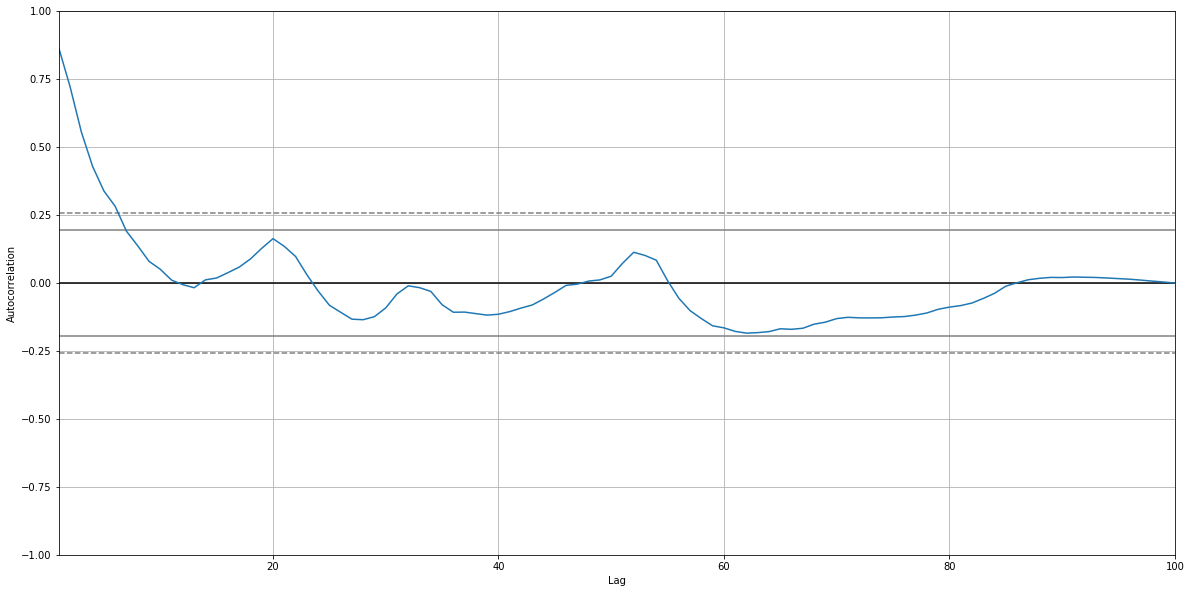

In [85]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(marag_df[:100])
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

In [98]:
from statsmodels.tsa.arima_model import AR
reg_AR = AR(y_train)
reg_AR_fit = reg_AR.fit(maxlag=48)
y_dev_hat = reg_AR_fit.predict(start=y_dev[:1].index[0], end=y_dev[-1:].index[0])
#y_dev_hat =  walk_forward_validation(X_train, y_train, X_dev, 48, reg_kn)

/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


In [101]:
RMSE = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
r2 = r2_score(y_dev, y_dev_hat)
r2_adjusted_test = 1 - (1-r2_score(y_dev, y_dev_hat))*(len(y_dev)-1)/(len(y_dev)-X_test.shape[1]-1)
RMSE, r2, r2_adjusted_test

(140.27997471241045, -0.017194480625673636, -0.023791607374765933)

## Autoregression Moving Average (ARIMA) 

/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.TotalEntries   No. Observations:                22347
Model:                 ARIMA(6, 1, 0)   Log Likelihood             -116666.090
Method:                       css-mle   S.D. of innovations             44.778
Date:                Sun, 14 Apr 2019   AIC                         233348.180
Time:                        17:07:40   BIC                         233412.295
Sample:                    01-10-2017   HQIC                        233369.044
                         - 04-20-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0147      0.379      0.039      0.969      -0.728       0.757
ar.L1.D.TotalEntries     0.1140      0.007     17.108      0.000       0.101       0.127
ar.L2.D.Tota

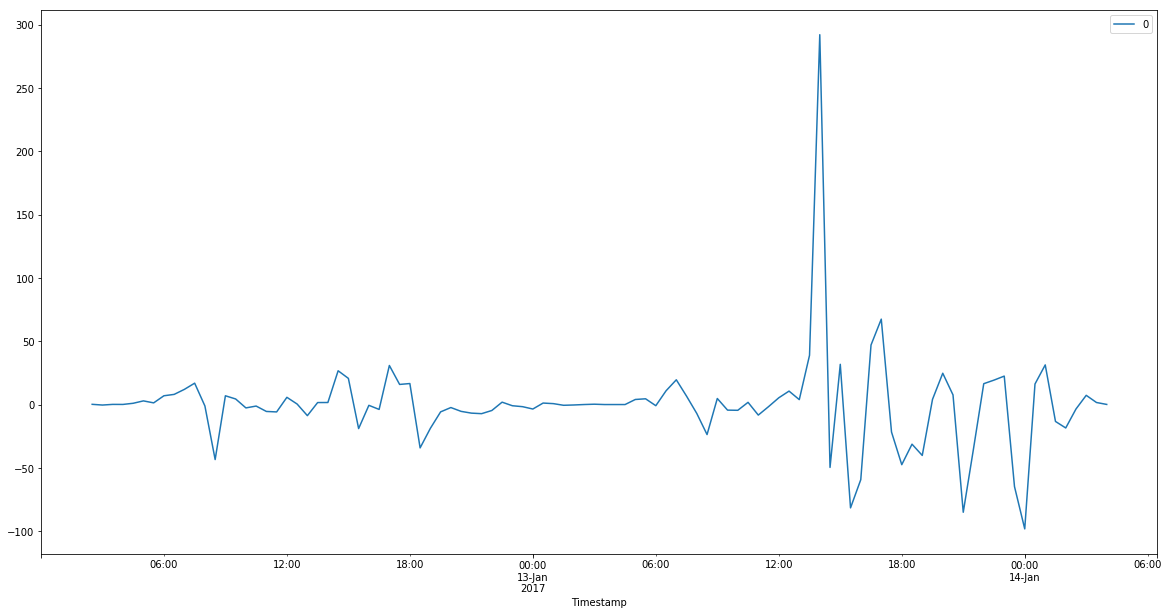

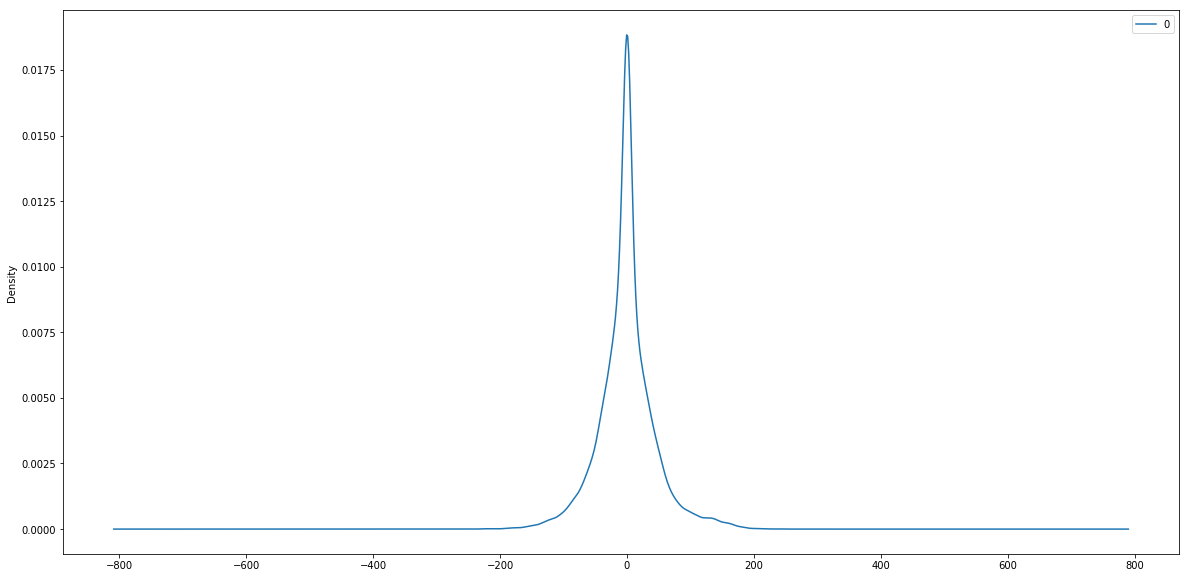

In [120]:
from statsmodels.tsa.arima_model import ARIMA
reg_ARIMA = ARIMA(y_train, order=(6, 1, 0))
reg_ARIMA_fit = reg_ARIMA.fit(disp=0) 
y_dev_hat = reg_ARIMA_fit.predict(start=y_dev[:1].index[0], end=y_dev[-1:].index[0], typ='levels')
output = reg_ARIMA_fit.forecast()

print(reg_ARIMA_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(reg_ARIMA_fit.resid)
residuals[100:200].plot()
#pyplot.show()
# density plot of residuals
residuals.plot(kind= ' kde ' )
#pyplot.show()
# summary stats of residuals
print(residuals.describe())


In [118]:
output

(array([329.04557515]),
 array([44.77779109]),
 array([[241.28271731, 416.80843299]]))

In [122]:
y_dev_hat[0]

329.0455751484883

In [121]:
RMSE = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
r2 = r2_score(y_dev, y_dev_hat)
r2_adjusted_test = 1 - (1-r2_score(y_dev, y_dev_hat))*(len(y_dev)-1)/(len(y_dev)-X_test.shape[1]-1)
RMSE, r2, r2_adjusted_test

(252.72116505917916, -2.3013826699545987, -2.322794150586651)

In [128]:
from statsmodels.tsa.arima_model import ARIMA

def ARIMA_walk_forward_validation(y_train, X_test):

    '''This function integrates a walk-forward validation method for multiple models.
    Parameters: model, #lags, train data, test data, length of test_data'''
    reg_ARIMA = ARIMA(y_train, order=(6, 1, 0))
    reg_ARIMA_fit = reg_ARIMA.fit(disp=0) 
    X_grow = X_train_raw.astype('float64').sort_index()
    y_grow_hat = []
    for i in tqdm(range(len(X_test))):
        y_hat = reg_ARIMA_fit.forecast()[0]
        y_grow_hat.append(y_hat)
        y_hat = pd.DataFrame(y_hat, index=X_test[i:(i+1)].index, columns=['TotalEntries'])
        X_grow = pd.concat([X_grow, y_hat])
        reg_ARIMA = ARIMA(X_grow, order=(6,1,0))
        reg_ARIMA_fit = reg_ARIMA.fit(disp=0)
        #y_hat_trans = create_lags(pd.DataFrame(y_hat), 49)
        #X_grow = pd.concat(X_grow, y_hat_trans)
        #model.fit(X_grow)
    
    
    return y_grow_hat


In [ ]:
y_dev_hat = ARIMA_walk_forward_validation(X_train, y_train, X_dev)

/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


  0%|          | 0/7450 [00:00<?, ?it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', Va



  0%|          | 13/7450 [00:04<43:13,  2.87it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  0%|          | 14/7450 [00:05<43:31,  2.85it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels



  0%|          | 27/7450 [00:09<41:33,  2.98it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  0%|          | 28/7450 [00:09<40:51,  3.03it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels



  1%|          | 41/7450 [00:14<41:50,  2.95it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  1%|          | 42/7450 [00:14<42:53,  2.88it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels



  1%|          | 55/7450 [00:19<44:52,  2.75it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  1%|          | 56/7450 [00:19<46:28,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels



  1%|          | 69/7450 [00:24<47:38,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  1%|          | 70/7450 [00:25<46:45,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels



  1%|          | 83/7450 [00:29<43:06,  2.85it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  1%|          | 84/7450 [00:30<44:17,  2.77it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels



  1%|▏         | 97/7450 [00:34<41:56,  2.92it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  1%|▏         | 98/7450 [00:35<41:25,  2.96it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels



  1%|▏         | 111/7450 [00:41<1:03:37,  1.92it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  2%|▏         | 112/7450 [00:42<1:05:23,  1.87it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/stats



  2%|▏         | 125/7450 [00:49<1:06:34,  1.83it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  2%|▏         | 126/7450 [00:49<1:05:56,  1.85it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/stats



  2%|▏         | 139/7450 [00:56<1:03:19,  1.92it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  2%|▏         | 140/7450 [00:57<1:02:42,  1.94it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/stats



  2%|▏         | 153/7450 [01:03<1:03:35,  1.91it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  2%|▏         | 154/7450 [01:04<1:04:27,  1.89it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/stats



  2%|▏         | 167/7450 [01:11<1:01:19,  1.98it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  2%|▏         | 168/7450 [01:11<59:59,  2.02it/s]  /home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/stats



  2%|▏         | 181/7450 [01:18<1:00:03,  2.02it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  2%|▏         | 182/7450 [01:18<59:03,  2.05it/s]  /home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/stats



  3%|▎         | 195/7450 [01:25<59:07,  2.05it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  3%|▎         | 196/7450 [01:25<58:31,  2.07it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  3%|▎         | 209/7450 [01:32<59:19,  2.03it/s]  /home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  3%|▎         | 210/7450 [01:32<58:34,  2.06it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



  3%|▎         | 223/7450 [01:39<59:42,  2.02it/s]  /home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  3%|▎         | 224/7450 [01:39<59:11,  2.03it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



  3%|▎         | 237/7450 [01:45<59:47,  2.01it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  3%|▎         | 238/7450 [01:46<1:00:41,  1.98it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



  3%|▎         | 251/7450 [01:52<1:02:03,  1.93it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  3%|▎         | 252/7450 [01:53<1:00:38,  1.98it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/stats



  4%|▎         | 265/7450 [01:59<55:39,  2.15it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  4%|▎         | 266/7450 [02:00<56:11,  2.13it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  4%|▎         | 279/7450 [02:06<56:19,  2.12it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  4%|▍         | 280/7450 [02:06<58:43,  2.03it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  4%|▍         | 293/7450 [02:13<56:34,  2.11it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  4%|▍         | 294/7450 [02:13<56:08,  2.12it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  4%|▍         | 307/7450 [02:19<55:54,  2.13it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  4%|▍         | 308/7450 [02:20<56:29,  2.11it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  4%|▍         | 321/7450 [02:26<55:27,  2.14it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  4%|▍         | 322/7450 [02:26<54:18,  2.19it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  4%|▍         | 335/7450 [02:32<52:28,  2.26it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  5%|▍         | 336/7450 [02:32<58:17,  2.03it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  5%|▍         | 349/7450 [02:38<56:18,  2.10it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  5%|▍         | 350/7450 [02:39<56:18,  2.10it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  5%|▍         | 363/7450 [02:45<54:33,  2.16it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  5%|▍         | 364/7450 [02:45<53:51,  2.19it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  5%|▌         | 377/7450 [02:51<51:45,  2.28it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  5%|▌         | 378/7450 [02:51<50:50,  2.32it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  5%|▌         | 391/7450 [02:57<53:58,  2.18it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  5%|▌         | 392/7450 [02:58<53:50,  2.18it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  5%|▌         | 405/7450 [03:03<53:02,  2.21it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  5%|▌         | 406/7450 [03:04<51:48,  2.27it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  6%|▌         | 419/7450 [03:09<49:43,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  6%|▌         | 420/7450 [03:10<50:45,  2.31it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  6%|▌         | 433/7450 [03:16<55:14,  2.12it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  6%|▌         | 434/7450 [03:17<55:45,  2.10it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  6%|▌         | 447/7450 [03:22<50:39,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  6%|▌         | 448/7450 [03:23<51:15,  2.28it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  6%|▌         | 461/7450 [03:28<52:19,  2.23it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  6%|▌         | 462/7450 [03:29<51:35,  2.26it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  6%|▋         | 475/7450 [03:35<52:14,  2.23it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  6%|▋         | 476/7450 [03:35<50:30,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  7%|▋         | 489/7450 [03:40<49:27,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  7%|▋         | 490/7450 [03:41<49:26,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  7%|▋         | 503/7450 [03:47<50:45,  2.28it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  7%|▋         | 504/7450 [03:47<51:00,  2.27it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  7%|▋         | 517/7450 [03:53<50:20,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  7%|▋         | 518/7450 [03:53<49:58,  2.31it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  7%|▋         | 531/7450 [03:59<51:32,  2.24it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  7%|▋         | 532/7450 [03:59<52:39,  2.19it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  7%|▋         | 545/7450 [04:05<52:11,  2.20it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  7%|▋         | 546/7450 [04:05<52:18,  2.20it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  8%|▊         | 559/7450 [04:11<50:03,  2.29it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  8%|▊         | 560/7450 [04:11<49:03,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  8%|▊         | 573/7450 [04:17<47:38,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  8%|▊         | 574/7450 [04:17<48:17,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  8%|▊         | 587/7450 [04:23<48:43,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  8%|▊         | 588/7450 [04:23<47:46,  2.39it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  8%|▊         | 601/7450 [04:29<49:35,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  8%|▊         | 602/7450 [04:29<51:24,  2.22it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  8%|▊         | 615/7450 [04:35<50:01,  2.28it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  8%|▊         | 616/7450 [04:35<48:11,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  8%|▊         | 629/7450 [04:41<47:56,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  8%|▊         | 630/7450 [04:41<47:47,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  9%|▊         | 643/7450 [04:46<45:10,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  9%|▊         | 644/7450 [04:47<45:22,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  9%|▉         | 657/7450 [04:52<46:13,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  9%|▉         | 658/7450 [04:52<46:53,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  9%|▉         | 671/7450 [04:58<45:37,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  9%|▉         | 672/7450 [04:58<45:11,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  9%|▉         | 685/7450 [05:04<47:36,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  9%|▉         | 686/7450 [05:04<46:56,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



  9%|▉         | 699/7450 [05:10<50:02,  2.25it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  9%|▉         | 700/7450 [05:10<49:14,  2.28it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 10%|▉         | 713/7450 [05:16<49:12,  2.28it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 10%|▉         | 714/7450 [05:16<49:00,  2.29it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 10%|▉         | 727/7450 [05:23<48:44,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 10%|▉         | 728/7450 [05:23<48:18,  2.32it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 10%|▉         | 741/7450 [05:29<51:10,  2.19it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 10%|▉         | 742/7450 [05:29<51:20,  2.18it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 10%|█         | 755/7450 [05:35<57:58,  1.92it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 10%|█         | 756/7450 [05:36<59:13,  1.88it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 10%|█         | 769/7450 [05:42<48:34,  2.29it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 10%|█         | 770/7450 [05:42<47:26,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 11%|█         | 783/7450 [05:49<53:31,  2.08it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 11%|█         | 784/7450 [05:49<52:39,  2.11it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 11%|█         | 797/7450 [05:55<53:37,  2.07it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 11%|█         | 798/7450 [05:56<51:40,  2.15it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 11%|█         | 811/7450 [06:01<50:07,  2.21it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 11%|█         | 812/7450 [06:02<50:23,  2.20it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 11%|█         | 825/7450 [06:07<47:01,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 11%|█         | 826/7450 [06:08<46:28,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 11%|█▏        | 839/7450 [06:14<51:13,  2.15it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 11%|█▏        | 840/7450 [06:14<53:08,  2.07it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 11%|█▏        | 853/7450 [06:20<49:21,  2.23it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 11%|█▏        | 854/7450 [06:21<50:07,  2.19it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 12%|█▏        | 867/7450 [06:27<53:58,  2.03it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 12%|█▏        | 868/7450 [06:28<52:06,  2.11it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 12%|█▏        | 881/7450 [06:33<45:00,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 12%|█▏        | 882/7450 [06:34<45:16,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 12%|█▏        | 895/7450 [06:40<51:11,  2.13it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 12%|█▏        | 896/7450 [06:41<47:56,  2.28it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 12%|█▏        | 909/7450 [06:46<41:26,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 12%|█▏        | 910/7450 [06:46<41:41,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 12%|█▏        | 923/7450 [06:51<42:30,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 12%|█▏        | 924/7450 [06:52<45:16,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 13%|█▎        | 937/7450 [06:57<42:43,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 13%|█▎        | 938/7450 [06:58<41:45,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 13%|█▎        | 951/7450 [07:03<49:36,  2.18it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 13%|█▎        | 952/7450 [07:04<50:05,  2.16it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 13%|█▎        | 965/7450 [07:09<43:51,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 13%|█▎        | 966/7450 [07:10<44:37,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 13%|█▎        | 979/7450 [07:16<54:59,  1.96it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 13%|█▎        | 980/7450 [07:16<52:39,  2.05it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 13%|█▎        | 993/7450 [07:22<49:47,  2.16it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 13%|█▎        | 994/7450 [07:22<48:30,  2.22it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmode



 14%|█▎        | 1007/7450 [07:28<41:32,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 14%|█▎        | 1008/7450 [07:28<42:43,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 14%|█▎        | 1021/7450 [07:33<44:23,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 14%|█▎        | 1022/7450 [07:34<43:54,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 14%|█▍        | 1035/7450 [07:39<57:48,  1.85it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 14%|█▍        | 1036/7450 [07:40<53:31,  2.00it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 14%|█▍        | 1049/7450 [07:46<45:32,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 14%|█▍        | 1050/7450 [07:46<47:25,  2.25it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 14%|█▍        | 1063/7450 [07:51<42:15,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 14%|█▍        | 1064/7450 [07:51<41:38,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 14%|█▍        | 1077/7450 [07:57<46:04,  2.31it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 14%|█▍        | 1078/7450 [07:57<44:44,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 15%|█▍        | 1091/7450 [08:02<40:37,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 15%|█▍        | 1092/7450 [08:03<39:42,  2.67it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 15%|█▍        | 1105/7450 [08:08<40:01,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 15%|█▍        | 1106/7450 [08:08<41:05,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 15%|█▌        | 1119/7450 [08:13<42:56,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 15%|█▌        | 1120/7450 [08:14<42:18,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 15%|█▌        | 1133/7450 [08:19<42:21,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 15%|█▌        | 1134/7450 [08:19<40:59,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 15%|█▌        | 1147/7450 [08:25<42:08,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 15%|█▌        | 1148/7450 [08:25<42:00,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 16%|█▌        | 1161/7450 [08:30<42:37,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 16%|█▌        | 1162/7450 [08:31<41:34,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 16%|█▌        | 1175/7450 [08:36<43:03,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 16%|█▌        | 1176/7450 [08:36<41:52,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 16%|█▌        | 1189/7450 [08:41<40:33,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 16%|█▌        | 1190/7450 [08:42<41:15,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 16%|█▌        | 1203/7450 [08:47<40:10,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 16%|█▌        | 1204/7450 [08:47<39:37,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 16%|█▋        | 1217/7450 [08:52<40:13,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 16%|█▋        | 1218/7450 [08:53<40:53,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 17%|█▋        | 1231/7450 [08:58<40:43,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 17%|█▋        | 1232/7450 [08:58<40:23,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 17%|█▋        | 1245/7450 [09:03<40:32,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 17%|█▋        | 1246/7450 [09:04<39:57,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 17%|█▋        | 1259/7450 [09:09<39:39,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 17%|█▋        | 1260/7450 [09:09<39:15,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 17%|█▋        | 1273/7450 [09:14<40:30,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 17%|█▋        | 1274/7450 [09:15<39:30,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 17%|█▋        | 1287/7450 [09:20<40:13,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 17%|█▋        | 1288/7450 [09:20<39:59,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 17%|█▋        | 1301/7450 [09:25<43:18,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 17%|█▋        | 1302/7450 [09:26<42:38,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 18%|█▊        | 1315/7450 [09:30<40:15,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 18%|█▊        | 1316/7450 [09:31<40:15,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 18%|█▊        | 1329/7450 [09:36<38:11,  2.67it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 18%|█▊        | 1330/7450 [09:36<38:04,  2.68it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 18%|█▊        | 1343/7450 [09:41<40:12,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 18%|█▊        | 1344/7450 [09:42<39:31,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 18%|█▊        | 1357/7450 [09:47<44:11,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 18%|█▊        | 1358/7450 [09:47<41:45,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 18%|█▊        | 1371/7450 [09:52<39:16,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 18%|█▊        | 1372/7450 [09:53<38:34,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 19%|█▊        | 1385/7450 [09:58<38:11,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 19%|█▊        | 1386/7450 [09:58<38:00,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 19%|█▉        | 1399/7450 [10:03<38:04,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 19%|█▉        | 1400/7450 [10:03<38:13,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 19%|█▉        | 1413/7450 [10:08<37:02,  2.72it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 19%|█▉        | 1414/7450 [10:09<37:53,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 19%|█▉        | 1427/7450 [10:13<38:02,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 19%|█▉        | 1428/7450 [10:14<37:16,  2.69it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 19%|█▉        | 1441/7450 [10:19<37:49,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 19%|█▉        | 1442/7450 [10:19<38:13,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 20%|█▉        | 1455/7450 [10:24<38:31,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 20%|█▉        | 1456/7450 [10:24<38:11,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 20%|█▉        | 1469/7450 [10:29<38:56,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 20%|█▉        | 1470/7450 [10:30<37:51,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 20%|█▉        | 1483/7450 [10:35<38:46,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 20%|█▉        | 1484/7450 [10:35<38:15,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 20%|██        | 1497/7450 [10:40<38:08,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 20%|██        | 1498/7450 [10:41<38:26,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 20%|██        | 1511/7450 [10:46<38:48,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 20%|██        | 1512/7450 [10:46<39:28,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 20%|██        | 1525/7450 [10:51<38:00,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 20%|██        | 1526/7450 [10:51<37:44,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 21%|██        | 1539/7450 [10:56<37:52,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 21%|██        | 1540/7450 [10:57<36:58,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 21%|██        | 1553/7450 [11:01<37:02,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 21%|██        | 1554/7450 [11:02<38:11,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 21%|██        | 1567/7450 [11:07<37:14,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 21%|██        | 1568/7450 [11:07<36:23,  2.69it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 21%|██        | 1581/7450 [11:12<38:09,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 21%|██        | 1582/7450 [11:12<38:09,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 21%|██▏       | 1595/7450 [11:17<38:25,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 21%|██▏       | 1596/7450 [11:18<37:57,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 22%|██▏       | 1609/7450 [11:23<39:16,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 22%|██▏       | 1610/7450 [11:23<38:26,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 22%|██▏       | 1623/7450 [11:28<39:01,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 22%|██▏       | 1624/7450 [11:29<38:37,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 22%|██▏       | 1637/7450 [11:34<37:25,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 22%|██▏       | 1638/7450 [11:34<36:45,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 22%|██▏       | 1651/7450 [11:39<36:31,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 22%|██▏       | 1652/7450 [11:40<37:05,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 22%|██▏       | 1665/7450 [11:45<38:48,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 22%|██▏       | 1666/7450 [11:45<38:28,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 23%|██▎       | 1679/7450 [11:50<37:34,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 23%|██▎       | 1680/7450 [11:51<38:43,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 23%|██▎       | 1693/7450 [11:56<37:11,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 23%|██▎       | 1694/7450 [11:56<36:44,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 23%|██▎       | 1707/7450 [12:01<34:47,  2.75it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 23%|██▎       | 1708/7450 [12:01<34:56,  2.74it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 23%|██▎       | 1721/7450 [12:07<38:10,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 23%|██▎       | 1722/7450 [12:07<36:41,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 23%|██▎       | 1735/7450 [12:12<36:50,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 23%|██▎       | 1736/7450 [12:13<36:52,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 23%|██▎       | 1749/7450 [12:18<36:43,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 23%|██▎       | 1750/7450 [12:18<35:41,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 24%|██▎       | 1763/7450 [12:23<35:56,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 24%|██▎       | 1764/7450 [12:24<36:21,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 24%|██▍       | 1777/7450 [12:28<38:52,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 24%|██▍       | 1778/7450 [12:29<37:49,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 24%|██▍       | 1791/7450 [12:34<34:07,  2.76it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 24%|██▍       | 1792/7450 [12:34<35:39,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 24%|██▍       | 1805/7450 [12:39<35:40,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 24%|██▍       | 1806/7450 [12:39<35:26,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 24%|██▍       | 1819/7450 [12:45<37:17,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 24%|██▍       | 1820/7450 [12:45<37:09,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 25%|██▍       | 1833/7450 [12:51<47:35,  1.97it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 25%|██▍       | 1834/7450 [12:52<44:12,  2.12it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 25%|██▍       | 1847/7450 [12:57<37:15,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 25%|██▍       | 1848/7450 [12:57<37:29,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 25%|██▍       | 1861/7450 [13:02<37:00,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 25%|██▍       | 1862/7450 [13:03<36:10,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 25%|██▌       | 1875/7450 [13:08<36:14,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 25%|██▌       | 1876/7450 [13:08<36:00,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 25%|██▌       | 1889/7450 [13:13<35:17,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 25%|██▌       | 1890/7450 [13:13<35:53,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 26%|██▌       | 1903/7450 [13:18<36:54,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 26%|██▌       | 1904/7450 [13:19<35:49,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 26%|██▌       | 1917/7450 [13:24<34:12,  2.70it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 26%|██▌       | 1918/7450 [13:24<36:09,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 26%|██▌       | 1931/7450 [13:29<37:19,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 26%|██▌       | 1932/7450 [13:30<37:13,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 26%|██▌       | 1945/7450 [13:35<36:41,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 26%|██▌       | 1946/7450 [13:35<37:17,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 26%|██▋       | 1959/7450 [13:40<35:07,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 26%|██▋       | 1960/7450 [13:41<36:04,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 26%|██▋       | 1973/7450 [13:46<35:42,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 26%|██▋       | 1974/7450 [13:46<35:39,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 27%|██▋       | 1987/7450 [13:51<36:31,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 27%|██▋       | 1988/7450 [13:52<35:22,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 27%|██▋       | 2001/7450 [13:57<44:39,  2.03it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 27%|██▋       | 2002/7450 [13:57<40:58,  2.22it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 27%|██▋       | 2015/7450 [14:03<35:45,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 27%|██▋       | 2016/7450 [14:03<35:13,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 27%|██▋       | 2029/7450 [14:08<34:10,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 27%|██▋       | 2030/7450 [14:08<37:35,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 27%|██▋       | 2043/7450 [14:13<33:52,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 27%|██▋       | 2044/7450 [14:14<34:44,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 28%|██▊       | 2057/7450 [14:19<34:15,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 28%|██▊       | 2058/7450 [14:19<34:08,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 28%|██▊       | 2071/7450 [14:24<33:53,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 28%|██▊       | 2072/7450 [14:24<33:19,  2.69it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 28%|██▊       | 2085/7450 [14:29<33:20,  2.68it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 28%|██▊       | 2086/7450 [14:30<33:27,  2.67it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 28%|██▊       | 2099/7450 [14:35<32:20,  2.76it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 28%|██▊       | 2100/7450 [14:35<33:47,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 28%|██▊       | 2113/7450 [14:40<34:43,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 28%|██▊       | 2114/7450 [14:40<34:15,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 29%|██▊       | 2127/7450 [14:45<33:10,  2.67it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 29%|██▊       | 2128/7450 [14:46<32:40,  2.71it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 29%|██▊       | 2141/7450 [14:50<32:54,  2.69it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 29%|██▉       | 2142/7450 [14:51<33:27,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 29%|██▉       | 2155/7450 [14:56<32:40,  2.70it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 29%|██▉       | 2156/7450 [14:56<33:16,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 29%|██▉       | 2169/7450 [15:01<32:51,  2.68it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 29%|██▉       | 2170/7450 [15:01<33:22,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 29%|██▉       | 2183/7450 [15:06<32:23,  2.71it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 29%|██▉       | 2184/7450 [15:07<33:01,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 29%|██▉       | 2197/7450 [15:12<32:44,  2.67it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 30%|██▉       | 2198/7450 [15:12<32:23,  2.70it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 30%|██▉       | 2211/7450 [15:17<33:32,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 30%|██▉       | 2212/7450 [15:17<34:38,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 30%|██▉       | 2225/7450 [15:22<33:26,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 30%|██▉       | 2226/7450 [15:23<33:32,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 30%|███       | 2239/7450 [15:28<32:46,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 30%|███       | 2240/7450 [15:28<32:47,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 30%|███       | 2253/7450 [15:33<33:42,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 30%|███       | 2254/7450 [15:33<33:27,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 30%|███       | 2267/7450 [15:38<32:34,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 30%|███       | 2268/7450 [15:39<33:14,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 31%|███       | 2281/7450 [15:44<35:03,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 31%|███       | 2282/7450 [15:44<34:22,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 31%|███       | 2295/7450 [15:49<33:09,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 31%|███       | 2296/7450 [15:50<32:59,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 31%|███       | 2309/7450 [15:55<32:37,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 31%|███       | 2310/7450 [15:55<32:35,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 31%|███       | 2323/7450 [16:00<32:45,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 31%|███       | 2324/7450 [16:00<32:36,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 31%|███▏      | 2337/7450 [16:05<31:51,  2.67it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 31%|███▏      | 2338/7450 [16:06<32:01,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 32%|███▏      | 2351/7450 [16:11<32:21,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 32%|███▏      | 2352/7450 [16:11<32:27,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 32%|███▏      | 2365/7450 [16:16<33:51,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 32%|███▏      | 2366/7450 [16:17<32:51,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 32%|███▏      | 2379/7450 [16:22<31:56,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 32%|███▏      | 2380/7450 [16:22<31:58,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 32%|███▏      | 2393/7450 [16:27<32:11,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 32%|███▏      | 2394/7450 [16:27<31:30,  2.68it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 32%|███▏      | 2407/7450 [16:32<30:50,  2.72it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 32%|███▏      | 2408/7450 [16:32<31:07,  2.70it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 32%|███▏      | 2421/7450 [16:37<32:18,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 33%|███▎      | 2422/7450 [16:38<32:06,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 33%|███▎      | 2435/7450 [16:43<33:43,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 33%|███▎      | 2436/7450 [16:43<33:46,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 33%|███▎      | 2449/7450 [16:48<31:27,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 33%|███▎      | 2450/7450 [16:49<31:25,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 33%|███▎      | 2463/7450 [16:54<33:04,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 33%|███▎      | 2464/7450 [16:54<32:38,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 33%|███▎      | 2477/7450 [16:59<32:54,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 33%|███▎      | 2478/7450 [17:00<33:35,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 33%|███▎      | 2491/7450 [17:05<33:47,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 33%|███▎      | 2492/7450 [17:05<34:51,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 34%|███▎      | 2505/7450 [17:10<30:59,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 34%|███▎      | 2506/7450 [17:11<31:01,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 34%|███▍      | 2519/7450 [17:16<31:08,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 34%|███▍      | 2520/7450 [17:16<31:33,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 34%|███▍      | 2533/7450 [17:21<31:35,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 34%|███▍      | 2534/7450 [17:21<31:30,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 34%|███▍      | 2547/7450 [17:26<31:30,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 34%|███▍      | 2548/7450 [17:27<30:54,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 34%|███▍      | 2561/7450 [17:32<31:19,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 34%|███▍      | 2562/7450 [17:32<31:12,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 35%|███▍      | 2575/7450 [17:37<32:37,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 35%|███▍      | 2576/7450 [17:38<33:29,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 35%|███▍      | 2589/7450 [17:43<31:59,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 35%|███▍      | 2590/7450 [17:43<31:28,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 35%|███▍      | 2603/7450 [17:48<30:48,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 35%|███▍      | 2604/7450 [17:49<30:51,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 35%|███▌      | 2617/7450 [17:54<34:37,  2.33it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 35%|███▌      | 2618/7450 [17:55<33:39,  2.39it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 35%|███▌      | 2631/7450 [18:00<35:38,  2.25it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 35%|███▌      | 2632/7450 [18:00<34:13,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 36%|███▌      | 2645/7450 [18:06<30:39,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 36%|███▌      | 2646/7450 [18:06<30:09,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 36%|███▌      | 2659/7450 [18:11<30:17,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 36%|███▌      | 2660/7450 [18:11<30:22,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 36%|███▌      | 2673/7450 [18:16<30:50,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 36%|███▌      | 2674/7450 [18:17<30:40,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 36%|███▌      | 2687/7450 [18:22<31:54,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 36%|███▌      | 2688/7450 [18:22<31:28,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 36%|███▋      | 2701/7450 [18:27<31:09,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 36%|███▋      | 2702/7450 [18:28<30:24,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 36%|███▋      | 2715/7450 [18:33<31:10,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 36%|███▋      | 2716/7450 [18:33<31:48,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 37%|███▋      | 2729/7450 [18:38<31:47,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 37%|███▋      | 2730/7450 [18:39<32:21,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 37%|███▋      | 2743/7450 [18:44<29:54,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 37%|███▋      | 2744/7450 [18:44<29:37,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 37%|███▋      | 2757/7450 [18:50<33:25,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 37%|███▋      | 2758/7450 [18:50<31:58,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 37%|███▋      | 2771/7450 [18:55<31:28,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 37%|███▋      | 2772/7450 [18:55<31:55,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 37%|███▋      | 2785/7450 [19:01<30:30,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 37%|███▋      | 2786/7450 [19:01<30:26,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 38%|███▊      | 2799/7450 [19:06<29:59,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 38%|███▊      | 2800/7450 [19:06<31:03,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 38%|███▊      | 2813/7450 [19:12<29:16,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 38%|███▊      | 2814/7450 [19:12<29:45,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 38%|███▊      | 2827/7450 [19:17<29:22,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 38%|███▊      | 2828/7450 [19:17<28:55,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 38%|███▊      | 2841/7450 [19:22<30:50,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 38%|███▊      | 2842/7450 [19:23<29:57,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 38%|███▊      | 2855/7450 [19:28<30:49,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 38%|███▊      | 2856/7450 [19:28<32:08,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 39%|███▊      | 2869/7450 [19:34<30:00,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 39%|███▊      | 2870/7450 [19:34<30:01,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 39%|███▊      | 2883/7450 [19:39<31:36,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 39%|███▊      | 2884/7450 [19:40<31:42,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 39%|███▉      | 2897/7450 [19:45<31:04,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 39%|███▉      | 2898/7450 [19:45<30:12,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 39%|███▉      | 2911/7450 [19:50<29:57,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 39%|███▉      | 2912/7450 [19:51<29:55,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 39%|███▉      | 2925/7450 [19:56<30:15,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 39%|███▉      | 2926/7450 [19:56<30:03,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 39%|███▉      | 2939/7450 [20:02<30:18,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 39%|███▉      | 2940/7450 [20:02<31:00,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 40%|███▉      | 2953/7450 [20:07<29:12,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 40%|███▉      | 2954/7450 [20:08<30:23,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 40%|███▉      | 2967/7450 [20:13<29:40,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 40%|███▉      | 2968/7450 [20:13<30:34,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 40%|████      | 2981/7450 [20:18<28:57,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 40%|████      | 2982/7450 [20:19<28:30,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 40%|████      | 2995/7450 [20:24<31:34,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 40%|████      | 2996/7450 [20:24<31:29,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 40%|████      | 3009/7450 [20:29<30:46,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 40%|████      | 3010/7450 [20:30<30:37,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 41%|████      | 3023/7450 [20:35<28:33,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 41%|████      | 3024/7450 [20:35<29:04,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 41%|████      | 3037/7450 [20:41<32:25,  2.27it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 41%|████      | 3038/7450 [20:41<31:20,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 41%|████      | 3051/7450 [20:47<29:22,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 41%|████      | 3052/7450 [20:47<31:00,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 41%|████      | 3065/7450 [20:52<29:08,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 41%|████      | 3066/7450 [20:53<28:26,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 41%|████▏     | 3079/7450 [20:58<27:40,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 41%|████▏     | 3080/7450 [20:58<27:46,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 42%|████▏     | 3093/7450 [21:03<28:30,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 42%|████▏     | 3094/7450 [21:04<27:54,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 42%|████▏     | 3107/7450 [21:09<28:06,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 42%|████▏     | 3108/7450 [21:09<27:59,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 42%|████▏     | 3121/7450 [21:14<27:49,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 42%|████▏     | 3122/7450 [21:15<27:46,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 42%|████▏     | 3135/7450 [21:20<27:23,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 42%|████▏     | 3136/7450 [21:20<27:32,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 42%|████▏     | 3149/7450 [21:25<28:37,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 42%|████▏     | 3150/7450 [21:25<28:13,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 42%|████▏     | 3163/7450 [21:30<27:31,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 42%|████▏     | 3164/7450 [21:31<27:27,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 43%|████▎     | 3177/7450 [21:36<28:46,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 43%|████▎     | 3178/7450 [21:36<28:15,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 43%|████▎     | 3191/7450 [21:42<28:03,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 43%|████▎     | 3192/7450 [21:42<27:18,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 43%|████▎     | 3205/7450 [21:47<27:43,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 43%|████▎     | 3206/7450 [21:47<27:01,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 43%|████▎     | 3219/7450 [21:53<28:53,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 43%|████▎     | 3220/7450 [21:53<28:43,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 43%|████▎     | 3233/7450 [21:58<26:33,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 43%|████▎     | 3234/7450 [21:58<26:36,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 44%|████▎     | 3247/7450 [22:03<26:45,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 44%|████▎     | 3248/7450 [22:04<27:38,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 44%|████▍     | 3261/7450 [22:09<26:51,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 44%|████▍     | 3262/7450 [22:09<26:45,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 44%|████▍     | 3275/7450 [22:14<26:37,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 44%|████▍     | 3276/7450 [22:14<26:34,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 44%|████▍     | 3289/7450 [22:19<26:44,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 44%|████▍     | 3290/7450 [22:20<26:10,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 44%|████▍     | 3303/7450 [22:25<27:36,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 44%|████▍     | 3304/7450 [22:25<31:23,  2.20it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 45%|████▍     | 3317/7450 [22:30<26:18,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 45%|████▍     | 3318/7450 [22:31<27:30,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 45%|████▍     | 3331/7450 [22:36<26:11,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 45%|████▍     | 3332/7450 [22:36<26:07,  2.63it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 45%|████▍     | 3345/7450 [22:41<26:22,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 45%|████▍     | 3346/7450 [22:42<25:46,  2.65it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 45%|████▌     | 3359/7450 [22:47<27:03,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 45%|████▌     | 3360/7450 [22:47<26:15,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 45%|████▌     | 3373/7450 [22:53<30:49,  2.20it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 45%|████▌     | 3374/7450 [22:53<30:49,  2.20it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 45%|████▌     | 3387/7450 [22:59<28:42,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 45%|████▌     | 3388/7450 [22:59<29:12,  2.32it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 46%|████▌     | 3401/7450 [23:04<26:36,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 46%|████▌     | 3402/7450 [23:05<26:06,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 46%|████▌     | 3415/7450 [23:10<26:45,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 46%|████▌     | 3416/7450 [23:10<27:04,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 46%|████▌     | 3429/7450 [23:15<28:49,  2.32it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 46%|████▌     | 3430/7450 [23:16<27:57,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 46%|████▌     | 3443/7450 [23:21<32:31,  2.05it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 46%|████▌     | 3444/7450 [23:22<35:21,  1.89it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 46%|████▋     | 3457/7450 [23:27<27:37,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 46%|████▋     | 3458/7450 [23:28<26:55,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 47%|████▋     | 3471/7450 [23:33<25:21,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 47%|████▋     | 3472/7450 [23:33<25:19,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 47%|████▋     | 3485/7450 [23:38<27:19,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 47%|████▋     | 3486/7450 [23:39<28:01,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 47%|████▋     | 3499/7450 [23:44<26:36,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 47%|████▋     | 3500/7450 [23:45<27:10,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 47%|████▋     | 3513/7450 [23:50<25:32,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 47%|████▋     | 3514/7450 [23:50<26:20,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 47%|████▋     | 3527/7450 [23:56<27:15,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 47%|████▋     | 3528/7450 [23:56<26:11,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 48%|████▊     | 3541/7450 [24:01<25:13,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 48%|████▊     | 3542/7450 [24:02<25:34,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 48%|████▊     | 3555/7450 [24:07<25:29,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 48%|████▊     | 3556/7450 [24:07<24:56,  2.60it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 48%|████▊     | 3569/7450 [24:12<25:53,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 48%|████▊     | 3570/7450 [24:13<25:37,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 48%|████▊     | 3583/7450 [24:18<25:32,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 48%|████▊     | 3584/7450 [24:18<24:59,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 48%|████▊     | 3597/7450 [24:24<26:02,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 48%|████▊     | 3598/7450 [24:24<30:46,  2.09it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 48%|████▊     | 3611/7450 [24:29<25:41,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 48%|████▊     | 3612/7450 [24:30<25:24,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 49%|████▊     | 3625/7450 [24:35<24:49,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 49%|████▊     | 3626/7450 [24:35<24:21,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 49%|████▉     | 3639/7450 [24:40<26:51,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 49%|████▉     | 3640/7450 [24:41<26:40,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 49%|████▉     | 3653/7450 [24:46<25:27,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 49%|████▉     | 3654/7450 [24:46<25:19,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 49%|████▉     | 3667/7450 [24:52<25:58,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 49%|████▉     | 3668/7450 [24:52<25:51,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 49%|████▉     | 3681/7450 [24:57<25:22,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 49%|████▉     | 3682/7450 [24:58<25:45,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 50%|████▉     | 3695/7450 [25:03<26:56,  2.32it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 50%|████▉     | 3696/7450 [25:04<26:47,  2.33it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 50%|████▉     | 3709/7450 [25:09<25:29,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 50%|████▉     | 3710/7450 [25:09<27:21,  2.28it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 50%|████▉     | 3723/7450 [25:15<26:03,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 50%|████▉     | 3724/7450 [25:15<25:21,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 50%|█████     | 3737/7450 [25:21<25:47,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 50%|█████     | 3738/7450 [25:21<25:03,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 50%|█████     | 3751/7450 [25:27<26:56,  2.29it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 50%|█████     | 3752/7450 [25:27<26:16,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 51%|█████     | 3765/7450 [25:33<26:10,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 51%|█████     | 3766/7450 [25:33<25:48,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 51%|█████     | 3779/7450 [25:39<25:50,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 51%|█████     | 3780/7450 [25:39<24:56,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 51%|█████     | 3793/7450 [25:45<26:19,  2.32it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 51%|█████     | 3794/7450 [25:45<26:02,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 51%|█████     | 3807/7450 [25:50<24:16,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 51%|█████     | 3808/7450 [25:51<24:11,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 51%|█████▏    | 3821/7450 [25:56<24:39,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 51%|█████▏    | 3822/7450 [25:57<24:52,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 51%|█████▏    | 3835/7450 [26:02<23:47,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 51%|█████▏    | 3836/7450 [26:02<23:48,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 52%|█████▏    | 3849/7450 [26:07<24:33,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 52%|█████▏    | 3850/7450 [26:08<24:25,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 52%|█████▏    | 3863/7450 [26:13<24:45,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 52%|█████▏    | 3864/7450 [26:13<24:44,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 52%|█████▏    | 3877/7450 [26:19<23:37,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 52%|█████▏    | 3878/7450 [26:19<23:31,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 52%|█████▏    | 3891/7450 [26:24<23:16,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 52%|█████▏    | 3892/7450 [26:24<23:15,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 52%|█████▏    | 3905/7450 [26:30<24:34,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 52%|█████▏    | 3906/7450 [26:30<24:28,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 53%|█████▎    | 3919/7450 [26:35<23:24,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 53%|█████▎    | 3920/7450 [26:36<23:41,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 53%|█████▎    | 3933/7450 [26:41<23:12,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 53%|█████▎    | 3934/7450 [26:41<23:08,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 53%|█████▎    | 3947/7450 [26:46<22:47,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 53%|█████▎    | 3948/7450 [26:47<22:23,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 53%|█████▎    | 3961/7450 [26:52<23:08,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 53%|█████▎    | 3962/7450 [26:52<24:25,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 53%|█████▎    | 3975/7450 [26:58<22:31,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 53%|█████▎    | 3976/7450 [26:58<22:31,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 54%|█████▎    | 3989/7450 [27:03<24:05,  2.39it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 54%|█████▎    | 3990/7450 [27:04<23:55,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 54%|█████▎    | 4003/7450 [27:09<22:02,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 54%|█████▎    | 4004/7450 [27:09<22:08,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 54%|█████▍    | 4017/7450 [27:14<22:29,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 54%|█████▍    | 4018/7450 [27:15<22:21,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 54%|█████▍    | 4031/7450 [27:20<22:39,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 54%|█████▍    | 4032/7450 [27:20<22:47,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 54%|█████▍    | 4045/7450 [27:25<22:21,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 54%|█████▍    | 4046/7450 [27:26<22:32,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 54%|█████▍    | 4059/7450 [27:31<21:57,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 54%|█████▍    | 4060/7450 [27:31<21:53,  2.58it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 55%|█████▍    | 4073/7450 [27:36<21:26,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 55%|█████▍    | 4074/7450 [27:37<21:52,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 55%|█████▍    | 4087/7450 [27:42<21:56,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 55%|█████▍    | 4088/7450 [27:42<21:47,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 55%|█████▌    | 4101/7450 [27:47<20:40,  2.70it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 55%|█████▌    | 4102/7450 [27:48<20:52,  2.67it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 55%|█████▌    | 4115/7450 [27:53<22:25,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 55%|█████▌    | 4116/7450 [27:53<21:43,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 55%|█████▌    | 4129/7450 [27:58<22:10,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 55%|█████▌    | 4130/7450 [27:59<21:30,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 56%|█████▌    | 4143/7450 [28:04<20:44,  2.66it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 56%|█████▌    | 4144/7450 [28:04<20:49,  2.64it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 56%|█████▌    | 4157/7450 [28:09<20:55,  2.62it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 56%|█████▌    | 4158/7450 [28:09<20:59,  2.61it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 56%|█████▌    | 4171/7450 [28:15<22:21,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 56%|█████▌    | 4172/7450 [28:15<22:34,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 56%|█████▌    | 4185/7450 [28:20<21:28,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 56%|█████▌    | 4186/7450 [28:21<22:06,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 56%|█████▋    | 4199/7450 [28:26<22:36,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 56%|█████▋    | 4200/7450 [28:26<22:09,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 57%|█████▋    | 4213/7450 [28:32<20:48,  2.59it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 57%|█████▋    | 4214/7450 [28:32<21:10,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 57%|█████▋    | 4227/7450 [28:37<21:00,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 57%|█████▋    | 4228/7450 [28:38<21:50,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 57%|█████▋    | 4241/7450 [28:43<21:35,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 57%|█████▋    | 4242/7450 [28:43<21:02,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 57%|█████▋    | 4255/7450 [28:49<22:39,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 57%|█████▋    | 4256/7450 [28:49<22:26,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 57%|█████▋    | 4269/7450 [28:55<22:33,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 57%|█████▋    | 4270/7450 [28:55<21:51,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 57%|█████▋    | 4283/7450 [29:00<21:26,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 58%|█████▊    | 4284/7450 [29:01<21:06,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 58%|█████▊    | 4297/7450 [29:06<22:10,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 58%|█████▊    | 4298/7450 [29:06<22:55,  2.29it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 58%|█████▊    | 4311/7450 [29:12<21:34,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 58%|█████▊    | 4312/7450 [29:12<21:23,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 58%|█████▊    | 4325/7450 [29:18<20:39,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 58%|█████▊    | 4326/7450 [29:18<20:32,  2.54it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 58%|█████▊    | 4339/7450 [29:23<21:37,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 58%|█████▊    | 4340/7450 [29:24<21:14,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 58%|█████▊    | 4353/7450 [29:29<22:54,  2.25it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 58%|█████▊    | 4354/7450 [29:30<21:44,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 59%|█████▊    | 4367/7450 [29:35<21:20,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 59%|█████▊    | 4368/7450 [29:35<20:42,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 59%|█████▉    | 4381/7450 [29:40<21:15,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 59%|█████▉    | 4382/7450 [29:41<20:56,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 59%|█████▉    | 4395/7450 [29:46<21:12,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 59%|█████▉    | 4396/7450 [29:47<21:32,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 59%|█████▉    | 4409/7450 [29:52<22:03,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 59%|█████▉    | 4410/7450 [29:53<21:42,  2.33it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 59%|█████▉    | 4423/7450 [29:58<19:42,  2.56it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 59%|█████▉    | 4424/7450 [29:59<25:03,  2.01it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 60%|█████▉    | 4437/7450 [30:04<19:42,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 60%|█████▉    | 4438/7450 [30:04<20:25,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 60%|█████▉    | 4451/7450 [30:10<20:13,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 60%|█████▉    | 4452/7450 [30:10<20:11,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 60%|█████▉    | 4465/7450 [30:15<21:21,  2.33it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 60%|█████▉    | 4466/7450 [30:16<20:51,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 60%|██████    | 4479/7450 [30:21<21:26,  2.31it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 60%|██████    | 4480/7450 [30:22<22:02,  2.25it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 60%|██████    | 4493/7450 [30:27<20:44,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 60%|██████    | 4494/7450 [30:28<21:03,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 60%|██████    | 4507/7450 [30:33<19:43,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 61%|██████    | 4508/7450 [30:33<19:58,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 61%|██████    | 4521/7450 [30:38<19:25,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 61%|██████    | 4522/7450 [30:39<19:07,  2.55it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 61%|██████    | 4535/7450 [30:44<19:23,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 61%|██████    | 4536/7450 [30:45<19:47,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 61%|██████    | 4549/7450 [30:50<21:01,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 61%|██████    | 4550/7450 [30:51<20:41,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 61%|██████    | 4563/7450 [30:56<19:58,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 61%|██████▏   | 4564/7450 [30:56<20:14,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 61%|██████▏   | 4577/7450 [31:02<19:29,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 61%|██████▏   | 4578/7450 [31:02<19:31,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 62%|██████▏   | 4591/7450 [31:08<20:19,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 62%|██████▏   | 4592/7450 [31:08<20:04,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 62%|██████▏   | 4605/7450 [31:13<19:33,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 62%|██████▏   | 4606/7450 [31:14<19:29,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 62%|██████▏   | 4619/7450 [31:19<19:46,  2.39it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 62%|██████▏   | 4620/7450 [31:19<19:20,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 62%|██████▏   | 4633/7450 [31:25<19:10,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 62%|██████▏   | 4634/7450 [31:25<18:50,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 62%|██████▏   | 4647/7450 [31:31<19:52,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 62%|██████▏   | 4648/7450 [31:31<19:34,  2.38it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 63%|██████▎   | 4661/7450 [31:36<18:49,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 63%|██████▎   | 4662/7450 [31:37<18:48,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 63%|██████▎   | 4675/7450 [31:42<19:07,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 63%|██████▎   | 4676/7450 [31:43<19:17,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 63%|██████▎   | 4689/7450 [31:48<18:28,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 63%|██████▎   | 4690/7450 [31:48<18:11,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 63%|██████▎   | 4703/7450 [31:54<18:58,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 63%|██████▎   | 4704/7450 [31:54<18:48,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 63%|██████▎   | 4717/7450 [31:59<18:25,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 63%|██████▎   | 4718/7450 [32:00<18:05,  2.52it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 64%|██████▎   | 4731/7450 [32:05<19:26,  2.33it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 64%|██████▎   | 4732/7450 [32:06<19:04,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 64%|██████▎   | 4745/7450 [32:11<18:22,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 64%|██████▎   | 4746/7450 [32:11<18:33,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 64%|██████▍   | 4759/7450 [32:17<18:12,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 64%|██████▍   | 4760/7450 [32:17<18:31,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 64%|██████▍   | 4773/7450 [32:22<18:04,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 64%|██████▍   | 4774/7450 [32:23<18:17,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 64%|██████▍   | 4787/7450 [32:28<17:31,  2.53it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 64%|██████▍   | 4788/7450 [32:28<18:27,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 64%|██████▍   | 4801/7450 [32:34<17:10,  2.57it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 64%|██████▍   | 4802/7450 [32:34<17:36,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 65%|██████▍   | 4815/7450 [32:39<17:28,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 65%|██████▍   | 4816/7450 [32:40<17:30,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 65%|██████▍   | 4829/7450 [32:45<17:46,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 65%|██████▍   | 4830/7450 [32:45<17:41,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 65%|██████▌   | 4843/7450 [32:51<17:49,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 65%|██████▌   | 4844/7450 [32:51<17:24,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 65%|██████▌   | 4857/7450 [32:56<17:25,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 65%|██████▌   | 4858/7450 [32:57<17:41,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 65%|██████▌   | 4871/7450 [33:02<17:41,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 65%|██████▌   | 4872/7450 [33:03<17:31,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 66%|██████▌   | 4885/7450 [33:08<17:03,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 66%|██████▌   | 4886/7450 [33:08<17:03,  2.51it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 66%|██████▌   | 4899/7450 [33:14<19:04,  2.23it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 66%|██████▌   | 4900/7450 [33:14<18:38,  2.28it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 66%|██████▌   | 4913/7450 [33:20<17:18,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 66%|██████▌   | 4914/7450 [33:20<17:31,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 66%|██████▌   | 4927/7450 [33:25<17:08,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 66%|██████▌   | 4928/7450 [33:26<17:10,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 66%|██████▋   | 4941/7450 [33:31<16:52,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 66%|██████▋   | 4942/7450 [33:32<16:57,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 67%|██████▋   | 4955/7450 [33:37<17:31,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 67%|██████▋   | 4956/7450 [33:37<17:17,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 67%|██████▋   | 4969/7450 [33:43<18:31,  2.23it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 67%|██████▋   | 4970/7450 [33:43<18:23,  2.25it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 67%|██████▋   | 4983/7450 [33:49<16:30,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 67%|██████▋   | 4984/7450 [33:49<16:36,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 67%|██████▋   | 4997/7450 [33:55<17:21,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 67%|██████▋   | 4998/7450 [33:55<17:20,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 67%|██████▋   | 5011/7450 [34:01<17:21,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 67%|██████▋   | 5012/7450 [34:01<17:32,  2.32it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 67%|██████▋   | 5025/7450 [34:06<16:42,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 67%|██████▋   | 5026/7450 [34:07<16:23,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 68%|██████▊   | 5039/7450 [34:12<17:17,  2.32it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 68%|██████▊   | 5040/7450 [34:13<17:00,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 68%|██████▊   | 5053/7450 [34:18<16:18,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 68%|██████▊   | 5054/7450 [34:18<16:18,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 68%|██████▊   | 5067/7450 [34:24<16:16,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 68%|██████▊   | 5068/7450 [34:24<15:59,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 68%|██████▊   | 5081/7450 [34:30<16:19,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 68%|██████▊   | 5082/7450 [34:30<15:59,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 68%|██████▊   | 5095/7450 [34:35<16:37,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 68%|██████▊   | 5096/7450 [34:36<16:08,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 69%|██████▊   | 5109/7450 [34:41<16:19,  2.39it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 69%|██████▊   | 5110/7450 [34:42<15:56,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 69%|██████▉   | 5123/7450 [34:47<15:47,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 69%|██████▉   | 5124/7450 [34:47<15:30,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 69%|██████▉   | 5137/7450 [34:52<15:40,  2.46it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 69%|██████▉   | 5138/7450 [34:53<15:53,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 69%|██████▉   | 5151/7450 [34:58<15:45,  2.43it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 69%|██████▉   | 5152/7450 [34:59<15:41,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 69%|██████▉   | 5165/7450 [35:04<15:45,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 69%|██████▉   | 5166/7450 [35:04<15:22,  2.48it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 70%|██████▉   | 5179/7450 [35:10<15:45,  2.40it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 70%|██████▉   | 5180/7450 [35:10<15:39,  2.42it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 70%|██████▉   | 5193/7450 [35:15<15:01,  2.50it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 70%|██████▉   | 5194/7450 [35:16<15:07,  2.49it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 70%|██████▉   | 5207/7450 [35:21<15:08,  2.47it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 70%|██████▉   | 5208/7450 [35:21<15:13,  2.45it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 70%|███████   | 5221/7450 [35:27<15:53,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 70%|███████   | 5222/7450 [35:27<15:41,  2.37it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 70%|███████   | 5235/7450 [35:33<16:04,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 70%|███████   | 5236/7450 [35:33<15:40,  2.36it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 70%|███████   | 5249/7450 [35:39<16:00,  2.29it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 70%|███████   | 5250/7450 [35:39<16:01,  2.29it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 71%|███████   | 5263/7450 [35:45<16:07,  2.26it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 71%|███████   | 5264/7450 [35:45<15:35,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 71%|███████   | 5277/7450 [35:51<16:40,  2.17it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 71%|███████   | 5278/7450 [35:51<16:01,  2.26it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 71%|███████   | 5291/7450 [35:57<14:56,  2.41it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 71%|███████   | 5292/7450 [35:57<14:43,  2.44it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 71%|███████   | 5305/7450 [36:03<15:30,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 71%|███████   | 5306/7450 [36:03<15:32,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 71%|███████▏  | 5319/7450 [36:09<15:32,  2.29it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 71%|███████▏  | 5320/7450 [36:09<15:05,  2.35it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 72%|███████▏  | 5333/7450 [36:15<15:11,  2.32it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 72%|███████▏  | 5334/7450 [36:15<15:19,  2.30it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 72%|███████▏  | 5347/7450 [36:21<15:24,  2.27it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 72%|███████▏  | 5348/7450 [36:21<15:07,  2.32it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo



 72%|███████▏  | 5361/7450 [36:27<14:51,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 72%|███████▏  | 5362/7450 [36:27<14:51,  2.34it/s]/home/quark/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/quark/anaconda3/lib/python3.7/site-packages/statsmo